<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Blending-code" data-toc-modified-id="Blending-code-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Blending code</a></span></li><li><span><a href="#Other-blending-code" data-toc-modified-id="Other-blending-code-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Other blending code</a></span></li><li><span><a href="#Import-parameters" data-toc-modified-id="Import-parameters-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Import parameters</a></span></li><li><span><a href="#Old-version-of-scrap-definitions" data-toc-modified-id="Old-version-of-scrap-definitions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Old version of scrap definitions</a></span><ul class="toc-item"><li><span><a href="#System-initialization" data-toc-modified-id="System-initialization-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>System initialization</a></span></li><li><span><a href="#Blending-component" data-toc-modified-id="Blending-component-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Blending component</a></span></li><li><span><a href="#Old-blending-component" data-toc-modified-id="Old-blending-component-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Old blending component</a></span></li><li><span><a href="#China-simulation" data-toc-modified-id="China-simulation-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>China simulation</a></span></li></ul></li><li><span><a href="#New-scrap-definitions---reformed" data-toc-modified-id="New-scrap-definitions---reformed-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>New scrap definitions - reformed</a></span><ul class="toc-item"><li><span><a href="#System-initialization" data-toc-modified-id="System-initialization-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>System initialization</a></span></li><li><span><a href="#Blending-component" data-toc-modified-id="Blending-component-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Blending component</a></span><ul class="toc-item"><li><span><a href="#Demand-response-to-price-and-convergence-height" data-toc-modified-id="Demand-response-to-price-and-convergence-height-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Demand response to price and convergence height</a></span></li><li><span><a href="#Demand-response-to-price-and-converge-width" data-toc-modified-id="Demand-response-to-price-and-converge-width-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>Demand response to price and converge width</a></span></li><li><span><a href="#Demand-response-to-recycling-rate-and-convergence-width" data-toc-modified-id="Demand-response-to-recycling-rate-and-convergence-width-5.2.3"><span class="toc-item-num">5.2.3&nbsp;&nbsp;</span>Demand response to recycling rate and convergence width</a></span></li><li><span><a href="#Demand-response-to-CN-recycling-rate-and-convergence-width,-only-China-rr-change" data-toc-modified-id="Demand-response-to-CN-recycling-rate-and-convergence-width,-only-China-rr-change-5.2.4"><span class="toc-item-num">5.2.4&nbsp;&nbsp;</span>Demand response to CN recycling rate and convergence width, only China rr change</a></span></li><li><span><a href="#Demand-response-to-RoW-recycling-rate-and-convergence-width,-only-RoW-change" data-toc-modified-id="Demand-response-to-RoW-recycling-rate-and-convergence-width,-only-RoW-change-5.2.5"><span class="toc-item-num">5.2.5&nbsp;&nbsp;</span>Demand response to RoW recycling rate and convergence width, only RoW change</a></span></li></ul></li><li><span><a href="#China-simulation" data-toc-modified-id="China-simulation-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>China simulation</a></span></li></ul></li><li><span><a href="#Setup-for-product_to_copper_alloy" data-toc-modified-id="Setup-for-product_to_copper_alloy-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Setup for product_to_copper_alloy</a></span></li><li><span><a href="#Attempting-minimize-cost-for-each-semis" data-toc-modified-id="Attempting-minimize-cost-for-each-semis-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Attempting minimize cost for each semis</a></span><ul class="toc-item"><li><span><a href="#Now-trying-in-function-form-with-&quot;prior-year&quot;-and-price-changes" data-toc-modified-id="Now-trying-in-function-form-with-&quot;prior-year&quot;-and-price-changes-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Now trying in function form with "prior year" and price changes</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
idx = pd.IndexSlice

from gurobipy import *

from random import seed, random

from datetime import datetime
from dateutil.relativedelta import relativedelta
idx = pd.IndexSlice
from cn_mine_simulation_tools import *
from cn_refinery import *
from cn_scrap_supply_tools import *
from cn_demand_tools import *
from cn_price_formation import * 
from cn_blending import *

import warnings
warnings.filterwarnings("ignore") # need to replace datetime, pandas no longer supports

def to_alloy_update(sectorial, s2s, prod_spec):
    # Convert to shapes (only for alloyed scrap):
    unalloyed_quant = 0
    if 'Unalloyed' in sectorial.index:
        unalloyed_quant = sectorial.copy().loc['Unalloyed']
        sectorial.drop('Unalloyed',inplace = True)
    copper_brass = 0
    if 'Copper brass' in sectorial.index:
        copper_brass = sectorial.copy().loc['Copper brass']
        sectorial.drop('Copper brass', inplace = True)
    
    shapes = pd.Series(0,index = s2s.index)
    shapes = sectorial.dot(s2s.div(s2s.sum(axis=0)).fillna(0).transpose())
    if 'Unalloyed' in sectorial.index or 'Unalloyed' in prod_spec.index:
        prod_spec.drop('Unalloyed',inplace=True)
    # Go from shape quantity to scrap & alloy quantity:
    prod_spec.loc[:,'Quantity'] = 0
    for i in shapes.index:
        prod_spec.loc[prod_spec.loc[:,'Category']==i,'Quantity'] = prod_spec.loc[prod_spec.loc[:,'Category']==i,\
                                            'Fraction']*shapes.loc[i]
    if unalloyed_quant != 0:
        prod_spec.loc['Unalloyed','High_Cu':'Low_Fe'] = pd.Series([100, 99.5, 0.01, 0, 0.01, 0, 0.1, 0, 0.1, 0, 0, 0, 0.1, 0, 0.1, 0], index = prod_spec.loc[:,'High_Cu':'Low_Fe'].columns)
        prod_spec.loc['Unalloyed','UNS'] = 'Unalloyed'
        prod_spec.loc['Unalloyed','Alloy Type':'Category'] = prod_spec.iloc[0,:].loc['Alloy Type':'Category']
        prod_spec.loc['Unalloyed','Quantity'] = unalloyed_quant
        
    if copper_brass != 0:
        prod_spec.loc['Copper brass','High_Cu':'Low_Fe'] = pd.Series([100, 98, 0.01, 0, 0.01, 0, 0.1, 0, 0.1, 0, 0, 0, 0.1, 0, 0.1, 0], index = prod_spec.loc[:,'High_Cu':'Low_Fe'].columns)
        prod_spec.loc['Copper brass','UNS'] = 'Copper brass'
        prod_spec.loc['Copper brass','Alloy Type':'Category'] = prod_spec.iloc[0,:].loc['Alloy Type':'Category']
        prod_spec.loc['Copper brass','Quantity'] = copper_brass

    prod_spec.set_index('UNS',inplace=True)
    return prod_spec # for individual alloys

# Blending code

In [126]:
def blend_demand(availability_cn, availability_rw, alloy_demand_cn, alloy_demand_rw, raw_price_cn, raw_price_rw, s2s, 
             prod_spec, raw_spec, sec_ref_prod_cn = 0, sec_ref_prod_rw = 0, ref_demand_cn = 0, ref_demand_rw = 0, 
             fraction_yellows = 0, unalloyed_tune = 1, fruity_alloys=0, fruity_rr = [0,0,0,0], pir_pcr = 0, 
             pir_fraction = -1, new_scrap_alloys_cn = 0, new_scrap_alloys_rw = 0, pir_price = 0.9, cn_scrap_imports = 0,
             rc_variance = 0, og_rc = 0, converge = 0.1, converge_width = 0):
    '''Outputs demand for each scrap grade given demand for unalloyed and alloyed shapes for semis. With sec_ref_prod 
    specified, includes secondary refined production in the blending optimization, where secondary refineries can consume all
    scrap types except No.1, although yellow brasses are limited in refined use (based on USGS [values] and SMM [checkmarks])
    using the fraction_yellows variable. Giving ref_demand causes weighting within the optimization to put Ref_Cu consumption 
    closer to that value, where both No.1 and No.2 availabilities were set to the total unalloyed value and unalloyed_tune
    multiplies by that value to change unalloyed scrap use. '''

    constrain_demand = False
#     converge = 0.1 # higher value = lower minimum on ref Cu curve
#     converge_width = 0.01 # smaller value = wider dip
    
    scraps = list(['Al_Bronze', 'Cartridge', 'Mn_Bronze', 'Ni_Ag', 'No.1', 'No.2', 'Ocean', 'Pb_Sn_Bronze', 'Pb_Yellow_Brass', 'Red_Brass', 'Sn_Bronze', 'Yellow_Brass'])
    refs = list(['Ref_Cu', 'Ref_Al', 'Ref_Fe', 'Ref_Mn', 'Ref_Ni', 'Ref_Pb', 'Ref_Sn', 'Ref_Zn'])

    # I make copies of many of the dataframes since I overwrite / modify many aspects, so I'd have to reload the dataframe each time instead
    prod_spec1 = prod_spec.copy()
    prod_spec1.drop(columns = prod_spec1.loc[:,'Mean_Cu':'Mean_Fe'].columns,inplace=True)
    alloy_demand_cn1 = alloy_demand_cn.copy()
    alloy_demand_rw1 = alloy_demand_rw.copy()
    new_scrap_alloys_cn1 = new_scrap_alloys_cn.copy()
    new_scrap_alloys_rw1 = new_scrap_alloys_rw.copy()
    if type(fruity_alloys) == pd.core.frame.DataFrame:
        fruity_alloys1 = fruity_alloys.copy()
    raw_spec_cn1 = raw_spec.copy()
    raw_spec_rw1 = raw_spec.copy()
    raw_spec_cn1['Price'] = raw_price_cn
    raw_spec_rw1['Price'] = raw_price_rw
    raw_spec_cn1['Availability'] = availability_cn
    raw_spec_rw1['Availability'] = availability_rw

    new_scrap_alloys_cn1.loc[:, 'Price'] = raw_price_cn.loc['No.1'] * pir_price
    new_scrap_alloys_rw1.loc[:, 'Price'] = raw_price_rw.loc['No.1'] * pir_price
    raw_spec_cn1 = pd.concat([raw_spec_cn1,new_scrap_alloys_cn1.rename(columns={'Primary code':'Raw_material'})], sort=False)
    raw_spec_rw1 = pd.concat([raw_spec_rw1,new_scrap_alloys_rw1.rename(columns={'Primary code':'Raw_material'})], sort=False)

    if 'Alloy Type' in raw_spec_cn1.columns:
        raw_spec_cn1.drop(columns='Alloy Type', inplace=True)
    if 'Alloy Type' in raw_spec_rw1.columns:
        raw_spec_rw1.drop(columns='Alloy Type', inplace=True)
    if 'Primary code' in raw_spec_cn1.columns:
        raw_spec_cn1.drop(columns = 'Primary code', inplace=True)
    if 'Primary code' in raw_spec_rw1.columns:
        raw_spec_rw1.drop(columns = 'Primary code', inplace=True)

    x = raw_spec_cn1.index
    raw_spec_cn1.index = [i+'_cn' for i in x]
    x = raw_spec_rw1.index
    raw_spec_rw1.index = [i+'_rw' for i in x]

    raw_spec_gl = pd.concat([raw_spec_cn1,raw_spec_rw1])

    raw_params = raw_spec_gl.T.to_dict()

    # this if statement handles the addition of fruity to the preexisting consumption, correcting for its 
    # by reducing sector production in the sectors it occupies so we conserve mass overall and the rest of that 
    # sector has the proper alloy distribution. The while statements handle cases where fruity production has 
    # scaled to be 5-10% of global copper production, so larger than the sectors it would normally occupy
    if type(fruity_alloys) == pd.core.frame.DataFrame: 
        if 'Unalloyed' in alloy_demand_cn1.index:
            while 0.8*alloy_demand_cn1.loc['Unalloyed'] < fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1','Quantity'].sum():
                fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1','Quantity'] *= 0.5
                print('Unalloyed reduced')
            alloy_demand_cn1.loc['Unalloyed'] -= fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1','Quantity'].sum()
        if fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum() < alloy_demand_cn1.loc['Electronic']:
            alloy_demand_cn1.loc['Electronic'] -= fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
        else:
            bothsies = alloy_demand_cn1.loc['Diverse']+alloy_demand_cn1.loc['Electronic']+alloy_demand_cn1.loc['Consumer']
            balancey = bothsies - fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
            while balancey + 0.7*alloy_demand_cn1.loc['Electrical Automotive'] < 0:
                balancey = bothsies - fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
                fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'] *= 0.5
                print('Alloyed reduced')
            alloy_demand_cn1.loc['Electronic'] -= alloy_demand_cn1.loc['Electronic']/bothsies*fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
            alloy_demand_cn1.loc['Diverse'] -= alloy_demand_cn1.loc['Diverse']/bothsies*fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
            alloy_demand_cn1.loc['Consumer'] -= alloy_demand_cn1.loc['Consumer']/bothsies*fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
            if balancey < 0:
                alloy_demand_cn1.loc['Electrical Automotive'] += balancey

    prod_spec_cn = to_alloy_update(alloy_demand_cn1.copy(),s2s,prod_spec1.copy())
    prod_spec_cn.index = [i+'_cn' for i in prod_spec_cn.index]
    prod_spec_rw = to_alloy_update(alloy_demand_rw1.copy(),s2s,prod_spec1.copy())
    prod_spec_rw.index=[i+'_rw' for i in prod_spec_rw.index]
    prod_spec_gl = pd.concat([prod_spec_cn,prod_spec_rw])

    if fraction_yellows != 0:
        prod_spec_gl.loc['Secondary refined_cn', 'High_Cu':'Low_Fe'] = pd.Series([100, 50, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0], index = prod_spec1.loc[:,'High_Cu':'Low_Fe'].columns)
        prod_spec_gl.loc['Secondary refined_cn', 'UNS'] = 'Secondary refined CN'
        prod_spec_gl.loc['Secondary refined_cn', 'Alloy Type':'Category'] = prod_spec1.iloc[0,:].loc['Alloy Type':'Category']
        prod_spec_gl.loc['Secondary refined_cn','Quantity'] = sec_ref_prod_cn
        prod_spec_gl.loc['Secondary refined_rw', 'High_Cu':'Low_Fe'] = pd.Series([100, 50, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0], index = prod_spec1.loc[:,'High_Cu':'Low_Fe'].columns)
        prod_spec_gl.loc['Secondary refined_rw', 'UNS'] = 'Secondary refined RoW'
        prod_spec_gl.loc['Secondary refined_rw', 'Alloy Type':'Category'] = prod_spec1.iloc[0,:].loc['Alloy Type':'Category']
        prod_spec_gl.loc['Secondary refined_rw','Quantity'] = sec_ref_prod_rw

    # sets up minimum recycled content fractions for everyone. the _idx index is the way I would do the _locs
    # variables if I were to go back and redo that segment of the model. 
    if type(fruity_alloys) == pd.core.frame.DataFrame:
        prod_spec_gl.loc[:,'Min Recycled Content'] = 0
        fruity_niag = fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'
        fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1', 'Min Recycled Content'] = fruity_rr[0]
        fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass', 'Min Recycled Content'] = fruity_rr[1]
        fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag', 'Min Recycled Content'] = fruity_rr[2]
        fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze', 'Min Recycled Content'] = fruity_rr[3]
        fruity_alloys1.index = [i+'_cn' for i in fruity_alloys1.index]

        for i in fruity_alloys1.index:
            prod_spec_gl.loc[i,:] = fruity_alloys1.loc[i,:]

    rw_idx = [i for i in prod_spec_gl.index if '_rw' in i]
    cn_idx = [i for i in prod_spec_gl.index if '_cn' in i] # this is the 'pythonic' way of creating arrays, if you haven't seen that phrase before 
    new_scraps = list(new_scrap_alloys_cn.index)
    new_scraps_cn = [i+'_cn' for i in new_scraps]
    new_scraps_rw = [i+'_rw' for i in new_scraps]
    new_scraps_gl = list(new_scraps_cn)+list(new_scraps_rw)
    old_scraps_cn = [i+'_cn' for i in scraps]
    old_scraps_rw = [i+'_rw' for i in scraps]
    old_scraps_gl = list(old_scraps_cn)+list(old_scraps_rw)
    refs_cn = [i+'_cn' for i in refs]
    refs_rw = [i+'_rw' for i in refs]
    refs_gl = list(refs_cn)+list(refs_rw)
    cn_raws = list(new_scraps_cn) + list(old_scraps_cn) + list(refs_cn)
    rw_raws = list(new_scraps_rw) + list(old_scraps_rw) + list(refs_rw)
    all_but_Cu = [i for i in cn_raws+rw_raws if 'Ref_Cu' not in i]

    raw_gl = raw_spec_gl.index
    raw = scraps+refs+new_scraps
    prod = prod_spec_gl.index  

    if type(fruity_rr) != type(0):
        if len(fruity_rr)>4 and type(fruity_alloys) == pd.core.frame.DataFrame:
            prod_spec_gl.loc[cn_idx,'Min Recycled Content'] = fruity_rr[6]
            prod_spec_gl.loc[rw_idx,'Min Recycled Content'] = fruity_rr[7]
            prod_spec_gl.loc['Unalloyed_cn','Min Recycled Content'] = fruity_rr[4]
            prod_spec_gl.loc['Unalloyed_rw','Min Recycled Content'] = fruity_rr[5]
            if 'Copper brass_cn' in prod_spec_gl.index:
                prod_spec_gl.loc['Copper brass_cn','Min Recycled Content'] = fruity_rr[4]
            if 'Copper brass_rw' in prod_spec_gl.index:
                prod_spec_gl.loc['Copper brass_rw','Min Recycled Content'] = fruity_rr[5]
            prod_spec_gl.loc['Secondary refined_cn','Min Recycled Content'] = 0
            prod_spec_gl.loc['Secondary refined_rw','Min Recycled Content'] = 0

    x = list(prod_spec_gl.loc[:,'High_Cu':'Low_Fe'].columns)+list(['Quantity'])
    if 'Min Recycled Content' in prod_spec_gl.columns:
        x = x + list(['Min Recycled Content'])
    prod_params = prod_spec_gl.loc[:,x].T.to_dict()

    # For allowing composition ranges to be treated probabilistically, more details in longer ramble comment below
    confidence = 0.95
    s = confidence*2 - 1
    CC = True # stands for chance-constrained, allows composition ranges to be treated probabilistically using a fuzzy number approach rather than linearly. I know very little about the fuzzy number approach, Xinkai always refers to the paper by Arash I included in the zip file, if you're super duper interested, I might have read it at some point but don't really remeber it

    # This is just a required thing of starting a gurobi model, m and 'Blending' can be anything, though you set 
    # up all the constraints and everything using the notation m.do_thing
    m = Model('Blending')
    raw_demand = m.addVars(prod_spec_gl.index, raw_spec_gl.index, name='raw_demand', lb=0)

    high_cols = [i for i in prod_spec_gl.columns if 'High' in i]
    low_cols = [i for i in prod_spec_gl.columns if 'Low' in i]

    if CC == True:
        for p in prod:
            for hi,lo in zip(high_cols,low_cols):
                m.addConstr(quicksum(raw_demand[p,r] * ((raw_params[r][hi]+raw_params[r][lo])/2 + (raw_params[r][hi]-raw_params[r][lo])/2*s)
                                         for r in raw_spec_gl.index) >= prod_params[p]['Quantity']
                                         * prod_params[p][lo],hi)
                m.addConstr(quicksum(raw_demand[p,r] * ((raw_params[r][hi]+raw_params[r][lo])/2 + (raw_params[r][hi]-raw_params[r][lo])/2*s)
                                         for r in raw_spec_gl.index) <= prod_params[p]['Quantity']
                                         * prod_params[p][hi],lo)
    else:    
        for p in prod:
            for hi,lo in zip(high_cols,low_cols):
                m.addConstr(quicksum(raw_demand[p,r] * (raw_params[r][hi]+raw_params[r][lo])/2
                                         for r in raw_spec_gl.index) >= prod_params[p]['Quantity']
                                         * prod_params[p][lo],hi)
                m.addConstr(quicksum(raw_demand[p,r] * (raw_params[r][hi]+raw_params[r][lo])/2
                                         for r in raw_spec_gl.index) <= prod_params[p]['Quantity']
                                         * prod_params[p][hi],lo)


    [m.addConstr(quicksum(raw_demand[(p,r)] for r in raw_gl) == prod_params[p]['Quantity'],'mass') for p in prod]
    [m.addConstr(raw_demand[(p,r)] >= 0,'don\'t be negative') for r in raw_gl for p in prod];

    # m.setObjective(quicksum(quicksum(np.dot(raw_demand.select(i,'*'),raw_params[i]['Price']))
    #                 for i in raw_spec_gl.index),GRB.MINIMIZE)

    ## The more interesting constraints
#     print(prod_spec_gl)
    for a in prod_spec_gl.index:
        # Setting minimum recycled content constraints
        if type(fruity_alloys) != type(0):
#             print(a, 'quant:', prod_params[a]['Quantity'], 'min rc:', prod_params[a]['Min Recycled Content'])
            if fruity_rr[0] != 0 and a in fruity_alloys1.index:
                m.addConstr(quicksum(raw_demand[(a,i)] for i in refs_gl) <= prod_params[a]['Quantity']*(1-prod_params[a]['Min Recycled Content']), 'recycled content')
            elif fruity_rr[0] != 0 and a not in fruity_alloys1.index:
                m.addConstr(quicksum(raw_demand[(a,i)] for i in refs_gl) <= prod_params[a]['Quantity']*(1-prod_params[a]['Min Recycled Content']), 'recycled content')
            else:
                m.addConstr(quicksum(raw_demand[(a,i)] for i in refs_gl) == prod_params[a]['Quantity'], 'no recycled content allowed')
    #             print(a, 'no recycled content')

         # No No.2 in non-refinery alloys, since No.2 requires refining before use
        if 'Secondary refined' in a:
            for rs in refs_gl + list(['No.1_cn','No.1_rw']):
                m.addConstr(raw_demand[(a,rs)] == 0, "no #1 or refined")
            for rs in list(['Yellow_Brass_cn','Yellow_Brass_rw', 'Pb_Yellow_Brass_cn','Pb_Yellow_Brass_rw', 'Cartridge_cn','Cartridge_rw']): # allowing refineries to use some other alloys aside from No.2
                m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*raw_params[rs]['Availability'], "Low yellows")
            m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*2*raw_params['Sn_Bronze_cn']['Availability'], 'Low Sn Bronze')
            m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*2*raw_params['Sn_Bronze_rw']['Availability'], 'Low Sn Bronze')

            # allowing refineries to use some new scrap
            for rs in new_scraps_gl:
                m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*raw_params[rs]['Availability'], "limit new scrap")

        # Don't let Unalloyed production use anything but refined Cu, don't let Copper brass production use refined metals that aren't copper
#         elif 'Unalloyed' in a:
#             for rs in all_but_Cu:
#                 m.addConstr(raw_demand[(a,rs)] == 0, "Refined Cu only")
        elif 'Copper brass' in a or 'Unalloyed' in a:
            for rs in [i for i in refs_gl if 'Cu' not in i] + list(['No.2_cn','No.2_rw']):
                m.addConstr(raw_demand[(a,rs)] == 0, "no refined aside from Cu")
        else:
            m.addConstr(raw_demand[(a,'No.2_cn')] == 0, "no #2")
            m.addConstr(raw_demand[(a,'No.2_rw')] == 0, "no #2")

        # Setting the pir fraction constraints, not letting it use any old scrap
        if pir_fraction != -1 and a in fruity_alloys.index and not fruity_niag[a]:
            if pir_fraction == 0:
                m.addConstr(quicksum(raw_demand[a,i] for i in new_scraps_gl) == 0)
            elif pir_fraction == 1:
                m.addConstr(quicksum(raw_demand[a,i] for i in new_scraps_gl) == 1)
            else:
    #             m.addConstr(quicksum(raw_demand[a,i] for i in new_scrap_alloys_cn1.index) <= production[a_i]*(pir_fraction+0.01))
                m.addConstr(quicksum(raw_demand[a,i] for i in new_scraps_gl) >= prod_params[a]['Quantity']*(pir_fraction-0.01))
                m.addConstr(quicksum(raw_demand[a,i] for i in old_scraps_gl) == 0)

        # keeping CN and RoW from pulling from each others' pools
        if a in cn_idx:
            m.addConstr(quicksum(raw_demand[a,i] for i in rw_raws) == 0)
        elif a in rw_idx:
            m.addConstr(quicksum(raw_demand[a,i] for i in cn_raws) == 0)


    # This might be the most complicated part. We define scrap costs as changing according to the avg_cost_curve
    # function, so they change as a function of scrap consumed that year because we assume the market for scrap 
    # isn't liquid - the market isn't sufficiently globalized and scrap isn't on major metal exchanges, so its
    # price differs for different suppliers. The avg cost curve shows that there are a small number of suppliers 
    # selling at a low price, and most are at a higher price. The curve changes with the cost determined by 
    # larger-scale changes year-over-year from the raw_price data, and the amount of scrao available that year.
    # This requires using a piecewise-linear objective function, which is not as easy to understand / implement
    # as their normal objectives.
    new_quant_cn = {}
    new_quant_rw = {}
    new_cost_cn = {}
    new_cost_rw = {}
    n = 1000 # for approximating the integral with Riemann sum-type method
    slope = -1
    width_cn = sum(prod_spec_gl.loc[cn_idx].Quantity)/n
    width_rw = sum(prod_spec_gl.loc[rw_idx].Quantity)/n

    # simpler variables: amount of raw materials consumed globally, in China, and RoW
    raw_demand_tot = m.addVars(raw, name='raw_demand_tot')
    raw_demand_tot_cn = m.addVars(raw, name = 'raw_demand_tot_cn')
    raw_demand_tot_rw = m.addVars(raw, name = 'raw_demand_tot_rw')
    # global refined production was determined outside the blending model and is used to constrain China's
    # and RoW's consumption
    if constrain_demand:
        m.addConstr(raw_demand_tot['Ref_Cu'] == ref_demand_cn+ref_demand_rw, 'Ref_Cu == demand')
    
    for scrap in raw:
        m.addConstr(quicksum(raw_demand[(a,scrap+'_cn')] for a in cn_idx) + 
                    quicksum(raw_demand[(a,scrap+'_rw')] for a in cn_idx) == raw_demand_tot_cn[scrap])
        m.addConstr(quicksum(raw_demand[(a,scrap+'_cn')] for a in rw_idx) + 
                    quicksum(raw_demand[(a,scrap+'_rw')] for a in rw_idx) == raw_demand_tot_rw[scrap])

        new_quant_cn.update({scrap: np.linspace(0,sum([prod_params[i]['Quantity'] for i in cn_idx]),n)})
        new_quant_rw.update({scrap: np.linspace(0,sum([prod_params[i]['Quantity'] for i in rw_idx]),n)})
        if scrap in scraps:
            # Here is the integral part for determining total cost of any quantity being consumed
            if 'No.1' not in scrap:
                new_cost_cn.update({scrap: np.cumsum(width_cn*avg_cost_curve(new_quant_cn[scrap],raw_params[scrap+'_cn']['Price'],raw_params[scrap+'_cn']['Availability'],slope))}) # effectively integrating under the curve
                new_cost_rw.update({scrap: np.cumsum(width_rw*avg_cost_curve(new_quant_rw[scrap],raw_params[scrap+'_rw']['Price'],raw_params[scrap+'_rw']['Availability'],slope))}) # effectively integrating under the curve
            else:
                new_cost_cn.update({scrap: np.cumsum(width_cn*avg_cost_curve(new_quant_cn[scrap],unalloyed_tune*raw_params[scrap+'_cn']['Price'],raw_params[scrap+'_cn']['Availability'],slope))}) # effectively integrating under the curve
                new_cost_rw.update({scrap: np.cumsum(width_rw*avg_cost_curve(new_quant_rw[scrap],unalloyed_tune*raw_params[scrap+'_rw']['Price'],raw_params[scrap+'_rw']['Availability'],slope))}) # effectively integrating under the curve
            m.addConstr(raw_demand_tot_cn[scrap] <= raw_params[scrap+'_cn']['Availability'])
            m.addConstr(raw_demand_tot_rw[scrap] <= raw_params[scrap+'_rw']['Availability'])
        elif not np.isnan(raw_params[scrap+'_cn']['Availability']): # for pir, since they have availability limit and refined materials don't
            m.addConstr(raw_demand_tot_cn[scrap] <= raw_params[scrap+'_cn']['Availability'])
            m.addConstr(raw_demand_tot_rw[scrap] <= raw_params[scrap+'_rw']['Availability'])
            new_cost_cn.update({scrap: raw_params[scrap+'_cn']['Price']*new_quant_cn[scrap]})
            new_cost_rw.update({scrap: raw_params[scrap+'_rw']['Price']*new_quant_rw[scrap]})
        elif 'Ref_Cu' in scrap:
            x = raw_params[scrap+'_cn']['Price']*(converge_width*(new_quant_cn['Ref_Cu']-ref_demand_cn))**2-\
                    converge*ref_demand_cn*raw_params[scrap+'_cn']['Price']
            x[x > 0] = 0
            new_cost_cn.update({scrap: raw_params[scrap+'_cn']['Price']*new_quant_cn[scrap]+x})
            x = raw_params[scrap+'_rw']['Price']*(converge_width*(new_quant_rw['Ref_Cu']-ref_demand_rw))**2-\
                    converge*ref_demand_rw*raw_params[scrap+'_rw']['Price']
            x[x > 0] = 0
            new_cost_rw.update({scrap: raw_params[scrap+'_rw']['Price']*new_quant_rw[scrap]+x})
        else:
            new_cost_cn.update({scrap: raw_params[scrap+'_cn']['Price']*new_quant_cn[scrap]})
            new_cost_rw.update({scrap: raw_params[scrap+'_rw']['Price']*new_quant_rw[scrap]})
        m.addConstr(raw_demand_tot[scrap] == raw_demand_tot_cn[scrap] + raw_demand_tot_rw[scrap])
#         m.addConstr(raw_demand_tot_cn['No.1']+raw_demand_tot_cn['No.2'] <= raw_params['No.1_cn']['Availability']+
#                    raw_params['No.2_cn']['Availability'])
#         m.addConstr(raw_demand_tot_rw['No.1']+raw_demand_tot_rw['No.2'] <= raw_params['No.1_rw']['Availability']+
#                    raw_params['No.2_rw']['Availability'])
        m.setPWLObj(raw_demand_tot_cn[scrap],new_quant_cn[scrap],new_cost_cn[scrap])
        m.setPWLObj(raw_demand_tot_rw[scrap],new_quant_rw[scrap],new_cost_rw[scrap])

        # These piecewise-linear objective functions operate by treating raw_demand_tot_cn or _rw as the variable
        # receiving a penalty function, where possible values (it can interpolate) for raw_demand_tot_cn
        # are given by new_quant_cn and the penalty associated with each of those values is given by new_cost_cn.
        # It then works to minimize the overall penalties, since these objectives now exist for each raw material
        # we looped over    

    # Attempt at not using pwlobj
    # raw_price = m.addVars(prod_spec_gl.index, raw_spec_gl.index, name='raw_price', lb=0)
    # for a in prod:
    #     for r in old_scraps_gl:
    #         raw_price[a,r] = raw_demand[a,r]*avg_cost_curve(raw_demand[a,r],raw_params[r]['Price'],raw_params[r]['Availability'],-2)
    #     for r in refs_gl+new_scraps_gl:
    #         raw_price[a,r] = raw_demand[a,r]*raw_params[r]['Price']
    # m.setObjective(quicksum(raw_price),GRB.MINIMIZE)

    m.update()
#     m.write('out.mps')
    m.setParam('OutputFlag',False) # can use this to suppress the big 'ole output stream
    m.optimize()
    tot_rw_new = pd.Series(m.getAttr('x', raw_demand_tot_rw))
    demand_new = pd.Series(m.getAttr('x',raw_demand))
    
    d_cn = demand_new.groupby(level=1).sum().loc[cn_raws]
    d_cn.index = [i.split('_cn')[0] for i in d_cn.index]
    
    d_rw = demand_new.groupby(level=1).sum().loc[rw_raws]
    d_rw.index = [i.split('_rw')[0] for i in d_rw.index]
    
    
    
    if fraction_yellows != 0:
        idx = pd.IndexSlice
        sec_ref_cn = demand_new.loc[idx['Secondary refined_cn',:]]
        sec_ref_rw = demand_new.loc[idx['Secondary refined_rw',:]]
        sec_ref_cn = sec_ref_cn.loc[cn_raws].rename(dict(zip(cn_raws,[i.replace('_cn','') for i in cn_raws])))
        sec_ref_rw = sec_ref_rw.loc[rw_raws].rename(dict(zip(rw_raws,[i.replace('_rw','') for i in rw_raws])))
        actual_rc = (demand_new.groupby(level=0).sum() - demand_new.loc[idx[:,refs_gl]].groupby(level=0).sum())/demand_new.groupby(level=0).sum()
        actual_rcv = demand_new.groupby(level=0).sum() - demand_new.loc[idx[:,refs_gl]].groupby(level=0).sum()
        
        if type(fruity_alloys) != type(0):
            fruity_demand = pd.DataFrame(0, index = fruity_alloys1.index, columns = raw)
            for i in fruity_demand.index:
                fruity_demand.loc[i, :] = demand_new.loc[idx[i,:]]
# #             print('No.1: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'No.1'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'No.1'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'No.1'].sum())
# #             print('YeBr: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass'].sum())
# #             print('NiAg: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'].sum())
# #             print('SnBr: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze'].sum())
            
            return d_cn, d_rw, sec_ref_cn, sec_ref_rw, demand_new, actual_rc, actual_rcv
                            # previously, demand_new was fruity_demand
#         else:
#             return demand_cn, demand_rw, refined_secondary_demand_cn, refined_secondary_demand_rw
#     else:
#         return demand_cn, demand_rw
    
#     return d_cn, d_rw
    


In [125]:
x[3][x[3]>0]

No.2_rw               2404.735096
Pb_Yellow_Brass_rw      85.527755
Mn_Bronze_rw            17.661522
Al_Bronze_rw            14.754078
Sn_Bronze_rw            48.934906
Pb_Sn_Bronze_rw         82.909908
Ni_Ag_rw               142.403844
dtype: float64

# Other blending code

In [3]:
def blend_con(availability_cn, availability_rw, alloy_demand_cn, alloy_demand_rw, raw_price_cn, raw_price_rw, s2s, 
             prod_spec, raw_spec, sec_ref_prod_cn = 0, sec_ref_prod_rw = 0, ref_demand_cn = 0, ref_demand_rw = 0, 
             fraction_yellows = 0, unalloyed_tune = 1, fruity_alloys=0, fruity_rr = [0.01,0.01,0.01,0.01], pir_pcr = 0, 
             pir_fraction = -1, new_scrap_alloys_cn = 0, new_scrap_alloys_rw = 0, pir_price = 0.9, cn_scrap_imports = 0,
             rc_variance = 0, og_rc = 0, converge = 0, converge_width = 0.5):
    '''Outputs demand for each scrap grade given demand for unalloyed and alloyed shapes for semis. With sec_ref_prod 
    specified, includes secondary refined production in the blending optimization, where secondary refineries can consume all
    scrap types except No.1, although yellow brasses are limited in refined use (based on USGS [values] and SMM [checkmarks])
    using the fraction_yellows variable. Giving ref_demand causes weighting within the optimization to put Ref_Cu consumption 
    closer to that value, where both No.1 and No.2 availabilities were set to the total unalloyed value and unalloyed_tune
    multiplies by that value to change unalloyed scrap use. '''

    constrain_demand = False
#     converge = 0.1 # higher value = lower minimum on ref Cu curve
#     converge_width = 0.01 # smaller value = wider dip
    
    raw_price_cn.loc['No.2'] = 0.01 # to try and get refineries to consume all / only No.2
    raw_price_rw.loc['No.2'] = 0.01
    
    scraps = list(['Al_Bronze', 'Cartridge', 'Mn_Bronze', 'Ni_Ag', 'No.1', 'No.2', 'Ocean', 'Pb_Sn_Bronze', 'Pb_Yellow_Brass', 'Red_Brass', 'Sn_Bronze', 'Yellow_Brass'])
    refs = list(['Ref_Cu', 'Ref_Al', 'Ref_Fe', 'Ref_Mn', 'Ref_Ni', 'Ref_Pb', 'Ref_Sn', 'Ref_Zn'])

    # I make copies of many of the dataframes since I overwrite / modify many aspects, so I'd have to reload the dataframe each time instead
    prod_spec1 = prod_spec.copy()
    prod_spec1.drop(columns = prod_spec1.loc[:,'Mean_Cu':'Mean_Fe'].columns,inplace=True)
    alloy_demand_cn1 = alloy_demand_cn.copy()
    alloy_demand_rw1 = alloy_demand_rw.copy()
    new_scrap_alloys_cn1 = new_scrap_alloys_cn.copy()
    new_scrap_alloys_rw1 = new_scrap_alloys_rw.copy()
    if type(fruity_alloys) == pd.core.frame.DataFrame:
        fruity_alloys1 = fruity_alloys.copy()
    raw_spec_cn1 = raw_spec.copy()
    raw_spec_rw1 = raw_spec.copy()
    raw_spec_cn1.loc['No.1','High_Cu'] = 99.5
    raw_spec_rw1.loc['No.1','High_Cu'] = 99.5
    raw_spec_cn1['Price'] = raw_price_cn
    raw_spec_rw1['Price'] = raw_price_rw
    raw_spec_cn1['Availability'] = availability_cn
    raw_spec_rw1['Availability'] = availability_rw

    new_scrap_alloys_cn1.loc[:, 'Price'] = raw_price_cn.loc['No.1'] * pir_price
    new_scrap_alloys_rw1.loc[:, 'Price'] = raw_price_rw.loc['No.1'] * pir_price
    raw_spec_cn1 = pd.concat([raw_spec_cn1,new_scrap_alloys_cn1.rename(columns={'Primary code':'Raw_material'})], sort=False)
    raw_spec_rw1 = pd.concat([raw_spec_rw1,new_scrap_alloys_rw1.rename(columns={'Primary code':'Raw_material'})], sort=False)

    if 'Alloy Type' in raw_spec_cn1.columns:
        raw_spec_cn1.drop(columns='Alloy Type', inplace=True)
    if 'Alloy Type' in raw_spec_rw1.columns:
        raw_spec_rw1.drop(columns='Alloy Type', inplace=True)
    if 'Primary code' in raw_spec_cn1.columns:
        raw_spec_cn1.drop(columns = 'Primary code', inplace=True)
    if 'Primary code' in raw_spec_rw1.columns:
        raw_spec_rw1.drop(columns = 'Primary code', inplace=True)

    x = raw_spec_cn1.index
    raw_spec_cn1.index = [i+'_cn' for i in x]
    x = raw_spec_rw1.index
    raw_spec_rw1.index = [i+'_rw' for i in x]

    raw_spec_gl = pd.concat([raw_spec_cn1,raw_spec_rw1])

    raw_params = raw_spec_gl.T.to_dict()

    # this if statement handles the addition of fruity to the preexisting consumption, correcting for its 
    # by reducing sector production in the sectors it occupies so we conserve mass overall and the rest of that 
    # sector has the proper alloy distribution. The while statements handle cases where fruity production has 
    # scaled to be 5-10% of global copper production, so larger than the sectors it would normally occupy
    if type(fruity_alloys) == pd.core.frame.DataFrame: 
        if 'Unalloyed' in alloy_demand_cn1.index:
            while 0.8*alloy_demand_cn1.loc['Unalloyed'] < fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1','Quantity'].sum():
                fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1','Quantity'] *= 0.5
                print('Unalloyed reduced')
            alloy_demand_cn1.loc['Unalloyed'] -= fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1','Quantity'].sum()
        if fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum() < alloy_demand_cn1.loc['Electronic']:
            alloy_demand_cn1.loc['Electronic'] -= fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
        else:
            bothsies = alloy_demand_cn1.loc['Diverse']+alloy_demand_cn1.loc['Electronic']+alloy_demand_cn1.loc['Consumer']
            balancey = bothsies - fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
            while balancey + 0.7*alloy_demand_cn1.loc['Electrical Automotive'] < 0:
                balancey = bothsies - fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
                fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'] *= 0.5
                print('Alloyed reduced')
            alloy_demand_cn1.loc['Electronic'] -= alloy_demand_cn1.loc['Electronic']/bothsies*fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
            alloy_demand_cn1.loc['Diverse'] -= alloy_demand_cn1.loc['Diverse']/bothsies*fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
            alloy_demand_cn1.loc['Consumer'] -= alloy_demand_cn1.loc['Consumer']/bothsies*fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
            if balancey < 0:
                alloy_demand_cn1.loc['Electrical Automotive'] += balancey

    prod_spec_cn = to_alloy_update(alloy_demand_cn1.copy(),s2s,prod_spec1.copy())
    prod_spec_cn.index = [i+'_cn' for i in prod_spec_cn.index]
    prod_spec_rw = to_alloy_update(alloy_demand_rw1.copy(),s2s,prod_spec1.copy())
    prod_spec_rw.index=[i+'_rw' for i in prod_spec_rw.index]
    prod_spec_gl = pd.concat([prod_spec_cn,prod_spec_rw])

    if fraction_yellows != 0:
        prod_spec_gl.loc['Secondary refined_cn', 'High_Cu':'Low_Fe'] = pd.Series([100, 50, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0], index = prod_spec1.loc[:,'High_Cu':'Low_Fe'].columns)
        prod_spec_gl.loc['Secondary refined_cn', 'UNS'] = 'Secondary refined CN'
        prod_spec_gl.loc['Secondary refined_cn', 'Alloy Type':'Category'] = prod_spec1.iloc[0,:].loc['Alloy Type':'Category']
        prod_spec_gl.loc['Secondary refined_cn','Quantity'] = sec_ref_prod_cn
        prod_spec_gl.loc['Secondary refined_rw', 'High_Cu':'Low_Fe'] = pd.Series([100, 50, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0], index = prod_spec1.loc[:,'High_Cu':'Low_Fe'].columns)
        prod_spec_gl.loc['Secondary refined_rw', 'UNS'] = 'Secondary refined RoW'
        prod_spec_gl.loc['Secondary refined_rw', 'Alloy Type':'Category'] = prod_spec1.iloc[0,:].loc['Alloy Type':'Category']
        prod_spec_gl.loc['Secondary refined_rw','Quantity'] = sec_ref_prod_rw

    # sets up minimum recycled content fractions for everyone. the _idx index is the way I would do the _locs
    # variables if I were to go back and redo that segment of the model. 
    if type(fruity_alloys) == pd.core.frame.DataFrame:
        prod_spec_gl.loc[:,'Min Recycled Content'] = 0
        fruity_niag = fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'
        fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1', 'Min Recycled Content'] = fruity_rr[0]
        fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass', 'Min Recycled Content'] = fruity_rr[1]
        fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag', 'Min Recycled Content'] = fruity_rr[2]
        fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze', 'Min Recycled Content'] = fruity_rr[3]
        fruity_alloys1.index = [i+'_cn' for i in fruity_alloys1.index]

        for i in fruity_alloys1.index:
            prod_spec_gl.loc[i,:] = fruity_alloys1.loc[i,:]

    rw_idx = [i for i in prod_spec_gl.index if '_rw' in i]
    cn_idx = [i for i in prod_spec_gl.index if '_cn' in i] # this is the 'pythonic' way of creating arrays, if you haven't seen that phrase before 
    new_scraps = list(new_scrap_alloys_cn.index)
    new_scraps_cn = [i+'_cn' for i in new_scraps]
    new_scraps_rw = [i+'_rw' for i in new_scraps]
    new_scraps_gl = list(new_scraps_cn)+list(new_scraps_rw)
    old_scraps_cn = [i+'_cn' for i in scraps]
    old_scraps_rw = [i+'_rw' for i in scraps]
    old_scraps_gl = list(old_scraps_cn)+list(old_scraps_rw)
    refs_cn = [i+'_cn' for i in refs]
    refs_rw = [i+'_rw' for i in refs]
    refs_gl = list(refs_cn)+list(refs_rw)
    cn_raws = list(new_scraps_cn) + list(old_scraps_cn) + list(refs_cn)
    rw_raws = list(new_scraps_rw) + list(old_scraps_rw) + list(refs_rw)
    all_but_Cu = [i for i in cn_raws+rw_raws if 'Ref_Cu' not in i]

    raw_gl = raw_spec_gl.index
    raw = scraps+refs+new_scraps
    prod = prod_spec_gl.index  

    if type(fruity_rr) != type(0):
        if len(fruity_rr)>4 and type(fruity_alloys) == pd.core.frame.DataFrame:
            prod_spec_gl.loc[cn_idx,'Min Recycled Content'] = fruity_rr[6]
            prod_spec_gl.loc[rw_idx,'Min Recycled Content'] = fruity_rr[7]
            prod_spec_gl.loc['Unalloyed_cn','Min Recycled Content'] = fruity_rr[4]
            prod_spec_gl.loc['Unalloyed_rw','Min Recycled Content'] = fruity_rr[5]
            if 'Copper brass_cn' in prod_spec_gl.index:
                prod_spec_gl.loc['Copper brass_cn','Min Recycled Content'] = fruity_rr[4]
            if 'Copper brass_rw' in prod_spec_gl.index:
                prod_spec_gl.loc['Copper brass_rw','Min Recycled Content'] = fruity_rr[5]
            prod_spec_gl.loc['Secondary refined_cn','Min Recycled Content'] = 0.01
            prod_spec_gl.loc['Secondary refined_rw','Min Recycled Content'] = 0.01

    x = list(prod_spec_gl.loc[:,'High_Cu':'Low_Fe'].columns)+list(['Quantity'])
    if 'Min Recycled Content' in prod_spec_gl.columns:
        x = x + list(['Min Recycled Content'])
    prod_params = prod_spec_gl.loc[:,x].T.to_dict()

    # For allowing composition ranges to be treated probabilistically, more details in longer ramble comment below
    confidence = 0.95
    s = confidence*2 - 1
    CC = True # stands for chance-constrained, allows composition ranges to be treated probabilistically using a fuzzy number approach rather than linearly. I know very little about the fuzzy number approach, Xinkai always refers to the paper by Arash I included in the zip file, if you're super duper interested, I might have read it at some point but don't really remeber it

    # This is just a required thing of starting a gurobi model, m and 'Blending' can be anything, though you set 
    # up all the constraints and everything using the notation m.do_thing
#     env = Env()
    m = Model('Blending')
    raw_demand = m.addVars(prod_spec_gl.index, raw_spec_gl.index, name='raw_demand', lb=0)

    high_cols = [i for i in prod_spec_gl.columns if 'High' in i]
    low_cols = [i for i in prod_spec_gl.columns if 'Low' in i]

    if CC == True:
        for p in prod:
            for hi,lo in zip(high_cols,low_cols):
                m.addConstr(quicksum(raw_demand[p,r] * ((raw_params[r][hi]+raw_params[r][lo])/2 + (raw_params[r][hi]-raw_params[r][lo])/2*s)
                                         for r in raw_spec_gl.index) >= prod_params[p]['Quantity']
                                         * prod_params[p][lo],hi)
                m.addConstr(quicksum(raw_demand[p,r] * ((raw_params[r][hi]+raw_params[r][lo])/2 + (raw_params[r][hi]-raw_params[r][lo])/2*s)
                                         for r in raw_spec_gl.index) <= prod_params[p]['Quantity']
                                         * prod_params[p][hi],lo)
    else:    
        for p in prod:
            for hi,lo in zip(high_cols,low_cols):
                m.addConstr(quicksum(raw_demand[p,r] * (raw_params[r][hi]+raw_params[r][lo])/2
                                         for r in raw_spec_gl.index) >= prod_params[p]['Quantity']
                                         * prod_params[p][lo],hi)
                m.addConstr(quicksum(raw_demand[p,r] * (raw_params[r][hi]+raw_params[r][lo])/2
                                         for r in raw_spec_gl.index) <= prod_params[p]['Quantity']
                                         * prod_params[p][hi],lo)


    [m.addConstr(quicksum(raw_demand[(p,r)] for r in raw_gl) == prod_params[p]['Quantity'],'mass') for p in prod]
    [m.addConstr(raw_demand[(p,r)] >= 0,'don\'t be negative') for r in raw_gl for p in prod];

    # m.setObjective(quicksum(quicksum(np.dot(raw_demand.select(i,'*'),raw_params[i]['Price']))
    #                 for i in raw_spec_gl.index),GRB.MINIMIZE)

    ## The more interesting constraints
#     print(prod_spec_gl)
    for a in prod_spec_gl.index:
        # Setting minimum recycled content constraints
        if type(fruity_alloys) != type(0):
#             print(a, 'quant:', prod_params[a]['Quantity'], 'min rc:', prod_params[a]['Min Recycled Content'])
            if fruity_rr[0] != 0 and a in fruity_alloys1.index:
                m.addConstr(quicksum(raw_demand[(a,i)] for i in refs_gl) <= prod_params[a]['Quantity']*(1-prod_params[a]['Min Recycled Content']), 'recycled content')
            elif fruity_rr[0] != 0 and a not in fruity_alloys1.index:
                m.addConstr(quicksum(raw_demand[(a,i)] for i in refs_gl) <= prod_params[a]['Quantity']*(1-prod_params[a]['Min Recycled Content']), 'recycled content')
            else:
                m.addConstr(quicksum(raw_demand[(a,i)] for i in refs_gl) == prod_params[a]['Quantity'], 'no recycled content allowed')
    #             print(a, 'no recycled content')

         # No No.2 in non-refinery alloys, since No.2 requires refining before use
        if 'Secondary refined' in a:
            for rs in refs_gl + list(['No.1_cn','No.1_rw']):
                m.addConstr(raw_demand[(a,rs)] == 0, "no #1 or refined")
            for rs in list(['Yellow_Brass_cn','Yellow_Brass_rw', 'Pb_Yellow_Brass_cn','Pb_Yellow_Brass_rw', 'Cartridge_cn','Cartridge_rw']): # allowing refineries to use some other alloys aside from No.2
                m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*raw_params[rs]['Availability'], "Low yellows")
            m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*2*raw_params['Sn_Bronze_cn']['Availability'], 'Low Sn Bronze')
            m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*2*raw_params['Sn_Bronze_rw']['Availability'], 'Low Sn Bronze')

            # allowing refineries to use some new scrap
            for rs in new_scraps_gl:
                m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*raw_params[rs]['Availability'], "limit new scrap")

        # Don't let Unalloyed production use anything but refined Cu, don't let Copper brass production use refined metals that aren't copper
#         elif 'Unalloyed' in a:
#             for rs in all_but_Cu:
#                 m.addConstr(raw_demand[(a,rs)] == 0, "Refined Cu only")
        elif 'Copper brass' in a or 'Unalloyed' in a:
            for rs in [i for i in refs_gl if 'Cu' not in i] + list(['No.2_cn','No.2_rw']):
                m.addConstr(raw_demand[(a,rs)] == 0, "no refined aside from Cu")
        else:
            m.addConstr(raw_demand[(a,'No.2_cn')] == 0, "no #2")
            m.addConstr(raw_demand[(a,'No.2_rw')] == 0, "no #2")

        # Setting the pir fraction constraints, not letting it use any old scrap
        if pir_fraction != -1 and a in fruity_alloys.index and not fruity_niag[a]:
            if pir_fraction == 0:
                m.addConstr(quicksum(raw_demand[a,i] for i in new_scraps_gl) == 0)
            elif pir_fraction == 1:
                m.addConstr(quicksum(raw_demand[a,i] for i in new_scraps_gl) == 1)
            else:
    #             m.addConstr(quicksum(raw_demand[a,i] for i in new_scrap_alloys_cn1.index) <= production[a_i]*(pir_fraction+0.01))
                m.addConstr(quicksum(raw_demand[a,i] for i in new_scraps_gl) >= prod_params[a]['Quantity']*(pir_fraction-0.01))
                m.addConstr(quicksum(raw_demand[a,i] for i in old_scraps_gl) == 0)

        # keeping CN and RoW from pulling from each others' pools
        if a in cn_idx:
            m.addConstr(quicksum(raw_demand[a,i] for i in rw_raws) == 0)
        elif a in rw_idx:
            m.addConstr(quicksum(raw_demand[a,i] for i in cn_raws) == 0)


    # This might be the most complicated part. We define scrap costs as changing according to the avg_cost_curve
    # function, so they change as a function of scrap consumed that year because we assume the market for scrap 
    # isn't liquid - the market isn't sufficiently globalized and scrap isn't on major metal exchanges, so its
    # price differs for different suppliers. The avg cost curve shows that there are a small number of suppliers 
    # selling at a low price, and most are at a higher price. The curve changes with the cost determined by 
    # larger-scale changes year-over-year from the raw_price data, and the amount of scrao available that year.
    # This requires using a piecewise-linear objective function, which is not as easy to understand / implement
    # as their normal objectives.
    new_quant_cn = {}
    new_quant_rw = {}
    new_cost_cn = {}
    new_cost_rw = {}
    new_quant = {}
    new_cost = {}
    n = 100 # for approximating the integral with Riemann sum-type method
    slope = -1
    width_cn = sum(prod_spec_gl.loc[cn_idx].Quantity)/n
    width_rw = sum(prod_spec_gl.loc[rw_idx].Quantity)/n

    
    ### This is the portion for objectives for each raw material for each fabricator
#     target_name, target_scrap = 'C63200 RBS_cn','New No.1_cn'
#     for scrap in raw_gl:
#         pricey = raw_params[scrap]['Price']
#         for p in prod:
#             new_quant.update({scrap: np.linspace(0,prod_params[p]['Quantity'],n)})
#             if p == target_name and scrap == target_scrap and target != 0:
#                 x = pricey*(converge_width*(new_quant[scrap]-target))**2-converge*target*pricey
#                 x[x>0] = 0
# #                 print(target)
#             else:
#                 x=0

#             new_cost.update({scrap: new_quant[scrap]*pricey + x})
#             m.setPWLObj(raw_demand[p,scrap],new_quant[scrap],new_cost[scrap])

    # simpler variables: amount of raw materials consumed globally, in China, and RoW
    raw_demand_tot = m.addVars(raw, name='raw_demand_tot')
    raw_demand_tot_cn = m.addVars(raw, name = 'raw_demand_tot_cn')
    raw_demand_tot_rw = m.addVars(raw, name = 'raw_demand_tot_rw')
    # global refined production was determined outside the blending model and is used to constrain China's
    # and RoW's consumption
    if constrain_demand:
        m.addConstr(raw_demand_tot['Ref_Cu'] == ref_demand_cn+ref_demand_rw, 'Ref_Cu == demand')
    
    for scrap in raw:
        m.addConstr(quicksum(raw_demand[(a,scrap+'_cn')] for a in cn_idx) + 
                    quicksum(raw_demand[(a,scrap+'_rw')] for a in cn_idx) == raw_demand_tot_cn[scrap])
        m.addConstr(quicksum(raw_demand[(a,scrap+'_cn')] for a in rw_idx) + 
                    quicksum(raw_demand[(a,scrap+'_rw')] for a in rw_idx) == raw_demand_tot_rw[scrap])

        new_quant_cn.update({scrap: np.linspace(0,sum([prod_params[i]['Quantity'] for i in cn_idx]),n)})
        new_quant_rw.update({scrap: np.linspace(0,sum([prod_params[i]['Quantity'] for i in rw_idx]),n)})
        if scrap in scraps:
            # Here is the integral part for determining total cost of any quantity being consumed
            if 'No.1' not in scrap:
                new_cost_cn.update({scrap: np.cumsum(width_cn*avg_cost_curve(new_quant_cn[scrap],raw_params[scrap+'_cn']['Price'],raw_params[scrap+'_cn']['Availability'],slope))}) # effectively integrating under the curve
                new_cost_rw.update({scrap: np.cumsum(width_rw*avg_cost_curve(new_quant_rw[scrap],raw_params[scrap+'_rw']['Price'],raw_params[scrap+'_rw']['Availability'],slope))}) # effectively integrating under the curve
            else:
                new_cost_cn.update({scrap: np.cumsum(width_cn*avg_cost_curve(new_quant_cn[scrap],unalloyed_tune*raw_params[scrap+'_cn']['Price'],raw_params[scrap+'_cn']['Availability'],slope))}) # effectively integrating under the curve
                new_cost_rw.update({scrap: np.cumsum(width_rw*avg_cost_curve(new_quant_rw[scrap],unalloyed_tune*raw_params[scrap+'_rw']['Price'],raw_params[scrap+'_rw']['Availability'],slope))}) # effectively integrating under the curve
#             m.addConstr(raw_demand_tot_cn[scrap] <= raw_params[scrap+'_cn']['Availability'])
#             m.addConstr(raw_demand_tot_rw[scrap] <= raw_params[scrap+'_rw']['Availability'])
        elif not np.isnan(raw_params[scrap+'_cn']['Availability']): # for pir, since they have availability limit and refined materials don't
            m.addConstr(raw_demand_tot_cn[scrap] <= raw_params[scrap+'_cn']['Availability'])
            m.addConstr(raw_demand_tot_rw[scrap] <= raw_params[scrap+'_rw']['Availability'])
            new_cost_cn.update({scrap: raw_params[scrap+'_cn']['Price']*new_quant_cn[scrap]})
            new_cost_rw.update({scrap: raw_params[scrap+'_rw']['Price']*new_quant_rw[scrap]})
        elif 'Ref_Cu' in scrap:
            x = raw_params[scrap+'_cn']['Price']/converge_width*(new_quant_cn['Ref_Cu']-ref_demand_cn)**2-\
                    converge*ref_demand_cn*raw_params[scrap+'_cn']['Price']
            x[x > 0] = 0
            new_cost_cn.update({scrap: raw_params[scrap+'_cn']['Price']*new_quant_cn[scrap]+x})
            x = raw_params[scrap+'_rw']['Price']/converge_width*(new_quant_rw['Ref_Cu']-ref_demand_rw)**2-\
                    converge*ref_demand_rw*raw_params[scrap+'_rw']['Price']
            x[x > 0] = 0
            new_cost_rw.update({scrap: raw_params[scrap+'_rw']['Price']*new_quant_rw[scrap]+x})
        else:
            new_cost_cn.update({scrap: raw_params[scrap+'_cn']['Price']*new_quant_cn[scrap]})
            new_cost_rw.update({scrap: raw_params[scrap+'_rw']['Price']*new_quant_rw[scrap]})
        m.addConstr(raw_demand_tot[scrap] == raw_demand_tot_cn[scrap] + raw_demand_tot_rw[scrap])
#         m.addConstr(raw_demand_tot_cn['No.1']+raw_demand_tot_cn['No.2'] <= raw_params['No.1_cn']['Availability']+
#                    raw_params['No.2_cn']['Availability'])
#         m.addConstr(raw_demand_tot_rw['No.1']+raw_demand_tot_rw['No.2'] <= raw_params['No.1_rw']['Availability']+
#                    raw_params['No.2_rw']['Availability'])
        m.setPWLObj(raw_demand_tot_cn[scrap],new_quant_cn[scrap],new_cost_cn[scrap])
        m.setPWLObj(raw_demand_tot_rw[scrap],new_quant_rw[scrap],new_cost_rw[scrap])

        # These piecewise-linear objective functions operate by treating raw_demand_tot_cn or _rw as the variable
        # receiving a penalty function, where possible values (it can interpolate) for raw_demand_tot_cn
        # are given by new_quant_cn and the penalty associated with each of those values is given by new_cost_cn.
        # It then works to minimize the overall penalties, since these objectives now exist for each raw material
        # we looped over    

    # Attempt at not using pwlobj
    # raw_price = m.addVars(prod_spec_gl.index, raw_spec_gl.index, name='raw_price', lb=0)
    # for a in prod:
    #     for r in old_scraps_gl:
    #         raw_price[a,r] = raw_demand[a,r]*avg_cost_curve(raw_demand[a,r],raw_params[r]['Price'],raw_params[r]['Availability'],-2)
    #     for r in refs_gl+new_scraps_gl:
    #         raw_price[a,r] = raw_demand[a,r]*raw_params[r]['Price']
    # m.setObjective(quicksum(raw_price),GRB.MINIMIZE)

    m.update()
    m.setParam('OutputFlag',False) # can use this to suppress the big 'ole output stream
    m.optimize()
#     tot_rw_new = pd.Series(m.getAttr('x', raw_demand_tot_rw))
    demand_new = pd.Series(m.getAttr('x',raw_demand))
    
    d_cn = demand_new.groupby(level=1).sum().loc[cn_raws]
    d_cn.index = [i.split('_cn')[0] for i in d_cn.index]
    
    d_rw = demand_new.groupby(level=1).sum().loc[rw_raws]
    d_rw.index = [i.split('_rw')[0] for i in d_rw.index]
    
    
    
    if fraction_yellows != 0:
        idx = pd.IndexSlice
        sec_ref_cn = demand_new.loc[idx['Secondary refined_cn',:]]
        sec_ref_rw = demand_new.loc[idx['Secondary refined_rw',:]]
        actual_rc = (demand_new.groupby(level=0).sum() - demand_new.loc[idx[:,refs_gl]].groupby(level=0).sum())/demand_new.groupby(level=0).sum()
        actual_rcv = demand_new.groupby(level=0).sum() - demand_new.loc[idx[:,refs_gl]].groupby(level=0).sum()
        
        if type(fruity_alloys) != type(0):
            fruity_demand = pd.DataFrame(0, index = fruity_alloys1.index, columns = raw_gl)
            for i in fruity_demand.index:
                fruity_demand.loc[i, :] = demand_new.loc[idx[i,:]]
# #             print('No.1: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'No.1'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'No.1'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'No.1'].sum())
# #             print('YeBr: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass'].sum())
# #             print('NiAg: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'].sum())
# #             print('SnBr: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze'].sum())
#             return demand_new
            m.dispose()
            n = gc.collect()
            
            return d_cn, d_rw, sec_ref_cn, sec_ref_rw, fruity_demand, actual_rc, actual_rcv
                            # previously, demand_new was fruity_demand
#         else:
#             return demand_cn, demand_rw, refined_secondary_demand_cn, refined_secondary_demand_rw
#     else:
#         return demand_cn, demand_rw
    
#     return d_cn, d_rw
    


In [4]:
new_quant_cn = {}
new_quant_rw = {}
new_cost_cn = {}
new_cost_rw = {}
y = 2010
n=1000
slope=-1
r = historical_prod_cn.loc[y,'Refined usage']
new_quant_cn.update({'No.1': np.linspace(0,direct_melt_sectorial_demand_cn.loc[y,:].sum(),n)})
new_quant_rw.update({'No.1': np.linspace(0,direct_melt_sectorial_demand_rw.loc[y,:].sum(),n)})
width_cn = direct_melt_sectorial_demand_cn.loc[y,:].sum()/n
width_rw = direct_melt_sectorial_demand_rw.loc[y,:].sum()/n
new_cost_cn.update({'No.1': np.cumsum(width_cn*avg_cost_curve(new_quant_cn['No.1'],raw_price_cn.loc[y,'No.1'],old_scrap_available_cn.loc[y,'No.1'],slope))}) # effectively integrating under the curve
new_cost_rw.update({'No.1': np.cumsum(width_rw*avg_cost_curve(new_quant_rw['No.1'],raw_price_rw.loc[y,'No.1'],old_scrap_available_rw.loc[y,'No.1'],slope))}) # effectively integrating under the curve

new_quant_cn.update({'Ref_Cu':np.linspace(0,direct_melt_sectorial_demand.loc[y,:].sum(),n)})
converge = 0.1
converge_width = 0.1
x = raw_price_cn.loc[y,'Ref_Cu']*(converge_width*(new_quant_cn['Ref_Cu']-r))**2-converge*r*raw_price_cn.loc[y,'Ref_Cu']
x[x > 0] = 0
new_cost_cn.update({'Ref_Cu':new_quant_cn['Ref_Cu']*raw_price_cn.loc[y,'Ref_Cu']
                   +x})

# plt.plot(new_quant_cn['No.1'],new_cost_cn['No.1'],label='No.1')
plt.plot(new_quant_cn['Ref_Cu'],new_cost_cn['Ref_Cu'],label='Ref',linewidth=3)
# plt.xlim(0,8000)
# plt.ylim(0,new_cost_cn['Ref_Cu'][400])
converge = 0.1
converge_width = 0.03
x = raw_price_cn.loc[y,'Ref_Cu']*(converge_width*(new_quant_cn['Ref_Cu']-r))**2-converge*r*raw_price_cn.loc[y,'Ref_Cu']
x[x > 0] = 0
new_cost_cn.update({'Ref_Cu':new_quant_cn['Ref_Cu']*raw_price_cn.loc[y,'Ref_Cu']
                   +x-1e7})
# plt.plot(new_quant_cn['No.1'],new_cost_cn['No.1'],label='No.1')
plt.plot(new_quant_cn['Ref_Cu'],new_cost_cn['Ref_Cu'],label='Ref',linewidth=3)

converge = 0.3
converge_width = 0.03
x = raw_price_cn.loc[y,'Ref_Cu']*(converge_width*(new_quant_cn['Ref_Cu']-r))**2-converge*r*raw_price_cn.loc[y,'Ref_Cu']
x[x > 0] = 0
new_cost_cn.update({'Ref_Cu':new_quant_cn['Ref_Cu']*raw_price_cn.loc[y,'Ref_Cu']
                   +x-2e7})
# plt.plot(new_quant_cn['No.1'],new_cost_cn['No.1'],label='No.1')
plt.plot(new_quant_cn['Ref_Cu'],new_cost_cn['Ref_Cu'],label='Ref',linewidth=3)
plt.vlines(r,-1e7,1.7e8,color='k',ls='dashed',zorder=0)
# plt.legend()
plt.title('Refined copper penalty function, China')
plt.ylabel('Penalty function (USD)')
plt.xlabel('Quantity demanded')

NameError: name 'historical_prod_cn' is not defined

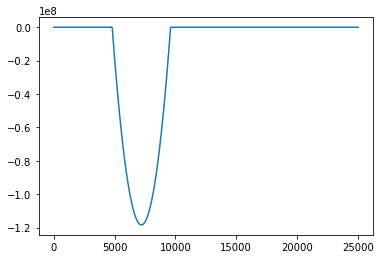

In [75]:
x = raw_price_cn.loc[y,'Ref_Cu']*(0.05*(new_quant_cn['Ref_Cu']-r))**2-r*2*raw_price_cn.loc[y,'Ref_Cu']
x[x > 0] = 0
plt.plot(new_quant_cn['Ref_Cu'],x)

In [41]:
demand_new, fruity_dem = blend_demand(all_scrap_available_year_i_cn, all_scrap_available_year_i_rw,
                            direct_melt_sectorial_demand_cn.loc[year_i], direct_melt_sectorial_demand_rw.loc[year_i],
                            raw_price_cn.loc[year_i], raw_price_rw.loc[year_i], s2s, prod_spec.copy(), raw_spec, 
                            refined_scrap_demand_cn.loc[year_i], refined_scrap_demand_rw.loc[year_i],
                            historical_prod_cn.loc[year_i,'Refined usage'], historical_prod_rw.loc[year_i,'Refined usage'],
                            fraction_yellows, unalloyed_tune, fruity_alloys, fruity_rr, pir_pcr, pir_fraction,
                            new_scrap_alloys_cn_year_i, new_scrap_alloys_rw_year_i, pir_price = pir_price)

In [42]:
demand_new.loc[idx['Mainboard-Alloy_cn',:]]
fruity_dem

,AC Inlet_cn,AC Inlet_rw,Al_Bronze_cn,Al_Bronze_rw,C65500_cn,C65500_rw,C75400_cn,C75400_rw,C83600_cn,C83600_rw,...,Ref_Pb_cn,Ref_Pb_rw,Ref_Sn_cn,Ref_Sn_rw,Ref_Zn_cn,Ref_Zn_rw,Sn_Bronze_cn,Sn_Bronze_rw,Yellow_Brass_cn,Yellow_Brass_rw
Mainboard_cn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Battery_cn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Housing_cn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Other PCBs_cn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Fasteners_cn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Thermal Management_cn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Display Assembly_cn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Other Flexes_cn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rear Camera_cn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Keyboard_cn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Import parameters

In [12]:
## High level parameters
historical_prod=pd.read_excel('Data/Production data compile.xlsx', sheet_name='Selected', index_col=0).loc[:2018]
historical_prod_cn=pd.read_excel('Data/Production data compile.xlsx', sheet_name='China', index_col=0, usecols='A:O,W:X,AE').loc[:2018]
historical_prod_rw = historical_prod.loc[1950:] - historical_prod_cn.loc[1950:]
historical_price=pd.read_excel('Data/Price data compile.xlsx', sheet_name='Price', index_col=0) # All prices 2017 constant
historical_price.drop(['Grape','Low_brass','Pb_Red_Brass'], axis = 1, inplace = True)
ref_prices_future = pd.read_csv('Data/Future metal prices.csv',index_col=0).loc[:,'Ref_Zn':]
ref_prices_historical = historical_price.loc[:,'Ref_Zn':'Ref_Fe']
ref_prices_historical.drop(2018)
ref_prices_future.index = list(range(2018,2048))
ref_prices = pd.concat([ref_prices_historical,ref_prices_future])

# Specific prod and mine data
historical_mining_prod=historical_prod.loc[:, 'Total mining production']
historical_mining_prod_cn = historical_prod_cn.loc[:, 'Total mining production']
historical_mining_prod_rw = historical_prod_rw.loc[:, 'Total mining production']

historical_lme_price=historical_price.loc[:, 'LME']
ref_price=pd.concat([historical_price.loc[:,'Ref_Zn':'Ref_Fe'],ref_prices_future])
historical_tcrc=historical_price.loc[:, 'Annual TCRC']
historical_no2=historical_price.loc[:, 'No.2 ref']
historical_sp2=historical_lme_price-historical_no2
historical_no1 = historical_price.loc[:,'Barley brass']
historical_sp1 = historical_lme_price-historical_no1
historical_alloyed = historical_price.loc[:,'Yellow_Brass':'Cartridge']
historical_alloyed = historical_alloyed[sorted(list(historical_alloyed.columns))]
scraps = list(historical_alloyed.columns)
historical_spa = historical_alloyed.apply(lambda x: -x + historical_lme_price)
raw_price = pd.concat([historical_price.loc[:,'Ref_Cu':'Cartridge'],ref_prices_future.loc[2019:,:]],sort=False)
raw_price.loc[:,'No.1'] = historical_no1
raw_price.loc[:,'No.2'] = historical_no2
raw_price.loc[2019:,:] = 0
ref_metals = list(ref_price.columns)
for i in ['Cartridge','Pb_Yellow_Brass']:
    raw_price.loc[1999:2018,i] = raw_price.loc[1999:2018,'Yellow_Brass'] * raw_price.loc[2018,i] / raw_price.loc[2018,'Yellow_Brass']
for i in ['Al_Bronze','Sn_Bronze','Pb_Sn_Bronze']:
    raw_price.loc[1999:2018,i] = raw_price.loc[1999:2018,'Red_Brass'] * raw_price.loc[2018,i] / raw_price.loc[2018,'Red_Brass']
for i in ['Mn_Bronze','Ni_Ag']:
    raw_price.loc[1999:2018,i] = raw_price.loc[1999:2018,'Ocean'] * raw_price.loc[2018,i] / raw_price.loc[2018,'Ocean']
    # used their compositions to decide which of our real-data prices to follow - subjective

## Primary supply data and patameters
operating_mine_pool=pd.read_excel('Data/primary supply/Operating mine pool - countries.xlsx', sheet_name='Sheet1', index_col=0)
open_parameter=pd.read_excel('Data/primary supply/Opening subsample parameter.xlsx', sheet_name='max5', index_col=0)
incentive_pool=pd.read_excel('Data/primary supply/Incentive mine pool - countries.xlsx', sheet_name='Sheet1', index_col=0)
pri_hyper_param=pd.read_excel('Data/primary supply/Hyperparameters.xlsx', sheet_name='Sheet1', index_col=0)
operating_mine_pool_cn = operating_mine_pool.loc[operating_mine_pool.loc[:, 'Country'] == 'China']
operating_mine_pool_rw = operating_mine_pool.loc[operating_mine_pool.loc[:, 'Country'] != 'China']
incentive_pool_cn = incentive_pool.loc[incentive_pool.loc[:, 'Country'] == 'China']
incentive_pool_rw = incentive_pool.loc[incentive_pool.loc[:, 'Country'] != 'China']

## Refinery parameters
ref_hyper_param=pd.read_excel('Data/refined supply/Refinery hyperparameter.xlsx', sheet_name='Parameters', index_col=0)
ref_hyper_param_cn = pd.read_excel('Data/refined supply/Refinery hyperparameter.xlsx', sheet_name='CN Parameters', index_col=0)
ref_hyper_param_rw = pd.read_excel('Data/refined supply/Refinery hyperparameter.xlsx', sheet_name='RW Parameters', index_col=0)
conc_to_cathode_eff=ref_hyper_param.loc['conc to cathode eff', 'Value']
scrap_to_cathode_eff=ref_hyper_param.loc['scrap to cathode eff', 'Value']
ref_prod_history = historical_prod.loc[1960:, 'Primary refining production':'Refined usage'].copy()
ref_prod_history_cn = historical_prod_cn.loc[1960:, 'Primary refining production':'Refined production, WoodMac'].copy()
ref_prod_history_cn.columns = ref_prod_history.columns
ref_prod_history_rw = ref_prod_history - ref_prod_history_cn
historical_ref_imports_cn = pd.Series(0,index=np.arange(1960,2041))
historical_ref_imports_cn.loc[:2018] = historical_prod_cn.loc[:, 'Net Refined Imports'].copy()
historical_ref_imports_cn.loc[2019:] = historical_ref_imports_cn.loc[2018]
historical_ref_imports_cn.loc[:1974] += historical_prod_cn.loc[:1974,'Semis Imports (COMTRADE, kt)']
og_historical_ref_imports_cn = historical_ref_imports_cn.copy()
# ref_prod_history_cn.loc[:, 'Refined usage'] -= historical_ref_imports_cn.loc[1960:]
# ref_prod_history_rw.loc[:, 'Refined usage'] += historical_ref_imports_cn.loc[1960:]

## Semis demand parameters
gdp_growth_prediction_base=pd.read_excel('Data/semis demand/Demand prediction data.xlsx', sheet_name='GDP growth', index_col=0, usecols=np.arange(6))
volume_prediction_base=pd.read_excel('Data/semis demand/Demand prediction data.xlsx', sheet_name='All sectors', index_col=0, header=[0,1])
intensity_prediction=pd.read_excel('Data/semis demand/Intensity initial.xls', sheet_name='Sheet1', index_col=0, header=[0,1])
elas_sec_reg=pd.read_excel('Data/semis demand/Elasticity estimates.xlsx', sheet_name='S+R S intercept only', index_col=0)
sector_shape_matrix=pd.read_excel('Data/semis demand/Sector to shape matrix updated.xlsx', sheet_name='Sheet1', index_col=0)
calibration_1718=pd.read_excel('Data/semis demand/2017 and 2018 calibration.xlsx', sheet_name='Sheet1', index_col=0)
wire_mill_fraction = 0.736162363 # fraction of unalloyed production coming from wire mills and not copper brass mills, since wire mills cannot use No.1 but brass mills can
copper_brass_mill_fraction = 1 - wire_mill_fraction
fruity_alloys = pd.read_excel('Data/semis demand/Fruity alloys.xlsx', sheet_name='Sheet1', index_col=0)
og_fruity_alloys = fruity_alloys.copy()
fruity_alloyed = fruity_alloys.copy().loc[fruity_alloys.loc[:,'Alloy Type'] != 'No.1']
fruity_alloyed.loc['Fruity No.1',:] = fruity_alloys.loc['Mainboard',:].copy()
fruity_alloyed.loc['Fruity No.1','Quantity'] = fruity_alloys.loc[fruity_alloys.loc[:,'Alloy Type']=='No.1','Quantity'].sum()
og_fruity_alloyed = fruity_alloyed.copy()

# Adjust demand in 2018 to scale it back to ICSG
intensity_prediction.loc[2017, :] = intensity_prediction.loc[2017, :]\
.mul(calibration_1718.loc[2017, 'ICSG refined usage']).div(calibration_1718.loc[2017, 'simulated refined usage'])
intensity_prediction.loc[2018, :] = intensity_prediction.loc[2018, :]\
.mul(calibration_1718.loc[2018, 'ICSG refined usage']).div(calibration_1718.loc[2018, 'simulated refined usage'])
demand_prediction=volume_prediction_base.loc[2015:, :].mul(intensity_prediction.fillna(0))

## Scrap supply parameters
use_sector_combined=pd.read_excel('Data/scrap supply/End use combined data.xlsx', sheet_name='Combined', index_col=0)
sector_to_product=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='sector to product', index_col=0)
product_to_waste=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='product to waste', index_col=0).dropna(how='all',axis=1)
product_life_and_eff=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='product lifetime and efficiency', index_col=0)
product_to_cathode_alloy=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='product to copper or alloy', index_col=0)
product_to_copper_alloy=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='prod to Cu, Cu brass, alloy', index_col=0)
recycle_efficiency=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='recycling efficiency', index_col=0)
fraction_no1_old = pd.Series({'Plumbing': 0.7,'Building Plant': 0.7,'Architecture': 0.7, 'Communications': 0.5, 
                           'Electrical Power': 0.7,'Telecommunications': 0.7,'Power Utility': 0.7,
                           'Electrical Industrial': 0.2, 'Non Elec. Industrial':0.1, 'Electrical Automotive': 0.1,
                           'Non Elec. Automotive': 0.1, 'Other Transport': 0.1, 'Consumer': 0.1, 'Cooling': 0.1, 
                           'Electronic': 0.1, 'Diverse': 0.1})
fraction_no1_new = pd.Series({'Plumbing': 0.9,'Building Plant': 0.9,'Architecture': 0.9, 'Communications': 0.9, 
                           'Electrical Power': 0.9,'Telecommunications': 0.9,'Power Utility': 0.9,
                           'Electrical Industrial': 0.7, 'Non Elec. Industrial':0.7, 'Electrical Automotive': 0.5,
                           'Non Elec. Automotive': 0.7, 'Other Transport': 0.7, 'Consumer': 0.7, 'Cooling': 0.8, 
                           'Electronic': 0.3, 'Diverse': 0.7})

# Availability-specific parameters
s2s = pd.read_excel('Data/Shape-Sector Distributions.xlsx', index_col=0)
prod_spec = pd.read_excel('Data/Prod_spec_20200311_no_low.xlsx')
raw_spec = pd.read_excel('Data/Raw_spec_201901.xlsx',index_col=0)
raw_spec.drop(['Grape','Low_brass','Pb_Red_Brass'],inplace=True)
for i in prod_spec.index:
    prod_spec.loc[i,'UNS'] = prod_spec.loc[i,'UNS']+' '+prod_spec.loc[i,'Category']

# raw_spec.loc['Pb_Sn_Bronze':'Pb_Yellow_Brass','High_Ni':'High_Mn'] = 0
    
# Home scrap ratio
home_scrap_ratio_file=pd.read_excel('Data/scrap supply/Home scrap ratio.xls', sheet_name='Sheet1', index_col=0)
home_scrap_ratio_series=home_scrap_ratio_file.loc[:, 'Calibrated ratio']
exchange_scrap_ratio_series=0.9-home_scrap_ratio_series

# Sector end use to product matrix 
use_product_history = use_sector_combined.apply(lambda x: (x*sector_to_product).sum(axis=1),axis=1)
# use_product_history=pd.DataFrame(np.matmul(use_sector_combined, sector_to_product.transpose()), 
#                                  index=use_sector_combined.index, columns=sector_to_product.index)
demand_fractions = pd.read_excel('Data/semis demand/demand_analysis_copper_lto_q2_2016.xls', sheet_name='Analysis', index_col = 0)
cn_demand_fraction = demand_fractions.loc[:,'China Fraction']
rw_demand_fraction = 1 - cn_demand_fraction
use_product_history_cn = use_product_history.apply(lambda x: x*cn_demand_fraction.loc[:2018])
use_product_history_rw = use_product_history.apply(lambda x: x*rw_demand_fraction.loc[:2018])

# Product to waste matrices
product_to_waste_collectable=product_to_waste.iloc[:, :-2]
product_to_waste_no_loss=product_to_waste_collectable.mul(1/product_to_waste_collectable.sum(axis=1), axis=0)

# Product lifetime parameters and frequencies
product_lifetime=product_life_and_eff.loc[:, 'Lifetime']
product_lifetime_cn = product_life_and_eff.loc[:, 'CN Lifetime']
product_lifetime_df=lifetime_df(product_lifetime)
product_lifetime_df_cn = lifetime_df(product_lifetime_cn)
product_lifetime_freq_df=lifetime_freq_df(product_lifetime_df)
product_lifetime_freq_df_cn = lifetime_freq_df(product_lifetime_df_cn)

# Recycling and fabrication efficiencies
sort_eff=recycle_efficiency.iloc[:, 0]
sort_eff_cn = recycle_efficiency.iloc[:, 2]
collect_rate=recycle_efficiency.iloc[:, 1]
collect_rate_cn = recycle_efficiency.iloc[:, 3]
fab_eff=product_life_and_eff.loc[:, 'Fabrication efficiency']
fab_eff_cn = product_life_and_eff.loc[:, 'CN Fabrication efficiency']
new_scrap_gen=1/fab_eff-1
new_scrap_gen_cn = 1/fab_eff_cn-1
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sort_eff_series_cn = pd.DataFrame(np.array((list(sort_eff_cn)*23)).reshape(23, 6), index = np.arange(2018,2041), columns = sort_eff_cn.index)
collect_rate_series=pd.DataFrame(np.array((list(collect_rate)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=collect_rate.index)
collect_rate_series_cn=pd.DataFrame(np.array((list(collect_rate_cn)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=collect_rate_cn.index)

## Price formation parameters
price_formation_param=pd.read_excel('Data/price formation/Price formation.xlsx', sheet_name='Sheet1', index_col=0)
cathode_sd_elas=price_formation_param.loc['Cathode SD elasticity', 'Value']
conc_sd_elas=price_formation_param.loc['Concentrate SD elasticity', 'Value']
cathode_sp2_elas=price_formation_param.loc['SP2 cathode elasticity', 'Value']
sp2_sd_elas=price_formation_param.loc['SP2 SD elasticity', 'Value']
cathode_sp1_elas=price_formation_param.loc['SP1 cathode elasticity', 'Value']
sp1_sd_elas=price_formation_param.loc['SP1 SD elasticity', 'Value']
cathode_alloyed_elas=price_formation_param.loc['SP2 SD elasticity', 'Value']
alloyed_sd_elas=price_formation_param.loc['SP Alloy SD elasticity', 'Value']

sp2_sd_elas_cn=price_formation_param.loc['SP2 SD elasticity', 'Value']
sp1_sd_elas_cn=price_formation_param.loc['SP1 SD elasticity', 'Value']
alloyed_sd_elas_cn=price_formation_param.loc['SP Alloy SD elasticity', 'Value']
sp2_sd_elas_rw=price_formation_param.loc['SP2 SD elasticity', 'Value']
sp1_sd_elas_rw=price_formation_param.loc['SP1 SD elasticity', 'Value']
alloyed_sd_elas_rw=price_formation_param.loc['SP Alloy SD elasticity', 'Value']

print(str(datetime.now()))

2022-02-03 08:35:51.080611


# Old version of scrap definitions

## System initialization

In [9]:
%store -r

In [91]:
product_to_cathode_alloy

,Copper,Alloyed
Plumbing,0.482413,0.517587
Building Plant,1.000000,0.000000
Architecture,0.516101,0.483899
Communications,1.000000,0.000000
Electrical Power,0.986363,0.013637
Telecommunications,0.999845,0.000155
Power Utility,0.928128,0.071872
Electrical Industrial,0.915842,0.084158
Non Elec. Industrial,0.088140,0.911860
Electrical Automotive,0.818238,0.181762


In [111]:
direct_melt_sectorial_demand.loc[2010]

Plumbing                   856.215934
Building Plant               0.000000
Architecture               188.766753
Communications               0.000000
Electrical Power            75.147445
Telecommunications           0.163598
Power Utility              231.657839
Electrical Industrial      114.240823
Non Elec. Industrial      1265.043301
Electrical Automotive      310.267009
Non Elec. Automotive        90.358545
Other Transport            415.325976
Consumer                   413.357162
Cooling                     24.479558
Electronic                 231.581396
Diverse                   1281.647767
Unalloyed                19532.555288
Name: 2010, dtype: float64

In [5]:
# Set rollover to 1 for previous year's scrap becoming the new year's scrap
rollover = 1
# Set scrappy to 1 for scrap balance being determined by scrap consumption from blending rather than semis demand, set it to 2 to only use the subset of scraps described by scrap_subset variable
scrappy = 2
# scrap_subset = ['No.1', 'No.2', 'Cartridge', 'Ocean', 'Red_Brass', 'Yellow_Brass',    'Pb_Yellow_Brass']
scrap_subset = list(['Yellow_Brass','Cartridge', 'No.1', 'No.2', 'Pb_Yellow_Brass', 'Ocean', 
                     'Red_Brass', 'Al_Bronze', 'Ni_Ag'])
# scrap_subset = ['No.1']
# scrap_subset = ['No.1', 'No.2', 'Al_Bronze', 'Cartridge', 'Ni_Ag', 'Ocean',
#        'Pb_Sn_Bronze', 'Pb_Yellow_Brass', 'Red_Brass', 'Yellow_Brass'] # leaving out tin bronze since it has the lowest use fraction
# Set include_unalloyed to 1 to expand semis to include unalloyed production, rather than only alloyed, set to 2 to permit fraction of unalloyed degree of freedom in blending, also requires fraction_unalloyed_brass=0.135
include_unalloyed = 2
# Set inventory to 1 to use scrap entering inventory minus scrap leaving inventory as the scrap supply-demand balance rather than all scrap available minus scrap demand
inventory = 1
# Set use_Ref_Cu to 1 to use the refined copper demand coming from blending as our copper demand
use_Ref_Cu = 1
# Set slow_change != 0 to keep blending from changing so quickly year-over-year, value is percent change permitted per year
slow_change = 0
# fraction_yellows is fraction of Yellow_Brass, Pb_Yellow_Brass, and Cartridge allowed in secondary refineries , while unalloyed tune changes the availability of No.1 and No.2 scraps in the blending module. Default 1 means they both have availability equal to total unalloyed quantity
fraction_yellows = 0.05 # set to zero to avoid this method, which includes secondary refineries in blending
unalloyed_tune = 1
use_new_recovery = 0 # set to 1 to use fraction_no1_old and new to determine No.1/No.2 ratio of unalloyed scrap, 0 uses No.2 quantity = secondary refinery demand 
refined_import_rate = 1 # refined imports, 1 is default
CU_ref_bal_elas = 0 # random estimate for how much refinery supply-demand ratio impacts CU, should be negative, 0 for default
fruity_alloys = og_fruity_alloys.copy()
fruity_alloyed = fruity_alloys.copy().loc[fruity_alloys.loc[:,'Alloy Type'] != 'No.1']

# fruity_alloyed.loc['Fruity No.1',:] = fruity_alloys.loc['Mainboard',:].copy()
# fruity_alloyed.loc['Fruity No.1','Quantity'] = fruity_alloys.loc[fruity_alloys.loc[:,'Alloy Type']=='No.1','Quantity'].sum()
# fruity_alloys.loc[:'Mesa','Quantity'] *= 10
fruity_multiplier = 1 # 0.1*30997.694215369822/og_fruity_alloys.loc[:,'Quantity'].sum() # 1 is default, 30997 is 2018 direct_melt_sectorial_demand value, the leading value (eg 0.01) would be the fraction of market occupied by these alloys
pir_pcr = 1
pir_fraction = -1
fruity_rr = [0.01,0.01,0.01,0.01,0,0,0,0]
scrap_bal_correction = 0.9 # 0.928
pir_price_set = 0.65

fraction_unalloyed_brass = 0.135

# Initialize simulation time
history_start_time='19600101'
simulation_start_time='20180101'
simulation_end_time='20400101'
simulation_time=pd.date_range(simulation_start_time, simulation_end_time, freq='AS')
history_time=pd.date_range(history_start_time, simulation_start_time, freq='AS')

# Cathode price
cathode_price_series=pd.Series(0, index=history_time)
cathode_price_series.loc[:'20180101']=historical_lme_price.values
cathode_bal_l1 = pd.Series(0, index = np.arange(2018,2041))

# TCRC
tcrc_series=pd.Series(0, index=history_time)
tcrc_series.loc[:'20180101']=historical_tcrc.values

# Scrap spreads (No.2, No.1, alloyed)
sp2_series=pd.Series(0, index=history_time)
sp2_series.loc[:'20180101']=historical_sp2.values
sp2_series_cn=pd.Series(0, index=history_time)
sp2_series_cn.loc[:'20180101']=historical_sp2.values
sp2_series_rw=pd.Series(0, index=history_time)
sp2_series_rw.loc[:'20180101']=historical_sp2.values
sp1_series = pd.Series(0, index=history_time)
sp1_series.loc[:'20180101'] = historical_sp1.values
sp1_series_cn = pd.Series(0, index=history_time)
sp1_series_cn.loc[:'20180101'] = historical_sp1.values
sp1_series_rw = pd.Series(0, index=history_time)
sp1_series_rw.loc[:'20180101'] = historical_sp1.values
spa_series = pd.DataFrame(0, index=history_time, columns=scraps)
spa_series.loc[:'20180101']= historical_spa.values
spa_series_cn = pd.DataFrame(0, index=history_time, columns=scraps)
spa_series_cn.loc[:'20180101']= historical_spa.values
spa_series_rw = pd.DataFrame(0, index=history_time, columns=scraps)
spa_series_rw.loc[:'20180101']= historical_spa.values

# Initialize mining stats
mine_life_stats_panel_operating=mine_life_stats_panel_init(simulation_time, operating_mine_pool)
mine_pool_new_last=pd.DataFrame()
mine_life_stats_panel_new_last=pd.DataFrame()
total_mining_prod=pd.Series(0, index=simulation_time)

# Initilize sxew ids
sxew_id_operating_bool=operating_mine_pool.loc[:, 'Payable percent (%)']==100
sxew_id_operating=[i for i in sxew_id_operating_bool.index if sxew_id_operating_bool.loc[i]]
conc_id_operating_bool=operating_mine_pool.loc[:, 'Payable percent (%)']!=100
conc_id_operating=[i for i in conc_id_operating_bool.index if conc_id_operating_bool.loc[i]]
sxew_id_new_bool=incentive_pool.loc[:, 'Payable percent (%)']==100
sxew_id_new=[i for i in sxew_id_new_bool.index if sxew_id_new_bool.loc[i]]
conc_id_new_bool=incentive_pool.loc[:, 'Payable percent (%)']!=100
conc_id_new=[i for i in conc_id_new_bool.index if conc_id_new_bool.loc[i]]

sxew_new=pd.Series(0, index=simulation_time)
sxew_all=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
sxew_all_cn=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
sxew_all_rw=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
sxew_all.loc['20170101']=historical_prod.loc[2017, 'SX-EW production']
sxew_all_cn.loc['20170101']=historical_prod_cn.loc[2017, 'SX-EW production']
sxew_all_rw.loc['20170101']=historical_prod_rw.loc[2017, 'SX-EW production']


# Initialize refinery stats
ref_stats=ref_stats_init(simulation_time, ref_hyper_param)
ref_stats_cn = ref_stats_init(simulation_time, ref_hyper_param_cn)
ref_stats_rw = ref_stats_init(simulation_time, ref_hyper_param_rw)
ref_bal_l1 = pd.Series(0, index = np.arange(2018,2041))
ref_bal_l1_cn = pd.Series(0, index = np.arange(2018,2041))
ref_bal_l1_rw = pd.Series(0, index = np.arange(2018,2041))

# Initialize concentrate prod, add 2017
conc_prod_series=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
conc_prod_series_cn=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
conc_prod_series_rw=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
# conc_prod_series.loc['20170101']=historical_prod.loc[2017, 'Concentrate production']
conc_prod_series_cn.loc['20170101']=historical_prod_cn.loc[2017, 'Concentrate production']
conc_prod_series_rw.loc['20170101']=historical_prod_rw.loc[2017, 'Concentrate production']
conc_prod_series.loc['20170101'] = conc_prod_series_cn.loc['20170101'] + conc_prod_series_rw.loc['20170101']

# Initialize refined supply and demand
ref_prod_series=pd.Series(0, index=simulation_time)
ref_prod_series_cn=pd.Series(0, index=simulation_time)
ref_prod_series_rw=pd.Series(0, index=simulation_time)
ref_demand_series=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
ref_demand_series_cn=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
ref_demand_series_rw=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
# ref_demand_series.loc['20170101']=historical_prod.loc[2017, 'Refined usage']
ref_demand_series_cn.loc['20170101']=historical_prod_cn.loc[2017, 'Refined usage']# - historical_ref_imports_cn.loc[2017]
ref_demand_series_rw.loc['20170101']=historical_prod_rw.loc[2017, 'Refined usage']# + historical_ref_imports_cn.loc[2017]
ref_demand_series.loc['20170101'] = ref_demand_series_cn.loc['20170101'] + ref_demand_series_rw.loc['20170101']

# Initialize end use by product stats
use_product_future=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=use_product_history.columns)
use_product_all_life=pd.concat([use_product_history, use_product_future])
use_product_future_cn=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=use_product_history_cn.columns)
use_product_all_life_cn=pd.concat([use_product_history_cn, use_product_future_cn])
use_product_future_rw=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=use_product_history_rw.columns)
use_product_all_life_rw=pd.concat([use_product_history_rw, use_product_future_rw])

# Initialize old scrap history
product_eol_history_cn=product_reach_eol(use_product_history_cn, product_lifetime_freq_df_cn)
product_eol_history_rw=product_reach_eol(use_product_history_rw, product_lifetime_freq_df)
product_eol_history=product_eol_history_cn + product_eol_history_rw
# product_eol_history = product_reach_eol(use_product_history, product_lifetime_freq_df)
# waste_from_old_history_cn=pd.DataFrame(np.matmul(product_eol_history_cn, product_to_waste_collectable), 
#                                      index=product_eol_history_cn.index, 
#                                      columns=product_to_waste_collectable.columns).mul(sort_eff_cn).mul(collect_rate_cn)
# waste_from_old_history_rw=pd.DataFrame(np.matmul(product_eol_history_rw, product_to_waste_collectable), 
#                                      index=product_eol_history_rw.index, 
#                                      columns=product_to_waste_collectable.columns).mul(sort_eff).mul(collect_rate)
# waste_from_old_history=pd.DataFrame(np.matmul(product_eol_history, product_to_waste_collectable), 
#                                      index=product_eol_history.index, 
#                                      columns=product_to_waste_collectable.columns).mul(sort_eff).mul(collect_rate)
waste_from_old_history = waste_from_old_history_cn + waste_from_old_history_rw
waste_from_old_future_cn=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=product_to_waste_collectable.columns)
waste_from_old_future_rw=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=product_to_waste_collectable.columns)
waste_from_old_future=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=product_to_waste_collectable.columns)
waste_from_old_all_life_cn=pd.concat([waste_from_old_history_cn, waste_from_old_future_cn])
waste_from_old_all_life_rw=pd.concat([waste_from_old_history_rw, waste_from_old_future_rw])
waste_from_old_all_life=pd.concat([waste_from_old_history, waste_from_old_future])

# Old scrap available 
old_scrap_available_history_cn = old_scrap_gen_init(product_eol_history_cn, product_to_waste_collectable, product_to_cathode_alloy,
                                     collect_rate_cn, sort_eff_cn, prod_spec.copy(), s2s, fraction_no1_old)
old_scrap_available_history_rw = old_scrap_gen_init(product_eol_history_rw, product_to_waste_collectable, product_to_cathode_alloy,
                                     collect_rate, sort_eff, prod_spec.copy(), s2s, fraction_no1_old)
# old_scrap_available_history = old_scrap_gen_init(product_eol_history, product_to_waste_collectable, product_to_cathode_alloy,
#                                      collect_rate, sort_eff, prod_spec.copy(), s2s, fraction_no1 = 0.1)
old_scrap_available_history = old_scrap_available_history_cn + old_scrap_available_history_rw

old_scrap_available_future=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=old_scrap_available_history.columns)
old_scrap_available_future_cn=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=old_scrap_available_history_cn.columns)
old_scrap_available_future_rw=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=old_scrap_available_history_rw.columns)
old_scrap_available_cn = pd.concat([old_scrap_available_history_cn, old_scrap_available_future_cn])
old_scrap_available_rw = pd.concat([old_scrap_available_history_rw, old_scrap_available_future_rw])
old_scrap_available = pd.concat([old_scrap_available_history, old_scrap_available_future])

# Initialize direct melt demand, needed up here for scaling fruity alloyed
direct_melt_sectorial_demand_cn=(use_product_all_life_cn*product_to_cathode_alloy.loc[:, 'Alloyed'])
direct_melt_sectorial_demand_rw=(use_product_all_life_rw*product_to_cathode_alloy.loc[:, 'Alloyed'])
direct_melt_sectorial_demand = direct_melt_sectorial_demand_cn + direct_melt_sectorial_demand_rw

if include_unalloyed == 1:
#     direct_melt_sectorial_demand.loc[:,'Unalloyed'] = (use_product_all_life*product_to_cathode_alloy.loc[:, 'Copper']).sum(axis = 1)
    direct_melt_sectorial_demand_cn.loc[:,'Unalloyed'] = (use_product_all_life_cn*product_to_cathode_alloy.loc[:, 'Copper']).sum(axis = 1)
    direct_melt_sectorial_demand_rw.loc[:,'Unalloyed'] = (use_product_all_life_rw*product_to_cathode_alloy.loc[:, 'Copper']).sum(axis = 1)
    direct_melt_sectorial_demand.loc[:, 'Unalloyed'] = direct_melt_sectorial_demand_cn.loc[:, 'Unalloyed'] + direct_melt_sectorial_demand_rw.loc[:, 'Unalloyed']
    # Including imports
    direct_melt_sectorial_demand_cn.loc[1960:2018, 'Unalloyed'] -= historical_ref_imports_cn.loc[1960:2018]
    direct_melt_sectorial_demand_rw.loc[1960:2018, 'Unalloyed'] += historical_ref_imports_cn.loc[1960:2018]
#     direct_melt_sectorial_demand_cn.loc[:, 'Unalloyed'] = use_product_all_life_cn.sum(axis=1) - direct_melt_sectorial_demand_cn.sum(axis = 1)
#     direct_melt_sectorial_demand_rw.loc[:, 'Unalloyed'] = direct_melt_sectorial_demand.loc[:,'Unalloyed'] - direct_melt_sectorial_demand_cn.loc[:,'Unalloyed']

elif include_unalloyed == 2:
    direct_melt_sectorial_demand_cn.loc[:,'Unalloyed'] = (use_product_all_life_cn*product_to_copper_alloy.loc[:, 'Copper']).sum(axis = 1)
    direct_melt_sectorial_demand_rw.loc[:,'Unalloyed'] = (use_product_all_life_rw*product_to_copper_alloy.loc[:, 'Copper']).sum(axis = 1)
    direct_melt_sectorial_demand.loc[:, 'Unalloyed'] = direct_melt_sectorial_demand_cn.loc[:, 'Unalloyed'] + direct_melt_sectorial_demand_rw.loc[:, 'Unalloyed']
    direct_melt_sectorial_demand_cn.loc[:,'Copper brass'] = (use_product_all_life_cn*product_to_copper_alloy.loc[:, 'Copper brass']).sum(axis = 1)
    direct_melt_sectorial_demand_rw.loc[:,'Copper brass'] = (use_product_all_life_rw*product_to_copper_alloy.loc[:, 'Copper brass']).sum(axis = 1)
    direct_melt_sectorial_demand.loc[:, 'Copper brass'] = direct_melt_sectorial_demand_cn.loc[:, 'Copper brass'] + direct_melt_sectorial_demand_rw.loc[:, 'Copper brass']
    # Including imports
    direct_melt_sectorial_demand_cn.loc[1960:2018, 'Unalloyed'] -= historical_ref_imports_cn.loc[1960:2018]*(1-fraction_unalloyed_brass)
    direct_melt_sectorial_demand_rw.loc[1960:2018, 'Unalloyed'] += historical_ref_imports_cn.loc[1960:2018]*(1-fraction_unalloyed_brass)
    direct_melt_sectorial_demand_cn.loc[1960:2018, 'Copper brass'] -= historical_ref_imports_cn.loc[1960:2018]*fraction_unalloyed_brass
    direct_melt_sectorial_demand_rw.loc[1960:2018, 'Copper brass'] += historical_ref_imports_cn.loc[1960:2018]*fraction_unalloyed_brass
#     direct_melt_sectorial_demand_cn.loc[:, 'Unalloyed'] = use_product_all_life_cn.sum(axis=1) - direct_melt_sectorial_demand_cn.sum(axis = 1)
#     direct_melt_sectorial_demand_rw.loc[:, 'Unalloyed'] = direct_melt_sectorial_demand.loc[:,'Unalloyed'] - direct_melt_sectorial_demand_cn.loc[:,'Unalloyed']

# Initialize new scrap history
waste_from_new_history_cn=pd.DataFrame(0, index=waste_from_old_history_cn.index, columns=product_to_waste_collectable.columns)
waste_from_new_history_rw=pd.DataFrame(0, index=waste_from_old_history_rw.index, columns=product_to_waste_collectable.columns)
waste_from_new_history=pd.DataFrame(0, index=waste_from_old_history.index, columns=product_to_waste_collectable.columns)
new_scrap_available_history_cn = pd.DataFrame(0, index = product_eol_history_cn.index, columns = old_scrap_available_history_cn.columns)
new_scrap_available_history_rw = pd.DataFrame(0, index = product_eol_history_rw.index, columns = old_scrap_available_history_rw.columns)
new_scrap_available_history = pd.DataFrame(0, index = product_eol_history.index, columns = old_scrap_available_history.columns)
new_scrap_alloys_cn = pd.DataFrame(0, index = product_eol_history_cn.index, columns = list(prod_spec.loc[:,'Primary code'].unique())+list(['New No.1'])+list(fruity_alloyed.index))
new_scrap_alloys_rw = pd.DataFrame(0, index = product_eol_history_rw.index, columns = list(prod_spec.loc[:,'Primary code'].unique())+list(['New No.1'])+list(fruity_alloyed.index))
prod_spec_cop = prod_spec.copy()
prod_spec_cop.UNS = [i+'_cn' for i in prod_spec_cop.UNS]
for i in prod_spec_cop.index:
    prod_spec_cop.loc[i+prod_spec.shape[0],:] = prod_spec_cop.loc[i,:]
    prod_spec_cop.loc[i+prod_spec.shape[0],'UNS'] = prod_spec_cop.loc[i,'UNS'] + '_rw'
annual_recycled_content = pd.DataFrame(0, index = np.arange(1960,2041), columns = list(prod_spec_cop.loc[:,'UNS'])+[i+'_cn' for i in fruity_alloys.index]+list(['Unalloyed_cn', 'Unalloyed_rw', 'Secondary refined_cn', 'Secondary refined_rw']))
annual_recycled_volume = pd.DataFrame(0, index = np.arange(1960,2041), columns = list(prod_spec_cop.loc[:,'UNS'])+[i+'_cn' for i in fruity_alloys.index]+list(['Unalloyed_cn', 'Unalloyed_rw', 'Secondary refined_cn', 'Secondary refined_rw']))

for year_i in new_scrap_available_history.index:
    home_scrap_ratio=home_scrap_ratio_series.loc[year_i]
    exchange_scrap_ratio=exchange_scrap_ratio_series.loc[year_i]
    ######################################### unsure about this new_scrap_gen_cn and the fabrication efficiencies associated with it
    waste_from_new_year_i_cn=\
    simulate_new_scrap_one_year(year_i, use_product_history_cn, new_scrap_gen_cn, product_to_waste_no_loss, sort_eff_cn, 
                                home_scrap_ratio, exchange_scrap_ratio)
    waste_from_new_history_cn.loc[year_i]=waste_from_new_year_i_cn.values
    waste_from_new_year_i_rw=\
    simulate_new_scrap_one_year(year_i, use_product_history_rw, new_scrap_gen, product_to_waste_no_loss, sort_eff, 
                                home_scrap_ratio, exchange_scrap_ratio)
    waste_from_new_history_rw.loc[year_i]=waste_from_new_year_i_rw.values
#     waste_from_new_year_i=\
#     simulate_new_scrap_one_year(year_i, use_product_history, new_scrap_gen, product_to_waste_no_loss, sort_eff, 
#                                 home_scrap_ratio, exchange_scrap_ratio)
    waste_from_new_history.loc[year_i]=waste_from_new_year_i_cn.values + waste_from_new_year_i_rw.values
    
    # Initialize new scrap availability history
    if pir_pcr == 0:
        new_scrap_available_year_i_cn = \
        new_scrap_gen_oneyear(use_product_history_cn.loc[year_i], product_to_waste_no_loss, product_to_cathode_alloy, 
                              collect_rate_cn, sort_eff_cn, prod_spec.copy(), s2s, new_scrap_gen_cn, exchange_scrap_ratio, 
                              home_scrap_ratio, fraction_no1_new)
        new_scrap_available_year_i_rw = \
        new_scrap_gen_oneyear(use_product_history_rw.loc[year_i], product_to_waste_no_loss, product_to_cathode_alloy, 
                              collect_rate, sort_eff, prod_spec.copy(), s2s, new_scrap_gen, exchange_scrap_ratio, 
                              home_scrap_ratio, fraction_no1_new)
    else:
        if fruity_multiplier != 0:
            fruity_alloyed.loc[:,'Quantity'] = fruity_multiplier*og_fruity_alloyed.loc[:,'Quantity']/direct_melt_sectorial_demand.loc[2018].sum()*direct_melt_sectorial_demand.loc[year_i].sum()
            while 0.3*direct_melt_sectorial_demand.loc[year_i,'Diverse'] < fruity_alloyed.loc[:,'Quantity'].sum():
                fruity_alloyed.loc[:,'Quantity'] *= 0.5
                print('New scrap alloyed reduced')
            
        new_scrap_available_year_i_cn, new_scrap_alloys_cn_year_i = \
        new_scrap_gen_oneyear(use_product_history_cn.loc[year_i], product_to_waste_no_loss, product_to_cathode_alloy, 
                              collect_rate_cn, sort_eff_cn, prod_spec.copy(), s2s, new_scrap_gen_cn, exchange_scrap_ratio, 
                              home_scrap_ratio, fraction_no1_new, pir_pcr, fruity_alloyed)
        new_scrap_available_year_i_rw, new_scrap_alloys_rw_year_i = \
        new_scrap_gen_oneyear(use_product_history_rw.loc[year_i], product_to_waste_no_loss, product_to_cathode_alloy, 
                              collect_rate, sort_eff, prod_spec.copy(), s2s, new_scrap_gen, exchange_scrap_ratio, 
                              home_scrap_ratio, fraction_no1_new, 2, fruity_alloyed)
        new_scrap_alloys_cn_year_i.loc[new_scrap_alloys_cn_year_i.loc[:,'Availability'] < 0,'Availability'] = 0
        new_scrap_alloys_rw_year_i.loc[new_scrap_alloys_rw_year_i.loc[:,'Availability'] < 0,'Availability'] = 0
        
    new_scrap_available_history_cn.loc[year_i] = new_scrap_available_year_i_cn
    new_scrap_available_history_rw.loc[year_i] = new_scrap_available_year_i_rw
    new_scrap_available_history.loc[year_i] = new_scrap_available_year_i_cn + new_scrap_available_year_i_rw
    if pir_pcr != 0:
        new_scrap_alloys_cn.loc[year_i] = new_scrap_alloys_cn_year_i.loc[:,'Availability']
        new_scrap_alloys_rw.loc[year_i] = new_scrap_alloys_rw_year_i.loc[:,'Availability']
    else:
        new_scrap_alloys_cn = 0
        new_scrap_alloys_rw = 0
# waste_from_new_history = waste_from_new_history_cn + waste_from_new_history_rw
# new_scrap_available_history = new_scrap_available_history_cn + new_scrap_available_history_rw
if pir_pcr != 0:
    new_scrap_alloys_compositions = new_scrap_alloys_cn_year_i.loc[:,:'Low_Fe']
else:
    new_scrap_alloys_compositions = 0

waste_from_new_future_cn=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=product_to_waste_collectable.columns)
waste_from_new_future_rw=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=product_to_waste_collectable.columns)
waste_from_new_future=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=product_to_waste_collectable.columns)
waste_from_new_all_life_cn=pd.concat([waste_from_new_history_cn, waste_from_new_future_cn])
waste_from_new_all_life_rw=pd.concat([waste_from_new_history_rw, waste_from_new_future_rw])
waste_from_new_all_life=pd.concat([waste_from_new_history, waste_from_new_future])
new_scrap_available_future_cn = pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns = new_scrap_available_history_cn.columns)
new_scrap_available_future_rw = pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns = new_scrap_available_history_rw.columns)
new_scrap_available_future = pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns = new_scrap_available_history.columns)
new_scrap_available_cn = pd.concat([new_scrap_available_history_cn, new_scrap_available_future_cn])
new_scrap_available_rw = pd.concat([new_scrap_available_history_rw, new_scrap_available_future_rw])
new_scrap_available = pd.concat([new_scrap_available_history, new_scrap_available_future])

# Assumes China scrap distribution is the same as the rest of the world
waste_all_life_cn=waste_from_old_all_life_cn+waste_from_new_all_life_cn
waste_all_life_rw=waste_from_old_all_life_rw+waste_from_new_all_life_rw
waste_imports_cn_all = (waste_all_life_rw.apply(lambda x: x / waste_all_life_rw.sum(axis=1) * \
                          historical_prod_cn.loc[:,'Copper Scrap Imports, COMTRADE (kt)'])).loc[1960:2040]
scrap_imports_cn_all = (old_scrap_available_rw.apply(lambda x: x / old_scrap_available_rw.sum(axis=1) * \
                          historical_prod_cn.loc[:,'Copper Scrap Imports, COMTRADE (kt)'])).loc[1960:2040]

# China's future imports
for i in waste_imports_cn_all.loc[2019:].index:
    waste_imports_cn_all.loc[i,:] = waste_imports_cn_all.loc[2018, :]
for i in scrap_imports_cn_all.loc[2019:].index:
    scrap_imports_cn_all.loc[i, :] = scrap_imports_cn_all.loc[2018, :]
og_scrap_imports_cn_all = scrap_imports_cn_all.copy()
    
# Summing to produce all available scraps
waste_all_life_cn += waste_imports_cn_all
waste_all_life_rw -= waste_imports_cn_all
waste_all_life = waste_all_life_cn + waste_all_life_rw
all_scrap_available_cn = old_scrap_available_cn + new_scrap_available_cn + scrap_imports_cn_all
all_scrap_available_rw = old_scrap_available_rw + new_scrap_available_rw - scrap_imports_cn_all
all_scrap_available = all_scrap_available_cn + all_scrap_available_rw
total_unalloyed_cn = all_scrap_available_cn.loc[:,'No.1':'No.2'].sum(axis = 1)
total_unalloyed_rw = all_scrap_available_rw.loc[:,'No.1':'No.2'].sum(axis = 1)
total_unalloyed = all_scrap_available.loc[:,'No.1':'No.2'].sum(axis = 1)

# assuming historical No.1/No.2 ratio is at the 2018 value into the past
if use_new_recovery == 0:
    all_scrap_available_cn.loc[:,'No.1'] = total_unalloyed_cn.loc[:] - historical_prod_cn.loc[:, 'Secondary refining production'] / scrap_to_cathode_eff * 0.85
    all_scrap_available_rw.loc[:,'No.1'] = total_unalloyed_rw.loc[:] - historical_prod_rw.loc[:, 'Secondary refining production'] / scrap_to_cathode_eff * 0.85
    # all_scrap_available.loc[:,'No.1'] = total_unalloyed.loc[:] - historical_prod.loc[:, 'Secondary refining production'] / scrap_to_cathode_eff
    # all_scrap_available.loc[:,'No.2'] = historical_prod.loc[:, 'Secondary refining production'] / scrap_to_cathode_eff
    all_scrap_available_cn.loc[:,'No.2'] = historical_prod_cn.loc[:, 'Secondary refining production'] / scrap_to_cathode_eff * 0.85
    all_scrap_available_rw.loc[:,'No.2'] = historical_prod_rw.loc[:, 'Secondary refining production'] / scrap_to_cathode_eff * 0.85
all_scrap_available.loc[:, 'No.1'] = all_scrap_available_cn.loc[:, 'No.1'] + all_scrap_available_rw.loc[:, 'No.1']
all_scrap_available.loc[:, 'No.2'] = all_scrap_available_cn.loc[:, 'No.2'] + all_scrap_available_rw.loc[:, 'No.2']

all_scrap_available_no_accumulation = all_scrap_available.copy() 
all_scrap_available_no_accumulation_cn = all_scrap_available_cn.copy() 
all_scrap_available_no_accumulation_rw = all_scrap_available_rw.copy() 
# no_accumulation translates to the scrap entering the market that year - the increase in inventory that 
# I'm thinking works as scrap supply for deterimining the supply-demand balance, while total_scrap_demand_all_life 
# with scrappy=1 gives the scrap demand, or the scrap leaving inventory in that year

# Removing new scrap that is now in alloy form
if pir_pcr != 0:
#     all_scrap_no_new_cn = all_scrap_available_cn.copy()
#     all_scrap_no_new_rw = all_scrap_available_rw.copy()
#     all_scrap_no_new_cn.loc[:,'Al_Bronze':] -= alloy_to_scrap(new_scrap_alloys_cn, new_scrap_alloys_compositions)
#     all_scrap_no_new_rw.loc[:,'Al_Bronze':] -= alloy_to_scrap(new_scrap_alloys_rw, new_scrap_alloys_compositions)
#     all_scrap_no_new = all_scrap_no_new_cn + all_scrap_no_new_rw
    all_scrap_available_cn.loc[1961:,'Al_Bronze':] -= alloy_to_scrap(new_scrap_alloys_cn, new_scrap_alloys_compositions).loc[1961:]
    all_scrap_available_rw.loc[1961:,'Al_Bronze':] -= alloy_to_scrap(new_scrap_alloys_rw, new_scrap_alloys_compositions).loc[1961:]
    all_scrap_available = all_scrap_available_cn + all_scrap_available_rw
    all_scrap_available_no_accumulation_cn.loc[1961:,'Al_Bronze':] -= alloy_to_scrap(new_scrap_alloys_cn, new_scrap_alloys_compositions).loc[1961:]
    all_scrap_available_no_accumulation_rw.loc[1961:,'Al_Bronze':] -= alloy_to_scrap(new_scrap_alloys_rw, new_scrap_alloys_compositions).loc[1961:]
    all_scrap_available_no_accumulation = all_scrap_available_cn + all_scrap_available_rw


# Initialize scrap demand
# direct_melt_scrap_demand=(use_product_all_life*product_to_cathode_alloy.loc[:, 'Alloyed']).sum(axis=1)
direct_melt_scrap_demand_cn=(use_product_all_life_cn*product_to_cathode_alloy.loc[:, 'Alloyed']).sum(axis=1)
direct_melt_scrap_demand_rw=(use_product_all_life_rw*product_to_cathode_alloy.loc[:, 'Alloyed']).sum(axis=1)
direct_melt_scrap_demand = direct_melt_scrap_demand_cn + direct_melt_scrap_demand_rw
# direct_melt_scrap_demand_cn=(use_product_all_life_cn*product_to_cathode_alloy.loc[:, 'Alloyed']).sum(axis=1) * \
#                             historical_prod_cn.loc[1960:, 'Direct melt'] / \
#                             direct_melt_scrap_demand_cn.loc[1960:]
# direct_melt_scrap_demand_rw = direct_melt_scrap_demand - direct_melt_scrap_demand_cn

## direct_melt_sectorial_demand=(use_product_all_life*product_to_cathode_alloy.loc[:, 'Alloyed'])
# direct_melt_sectorial_demand_cn=(use_product_all_life_cn*product_to_cathode_alloy.loc[:, 'Alloyed'])
# direct_melt_sectorial_demand_rw=(use_product_all_life_rw*product_to_cathode_alloy.loc[:, 'Alloyed'])
# direct_melt_sectorial_demand = direct_melt_sectorial_demand_cn + direct_melt_sectorial_demand_rw
## direct_melt_sectorial_demand_cn=(use_product_all_life_cn*product_to_cathode_alloy.loc[:, 'Alloyed']).apply(lambda x: x* \
##                                 historical_prod_cn.loc[1960:, 'Direct melt'] / \
##                                direct_melt_scrap_demand_cn.loc[1960:])
## direct_melt_sectorial_demand_rw = direct_melt_sectorial_demand - direct_melt_sectorial_demand_cn

if pir_pcr == 0:
    direct_melt_demand = pd.DataFrame(0, index = np.arange(1960,2041), columns = raw_price.columns)
    direct_melt_demand_cn = pd.DataFrame(0, index = np.arange(1960,2041), columns = raw_price.columns)
    direct_melt_demand_rw = pd.DataFrame(0, index = np.arange(1960,2041), columns = raw_price.columns)
else:
    direct_melt_demand = pd.DataFrame(0, index = np.arange(1960,2041), columns = list(raw_price.columns) + list(new_scrap_alloys_compositions.index))
    direct_melt_demand_cn = pd.DataFrame(0, index = np.arange(1960,2041), columns = list(raw_price.columns) + list(new_scrap_alloys_compositions.index))
    direct_melt_demand_rw = pd.DataFrame(0, index = np.arange(1960,2041), columns = list(raw_price.columns) + list(new_scrap_alloys_compositions.index))
fruity_detailed_demand = pd.DataFrame(0,index = pd.MultiIndex.from_product([direct_melt_demand_cn.index, \
                fruity_alloys.index]), columns = direct_melt_demand.columns)

# refined_scrap_demand=historical_prod.loc[:, 'Secondary refining production'].div(scrap_to_cathode_eff)
refined_scrap_demand_cn=historical_prod_cn.loc[:, 'Secondary refining production'].div(scrap_to_cathode_eff)
refined_scrap_demand_rw=historical_prod_rw.loc[:, 'Secondary refining production'].div(scrap_to_cathode_eff)
refined_scrap_demand = refined_scrap_demand_cn + refined_scrap_demand_rw
total_secondary_demand_all_life=pd.DataFrame({'Direct melt scrap': direct_melt_scrap_demand, 
                                          'Refined scrap': refined_scrap_demand})
total_secondary_demand_all_life_cn=pd.DataFrame({'Direct melt scrap': direct_melt_scrap_demand_cn, 
                                          'Refined scrap': refined_scrap_demand_cn})
total_secondary_demand_all_life_rw=pd.DataFrame({'Direct melt scrap': direct_melt_scrap_demand_rw, 
                                          'Refined scrap': refined_scrap_demand_rw})
sec_ref_scrap_demand = direct_melt_demand.copy() # records scraps used in secondary refining
sec_ref_scrap_demand_cn = direct_melt_demand.copy()
sec_ref_scrap_demand_rw = direct_melt_demand.copy()
fruity_demand = direct_melt_demand.copy()

# Adding in historical blending
# Generating Prices (assuming all metals' price ratios as compared with Ref_Cu remain constant at the earliest level we have)
raw_price.loc[1960:1998, 'Ref_Cu'] = cathode_price_series.loc[pd.datetime(1960, 1, 1):pd.datetime(1998, 1, 1)].values
raw_price.loc[1960,'Ref_Zn':'Cartridge'] = raw_price.loc[1999,'Ref_Zn':'Cartridge'] / raw_price.loc[1999,'Ref_Cu'] \
    * raw_price.loc[1960,'Ref_Cu']
raw_price.loc[1960,'No.1':'No.2'] = raw_price.loc[1993,'No.1':'No.2'] / raw_price.loc[1993,'Ref_Cu'] \
    * raw_price.loc[1960,'Ref_Cu']
raw_price.loc[1961:1998,'Ref_Zn':'Cartridge'] = raw_price.loc[1961:1998,'Ref_Cu'].apply(
    lambda x: x * raw_price.loc[1999,'Ref_Zn':'Cartridge'] / raw_price.loc[1999,'Ref_Cu'])
raw_price.loc[1961:1992,'No.1':'No.2'] = raw_price.loc[1961:1992,'Ref_Cu'].apply(
    lambda x: x * raw_price.loc[1999,'No.1':'No.2'] / raw_price.loc[1999,'Ref_Cu'])
raw_price_cn = raw_price.copy()
raw_price_rw = raw_price.copy() # assuming that china's scrap prices may differ from those of the row due to the ban

if 'Low_Brass' in all_scrap_available.columns:
    all_scrap_available.drop('Low_Brass', axis = 1, inplace = True)
    all_scrap_available_cn.drop('Low_Brass', axis = 1, inplace = True)
    all_scrap_available_rw.drop('Low_Brass', axis = 1, inplace = True)


NameError: name 'waste_from_old_history_cn' is not defined

In [144]:
# 192
s3s.groupby(level=1).sum()
direct_melt_sectorial_demand['Copper brass']/direct_melt_sectorial_demand.loc[:,'Unalloyed':].sum(axis=1)

1912    0.119592
1913    0.119592
1914    0.119592
1915    0.119592
1916    0.119592
          ...   
2036         NaN
2037         NaN
2038         NaN
2039         NaN
2040         NaN
Length: 129, dtype: float64

## Blending component

In [89]:
direct_melt_sectorial_demand

,Plumbing,Building Plant,Architecture,Communications,Electrical Power,Telecommunications,Power Utility,Electrical Industrial,Non Elec. Industrial,Electrical Automotive,Non Elec. Automotive,Other Transport,Consumer,Cooling,Electronic,Diverse,Unalloyed
1912,50.078711,0.0,11.040668,0.0,4.395255,0.007947,11.253137,7.990874,88.486769,20.376298,5.934156,27.275881,16.976331,1.005361,9.510909,52.636506,1039.315550
1913,51.257034,0.0,11.300448,0.0,4.498673,0.008134,11.517917,8.178894,90.568811,20.855741,6.073783,27.917667,17.375774,1.029016,9.734695,53.875012,1063.770034
1914,52.435357,0.0,11.560229,0.0,4.602090,0.008321,11.782697,8.366915,92.650852,21.335183,6.213410,28.559452,17.775217,1.052672,9.958481,55.113518,1088.224517
1915,53.613679,0.0,11.820009,0.0,4.705508,0.008508,12.047476,8.554935,94.732894,21.814625,6.353037,29.201237,18.174660,1.076327,10.182267,56.352024,1112.679001
1916,54.792002,0.0,12.079790,0.0,4.808926,0.008695,12.312256,8.742956,96.814936,22.294068,6.492664,29.843023,18.574103,1.099983,10.406054,57.590530,1137.133484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2036,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2037,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2038,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2039,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [302]:
# Blending to determine demand in the direct melt sector
ut_db = pd.Series(1,index=np.arange(2006,2011))
for year_i in ut_db.index:
    if fruity_multiplier != 0:
        fruity_alloys.loc[:,'Quantity'] = fruity_multiplier*og_fruity_alloys.loc[:,'Quantity']/direct_melt_sectorial_demand.loc[2018].sum()*direct_melt_sectorial_demand.loc[year_i].sum()
    
    if pir_pcr != 0:
        if year_i > 1960:
            all_scrap_available_cn.loc[year_i,'Al_Bronze':] += alloy_to_scrap_1yr(new_scrap_alloys_cn.loc[year_i-1] - direct_melt_demand_cn.loc[year_i-1, new_scrap_alloys_cn.columns], new_scrap_alloys_compositions)
            all_scrap_available_rw.loc[year_i,'Al_Bronze':] += alloy_to_scrap_1yr(new_scrap_alloys_rw.loc[year_i-1] - direct_melt_demand_rw.loc[year_i-1, new_scrap_alloys_rw.columns], new_scrap_alloys_compositions)
#             all_scrap_available_no_accumulation_cn.loc[year_i,'Al_Bronze':] += alloy_to_scrap_1yr(new_scrap_alloys_cn.loc[year_i-1] - direct_melt_demand_cn.loc[year_i-1, new_scrap_alloys_cn.columns], new_scrap_alloys_compositions)
#             all_scrap_available_no_accumulation_rw.loc[year_i,'Al_Bronze':] += alloy_to_scrap_1yr(new_scrap_alloys_rw.loc[year_i-1] - direct_melt_demand_rw.loc[year_i-1, new_scrap_alloys_rw.columns], new_scrap_alloys_compositions)
#             all_scrap_available_no_accumulation.loc[year_i] = all_scrap_available_no_accumulation_cn.loc[year_i] + all_scrap_available_no_accumulation_rw.loc[year_i]
        new_scrap_alloys_cn_year_i = new_scrap_alloys_compositions.copy().loc[:,'High_Cu':]
        new_scrap_alloys_cn_year_i.loc[:,'Availability'] = new_scrap_alloys_cn.loc[year_i]
        new_scrap_alloys_rw_year_i = new_scrap_alloys_compositions.copy().loc[:,'High_Cu':]
        new_scrap_alloys_rw_year_i.loc[:,'Availability'] = new_scrap_alloys_rw.loc[year_i]
        
    if year_i > 1960:   
#         all_scrap_available.loc[year_i,:] += all_scrap_available.loc[year_i-1,:] - direct_melt_demand.loc[year_i-1,:]
        all_scrap_available_cn.loc[year_i,:] += all_scrap_available_cn.loc[year_i-1,:] - direct_melt_demand_cn.loc[year_i-1,:]
        all_scrap_available_rw.loc[year_i,:] += all_scrap_available_rw.loc[year_i-1,:] - direct_melt_demand_rw.loc[year_i-1,:]
        all_scrap_available.loc[year_i,:] = all_scrap_available_cn.loc[year_i,:] + all_scrap_available_rw.loc[year_i,:] 
    
    if rollover == 1:
        all_scrap_available_year_i = all_scrap_available.loc[year_i]
        all_scrap_available_year_i_cn = all_scrap_available_cn.loc[year_i]
        all_scrap_available_year_i_rw = all_scrap_available_rw.loc[year_i]
    else:
        all_scrap_available_year_i = all_scrap_available_no_accumulation.loc[year_i]
        all_scrap_available_year_i_cn = all_scrap_available_no_accumulation_cn.loc[year_i]
        all_scrap_available_year_i_rw = all_scrap_available_no_accumulation_rw.loc[year_i]
    if year_i < 1973:
        pir_price = 1.09
    else:
        pir_price = pir_price_set
    
    error = 1e6
    p = 0
    unalloyed_tune = 1.29
    while abs(error) > 450:
#     while p == 0:
        if (year_i == 1960 or slow_change == 0) and fraction_yellows != 0:
            direct_melt_demand_cn.loc[year_i,:], direct_melt_demand_rw.loc[year_i,:], sec_ref_scrap_demand_cn.loc[year_i,:], sec_ref_scrap_demand_rw.loc[year_i,:], fruity_detailed, annual_recycled_content.loc[year_i], annual_recycled_volume.loc[year_i] = \
                blend_demand(all_scrap_available_year_i_cn, all_scrap_available_year_i_rw,
                                direct_melt_sectorial_demand_cn.loc[year_i], direct_melt_sectorial_demand_rw.loc[year_i],
                                raw_price_cn.loc[year_i], raw_price_rw.loc[year_i], s2s, prod_spec.copy(), raw_spec, 
                                refined_scrap_demand_cn.loc[year_i], refined_scrap_demand_rw.loc[year_i],
                                historical_prod_cn.loc[year_i,'Refined usage'], historical_prod_rw.loc[year_i,'Refined usage'],
                                fraction_yellows, unalloyed_tune, fruity_alloys, fruity_rr, pir_pcr, pir_fraction,
                                new_scrap_alloys_cn_year_i, new_scrap_alloys_rw_year_i, pir_price = pir_price)
            sec_ref_scrap_demand.loc[year_i,:] = sec_ref_scrap_demand_cn.loc[year_i,:] + sec_ref_scrap_demand_rw.loc[year_i,:]
#             fruity_demand.loc[year_i,:] = fruity_detailed_demand.loc[idx[year_i,:],:].sum()
        direct_melt_demand.loc[year_i, :] = direct_melt_demand_cn.loc[year_i, :] + direct_melt_demand_rw.loc[year_i, :] 
        
        ut_db.loc[year_i] = unalloyed_tune
        p += 1
        error = direct_melt_demand.loc[year_i,'Ref_Cu'] - direct_melt_sectorial_demand.loc[year_i,['Unalloyed','Copper brass']].sum()
        ut_old = unalloyed_tune
        if error > 0:
            unalloyed_tune /= 1.05#abs(error)/5000
        else:
            unalloyed_tune *= 1.08#abs(error)/5000 # decreasing alloy_tune makes scrap cheaper and decreases Ref_Cu
        print('Pass',p,': Ref_Cu exceeds historical by',round(error,0),'kt.\n\tOld tune:',round(ut_old,3),'\tNew tune:',round(unalloyed_tune,3))

    if fraction_yellows == 0:
        direct_melt_demand.loc[year_i,'No.2'] = refined_scrap_demand_cn[year_i] + refined_scrap_demand_rw[year_i]
        direct_melt_demand_cn.loc[year_i,'No.2'] = refined_scrap_demand_cn[year_i]
        direct_melt_demand_rw.loc[year_i,'No.2'] = refined_scrap_demand_rw[year_i]
    if year_i % 1 == 0:
        print(year_i)

# if pir_pcr != 0:
#     all_scrap_available_cn.loc[1961:,'Al_Bronze':] += alloy_to_scrap(new_scrap_alloys_cn, new_scrap_alloys_compositions).loc[1961:]
#     all_scrap_available_rw.loc[1961:,'Al_Bronze':] += alloy_to_scrap(new_scrap_alloys_rw, new_scrap_alloys_compositions).loc[1961:]
#     all_scrap_available = all_scrap_available_cn + all_scrap_available_rw
    
if scrappy == 1:
    total_scrap_demand_all_life=pd.DataFrame({'Direct melt scrap': direct_melt_demand.loc[:,'Yellow_Brass':].sum(axis=1) - refined_scrap_demand, \
                                          'Refined scrap': refined_scrap_demand})
    total_scrap_demand_all_life_cn=pd.DataFrame({'Direct melt scrap': direct_melt_demand_cn.loc[:,'Yellow_Brass':].sum(axis=1) - refined_scrap_demand, \
                                          'Refined scrap': refined_scrap_demand_cn})
    total_scrap_demand_all_life_rw=pd.DataFrame({'Direct melt scrap': direct_melt_demand_rw.loc[:,'Yellow_Brass':].sum(axis=1) - refined_scrap_demand, \
                                          'Refined scrap': refined_scrap_demand_rw})
elif scrappy == 2:
    total_scrap_demand_all_life=pd.DataFrame({'Direct melt scrap': direct_melt_demand.loc[:, scrap_subset].sum(axis=1) - refined_scrap_demand, \
                                              'Refined scrap': refined_scrap_demand})
    total_scrap_demand_all_life_cn=pd.DataFrame({'Direct melt scrap': direct_melt_demand_cn.loc[:, scrap_subset].sum(axis=1) - refined_scrap_demand_cn, \
                                                 'Refined scrap': refined_scrap_demand_cn})
    total_scrap_demand_all_life_rw=pd.DataFrame({'Direct melt scrap': direct_melt_demand_rw.loc[:, scrap_subset].sum(axis=1) - refined_scrap_demand_rw, \
                                                 'Refined scrap': refined_scrap_demand_rw})
else:
    total_scrap_demand_all_life=pd.DataFrame({'Direct melt scrap': direct_melt_demand.sum(axis=1) - refined_scrap_demand, \
                                              'Refined scrap': refined_scrap_demand})
    total_scrap_demand_all_life_cn=pd.DataFrame({'Direct melt scrap': direct_melt_demand_cn.sum(axis=1) - refined_scrap_demand_cn, \
                                                 'Refined scrap': refined_scrap_demand_cn})
    total_scrap_demand_all_life_rw=pd.DataFrame({'Direct melt scrap': direct_melt_demand_rw.sum(axis=1) - refined_scrap_demand_rw, \
                                                 'Refined scrap': refined_scrap_demand_rw})

scrap_use_avail_ratio = direct_melt_demand.loc[:,'Yellow_Brass':]/all_scrap_available.loc[1960:,:]
scrap_use_avail_ratio_cn = direct_melt_demand_cn.loc[:,'Yellow_Brass':]/all_scrap_available_cn.loc[1960:,:]
scrap_use_avail_ratio_rw = direct_melt_demand_rw.loc[:,'Yellow_Brass':]/all_scrap_available_rw.loc[1960:,:]
if 'Low_Brass' in scrap_use_avail_ratio.columns:
    scrap_use_avail_ratio.drop('Low_Brass',axis=1,inplace=True)
    scrap_use_avail_ratio_cn.drop('Low_Brass',axis=1,inplace=True)
    scrap_use_avail_ratio_rw.drop('Low_Brass',axis=1,inplace=True)


print(str(datetime.now()))

Pass 1 : Ref_Cu exceeds historical by 627.0 kt.
	Old tune: 1.29 	New tune: 1.229
Pass 2 : Ref_Cu exceeds historical by 584.0 kt.
	Old tune: 1.229 	New tune: 1.17


KeyboardInterrupt: 

In [214]:
ut_db
direct_melt_sectorial_demand.loc[2006:2010,'Unalloyed':]

,Unalloyed,Copper brass
2006,16480.666973,2201.351580
2007,17003.190956,2292.988645
2008,16876.468995,2273.355672
2009,15437.749017,2089.828583
2010,17165.877527,2366.676884


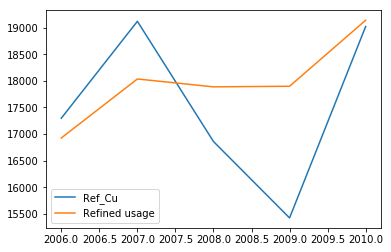

In [204]:
# 1.29,1.29,1.29,1.5,1.3
pd.concat([direct_melt_demand.loc[:,'Ref_Cu'],historical_prod.loc[:,'Refined usage']],axis=1).loc[2006:2010].plot()

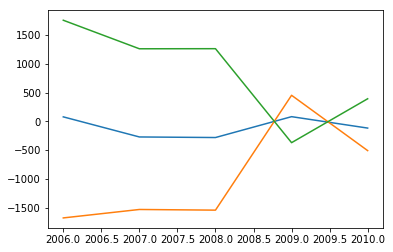

In [213]:
(direct_melt_demand.loc[:,'Ref_Cu']-historical_prod.loc[:,'Refined usage']).loc[2006:2010].plot()
(direct_melt_demand.loc[:,'Ref_Cu']-direct_melt_sectorial_demand.loc[2006:2010,['Unalloyed','Copper brass']].sum(axis=1)).loc[2006:2010].plot()
(direct_melt_sectorial_demand.loc[:,['Unalloyed','Copper brass']].sum(axis=1)-historical_prod.loc[:,'Refined usage']).loc[2006:2010].plot()

In [156]:
pd.concat([direct_melt_demand.loc[:,'Ref_Cu'],total_scrap_demand_all_life,historical_prod.loc[:,'Refined usage']],axis=1).loc[2006:2010]

,Ref_Cu,Direct melt scrap,Refined scrap,Refined usage
2006.0,16926.0,4041.184826,2666.366878,16926.0
2007.0,18036.0,3629.854453,2705.643983,18036.0
2008.0,17888.0,3614.011533,2853.434343,17888.0
2009.0,17899.0,1693.200728,2876.161616,17899.0
2010.0,19141.0,2745.148875,3269.090909,19141.0


## Old blending component

In [ ]:
# Blending to determine demand in the direct melt sector
for year_i in np.arange(1960,2019):
    if fruity_multiplier != 0:
        fruity_alloys.loc[:,'Quantity'] = fruity_multiplier*og_fruity_alloys.loc[:,'Quantity']/direct_melt_sectorial_demand.loc[2018].sum()*direct_melt_sectorial_demand.loc[year_i].sum()
    
    if pir_pcr != 0:
        if year_i > 1960:
            all_scrap_available_cn.loc[year_i,'Al_Bronze':] += alloy_to_scrap_1yr(new_scrap_alloys_cn.loc[year_i-1] - direct_melt_demand_cn.loc[year_i-1, new_scrap_alloys_cn.columns], new_scrap_alloys_compositions)
            all_scrap_available_rw.loc[year_i,'Al_Bronze':] += alloy_to_scrap_1yr(new_scrap_alloys_rw.loc[year_i-1] - direct_melt_demand_rw.loc[year_i-1, new_scrap_alloys_rw.columns], new_scrap_alloys_compositions)
#             all_scrap_available_no_accumulation_cn.loc[year_i,'Al_Bronze':] += alloy_to_scrap_1yr(new_scrap_alloys_cn.loc[year_i-1] - direct_melt_demand_cn.loc[year_i-1, new_scrap_alloys_cn.columns], new_scrap_alloys_compositions)
#             all_scrap_available_no_accumulation_rw.loc[year_i,'Al_Bronze':] += alloy_to_scrap_1yr(new_scrap_alloys_rw.loc[year_i-1] - direct_melt_demand_rw.loc[year_i-1, new_scrap_alloys_rw.columns], new_scrap_alloys_compositions)
#             all_scrap_available_no_accumulation.loc[year_i] = all_scrap_available_no_accumulation_cn.loc[year_i] + all_scrap_available_no_accumulation_rw.loc[year_i]
        new_scrap_alloys_cn_year_i = new_scrap_alloys_compositions.copy().loc[:,'High_Cu':]
        new_scrap_alloys_cn_year_i.loc[:,'Availability'] = new_scrap_alloys_cn.loc[year_i]
        new_scrap_alloys_rw_year_i = new_scrap_alloys_compositions.copy().loc[:,'High_Cu':]
        new_scrap_alloys_rw_year_i.loc[:,'Availability'] = new_scrap_alloys_rw.loc[year_i]
        
    if year_i > 1960:   
#         all_scrap_available.loc[year_i,:] += all_scrap_available.loc[year_i-1,:] - direct_melt_demand.loc[year_i-1,:]
        all_scrap_available_cn.loc[year_i,:] += all_scrap_available_cn.loc[year_i-1,:] - direct_melt_demand_cn.loc[year_i-1,:]
        all_scrap_available_rw.loc[year_i,:] += all_scrap_available_rw.loc[year_i-1,:] - direct_melt_demand_rw.loc[year_i-1,:]
        all_scrap_available.loc[year_i,:] = all_scrap_available_cn.loc[year_i,:] + all_scrap_available_rw.loc[year_i,:] 
    
    if rollover == 1:
        all_scrap_available_year_i = all_scrap_available.loc[year_i]
        all_scrap_available_year_i_cn = all_scrap_available_cn.loc[year_i]
        all_scrap_available_year_i_rw = all_scrap_available_rw.loc[year_i]
    else:
        all_scrap_available_year_i = all_scrap_available_no_accumulation.loc[year_i]
        all_scrap_available_year_i_cn = all_scrap_available_no_accumulation_cn.loc[year_i]
        all_scrap_available_year_i_rw = all_scrap_available_no_accumulation_rw.loc[year_i]
    if year_i < 1973:
        pir_price = 1.09
    else:
        pir_price = pir_price_set
    
    if (year_i == 1960 or slow_change == 0) and fraction_yellows != 0:
        direct_melt_demand_cn.loc[year_i,:], direct_melt_demand_rw.loc[year_i,:], sec_ref_scrap_demand_cn.loc[year_i,:], sec_ref_scrap_demand_rw.loc[year_i,:], fruity_detailed_demand.loc[idx[year_i,:],:], annual_recycled_content.loc[year_i], annual_recycled_volume.loc[year_i] = \
            blend_ff(all_scrap_available_year_i_cn, all_scrap_available_year_i_rw,
                            direct_melt_sectorial_demand_cn.loc[year_i], direct_melt_sectorial_demand_rw.loc[year_i],
                            raw_price_cn.loc[year_i], raw_price_rw.loc[year_i], s2s, prod_spec.copy(), raw_spec, 
                            refined_scrap_demand_cn.loc[year_i], refined_scrap_demand_rw.loc[year_i],
                            historical_prod_cn.loc[year_i,'Refined usage'], historical_prod_rw.loc[year_i,'Refined usage'],
                            fraction_yellows, unalloyed_tune, fruity_alloys, fruity_rr, pir_pcr, pir_fraction,
                            new_scrap_alloys_cn_year_i, new_scrap_alloys_rw_year_i, pir_price = pir_price)
        sec_ref_scrap_demand.loc[year_i,:] = sec_ref_scrap_demand_cn.loc[year_i,:] + sec_ref_scrap_demand_rw.loc[year_i,:]
        fruity_demand.loc[year_i,:] = fruity_detailed_demand.loc[idx[year_i,:],:].sum()

    direct_melt_demand.loc[year_i, :] = direct_melt_demand_cn.loc[year_i, :] + direct_melt_demand_rw.loc[year_i, :] 
    if fraction_yellows == 0:
        direct_melt_demand.loc[year_i,'No.2'] = refined_scrap_demand_cn[year_i] + refined_scrap_demand_rw[year_i]
        direct_melt_demand_cn.loc[year_i,'No.2'] = refined_scrap_demand_cn[year_i]
        direct_melt_demand_rw.loc[year_i,'No.2'] = refined_scrap_demand_rw[year_i]
    if year_i % 1 == 0:
        print(year_i)

# if pir_pcr != 0:
#     all_scrap_available_cn.loc[1961:,'Al_Bronze':] += alloy_to_scrap(new_scrap_alloys_cn, new_scrap_alloys_compositions).loc[1961:]
#     all_scrap_available_rw.loc[1961:,'Al_Bronze':] += alloy_to_scrap(new_scrap_alloys_rw, new_scrap_alloys_compositions).loc[1961:]
#     all_scrap_available = all_scrap_available_cn + all_scrap_available_rw
    
if scrappy == 1:
    total_scrap_demand_all_life=pd.DataFrame({'Direct melt scrap': direct_melt_demand.loc[:,'Yellow_Brass':].sum(axis=1) - refined_scrap_demand, \
                                          'Refined scrap': refined_scrap_demand})
    total_scrap_demand_all_life_cn=pd.DataFrame({'Direct melt scrap': direct_melt_demand_cn.loc[:,'Yellow_Brass':].sum(axis=1) - refined_scrap_demand, \
                                          'Refined scrap': refined_scrap_demand_cn})
    total_scrap_demand_all_life_rw=pd.DataFrame({'Direct melt scrap': direct_melt_demand_rw.loc[:,'Yellow_Brass':].sum(axis=1) - refined_scrap_demand, \
                                          'Refined scrap': refined_scrap_demand_rw})
elif scrappy == 2:
    total_scrap_demand_all_life=pd.DataFrame({'Direct melt scrap': direct_melt_demand.loc[:, scrap_subset].sum(axis=1) - refined_scrap_demand, \
                                              'Refined scrap': refined_scrap_demand})
    total_scrap_demand_all_life_cn=pd.DataFrame({'Direct melt scrap': direct_melt_demand_cn.loc[:, scrap_subset].sum(axis=1) - refined_scrap_demand_cn, \
                                                 'Refined scrap': refined_scrap_demand_cn})
    total_scrap_demand_all_life_rw=pd.DataFrame({'Direct melt scrap': direct_melt_demand_rw.loc[:, scrap_subset].sum(axis=1) - refined_scrap_demand_rw, \
                                                 'Refined scrap': refined_scrap_demand_rw})
else:
    total_scrap_demand_all_life=pd.DataFrame({'Direct melt scrap': direct_melt_demand.sum(axis=1) - refined_scrap_demand, \
                                              'Refined scrap': refined_scrap_demand})
    total_scrap_demand_all_life_cn=pd.DataFrame({'Direct melt scrap': direct_melt_demand_cn.sum(axis=1) - refined_scrap_demand_cn, \
                                                 'Refined scrap': refined_scrap_demand_cn})
    total_scrap_demand_all_life_rw=pd.DataFrame({'Direct melt scrap': direct_melt_demand_rw.sum(axis=1) - refined_scrap_demand_rw, \
                                                 'Refined scrap': refined_scrap_demand_rw})

scrap_use_avail_ratio = direct_melt_demand.loc[:,'Yellow_Brass':]/all_scrap_available.loc[1960:,:]
scrap_use_avail_ratio_cn = direct_melt_demand_cn.loc[:,'Yellow_Brass':]/all_scrap_available_cn.loc[1960:,:]
scrap_use_avail_ratio_rw = direct_melt_demand_rw.loc[:,'Yellow_Brass':]/all_scrap_available_rw.loc[1960:,:]
if 'Low_Brass' in scrap_use_avail_ratio.columns:
    scrap_use_avail_ratio.drop('Low_Brass',axis=1,inplace=True)
    scrap_use_avail_ratio_cn.drop('Low_Brass',axis=1,inplace=True)
    scrap_use_avail_ratio_rw.drop('Low_Brass',axis=1,inplace=True)


print(str(datetime.now()))

## China simulation

In [268]:
print(str(datetime.now()))
mine_life_stats_panel_operating=mine_life_stats_panel_init(simulation_time, operating_mine_pool)
mine_pool_new_last=pd.DataFrame()
mine_life_stats_panel_new_last=pd.DataFrame()
volume_prediction_base=pd.read_excel('Data/semis demand/Demand prediction data.xlsx', sheet_name='All sectors', index_col=0, header=[0,1])
covid = 0
# ut_db = pd.Series(1,np.arange(2018,2041))
%store -r

for year_i in np.arange(2018, 2041):
    
    print(year_i)
    t=pd.datetime(year_i, 1, 1)
    t_lag_1=pd.datetime(year_i-1, 1, 1)
    t_lag_2=pd.datetime(year_i-2, 1, 1)
    
    #### Scenario parameters ####
    sort_eff=sort_eff_series.loc[year_i]
    collect_rate=collect_rate_series.loc[year_i]
    
    #### Price formation ####
    if year_i > 2018:        
        ### Cathode price ###
        cathode_bal_l1.loc[year_i]=ref_prod_series.loc[t_lag_1]-ref_demand_series.loc[t_lag_1]
        print('ref prod: ', ref_prod_series.loc[t_lag_1], ' ref demand: ', ref_demand_series.loc[t_lag_1])
        cathode_price_series.loc[t]=cathode_price_predict(cathode_price_series.loc[t_lag_1], 
                                                          cathode_balance=cathode_bal_l1.loc[year_i], cathode_sd_elas=cathode_sd_elas)

        ### TCRC ###
        conc_bal_l1=conc_prod_series.loc[t_lag_1]-ref_stats.loc[t_lag_1, 'Primary production']/conc_to_cathode_eff
        tcrc_series.loc[t]=tcrc_predict(tcrc_series.loc[t_lag_1], 
                                        conc_balance=conc_bal_l1, conc_sd_elas=conc_sd_elas)
        
        ### Scrap Spreads ###
        if inventory == 1:
            scrap_bal_l1 = all_scrap_available_no_accumulation.sum(axis=1).loc[year_i-1] - total_scrap_demand_all_life.loc[year_i-1].sum() / scrap_bal_correction
            scrap_bal_l1_cn = all_scrap_available_no_accumulation_cn.sum(axis=1).loc[year_i-1] - total_scrap_demand_all_life_cn.loc[year_i-1].sum() / scrap_bal_correction
            scrap_bal_l1_rw = all_scrap_available_no_accumulation_rw.sum(axis=1).loc[year_i-1] - total_scrap_demand_all_life_rw.loc[year_i-1].sum() / scrap_bal_correction
            if scrappy == 2:
                scrap_bal_l1 = all_scrap_available_no_accumulation.loc[year_i-1, scrap_subset].sum() - total_scrap_demand_all_life.loc[year_i-1].sum() / scrap_bal_correction
                scrap_bal_l1_cn = all_scrap_available_no_accumulation_cn.loc[year_i-1, scrap_subset].sum() - total_scrap_demand_all_life_cn.loc[year_i-1].sum() / scrap_bal_correction
                scrap_bal_l1_rw = all_scrap_available_no_accumulation_rw.loc[year_i-1, scrap_subset].sum() - total_scrap_demand_all_life_rw.loc[year_i-1].sum() / scrap_bal_correction
        else:
            scrap_bal_l1 = all_scrap_available.sum(axis=1).loc[year_i-1]-total_scrap_demand_all_life.sum(axis=1).loc[year_i-1]
            scrap_bal_l1_cn = all_scrap_available_cn.sum(axis=1).loc[year_i-1]-total_scrap_demand_all_life_cn.sum(axis=1).loc[year_i-1]
            scrap_bal_l1_rw = all_scrap_available_rw.sum(axis=1).loc[year_i-1]-total_scrap_demand_all_life_rw.sum(axis=1).loc[year_i-1]

        cathode_price_diff=cathode_price_series.loc[t]-cathode_price_series.loc[t_lag_1]
        sp2_series.loc[t]=sp2_predict(sp2_series.loc[t_lag_1], 
                                      scrap_balance=scrap_bal_l1, scrap_sd_elas=sp2_sd_elas, 
                                      cathode_diff=cathode_price_diff, cathode_sp2_elas=cathode_sp2_elas)
        sp2_series_cn.loc[t]=sp2_predict(sp2_series_cn.loc[t_lag_1], 
                                      scrap_balance=scrap_bal_l1_cn, scrap_sd_elas=sp2_sd_elas, 
                                      cathode_diff=cathode_price_diff, cathode_sp2_elas=cathode_sp2_elas)
        sp2_series_rw.loc[t]=sp2_predict(sp2_series_rw.loc[t_lag_1], 
                                      scrap_balance=scrap_bal_l1_rw, scrap_sd_elas=sp2_sd_elas, 
                                      cathode_diff=cathode_price_diff, cathode_sp2_elas=cathode_sp2_elas)
        sp1_series.loc[t]=sp1_predict(sp1_series.loc[t_lag_1],
                                     scrap_balance=scrap_bal_l1, scrap_sd_elas=sp1_sd_elas,
                                     cathode_diff=cathode_price_diff, cathode_sp1_elas=cathode_sp1_elas)
        sp1_series_cn.loc[t]=sp1_predict(sp1_series_cn.loc[t_lag_1],
                                     scrap_balance=scrap_bal_l1_cn, scrap_sd_elas=sp1_sd_elas,
                                     cathode_diff=cathode_price_diff, cathode_sp1_elas=cathode_sp1_elas)
        sp1_series_rw.loc[t]=sp1_predict(sp1_series_rw.loc[t_lag_1],
                                     scrap_balance=scrap_bal_l1_rw, scrap_sd_elas=sp1_sd_elas,
                                     cathode_diff=cathode_price_diff, cathode_sp1_elas=cathode_sp1_elas)
        spa_series.loc[t]=alloy_predict(spa_series.loc[t_lag_1],
                                     scrap_balance=scrap_bal_l1, scrap_sd_elas=alloyed_sd_elas,
                                     cathode_diff=cathode_price_diff, cathode_alloy_elas=cathode_alloyed_elas)
        spa_series_cn.loc[t]=alloy_predict(spa_series_cn.loc[t_lag_1],
                                     scrap_balance=scrap_bal_l1_cn, scrap_sd_elas=alloyed_sd_elas,
                                     cathode_diff=cathode_price_diff, cathode_alloy_elas=cathode_alloyed_elas)
        spa_series_rw.loc[t]=alloy_predict(spa_series_rw.loc[t_lag_1],
                                     scrap_balance=scrap_bal_l1_rw, scrap_sd_elas=alloyed_sd_elas,
                                     cathode_diff=cathode_price_diff, cathode_alloy_elas=cathode_alloyed_elas)
        raw_price.loc[year_i, 'Ref_Cu'] = cathode_price_series.loc[t]
        raw_price_cn.loc[year_i, 'Ref_Cu'] = cathode_price_series.loc[t]
        raw_price_rw.loc[year_i, 'Ref_Cu'] = cathode_price_series.loc[t]
        raw_price.loc[year_i, 'No.1'] = cathode_price_series.loc[t] - sp1_series.loc[t]
        raw_price_cn.loc[year_i, 'No.1'] = cathode_price_series.loc[t] - sp1_series_cn.loc[t]
        raw_price_rw.loc[year_i, 'No.1'] = cathode_price_series.loc[t] - sp1_series_rw.loc[t]
        raw_price.loc[year_i, 'No.2'] = cathode_price_series.loc[t] - sp2_series.loc[t]
        raw_price_cn.loc[year_i, 'No.2'] = cathode_price_series.loc[t] - sp2_series_cn.loc[t]
        raw_price_rw.loc[year_i, 'No.2'] = cathode_price_series.loc[t] - sp2_series_rw.loc[t]
        raw_price.loc[year_i, list(spa_series.columns)] = spa_series.loc[t].apply(lambda x: cathode_price_series.loc[t] - x)
        raw_price_cn.loc[year_i, list(spa_series.columns)] = spa_series_cn.loc[t].apply(lambda x: cathode_price_series.loc[t] - x)
        raw_price_rw.loc[year_i, list(spa_series.columns)] = spa_series_rw.loc[t].apply(lambda x: cathode_price_series.loc[t] - x)
        
        ### Refined (non-Cu) Metal Prices ### assumes they change proportionally to copper price
        raw_price.loc[year_i,ref_metals] = raw_price.loc[year_i-1,ref_metals].apply(lambda x: x + (cathode_price_series[t] - cathode_price_series[t_lag_1]) * x / cathode_price_series[t])
        raw_price_cn.loc[year_i,ref_metals] = raw_price_cn.loc[year_i-1,ref_metals].apply(lambda x: x + (cathode_price_series[t] - cathode_price_series[t_lag_1]) * x / cathode_price_series[t])
        raw_price_rw.loc[year_i,ref_metals] = raw_price_rw.loc[year_i-1,ref_metals].apply(lambda x: x + (cathode_price_series[t] - cathode_price_series[t_lag_1]) * x / cathode_price_series[t])
        
        
    # TCRC to cents per pound
    tcrc_cpp_series = tcrc_series.copy().div(22.0462)

 
    #### Production of operating mine ####
    for mine_id in operating_mine_pool.index:
        mine_data = operating_mine_pool.loc[mine_id]
        mine_life_stats = simulate_mine_life_stats_panel(simulation_time, year_i, 2018, 
                                                         mine_life_stats_panel_operating, mine_data, 
                                                         cathode_price_series, tcrc_cpp_series, pri_hyper_param)
        mine_life_stats_panel_operating.loc[:, idx[mine_id, :]]=mine_life_stats.loc[simulation_time, :].values

    # Total production statistics
    prod_operating=mine_life_stats_panel_operating.loc[:, idx[:, 'Recovered metal production (kt)']].sum(axis=1)
    sxew_operating=mine_life_stats_panel_operating.loc[:, idx[sxew_id_operating, 'Recovered metal production (kt)']].sum(axis=1)
    conc_operating=prod_operating-sxew_operating
    print('Mines closing this year:', (mine_life_stats_panel_operating.loc[t,idx[:,'Ramp flag']] == 'Reclaim').sum())
    
    
    #### Production of new mines ####
    if year_i > 2018:
        # Read subsample size parameter and generate new incentive pool for year_i
        subsample_size=open_parameter.loc[year_i, 'Subsample size']
        mine_pool_new_year_i=new_mine_data(year_i, simulation_end_time, incentive_pool, cathode_price_series, tcrc_cpp_series,
                                           pri_hyper_param, subsample_size, irr_cutoff=0.15)
        print('New mines opening this year: ', mine_pool_new_year_i.shape[0])
      
        # Initialize mine life panel data for incentive pool year_i
        mine_life_stats_panel_new_year_i=mine_life_stats_panel_init(simulation_time, mine_pool_new_year_i)
      
        # Append new incentive pool at year_i
        mine_pool_new=pd.concat([mine_pool_new_last, mine_pool_new_year_i])
        mine_life_stats_panel_new=pd.concat([mine_life_stats_panel_new_last, mine_life_stats_panel_new_year_i], axis=1)
        
        for mine_id in mine_pool_new.index:
            mine_data = mine_pool_new.loc[mine_id]
            mine_life_stats = simulate_mine_life_stats_panel(simulation_time, year_i, mine_data.loc['Initial year'], 
                                                             mine_life_stats_panel_new, mine_data, 
                                                             cathode_price_series, tcrc_cpp_series, pri_hyper_param)
            mine_life_stats_panel_new.loc[:, idx[mine_id, :]]=mine_life_stats.loc[simulation_time, :].values
        
        
        # Total production statistics
        prod_new=mine_life_stats_panel_new.loc[:, idx[:, 'Recovered metal production (kt)']].sum(axis=1)
        sxew_new=mine_life_stats_panel_new.loc[:, idx[sxew_id_new, 'Recovered metal production (kt)']].sum(axis=1)
        conc_new=prod_new-sxew_new
        
        # Update incentive pool info
        mine_pool_new_last=mine_pool_new.copy()
        mine_life_stats_panel_new_last=mine_life_stats_panel_new.copy()

        
    #### Update total mining production ####
    if year_i == 2018:
        conc_new=pd.Series(0, index=simulation_time)
        prod_new=pd.Series(0, index=simulation_time)
        
    conc_prod_series.loc[t]=conc_operating.loc[t]+conc_new.loc[t]
    sxew_all.loc[t]=sxew_operating.loc[t]+sxew_new.loc[t]
    print('Total mining production: ', prod_operating.loc[t]+prod_new.loc[t])
    
    
    #### Demand for refined copper ####
    if year_i == 2018:
        pass
    else:
        intensity_next=intensity_prediction_one_year(year_i, cathode_price_series, gdp_growth_prediction_base, 
                                                     intensity_prediction.loc[year_i-1, :], volume_prediction_base, 
                                                     elas_sec_reg, method='sec and reg')
        intensity_prediction.loc[year_i, :]=intensity_next.values
        # COVID-19
        if covid == 1 and year_i == 2020:
            intensity_ph = intensity_prediction.loc[year_i, :].copy()
            intensity_prediction.loc[year_i, :] *= 0.7
        elif covid == 1 and year_i == 2021:
            intensity_prediction.loc[year_i, :] = intensity_ph.copy()
        demand_prediction.loc[year_i, :]=intensity_prediction.loc[year_i, :].mul(volume_prediction_base.loc[year_i, :]).values
    
    
        
    
    # Demand by shape and refined copper demand - beginning of China separation
    demand_by_sector_cn = demand_prediction.loc[:,idx[:,'China']].groupby(level=0,axis=1).sum()
    demand_by_sector_rw = demand_prediction.groupby(level=0,axis=1).sum() - demand_prediction.loc[:,idx[:,'China']].groupby(level=0,axis=1).sum()
    demand_by_sector = demand_prediction.groupby(level=0,axis=1).sum()
#     demand_by_shape_cn=pd.DataFrame(np.matmul(demand_by_sector_cn, sector_shape_matrix.transpose()), 
#                                  index=demand_by_sector_cn.index, columns=sector_shape_matrix.index)  
    pir_fraction
#     demand_by_shape_rw=pd.DataFrame(np.matmul(demand_by_sector_rw, sector_shape_matrix.transpose()), 
#                                  index=demand_by_sector_rw.index, columns=sector_shape_matrix.index)
    pir_fraction
    demand_by_shape= demand_by_shape_cn + demand_by_shape_rw # pd.DataFrame(np.matmul(demand_by_sector, sector_shape_matrix.transpose()), 
#                                  index=demand_by_sector.index, columns=sector_shape_matrix.index)

    
    if use_Ref_Cu == 1 and year_i > 2018:
        ref_demand_series.loc[t_lag_1]=direct_melt_demand.loc[year_i-1, 'Ref_Cu']
        ref_demand_series_cn.loc[t_lag_1]=direct_melt_demand_cn.loc[year_i-1, 'Ref_Cu'] 
        ref_demand_series_rw.loc[t_lag_1]=direct_melt_demand_rw.loc[year_i-1, 'Ref_Cu']
        ref_demand_series.loc[t_lag_1] = ref_demand_series_cn.loc[t_lag_1] + ref_demand_series_rw.loc[t_lag_1]
    elif year_i > 2018:
#         ref_demand_series.loc[t]=demand_by_shape.loc[year_i, 'Copper']
        ref_demand_series_cn.loc[t]=demand_by_shape_cn.loc[year_i, 'Copper Wire':'Copper Tube'].sum()
        ref_demand_series_rw.loc[t]=demand_by_shape_rw.loc[year_i, 'Copper Wire':'Copper Tube'].sum()
#         ref_demand_series.loc[t_lag_1] = ref_demand_series_cn.loc[t_lag_1] + ref_demand_series_rw.loc[t_lag_1]
        ref_demand_series.loc[t] = ref_demand_series_cn.loc[t] + ref_demand_series_rw.loc[t]

    #### Production of refineries ####
    if year_i == 2018:
        pass
    else:
        ref_bal_l1.loc[year_i] = ref_prod_series.loc[t_lag_1]/ref_demand_series.loc[t_lag_1]
        ref_bal_l1_cn.loc[year_i] = ref_prod_series_cn.loc[t_lag_1]/ref_demand_series_cn.loc[t_lag_1]
        ref_bal_l1_rw.loc[year_i] = ref_prod_series_rw.loc[t_lag_1]/ref_demand_series_rw.loc[t_lag_1]
#         ref_stats_next=simulate_refinery_production_oneyear(year_i, tcrc_series, sp2_series, 
#                                                             ref_demand_series, all_scrap_available_no_accumulation.sum(axis=1), # previously waste_all_life.sum(axis = 1)
#                                                             ref_stats, ref_hyper_param, growth_lag=1)
        ref_stats_next_cn=simulate_refinery_production_oneyear(year_i, tcrc_series, sp2_series_cn, 
                                                            ref_demand_series_cn, all_scrap_available_no_accumulation_cn.sum(axis=1), # previously waste_all_life.sum(axis = 1)
                                                            ref_stats_cn, ref_hyper_param_cn, growth_lag=1,
                                                            ref_bal=ref_bal_l1_cn.loc[year_i], 
                                                            pri_CU_ref_bal_elas = CU_ref_bal_elas,
                                                            sec_CU_ref_bal_elas = CU_ref_bal_elas)        
        ref_stats_next_rw=simulate_refinery_production_oneyear(year_i, tcrc_series, sp2_series_rw, 
                                                            ref_demand_series_rw, all_scrap_available_no_accumulation_rw.sum(axis=1), # previously waste_all_life.sum(axis = 1)
                                                            ref_stats_rw, ref_hyper_param_rw, growth_lag=1,
                                                            ref_bal=ref_bal_l1_rw.loc[year_i], 
                                                            pri_CU_ref_bal_elas = CU_ref_bal_elas,
                                                            sec_CU_ref_bal_elas = CU_ref_bal_elas)
        ref_stats_cn.loc[t, :]=ref_stats_next_cn
        ref_stats_rw.loc[t, :]=ref_stats_next_rw
        ref_stats.loc[t,['Primary capacity', 'Secondary capacity', 'Primary production', 'Secondary production']] = \
           ref_stats_next_cn.loc[['Primary capacity', 'Secondary capacity', 'Primary production', 'Secondary production']] \
           + ref_stats_next_rw.loc[['Primary capacity', 'Secondary capacity', 'Primary production', 'Secondary production']]
    
#     total_ref_prod = ref_stats.loc[t, 'Primary production'] + ref_stats.loc[t, 'Secondary production'] + sxew_all.loc[t]
    total_ref_prod_cn=ref_stats_cn.loc[t, 'Primary production']+ref_stats_cn.loc[t, 'Secondary production']
    total_ref_prod_rw=ref_stats_rw.loc[t, 'Primary production']+ref_stats_rw.loc[t, 'Secondary production']+sxew_all.loc[t]
    total_ref_prod = total_ref_prod_cn + total_ref_prod_rw
    ref_prod_series_cn.loc[t]=total_ref_prod_cn
    ref_prod_series_rw.loc[t]=total_ref_prod_rw
    ref_prod_series.loc[t] = total_ref_prod_cn + total_ref_prod_rw

    
    #### Generation of old scrap ####
    if year_i > 2018:
        # Calculate end use by sector and by product
        use_sector_year_i_cn=demand_by_sector_cn.loc[year_i]
        use_sector_year_i_rw=demand_by_sector_rw.loc[year_i]
#         use_sector_year_i = demand_by_sector.loc[year_i]
        use_product_year_i_cn=pd.Series(np.matmul(use_sector_year_i_cn, sector_to_product.transpose()), 
                                     index=sector_to_product.index)
        use_product_year_i_rw=pd.Series(np.matmul(use_sector_year_i_rw, sector_to_product.transpose()), 
                                     index=sector_to_product.index)
#         use_product_year_i=pd.Series(np.matmul(use_sector_year_i, sector_to_product.transpose()), 
#                                      index=sector_to_product.index)
        use_product_all_life_cn.loc[year_i]=use_product_year_i_cn.values
        use_product_all_life_rw.loc[year_i]=use_product_year_i_rw.values
        use_product_all_life.loc[year_i]=use_product_year_i_cn.values + use_product_year_i_rw.values

        
        # Product reaching end of life and waste collected
        product_eol_year_i_cn = product_reach_eol_oneyear(year_i, use_product_all_life_cn, product_lifetime_freq_df)
        product_eol_year_i_rw = product_reach_eol_oneyear(year_i, use_product_all_life_rw, product_lifetime_freq_df)
        product_eol_year_i = product_eol_year_i_cn + product_eol_year_i_rw
        waste_collected_year_i_cn=waste_collected_oneyear(product_eol_year_i_cn, product_to_waste_collectable, sort_eff, collect_rate)
#         product_eol_year_i = product_reach_eol_oneyear(year_i, use_product_all_life, product_lifetime_freq_df)
#         waste_collected_year_i=waste_collected_oneyear(product_eol_year_i, product_to_waste_collectable, sort_eff, collect_rate)
        waste_collected_year_i_rw=waste_collected_oneyear(product_eol_year_i_rw, product_to_waste_collectable, sort_eff, collect_rate)
        waste_collected_year_i = waste_collected_year_i_cn + waste_collected_year_i_rw
        waste_from_old_future.loc[year_i]=waste_collected_year_i
        waste_from_old_future_cn.loc[year_i]=waste_collected_year_i_cn
        waste_from_old_future_rw.loc[year_i]=waste_collected_year_i_rw
        
        # Old scrap available by scrap type
        old_scrap_available_year_i_cn = old_scrap_gen_oneyear(product_eol_year_i_cn, product_to_waste_collectable, 
                                                           product_to_cathode_alloy, collect_rate_cn, sort_eff_cn, 
                                                           prod_spec, s2s)
        old_scrap_available_year_i_rw = old_scrap_gen_oneyear(product_eol_year_i_rw, product_to_waste_collectable, 
                                                           product_to_cathode_alloy, collect_rate, sort_eff, 
                                                           prod_spec, s2s)
        old_scrap_available_cn.loc[year_i] = old_scrap_available_year_i_cn
        old_scrap_available_rw.loc[year_i] = old_scrap_available_year_i_rw
        old_scrap_available.loc[year_i] = old_scrap_available_year_i_cn + old_scrap_available_year_i_rw

    # Defining this segment earlier than before
    direct_melt_sectorial_demand_cn.loc[year_i, :'Diverse']=(use_product_all_life_cn*product_to_cathode_alloy.loc[:, 'Alloyed']).loc[year_i]
    direct_melt_sectorial_demand_rw.loc[year_i, :'Diverse']=(use_product_all_life_rw*product_to_cathode_alloy.loc[:, 'Alloyed']).loc[year_i]
    direct_melt_sectorial_demand.loc[year_i, :'Diverse']=direct_melt_sectorial_demand_cn.loc[year_i,:'Diverse'] + direct_melt_sectorial_demand_rw.loc[year_i,:'Diverse']

    if year_i > 2018:
        historical_ref_imports_cn.loc[year_i] = historical_ref_imports_cn.loc[year_i-1] * refined_import_rate # (ref_prod_series_cn.loc[t_lag_1] - ref_demand_series_cn.loc[t_lag_1]) * -1.0972

    if include_unalloyed == 1:
        direct_melt_sectorial_demand_cn.loc[year_i,'Unalloyed'] = (use_product_all_life_cn.loc[year_i]*\
                                                                   product_to_cathode_alloy.loc[:, 'Copper']).sum()\
                                                                   - historical_ref_imports_cn.loc[year_i]
        direct_melt_sectorial_demand_rw.loc[year_i,'Unalloyed'] = (use_product_all_life_rw.loc[year_i]*\
                                                                   product_to_cathode_alloy.loc[:, 'Copper']).sum() \
                                                                   + historical_ref_imports_cn.loc[year_i]
        # * copper_brass_mill_fraction
        direct_melt_sectorial_demand.loc[year_i, 'Unalloyed'] = direct_melt_sectorial_demand_cn.loc[year_i,'Unalloyed'] + direct_melt_sectorial_demand_rw.loc[year_i,'Unalloyed']
    elif include_unalloyed != 0:
        
        direct_melt_sectorial_demand_cn.loc[year_i,'Unalloyed'] = (use_product_all_life_cn.loc[year_i]*\
                                                                   product_to_copper_alloy.loc[:, 'Copper']).sum()\
                                                                   - historical_ref_imports_cn.loc[year_i]*(1-fraction_unalloyed_brass)
        direct_melt_sectorial_demand_rw.loc[year_i,'Unalloyed'] = (use_product_all_life_rw.loc[year_i]*\
                                                                   product_to_copper_alloy.loc[:, 'Copper']).sum() \
                                                                   + historical_ref_imports_cn.loc[year_i]*(1-fraction_unalloyed_brass)
        direct_melt_sectorial_demand_cn.loc[year_i,'Copper brass'] = (use_product_all_life_cn.loc[year_i]*\
                                                                   product_to_copper_alloy.loc[:, 'Copper brass']).sum()\
                                                                   - historical_ref_imports_cn.loc[year_i]*fraction_unalloyed_brass
        direct_melt_sectorial_demand_rw.loc[year_i,'Copper brass'] = (use_product_all_life_rw.loc[year_i]*\
                                                                   product_to_copper_alloy.loc[:, 'Copper brass']).sum() \
                                                                   + historical_ref_imports_cn.loc[year_i]*fraction_unalloyed_brass
        # * copper_brass_mill_fraction
        direct_melt_sectorial_demand.loc[year_i, 'Unalloyed'] = direct_melt_sectorial_demand_cn.loc[year_i,'Unalloyed'] + direct_melt_sectorial_demand_rw.loc[year_i,'Unalloyed']
        
        # * copper_brass_mill_fraction
        direct_melt_sectorial_demand.loc[year_i, 'Copper brass'] = direct_melt_sectorial_demand_cn.loc[year_i,'Copper brass'] + direct_melt_sectorial_demand_rw.loc[year_i,'Copper brass']
    
    #### Generation of new scrap ####
    if year_i > 2018:
        home_scrap_ratio=home_scrap_ratio_series.loc[year_i]
        exchange_scrap_ratio=exchange_scrap_ratio_series.loc[year_i]
        waste_from_new_year_i_cn=\
        simulate_new_scrap_one_year(year_i, use_product_all_life_cn, new_scrap_gen, product_to_waste_no_loss, sort_eff,\
                                    home_scrap_ratio, exchange_scrap_ratio)
        waste_from_new_year_i_rw=\
        simulate_new_scrap_one_year(year_i, use_product_all_life_rw, new_scrap_gen, product_to_waste_no_loss, sort_eff,\
                                    home_scrap_ratio, exchange_scrap_ratio)
        waste_from_new_future_cn.loc[year_i]=waste_from_new_year_i_cn
        waste_from_new_future_rw.loc[year_i]=waste_from_new_year_i_rw
        waste_from_new_future.loc[year_i] = waste_from_new_year_i_cn + waste_from_new_year_i_rw
    
        # New scrap available by scrap type
        if pir_pcr == 0:
            new_scrap_available_year_i_cn = \
            new_scrap_gen_oneyear(use_product_all_life_cn.loc[year_i], product_to_waste_no_loss, product_to_cathode_alloy, 
                                  collect_rate_cn, sort_eff_cn, prod_spec.copy(), s2s, new_scrap_gen_cn, exchange_scrap_ratio, 
                                  home_scrap_ratio, fraction_no1_new)
            new_scrap_available_year_i_rw = \
            new_scrap_gen_oneyear(use_product_all_life_rw.loc[year_i], product_to_waste_no_loss, product_to_cathode_alloy, 
                                  collect_rate, sort_eff, prod_spec.copy(), s2s, new_scrap_gen, exchange_scrap_ratio, 
                                  home_scrap_ratio, fraction_no1_new)
        else:
            if fruity_multiplier != 0:
                fruity_alloyed.loc[:,'Quantity'] = fruity_multiplier*og_fruity_alloyed.loc[:,'Quantity']/direct_melt_sectorial_demand.loc[2018].sum()*direct_melt_sectorial_demand.loc[year_i].sum()
            new_scrap_available_year_i_cn, new_scrap_alloys_cn_year_i = \
            new_scrap_gen_oneyear(use_product_all_life_cn.loc[year_i], product_to_waste_no_loss, product_to_cathode_alloy, 
                                  collect_rate_cn, sort_eff_cn, prod_spec.copy(), s2s, new_scrap_gen_cn, exchange_scrap_ratio, 
                                  home_scrap_ratio, fraction_no1_new, pir_pcr, fruity_alloyed)
            new_scrap_available_year_i_rw, new_scrap_alloys_rw_year_i = \
            new_scrap_gen_oneyear(use_product_all_life_rw.loc[year_i], product_to_waste_no_loss, product_to_cathode_alloy, 
                                  collect_rate, sort_eff, prod_spec.copy(), s2s, new_scrap_gen, exchange_scrap_ratio, 
                                  home_scrap_ratio, fraction_no1_new, 2, fruity_alloyed)
        new_scrap_available_cn.loc[year_i] = new_scrap_available_year_i_cn
        new_scrap_available_rw.loc[year_i] = new_scrap_available_year_i_rw
        new_scrap_available.loc[year_i] = new_scrap_available_year_i_cn + new_scrap_available_year_i_rw
        if pir_pcr != 0:
            new_scrap_alloys_cn.loc[year_i] = new_scrap_alloys_cn_year_i.loc[:,'Availability']
            new_scrap_alloys_rw.loc[year_i] = new_scrap_alloys_rw_year_i.loc[:,'Availability']
            new_scrap_alloys_compositions = new_scrap_alloys_cn_year_i.loc[:,:'Low_Fe']
        else:
            new_scrap_alloys_cn = 0
            new_scrap_alloys_rw = 0
            new_scrap_alloys_compositions = 0
            
        # All scrap
        waste_all_life_cn.loc[year_i]=waste_from_new_year_i_cn+waste_collected_year_i_cn
        waste_all_life_rw.loc[year_i]=waste_from_new_year_i_rw+waste_collected_year_i_rw
        waste_all_life.loc[year_i] = waste_all_life_cn.loc[year_i] + waste_all_life_rw.loc[year_i]
        all_scrap_available_cn.loc[year_i] = old_scrap_available_year_i_cn + new_scrap_available_year_i_cn
        all_scrap_available_rw.loc[year_i] = old_scrap_available_year_i_rw + new_scrap_available_year_i_rw
        all_scrap_available.loc[year_i] = all_scrap_available_cn.loc[year_i] + all_scrap_available_rw.loc[year_i]
        waste_all_life_cn.loc[year_i] += waste_imports_cn_all.loc[year_i]
        waste_all_life_rw.loc[year_i] -= waste_imports_cn_all.loc[year_i]
        all_scrap_available_cn.loc[year_i] += scrap_imports_cn_all.loc[year_i]
        all_scrap_available_rw.loc[year_i] -= scrap_imports_cn_all.loc[year_i]

        total_unalloyed_year_i_cn = all_scrap_available_cn.loc[year_i,'No.1':'No.2'].sum()
        total_unalloyed_year_i_rw = all_scrap_available_rw.loc[year_i,'No.1':'No.2'].sum()
        total_unalloyed_year_i = all_scrap_available.loc[year_i,'No.1':'No.2'].sum()
        
    print('Total scrap supply, China: ', all_scrap_available_cn.sum(axis=1).loc[year_i])
    print('Total scrap supply, RoW: ', all_scrap_available_rw.sum(axis=1).loc[year_i])
    
    # Calculating No.2 demand
    if year_i > 2018: 
        if use_new_recovery == 0:
            refined_scrap_demand_year_i_cn=ref_stats_cn.loc[t, 'Secondary production']/scrap_to_cathode_eff
#             if refined_scrap_demand_year_i_cn < total_unalloyed_year_i_cn:
            all_scrap_available_cn.loc[year_i, 'No.1'] = total_unalloyed_year_i_cn - refined_scrap_demand_year_i_cn * 0.85
            all_scrap_available_cn.loc[year_i, 'No.2'] = refined_scrap_demand_year_i_cn * 0.85
#             else:
#                 no1_fraction = 0.5
#                 print('Too much refined scrap demand, China:', year_i)
#                 all_scrap_available_cn.loc[year_i, 'No.1'] = total_unalloyed_year_i_cn * no1_fraction
#                 all_scrap_available_cn.loc[year_i, 'No.2'] = total_unalloyed_year_i_cn * (1 - no1_fraction)

            refined_scrap_demand_year_i_rw=ref_stats_rw.loc[t, 'Secondary production']/scrap_to_cathode_eff
#             if refined_scrap_demand_year_i_rw < total_unalloyed_year_i_rw:
            all_scrap_available_rw.loc[year_i, 'No.1'] = total_unalloyed_year_i_rw - refined_scrap_demand_year_i_rw * 0.85
            all_scrap_available_rw.loc[year_i, 'No.2'] = refined_scrap_demand_year_i_rw * 0.85
#             else:
#                 no1_fraction = 0.5
#                 print('Too much refined scrap demand, RoW:', year_i)
#                 all_scrap_available_rw.loc[year_i, 'No.1'] = total_unalloyed_year_i_rw * no1_fraction
#                 all_scrap_available_rw.loc[year_i, 'No.2'] = total_unalloyed_year_i_rw * (1 - no1_fraction)

            refined_scrap_demand_year_i = refined_scrap_demand_year_i_cn + refined_scrap_demand_year_i_rw # ref_stats.loc[t, 'Secondary production']/scrap_to_cathode_eff
            if refined_scrap_demand_year_i < total_unalloyed_year_i:
                all_scrap_available.loc[year_i, 'No.1'] = total_unalloyed_year_i - refined_scrap_demand_year_i * 0.85
                all_scrap_available.loc[year_i, 'No.2'] = refined_scrap_demand_year_i * 0.85
            else:
                no1_fraction = 0.5
                print('Too much refined scrap demand, Global:', year_i)
                all_scrap_available.loc[year_i, 'No.1'] = total_unalloyed_year_i * no1_fraction
                all_scrap_available.loc[year_i, 'No.2'] = total_unalloyed_year_i * (1 - no1_fraction)
        
        if fruity_multiplier != 0:
            fruity_alloys.loc[:,'Quantity'] = fruity_multiplier*og_fruity_alloys.loc[:,'Quantity']/direct_melt_sectorial_demand.loc[2018].sum()*direct_melt_sectorial_demand.loc[year_i].sum()

        all_scrap_available_no_accumulation.loc[year_i] = all_scrap_available.loc[year_i].copy()
        all_scrap_available.loc[year_i,:] += all_scrap_available.loc[year_i-1,:] - direct_melt_demand.loc[year_i-1,:]
        all_scrap_available_no_accumulation_cn.loc[year_i] = all_scrap_available_cn.loc[year_i].copy()
        all_scrap_available_cn.loc[year_i,:] += all_scrap_available_cn.loc[year_i-1,:] - direct_melt_demand_cn.loc[year_i-1,:]
        all_scrap_available_no_accumulation_rw.loc[year_i] = all_scrap_available_rw.loc[year_i].copy()
        all_scrap_available_rw.loc[year_i,:] += all_scrap_available_rw.loc[year_i-1,:] - direct_melt_demand_rw.loc[year_i-1,:]
        
        if pir_pcr != 0: # removing the new scrap that was generated from the full scrap pool and adding the unused new scrap from last year as old scrap
            all_scrap_available_cn.loc[year_i,'Al_Bronze':] -= alloy_to_scrap_1yr(new_scrap_alloys_cn.loc[year_i], new_scrap_alloys_compositions)
            all_scrap_available_rw.loc[year_i,'Al_Bronze':] -= alloy_to_scrap_1yr(new_scrap_alloys_rw.loc[year_i], new_scrap_alloys_compositions)
            all_scrap_available_cn.loc[year_i,'Al_Bronze':] += alloy_to_scrap_1yr(new_scrap_alloys_cn.loc[year_i-1] - direct_melt_demand_cn.loc[year_i-1, new_scrap_alloys_cn.columns], new_scrap_alloys_compositions)
            all_scrap_available_rw.loc[year_i,'Al_Bronze':] += alloy_to_scrap_1yr(new_scrap_alloys_rw.loc[year_i-1] - direct_melt_demand_rw.loc[year_i-1, new_scrap_alloys_rw.columns], new_scrap_alloys_compositions)
            
            new_scrap_alloys_cn_year_i = new_scrap_alloys_compositions.copy().loc[:,'High_Cu':]
            new_scrap_alloys_cn_year_i.loc[:,'Availability'] = new_scrap_alloys_cn.loc[year_i]
            new_scrap_alloys_rw_year_i = new_scrap_alloys_compositions.copy().loc[:,'High_Cu':]
            new_scrap_alloys_rw_year_i.loc[:,'Availability'] = new_scrap_alloys_rw.loc[year_i]
            
    if rollover == 1:
        all_scrap_available_year_i_cn = all_scrap_available_cn.loc[year_i]
        all_scrap_available_year_i_rw = all_scrap_available_rw.loc[year_i]
    else:
        all_scrap_available_year_i_cn = all_scrap_available_no_accumulation_cn.loc[year_i]
        all_scrap_available_year_i_rw = all_scrap_available_no_accumulation_rw.loc[year_i]
        
    # Scrap price collation
    
    if year_i > 2018:
        if fruity_multiplier != 0:
            fruity_alloys.loc[:,'Quantity'] = fruity_multiplier*og_fruity_alloys.loc[:,'Quantity']/direct_melt_sectorial_demand.loc[2018].sum()*direct_melt_sectorial_demand.loc[year_i].sum()
        #### Demand of scrap
        refined_scrap_demand_year_i_cn=ref_stats_cn.loc[t, 'Secondary production']/scrap_to_cathode_eff
        refined_scrap_demand_year_i_rw=ref_stats_rw.loc[t, 'Secondary production']/scrap_to_cathode_eff
    #     refined_scrap_demand_year_i=ref_stats.loc[t, 'Secondary production']/scrap_to_cathode_eff
        refined_scrap_demand_year_i = refined_scrap_demand_year_i_cn + refined_scrap_demand_year_i_rw
        direct_melt_scrap_demand_year_i_cn=use_product_all_life_cn.mul(product_to_cathode_alloy.loc[:, 'Alloyed']).loc[year_i]
        direct_melt_scrap_demand_year_i_rw=use_product_all_life_rw.mul(product_to_cathode_alloy.loc[:, 'Alloyed']).loc[year_i]
    #     direct_melt_scrap_demand_year_i=use_product_all_life.mul(product_to_cathode_alloy.loc[:, 'Alloyed']).loc[year_i]
        direct_melt_scrap_demand_year_i = direct_melt_scrap_demand_year_i_cn + direct_melt_scrap_demand_year_i_rw
        
        if slow_change == 0 and fraction_yellows != 0:
            error = 1e6
            p = 0
            unalloyed_tune = 1.29
#             while abs(error) > 100:
            while p == 0:
                direct_melt_demand_cn.loc[year_i,:], direct_melt_demand_rw.loc[year_i,:], sec_ref_scrap_demand_cn.loc[year_i,:], sec_ref_scrap_demand_rw.loc[year_i,:], fruity_d, rc, rcv = \
                pd.Series(blend_demand(all_scrap_available_year_i_cn, all_scrap_available_year_i_rw,
                                direct_melt_sectorial_demand_cn.loc[year_i], direct_melt_sectorial_demand_rw.loc[year_i],
                                raw_price_cn.loc[year_i], raw_price_rw.loc[year_i], s2s, prod_spec.copy(), raw_spec, 
                                refined_scrap_demand_year_i_cn, refined_scrap_demand_year_i_rw,
                                direct_melt_sectorial_demand_cn.loc[year_i,['Unalloyed','Copper brass']].sum(), direct_melt_sectorial_demand_rw.loc[year_i,['Unalloyed','Copper brass']].sum(),
                                fraction_yellows, unalloyed_tune, fruity_alloys, fruity_rr, pir_pcr, pir_fraction,
                                new_scrap_alloys_cn_year_i, new_scrap_alloys_rw_year_i))
    #             direct_melt_demand_rw.loc[year_i,:], sec_ref_scrap_demand_rw.loc[year_i,:] = pd.Series(blend(all_scrap_available_year_i_rw,
    #                                             direct_melt_sectorial_demand_rw.loc[year_i], raw_price_rw.loc[year_i,:], s2s, 
    #                                             prod_spec.copy(), raw_spec, refined_scrap_demand_year_i_rw,
    # #                                             demand_by_shape_rw.loc[year_i, 'Copper'], fraction_yellows, unalloyed_tune))
    #                                             direct_melt_sectorial_demand_rw.loc[year_i,'Unalloyed'], 
    #                                             fraction_yellows, unalloyed_tune))
                sec_ref_scrap_demand.loc[year_i,:] = sec_ref_scrap_demand_cn.loc[year_i,:] + sec_ref_scrap_demand_rw.loc[year_i,:]
                direct_melt_demand.loc[year_i,:] = direct_melt_demand_cn.loc[year_i,:] + direct_melt_demand_rw.loc[year_i,:]

                ut_db.loc[year_i] = unalloyed_tune
                p += 1
                error = direct_melt_demand.loc[year_i,'Ref_Cu'] - direct_melt_sectorial_demand.loc[year_i,['Unalloyed','Copper brass']].sum()
                ut_old = unalloyed_tune
                if error > 1000:
                    unalloyed_tune /= 1.05#abs(error)/5000
                elif error < -1000:
                    unalloyed_tune *= 1.08#abs(error)/5000 # decreasing alloy_tune makes scrap cheaper and decreases Ref_Cu
                elif error > 0:
                    unalloyed_tune /= 1.005#abs(error)/5000
                elif error < 0:
                    unalloyed_tune *= 1.008#abs(error)/5000
                print('Pass',p,': Ref_Cu exceeds historical by',round(error,0),'kt.\n\tOld tune:',round(ut_old,3),'\tNew tune:',round(unalloyed_tune,3))

        elif slow_change == 0:
            direct_melt_demand_cn.loc[year_i,:], direct_melt_demand_rw.loc[year_i,:] = pd.Series(blend_ff(
                all_scrap_available_year_i_cn, all_scrap_available_year_i_rw,
                direct_melt_sectorial_demand_cn.loc[year_i], direct_melt_sectorial_demand_rw.loc[year_i],
                raw_price_cn.loc[year_i,:], raw_price_rw.loc[year_i,:], s2s, prod_spec.copy(), raw_spec,
#                                                             ref_demand = demand_by_shape_cn.loc[year_i, 'Copper']))
                ref_demand_cn = direct_melt_sectorial_demand_cn.loc[year_i,'Unalloyed'],
                ref_demand_rw = direct_melt_sectorial_demand_rw.loc[year_i,'Unalloyed'],
                fruity_alloys = fruity_alloys))
#             direct_melt_demand_rw.loc[year_i,:] = pd.Series(blend(all_scrap_available_year_i_rw, 
#                                                            direct_melt_sectorial_demand_rw.loc[year_i], 
#                                                            raw_price_rw.loc[year_i,:], s2s, prod_spec.copy(), raw_spec,
# #                                                             ref_demand = demand_by_shape_rw.loc[year_i, 'Copper'],
#                                                             ref_demand = direct_melt_sectorial_demand_rw.loc[year_i,'Unalloyed']))
            direct_melt_demand.loc[year_i,:] = direct_melt_demand_cn.loc[year_i,:] + direct_melt_demand_rw.loc[year_i,:]
        
        else:
            direct_melt_demand_cn.loc[year_i,:] = pd.Series(blend(all_scrap_available_year_i_cn, 
                                                           direct_melt_sectorial_demand_cn.loc[year_i], 
                                                           raw_price_cn.loc[year_i,:], s2s, prod_spec.copy(), raw_spec,
                                                           refined_scrap_demand_cn.loc[year_i], ref_prod_history_cn.loc[year_i,'Refined usage'],
                                                           fraction_yellows, unalloyed_tune, direct_melt_demand_cn.loc[year_i-1]))
            direct_melt_demand_rw.loc[year_i,:] = pd.Series(blend(all_scrap_available_year_i_rw, 
                                                           direct_melt_sectorial_demand_rw.loc[year_i], 
                                                           raw_price_rw.loc[year_i,:], s2s, prod_spec.copy(), raw_spec,
                                                           refined_scrap_demand_rw.loc[year_i], ref_prod_history_rw.loc[year_i,'Refined usage'],
                                                           fraction_yellows, unalloyed_tune, direct_melt_demand_rw.loc[year_i-1]))
            direct_melt_demand.loc[year_i,:] = direct_melt_demand_cn.loc[year_i,:] + direct_melt_demand_rw.loc[year_i,:]
        
#         direct_melt_demand_cn.loc[year_i, 'Ref_Cu'] += (use_product_all_life_cn.loc[year_i]*
#                                                      product_to_cathode_alloy.loc[:, 'Copper']).sum()*wire_mill_fraction -
#                                                      historical_ref_imports_cn.loc[year_i]
#         direct_melt_demand_cn.loc[year_i, 'Ref_Cu'] += (use_product_all_life_rw.loc[year_i]*
#                                                      product_to_cathode_alloy.loc[:, 'Copper']).sum()*wire_mill_fraction +
#                                                      historical_ref_imports_cn.loc[year_i]
        if direct_melt_demand_cn.loc[year_i,'Ref_Cu'] < (use_product_all_life_cn.loc[year_i]*product_to_cathode_alloy.loc[:, 'Copper']).sum()*wire_mill_fraction - historical_ref_imports_cn.loc[year_i]:
            print('CN too little Ref_Cu demand', year_i)
        if direct_melt_demand_rw.loc[year_i,'Ref_Cu'] < (use_product_all_life_rw.loc[year_i]*product_to_cathode_alloy.loc[:, 'Copper']).sum()*wire_mill_fraction + historical_ref_imports_cn.loc[year_i]:
            print('RoW too little Ref_Cu demand', year_i)
        
        print('Total direct melt scrap demand, China: ', direct_melt_demand_cn.sum(axis=1).loc[year_i])
        print('Total direct melt scrap demand, RoW: ', direct_melt_demand_rw.sum(axis=1).loc[year_i])
        if scrappy == 1:# or scrappy == 2:
            total_scrap_demand_all_life_cn.loc[year_i, 'Direct melt scrap'] = direct_melt_demand_cn.loc[year_i,'Yellow_Brass':'No.1'].sum() #direct_melt_scrap_demand_year_i.sum()
            total_scrap_demand_all_life_rw.loc[year_i, 'Direct melt scrap'] = direct_melt_demand_rw.loc[year_i,'Yellow_Brass':'No.1'].sum() #direct_melt_scrap_demand_year_i.sum()
            total_scrap_demand_all_life.loc[year_i, 'Direct melt scrap'] = total_scrap_demand_all_life_cn.loc[year_i, 'Direct melt scrap'] + total_scrap_demand_all_life_rw.loc[year_i, 'Direct melt scrap']
        elif scrappy == 2:
            total_scrap_demand_all_life_cn.loc[year_i, 'Direct melt scrap'] = direct_melt_demand_cn.loc[year_i, scrap_subset].sum() #direct_melt_scrap_demand_year_i.sum()
            total_scrap_demand_all_life_rw.loc[year_i, 'Direct melt scrap'] = direct_melt_demand_rw.loc[year_i, scrap_subset].sum() #direct_melt_scrap_demand_year_i.sum()
            total_scrap_demand_all_life.loc[year_i, 'Direct melt scrap'] = total_scrap_demand_all_life_cn.loc[year_i, 'Direct melt scrap'] + total_scrap_demand_all_life_rw.loc[year_i, 'Direct melt scrap']
        else:
            total_scrap_demand_all_life_cn.loc[year_i, 'Direct melt scrap'] = direct_melt_scrap_demand_year_i_cn.sum()
            total_scrap_demand_all_life_rw.loc[year_i, 'Direct melt scrap'] = direct_melt_scrap_demand_year_i_rw.sum()
            total_scrap_demand_all_life.loc[year_i, 'Direct melt scrap'] = total_scrap_demand_all_life_cn.loc[year_i, 'Direct melt scrap'] + total_scrap_demand_all_life_rw.loc[year_i, 'Direct melt scrap']

        total_scrap_demand_all_life_cn.loc[year_i, 'Refined scrap']=refined_scrap_demand_year_i_cn
        total_scrap_demand_all_life_rw.loc[year_i, 'Refined scrap']=refined_scrap_demand_year_i_rw
        total_scrap_demand_all_life.loc[year_i, 'Refined scrap'] = refined_scrap_demand_year_i_cn + refined_scrap_demand_year_i_rw

        # Correcting for non-No.2 scraps consumed by secondary refineries
        if fraction_yellows != 0 and scrappy == 1:
            total_scrap_demand_all_life_cn.loc[year_i,'Direct melt scrap'] = direct_melt_demand_cn.loc[year_i, 'Yellow_Brass':].sum() - sec_ref_scrap_demand_cn.loc[year_i, 'Yellow_Brass':].sum()
            total_scrap_demand_all_life_rw.loc[year_i,'Direct melt scrap'] = direct_melt_demand_rw.loc[year_i, 'Yellow_Brass':].sum() - sec_ref_scrap_demand_rw.loc[year_i, 'Yellow_Brass':].sum()
            total_scrap_demand_all_life.loc[year_i,'Direct melt scrap'] = total_scrap_demand_all_life_cn.loc[year_i,'Direct melt scrap'] + total_scrap_demand_all_life_rw.loc[year_i,'Direct melt scrap']
        elif fraction_yellows != 0 and scrappy == 2:
            total_scrap_demand_all_life_cn.loc[year_i,'Direct melt scrap'] = (direct_melt_demand_cn.loc[year_i,:] - sec_ref_scrap_demand_cn.loc[year_i, :]).loc[scrap_subset].sum()
            total_scrap_demand_all_life_cn.loc[year_i,'Refined scrap'] = sec_ref_scrap_demand_cn.loc[year_i,scrap_subset].sum()
            total_scrap_demand_all_life_rw.loc[year_i,'Direct melt scrap'] = (direct_melt_demand_rw.loc[year_i,:] - sec_ref_scrap_demand_rw.loc[year_i, :]).loc[scrap_subset].sum()
            total_scrap_demand_all_life_rw.loc[year_i,'Refined scrap'] = sec_ref_scrap_demand_rw.loc[year_i,scrap_subset].sum()
            total_scrap_demand_all_life.loc[year_i,'Direct melt scrap'] = total_scrap_demand_all_life_cn.loc[year_i,'Direct melt scrap'] + total_scrap_demand_all_life_rw.loc[year_i,'Direct melt scrap']
            total_scrap_demand_all_life.loc[year_i,'Refined scrap'] = total_scrap_demand_all_life_cn.loc[year_i,'Refined scrap'] + total_scrap_demand_all_life_rw.loc[year_i,'Refined scrap']
        elif fraction_yellows != 0:
            total_scrap_demand_all_life_cn.loc[year_i,'Direct melt scrap'] = direct_melt_demand_cn.loc[year_i, :].sum() - sec_ref_scrap_demand_cn.loc[year_i,:].sum()
            total_scrap_demand_all_life_rw.loc[year_i,'Direct melt scrap'] = direct_melt_demand_rw.loc[year_i, :].sum() - sec_ref_scrap_demand_rw.loc[year_i,:].sum()
            total_scrap_demand_all_life.loc[year_i,'Direct melt scrap'] = total_scrap_demand_all_life_cn.loc[year_i,'Direct melt scrap'] + total_scrap_demand_all_life_rw.loc[year_i,'Direct melt scrap']
            
        total_secondary_demand_all_life_cn.loc[year_i, 'Direct melt scrap'] = direct_melt_demand_cn.loc[year_i,:].sum()
        total_secondary_demand_all_life_rw.loc[year_i, 'Direct melt scrap'] = direct_melt_demand_rw.loc[year_i,:].sum()
        total_secondary_demand_all_life.loc[year_i, 'Direct melt scrap'] = direct_melt_demand_cn.loc[year_i,:].sum() + direct_melt_demand_rw.loc[year_i,:].sum()

        total_secondary_demand_all_life_cn.loc[year_i, 'Refined scrap'] = refined_scrap_demand_year_i_cn
        total_secondary_demand_all_life_rw.loc[year_i, 'Refined scrap'] = refined_scrap_demand_year_i_rw
        total_secondary_demand_all_life.loc[year_i, 'Refined scrap'] = refined_scrap_demand_year_i_cn + refined_scrap_demand_year_i_rw

        if fraction_yellows == 0:
            direct_melt_demand_cn.loc[year_i,'No.2'] = refined_scrap_demand_year_i_cn
            direct_melt_demand_rw.loc[year_i,'No.2'] = refined_scrap_demand_year_i_rw
            direct_melt_demand.loc[year_i,'No.2'] = refined_scrap_demand_year_i_cn + refined_scrap_demand_year_i_rw

    if use_Ref_Cu == 1:
        ref_demand_series_cn.loc[t]=direct_melt_demand_cn.loc[year_i, 'Ref_Cu']
        ref_demand_series_rw.loc[t]=direct_melt_demand_rw.loc[year_i, 'Ref_Cu']
        ref_demand_series.loc[t] = ref_demand_series_cn.loc[t] + ref_demand_series_rw.loc[t]

    if pir_pcr != 0:
        all_scrap_available_cn.loc[year_i,'Al_Bronze':] += alloy_to_scrap_1yr(new_scrap_alloys_cn.loc[year_i], new_scrap_alloys_compositions)
        all_scrap_available_rw.loc[year_i,'Al_Bronze':] += alloy_to_scrap_1yr(new_scrap_alloys_rw.loc[year_i], new_scrap_alloys_compositions)
        all_scrap_available = all_scrap_available_cn + all_scrap_available_rw
    
if 'Low_Brass' in all_scrap_available.columns:
    all_scrap_available.drop('Low_Brass', axis=1, inplace = True)
if 'Low_Brass' in all_scrap_available_cn.columns:
    all_scrap_available_cn.drop('Low_Brass', axis=1, inplace = True)
if 'Low_Brass' in all_scrap_available_rw.columns:
    all_scrap_available_rw.drop('Low_Brass', axis=1, inplace = True)
print(str(datetime.now()))

2021-01-27 13:52:00.338227
2018
Mines closing this year: 0
Total mining production:  20530.901667342747
Total scrap supply, China:  22674.98897610571
Total scrap supply, RoW:  80604.50728008174
2019
ref prod:  23794.411933034047  ref demand:  24216.0
Mines closing this year: 73
New mines opening this year:  149
Total mining production:  20306.071623983597
Total scrap supply, China:  3431.170083788443
Total scrap supply, RoW:  6491.097672006239
Pass 1 : Ref_Cu exceeds historical by 0.0 kt.
	Old tune: 1.29 	New tune: 1.29
Total direct melt scrap demand, China:  17066.099543695138
Total direct melt scrap demand, RoW:  19116.219429978493
2020
ref prod:  24831.491641623565  ref demand:  24681.15404402784
Mines closing this year: 9
New mines opening this year:  0
Total mining production:  21241.232314892266
Total scrap supply, China:  3578.721082711509
Total scrap supply, RoW:  6509.299645614038
Pass 1 : Ref_Cu exceeds historical by 0.0 kt.
	Old tune: 1.29 	New tune: 1.284
Total direct melt 

GurobiError: Unable to retrieve attribute 'x'

In [276]:
ut_db
pd.concat([direct_melt_demand.loc[2015:2028,['Ref_Cu','No.1','No.2']],direct_melt_demand_cn.loc[2015:2028,['Ref_Cu','No.1','No.2']],direct_melt_demand_rw.loc[2015:2028,['Ref_Cu','No.1','No.2']]],axis=1,keys=['global','china','row'])
# refined_scrap_demand_year_i_cn, total_unalloyed_year_i_cn
# direct_melt_sectorial_demand_cn.loc[2018:]
all_scrap_available_cn.loc[2018:]

,No.1,No.2,Al_Bronze,Cartridge,Mn_Bronze,Ni_Ag,Ocean,Pb_Sn_Bronze,Pb_Yellow_Brass,Red_Brass,Sn_Bronze,Yellow_Brass
2018,16094.309523,3740.832731,206.161,395.675,27.5973,249.614,169.088,160.11,1074.16,83.3716,335.012,354.216
2019,16797.969869,3900.687413,215.291,470.886,20.2145,281.697,179.367,167.971,1122.59,95.9483,387.03,401.755
2020,17437.081027,4508.060906,115.159,255.13,12.6203,206.801,115.515,163.459,1203.58,55.9233,439.629,204.616
2021,17999.123986,4790.969777,116.421,275.259,22.5257,143.624,118.586,103.38,1285.65,49.1271,457.985,209.839
2022,18530.758191,4926.288104,147.99,275.385,13.8199,153.47,121.487,97.867,1369.41,60.942,400.928,238.585
2023,18996.588344,5170.538311,110.751,233.83,22.3924,109.844,104.761,78.473,1403.75,41.387,195.666,183.88
2024,19168.345782,5168.728513,140.414,302.764,13.5396,167.821,130.006,95.6779,1511.07,56.0699,120.611,235.178
2025,19392.612017,5197.876128,142.694,298.137,14.0862,158.815,131.592,113.439,1601.42,47.6529,121.655,242.375
2026,19468.929578,5208.899272,144.992,308.159,14.6507,161.41,135.563,104.959,1705.79,49.419,122.898,252.316
2027,20689.109199,3908.151755,150.522,317.666,15.2043,169.243,140.932,108.281,1801.32,51.1286,123.948,262.165


In [260]:
ut_db
all_scrap_available_no_accumulation_rw.loc[2018:]

,No.1,No.2,Al_Bronze,Cartridge,Mn_Bronze,Ni_Ag,Ocean,Pb_Sn_Bronze,Pb_Yellow_Brass,Red_Brass,Sn_Bronze,Yellow_Brass
2018,3056.356888,2346.515152,102.688,118.094,8.61079,95.6303,86.5764,82.404,203.929,24.568,67.996,151.02
2019,2729.621629,2479.557267,136.062,176.535,11.3578,133.738,112.36,106.989,267.709,36.3262,96.1576,204.685
2020,2664.929364,2566.110747,136.092,174.552,11.3735,132.981,112.678,107.205,267.795,35.9479,95.5658,204.07
2021,2636.171076,2628.779363,136.402,173.516,11.4152,132.689,113.226,107.558,268.535,35.7501,95.3523,203.865
2022,2577.022333,2732.143891,136.967,172.994,11.4772,132.747,113.983,108.09,269.98,35.6573,95.3808,204.099
2023,2489.426035,2861.327604,137.496,171.506,11.5275,132.59,114.73,108.744,271.799,35.3976,95.1158,204.437
2024,2393.461974,3003.748504,138.191,170.531,11.5889,132.672,115.536,109.502,273.669,35.2355,95.0488,205.122
2025,2285.365337,3152.953289,138.748,169.833,11.641,132.672,116.154,110.089,274.686,35.113,95.006,205.578
2026,2163.207858,3302.722269,138.974,168.408,11.661,132.194,116.431,110.469,274.59,34.8424,94.6207,205.567
2027,2024.981298,3455.929805,138.852,166.113,11.6499,131.218,116.419,110.633,273.687,34.3997,93.8556,205.003


# New scrap definitions - reformed

## System initialization

In [38]:
def system_initialization():
    ut_db = pd.Series(1,index=np.arange(1960,2041))
    # Set rollover to 1 for previous year's scrap becoming the new year's scrap
    rollover = 1
    # Set scrappy to 1 for scrap balance being determined by scrap consumption from blending rather than semis demand, set it to 2 to only use the subset of scraps described by scrap_subset variable
    scrappy = 2
    # scrap_subset = ['No.1', 'No.2', 'Cartridge', 'Ocean', 'Red_Brass', 'Yellow_Brass',    'Pb_Yellow_Brass']
    scrap_subset = list(['Yellow_Brass','Cartridge', 'No.1', 'No.2', 'Pb_Yellow_Brass', 'Ocean', 
                         'Red_Brass', 'Al_Bronze', 'Ni_Ag'])
    # scrap_subset = ['No.1']
    # scrap_subset = ['No.1', 'No.2', 'Al_Bronze', 'Cartridge', 'Ni_Ag', 'Ocean',
    #        'Pb_Sn_Bronze', 'Pb_Yellow_Brass', 'Red_Brass', 'Yellow_Brass'] # leaving out tin bronze since it has the lowest use fraction
    # Set include_unalloyed to 1 to expand semis to include unalloyed production, rather than only alloyed, set to 2 to permit fraction of unalloyed degree of freedom in blending, also requires fraction_unalloyed_brass=0.135
    include_unalloyed = 2
    # Set inventory to 1 to use scrap entering inventory minus scrap leaving inventory as the scrap supply-demand balance rather than all scrap available minus scrap demand
    inventory = 1
    # Set use_Ref_Cu to 1 to use the refined copper demand coming from blending as our copper demand
    use_Ref_Cu = 1
    # Set slow_change != 0 to keep blending from changing so quickly year-over-year, value is percent change permitted per year
    slow_change = 0
    # fraction_yellows is fraction of Yellow_Brass, Pb_Yellow_Brass, and Cartridge allowed in secondary refineries , while unalloyed tune changes the availability of No.1 and No.2 scraps in the blending module. Default 1 means they both have availability equal to total unalloyed quantity
    fraction_yellows = 0.05 # set to zero to avoid this method, which includes secondary refineries in blending
    unalloyed_tune = 1
    use_new_recovery = 0 # set to 1 to use fraction_no1_old and new to determine No.1/No.2 ratio of unalloyed scrap, 0 uses No.2 quantity = secondary refinery demand 
    refined_import_rate = 1 # refined imports, 1 is default
    CU_ref_bal_elas = 0 # random estimate for how much refinery supply-demand ratio impacts CU, should be negative, 0 for default
    fruity_alloys = og_fruity_alloys.copy()
    fruity_alloyed = fruity_alloys.copy().loc[fruity_alloys.loc[:,'Alloy Type'] != 'No.1']
    # fruity_alloyed.loc['Fruity No.1',:] = fruity_alloys.loc['Mainboard',:].copy()
    # fruity_alloyed.loc['Fruity No.1','Quantity'] = fruity_alloys.loc[fruity_alloys.loc[:,'Alloy Type']=='No.1','Quantity'].sum()
    # fruity_alloys.loc[:'Mesa','Quantity'] *= 10
    fruity_multiplier = 1 # 0.1*30997.694215369822/og_fruity_alloys.loc[:,'Quantity'].sum() # 1 is default, 30997 is 2018 direct_melt_sectorial_demand value, the leading value (eg 0.01) would be the fraction of market occupied by these alloys
    pir_pcr = 1
    pir_fraction = -1
    # fruity_rr = [0.01,0.01,0.01,0.01]
    # scrap_bal_correction = 0.945 # 0.928
    # other_pir_price = 0.9
    fruity_rr = [0.01,0.01,0.01,0.01,0,0,0,0]
    scrap_bal_correction = 0.945
    other_pir_price = 0.65
    pir_price= 0.65
    scrap_bal_loss = 1
    fraction_unalloyed_brass = 0.135
    conc_bal_l1 = pd.Series(np.nan,np.arange(2018,2041))
    scrap_bal_l1 = pd.Series(np.nan,np.arange(2018,2041))
    scrap_bal_l1_cn = pd.Series(np.nan,np.arange(2018,2041))
    scrap_bal_l1_rw = pd.Series(np.nan,np.arange(2018,2041))


    # raw_price.loc[1960:1998, 'Ref_Cu'] = cathode_price_series.loc[pd.datetime(1960, 1, 1):pd.datetime(1998, 1, 1)].values
    # raw_price.loc[1960,'Ref_Zn':'Cartridge'] = raw_price.loc[1999,'Ref_Zn':'Cartridge'] / raw_price.loc[1999,'Ref_Cu'] \
    #     * raw_price.loc[1960,'Ref_Cu']
    # raw_price.loc[1960,'No.1':'No.2'] = raw_price.loc[1993,'No.1':'No.2'] / raw_price.loc[1993,'Ref_Cu'] \
    #     * raw_price.loc[1960,'Ref_Cu']
    # raw_price.loc[1961:1998,'Ref_Zn':'Cartridge'] = raw_price.loc[1961:1998,'Ref_Cu'].apply(
    #     lambda x: x * raw_price.loc[1999,'Ref_Zn':'Cartridge'] / raw_price.loc[1999,'Ref_Cu'])
    # raw_price.loc[1961:1992,'No.1':'No.2'] = raw_price.loc[1961:1992,'Ref_Cu'].apply(
    #     lambda x: x * raw_price.loc[1999,'No.1':'No.2'] / raw_price.loc[1999,'Ref_Cu'])
    # raw_price_cn = raw_price.copy()
    # raw_price_rw = raw_price.copy() # assuming that china's scrap prices may differ from those of the row due to the ban
    globals().update(locals())
    print(str(datetime.now()))
system_initialization()

2022-02-04 09:30:34.696113


In [7]:
%store -r

In [15]:
# Initialize simulation time
history_start_time='19600101'
simulation_start_time='20180101'
simulation_end_time='20400101'
simulation_time=pd.date_range(simulation_start_time, simulation_end_time, freq='AS')
history_time=pd.date_range(history_start_time, simulation_start_time, freq='AS')

# Cathode price
cathode_price_series=pd.Series(0, index=history_time)
cathode_price_series.loc[:'20180101']=historical_lme_price.values
cathode_bal_l1 = pd.Series(0, index = np.arange(2018,2041))

# TCRC
tcrc_series=pd.Series(0, index=history_time)
tcrc_series.loc[:'20180101']=historical_tcrc.values
tcrc_series_cn = tcrc_series.copy()
tcrc_series_rw = tcrc_series.copy()

# Scrap spreads (No.2, No.1, alloyed)
sp2_series=pd.Series(0, index=history_time)
sp2_series.loc[:'20180101']=historical_sp2.values
sp2_series_cn=pd.Series(0, index=history_time)
sp2_series_cn.loc[:'20180101']=historical_sp2.values
sp2_series_rw=pd.Series(0, index=history_time)
sp2_series_rw.loc[:'20180101']=historical_sp2.values
sp1_series = pd.Series(0, index=history_time)
sp1_series.loc[:'20180101'] = historical_sp1.values
sp1_series_cn = pd.Series(0, index=history_time)
sp1_series_cn.loc[:'20180101'] = historical_sp1.values
sp1_series_rw = pd.Series(0, index=history_time)
sp1_series_rw.loc[:'20180101'] = historical_sp1.values
spa_series = pd.DataFrame(0, index=history_time, columns=scraps)
spa_series.loc[:'20180101']= historical_spa.values
spa_series_cn = pd.DataFrame(0, index=history_time, columns=scraps)
spa_series_cn.loc[:'20180101']= historical_spa.values
spa_series_rw = pd.DataFrame(0, index=history_time, columns=scraps)
spa_series_rw.loc[:'20180101']= historical_spa.values

# Initialize mining stats
mine_life_stats_panel_operating=mine_life_stats_panel_init(simulation_time, operating_mine_pool)
mine_pool_new_last=pd.DataFrame()
mine_life_stats_panel_new_last=pd.DataFrame()
total_mining_prod=pd.Series(0, index=simulation_time)

# Initilize sxew ids
sxew_id_operating_bool=operating_mine_pool.loc[:, 'Payable percent (%)']==100
sxew_id_operating=[i for i in sxew_id_operating_bool.index if sxew_id_operating_bool.loc[i]]
conc_id_operating_bool=operating_mine_pool.loc[:, 'Payable percent (%)']!=100
conc_id_operating=[i for i in conc_id_operating_bool.index if conc_id_operating_bool.loc[i]]
sxew_id_new_bool=incentive_pool.loc[:, 'Payable percent (%)']==100
sxew_id_new=[i for i in sxew_id_new_bool.index if sxew_id_new_bool.loc[i]]
conc_id_new_bool=incentive_pool.loc[:, 'Payable percent (%)']!=100
conc_id_new=[i for i in conc_id_new_bool.index if conc_id_new_bool.loc[i]]

sxew_new=pd.Series(0, index=simulation_time)
sxew_all=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
sxew_all_cn=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
sxew_all_rw=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
sxew_all.loc['20170101']=historical_prod.loc[2017, 'SX-EW production']
sxew_all_cn.loc['20170101']=historical_prod_cn.loc[2017, 'SX-EW production']
sxew_all_rw.loc['20170101']=historical_prod_rw.loc[2017, 'SX-EW production']


# Initialize refinery stats
ref_stats=ref_stats_init(simulation_time, ref_hyper_param)
ref_stats_cn = ref_stats_init(simulation_time, ref_hyper_param_cn)
ref_stats_rw = ref_stats_init(simulation_time, ref_hyper_param_rw)
ref_bal_l1 = pd.Series(0, index = np.arange(2018,2041))
ref_bal_l1_cn = pd.Series(0, index = np.arange(2018,2041))
ref_bal_l1_rw = pd.Series(0, index = np.arange(2018,2041))

# Initialize concentrate prod, add 2017
conc_prod_series=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
conc_prod_series_cn=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
conc_prod_series_rw=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
# conc_prod_series.loc['20170101']=historical_prod.loc[2017, 'Concentrate production']
conc_prod_series_cn.loc['20170101']=historical_prod_cn.loc[2017, 'Concentrate production']
conc_prod_series_rw.loc['20170101']=historical_prod_rw.loc[2017, 'Concentrate production']
conc_prod_series.loc['20170101'] = conc_prod_series_cn.loc['20170101'] + conc_prod_series_rw.loc['20170101']

# Initialize refined supply and demand
ref_prod_series=pd.Series(0, index=simulation_time)
ref_prod_series_cn=pd.Series(0, index=simulation_time)
ref_prod_series_rw=pd.Series(0, index=simulation_time)
ref_demand_series=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
ref_demand_series_cn=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
ref_demand_series_rw=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
# ref_demand_series.loc['20170101']=historical_prod.loc[2017, 'Refined usage']
ref_demand_series_cn.loc['20170101']=historical_prod_cn.loc[2017, 'Refined usage']# - historical_ref_imports_cn.loc[2017]
ref_demand_series_rw.loc['20170101']=historical_prod_rw.loc[2017, 'Refined usage']# + historical_ref_imports_cn.loc[2017]
ref_demand_series.loc['20170101'] = ref_demand_series_cn.loc['20170101'] + ref_demand_series_rw.loc['20170101']

# Initialize end use by product stats
use_product_future=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=use_product_history.columns)
use_product_all_life=pd.concat([use_product_history, use_product_future])
use_product_future_cn=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=use_product_history_cn.columns)
use_product_all_life_cn=pd.concat([use_product_history_cn, use_product_future_cn])
use_product_future_rw=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=use_product_history_rw.columns)
use_product_all_life_rw=pd.concat([use_product_history_rw, use_product_future_rw])

# Initialize old scrap history
product_eol_history_cn=product_reach_eol(use_product_history_cn, product_lifetime_freq_df_cn)
product_eol_history_rw=product_reach_eol(use_product_history_rw, product_lifetime_freq_df)
product_eol_history=product_eol_history_cn + product_eol_history_rw
# product_eol_history = product_reach_eol(use_product_history, product_lifetime_freq_df)
# waste_from_old_history_cn=pd.DataFrame(np.matmul(product_eol_history_cn, product_to_waste_collectable), 
#                                      index=product_eol_history_cn.index, 
#                                      columns=product_to_waste_collectable.columns).mul(sort_eff_cn).mul(collect_rate_cn)
waste_from_old_history_cn = product_eol_history_cn.apply(lambda x: (x*product_to_waste_collectable.T).sum(axis=1)
                                                      ,axis=1).mul(sort_eff_cn).mul(collect_rate_cn)
# waste_from_old_history_rw=pd.DataFrame(np.matmul(product_eol_history_rw, product_to_waste_collectable), 
#                                      index=product_eol_history_rw.index, 
#                                      columns=product_to_waste_collectable.columns).mul(sort_eff).mul(collect_rate)
waste_from_old_history_rw = product_eol_history_rw.apply(lambda x: (x*product_to_waste_collectable.T).sum(axis=1)
                                                      ,axis=1).mul(sort_eff).mul(collect_rate)
# waste_from_old_history=pd.DataFrame(np.matmul(product_eol_history, product_to_waste_collectable), 
#                                      index=product_eol_history.index, 
#                                      columns=product_to_waste_collectable.columns).mul(sort_eff).mul(collect_rate)
waste_from_old_history = waste_from_old_history_cn + waste_from_old_history_rw
waste_from_old_future_cn=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=product_to_waste_collectable.columns)
waste_from_old_future_rw=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=product_to_waste_collectable.columns)
waste_from_old_future=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=product_to_waste_collectable.columns)
waste_from_old_all_life_cn=pd.concat([waste_from_old_history_cn, waste_from_old_future_cn])
waste_from_old_all_life_rw=pd.concat([waste_from_old_history_rw, waste_from_old_future_rw])
waste_from_old_all_life=pd.concat([waste_from_old_history, waste_from_old_future])

# Old scrap available 
old_scrap_available_history_cn = old_scrap_gen_init(product_eol_history_cn, product_to_waste_collectable, product_to_cathode_alloy,
                                     collect_rate_cn, sort_eff_cn, prod_spec.copy(), s2s, fraction_no1_old)
old_scrap_available_history_rw = old_scrap_gen_init(product_eol_history_rw, product_to_waste_collectable, product_to_cathode_alloy,
                                     collect_rate, sort_eff, prod_spec.copy(), s2s, fraction_no1_old)
# old_scrap_available_history = old_scrap_gen_init(product_eol_history, product_to_waste_collectable, product_to_cathode_alloy,
#                                      collect_rate, sort_eff, prod_spec.copy(), s2s, fraction_no1 = 0.1)
old_scrap_available_history = old_scrap_available_history_cn + old_scrap_available_history_rw

old_scrap_available_future=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=old_scrap_available_history.columns)
old_scrap_available_future_cn=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=old_scrap_available_history_cn.columns)
old_scrap_available_future_rw=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=old_scrap_available_history_rw.columns)
old_scrap_available_cn = pd.concat([old_scrap_available_history_cn, old_scrap_available_future_cn])
old_scrap_available_rw = pd.concat([old_scrap_available_history_rw, old_scrap_available_future_rw])
old_scrap_available = pd.concat([old_scrap_available_history, old_scrap_available_future])

# Initialize direct melt demand, needed up here for scaling fruity alloyed
direct_melt_sectorial_demand_cn=(use_product_all_life_cn*product_to_cathode_alloy.loc[:, 'Alloyed'])
direct_melt_sectorial_demand_rw=(use_product_all_life_rw*product_to_cathode_alloy.loc[:, 'Alloyed'])
direct_melt_sectorial_demand = direct_melt_sectorial_demand_cn + direct_melt_sectorial_demand_rw

if include_unalloyed == 1:
#     direct_melt_sectorial_demand.loc[:,'Unalloyed'] = (use_product_all_life*product_to_cathode_alloy.loc[:, 'Copper']).sum(axis = 1)
    direct_melt_sectorial_demand_cn.loc[:,'Unalloyed'] = (use_product_all_life_cn*product_to_cathode_alloy.loc[:, 'Copper']).sum(axis = 1)
    direct_melt_sectorial_demand_rw.loc[:,'Unalloyed'] = (use_product_all_life_rw*product_to_cathode_alloy.loc[:, 'Copper']).sum(axis = 1)
    direct_melt_sectorial_demand.loc[:, 'Unalloyed'] = direct_melt_sectorial_demand_cn.loc[:, 'Unalloyed'] + direct_melt_sectorial_demand_rw.loc[:, 'Unalloyed']
    # Including imports
    direct_melt_sectorial_demand_cn.loc[1960:2018, 'Unalloyed'] -= historical_ref_imports_cn.loc[1960:2018]
    direct_melt_sectorial_demand_rw.loc[1960:2018, 'Unalloyed'] += historical_ref_imports_cn.loc[1960:2018]
#     direct_melt_sectorial_demand_cn.loc[:, 'Unalloyed'] = use_product_all_life_cn.sum(axis=1) - direct_melt_sectorial_demand_cn.sum(axis = 1)
#     direct_melt_sectorial_demand_rw.loc[:, 'Unalloyed'] = direct_melt_sectorial_demand.loc[:,'Unalloyed'] - direct_melt_sectorial_demand_cn.loc[:,'Unalloyed']
elif include_unalloyed == 2:
    direct_melt_sectorial_demand_cn.loc[:,'Unalloyed'] = (use_product_all_life_cn*product_to_copper_alloy.loc[:, 'Copper']).sum(axis = 1)
    direct_melt_sectorial_demand_rw.loc[:,'Unalloyed'] = (use_product_all_life_rw*product_to_copper_alloy.loc[:, 'Copper']).sum(axis = 1)
    direct_melt_sectorial_demand.loc[:, 'Unalloyed'] = direct_melt_sectorial_demand_cn.loc[:, 'Unalloyed'] + direct_melt_sectorial_demand_rw.loc[:, 'Unalloyed']
    direct_melt_sectorial_demand_cn.loc[:,'Copper brass'] = (use_product_all_life_cn*product_to_copper_alloy.loc[:, 'Copper brass']).sum(axis = 1)
    direct_melt_sectorial_demand_rw.loc[:,'Copper brass'] = (use_product_all_life_rw*product_to_copper_alloy.loc[:, 'Copper brass']).sum(axis = 1)
    direct_melt_sectorial_demand.loc[:, 'Copper brass'] = direct_melt_sectorial_demand_cn.loc[:, 'Copper brass'] + direct_melt_sectorial_demand_rw.loc[:, 'Copper brass']
    # Including imports
    direct_melt_sectorial_demand_cn.loc[1960:2018, 'Unalloyed'] -= historical_ref_imports_cn.loc[1960:2018]*(1-fraction_unalloyed_brass)
    direct_melt_sectorial_demand_rw.loc[1960:2018, 'Unalloyed'] += historical_ref_imports_cn.loc[1960:2018]*(1-fraction_unalloyed_brass)
    direct_melt_sectorial_demand_cn.loc[1960:2018, 'Copper brass'] -= historical_ref_imports_cn.loc[1960:2018]*fraction_unalloyed_brass
    direct_melt_sectorial_demand_rw.loc[1960:2018, 'Copper brass'] += historical_ref_imports_cn.loc[1960:2018]*fraction_unalloyed_brass
    direct_melt_sectorial_demand.loc[1960:2018, 'Unalloyed'] = direct_melt_sectorial_demand_cn.loc[1960:2018,'Unalloyed'] + direct_melt_sectorial_demand_rw.loc[1960:2018,'Unalloyed']
    direct_melt_sectorial_demand.loc[1960:2018, 'Copper brass'] = direct_melt_sectorial_demand_cn.loc[1960:2018,'Copper brass'] + direct_melt_sectorial_demand_rw.loc[1960:2018,'Copper brass']


# Initialize new scrap history
waste_from_new_history_cn=pd.DataFrame(0, index=waste_from_old_history_cn.index, columns=product_to_waste_collectable.columns)
waste_from_new_history_rw=pd.DataFrame(0, index=waste_from_old_history_rw.index, columns=product_to_waste_collectable.columns)
waste_from_new_history=pd.DataFrame(0, index=waste_from_old_history.index, columns=product_to_waste_collectable.columns)
new_scrap_available_history_cn = pd.DataFrame(0, index = product_eol_history_cn.index, columns = old_scrap_available_history_cn.columns)
new_scrap_available_history_rw = pd.DataFrame(0, index = product_eol_history_rw.index, columns = old_scrap_available_history_rw.columns)
new_scrap_available_history = pd.DataFrame(0, index = product_eol_history.index, columns = old_scrap_available_history.columns)
new_scrap_alloys_cn = pd.DataFrame(0, index = product_eol_history_cn.index, columns = list(prod_spec.loc[:,'Primary code'].unique())+list(['New No.1'])+list(fruity_alloyed.index))
new_scrap_alloys_rw = pd.DataFrame(0, index = product_eol_history_rw.index, columns = list(prod_spec.loc[:,'Primary code'].unique())+list(['New No.1'])+list(fruity_alloyed.index))
prod_spec_cop = prod_spec.copy()
for i in prod_spec_cop.index:
    prod_spec_cop.loc[i+prod_spec.shape[0],:] = prod_spec_cop.loc[i,:]
    prod_spec_cop.loc[i+prod_spec.shape[0],'UNS'] = prod_spec_cop.loc[i,'UNS'] + '_rw'
annual_recycled_content = pd.DataFrame(0, index = np.arange(1960,2041), columns = list(prod_spec_cop.loc[:,'UNS'])+list(fruity_alloys.index)+list(['Unalloyed CN', 'Unalloyed RoW', 'Secondary refined CN', 'Secondary refined RoW']))
annual_recycled_volume = pd.DataFrame(0, index = np.arange(1960,2041), columns = list(prod_spec_cop.loc[:,'UNS'])+list(fruity_alloys.index)+list(['Unalloyed CN', 'Unalloyed RoW', 'Secondary refined CN', 'Secondary refined RoW']))

for year_i in new_scrap_available_history.index:
    home_scrap_ratio=home_scrap_ratio_series.loc[year_i]
    exchange_scrap_ratio=exchange_scrap_ratio_series.loc[year_i]
    ######################################### unsure about this new_scrap_gen_cn and the fabrication efficiencies associated with it
    waste_from_new_year_i_cn=\
    simulate_new_scrap_one_year(year_i, use_product_history_cn, new_scrap_gen_cn, product_to_waste_no_loss, sort_eff_cn, 
                                home_scrap_ratio, exchange_scrap_ratio)
    waste_from_new_history_cn.loc[year_i]=waste_from_new_year_i_cn.values
    waste_from_new_year_i_rw=\
    simulate_new_scrap_one_year(year_i, use_product_history_rw, new_scrap_gen, product_to_waste_no_loss, sort_eff, 
                                home_scrap_ratio, exchange_scrap_ratio)
    waste_from_new_history_rw.loc[year_i]=waste_from_new_year_i_rw.values
#     waste_from_new_year_i=\
#     simulate_new_scrap_one_year(year_i, use_product_history, new_scrap_gen, product_to_waste_no_loss, sort_eff, 
#                                 home_scrap_ratio, exchange_scrap_ratio)
    waste_from_new_history.loc[year_i]=waste_from_new_year_i_cn.values + waste_from_new_year_i_rw.values
    
    # Initialize new scrap availability history
    if pir_pcr == 0:
        new_scrap_available_year_i_cn = \
        new_scrap_gen_oneyear(use_product_history_cn.loc[year_i], product_to_waste_no_loss, product_to_cathode_alloy, 
                              collect_rate_cn, sort_eff_cn, prod_spec.copy(), s2s, new_scrap_gen_cn, exchange_scrap_ratio, 
                              home_scrap_ratio, fraction_no1_new)
        new_scrap_available_year_i_rw = \
        new_scrap_gen_oneyear(use_product_history_rw.loc[year_i], product_to_waste_no_loss, product_to_cathode_alloy, 
                              collect_rate, sort_eff, prod_spec.copy(), s2s, new_scrap_gen, exchange_scrap_ratio, 
                              home_scrap_ratio, fraction_no1_new)
    else:
        if fruity_multiplier != 0:
            fruity_alloyed.loc[:,'Quantity'] = fruity_multiplier*og_fruity_alloyed.loc[:,'Quantity']/direct_melt_sectorial_demand.loc[2018].sum()*direct_melt_sectorial_demand.loc[year_i].sum()
            while 0.3*direct_melt_sectorial_demand.loc[year_i,'Diverse'] < fruity_alloyed.loc[:,'Quantity'].sum():
                fruity_alloyed.loc[:,'Quantity'] *= 0.5
                print('New scrap alloyed reduced')
            
        new_scrap_available_year_i_cn, new_scrap_alloys_cn_year_i = \
        new_scrap_gen_oneyear(use_product_history_cn.loc[year_i], product_to_waste_no_loss, product_to_cathode_alloy, 
                              collect_rate_cn, sort_eff_cn, prod_spec.copy(), s2s, new_scrap_gen_cn, exchange_scrap_ratio, 
                              home_scrap_ratio, fraction_no1_new, pir_pcr, fruity_alloyed)
        new_scrap_available_year_i_rw, new_scrap_alloys_rw_year_i = \
        new_scrap_gen_oneyear(use_product_history_rw.loc[year_i], product_to_waste_no_loss, product_to_cathode_alloy, 
                              collect_rate, sort_eff, prod_spec.copy(), s2s, new_scrap_gen, exchange_scrap_ratio, 
                              home_scrap_ratio, fraction_no1_new, 2, fruity_alloyed)
        new_scrap_alloys_cn_year_i.loc[new_scrap_alloys_cn_year_i.loc[:,'Availability'] < 0,'Availability'] = 0
        new_scrap_alloys_cn_year_i.loc[new_scrap_alloys_cn_year_i.loc[:,'Availability'] < 0,'Availability'] = 0
        
    new_scrap_available_history_cn.loc[year_i] = new_scrap_available_year_i_cn
    new_scrap_available_history_rw.loc[year_i] = new_scrap_available_year_i_rw
    new_scrap_available_history.loc[year_i] = new_scrap_available_year_i_cn + new_scrap_available_year_i_rw
    if pir_pcr != 0:
        new_scrap_alloys_cn.loc[year_i] = new_scrap_alloys_cn_year_i.loc[:,'Availability']
        new_scrap_alloys_rw.loc[year_i] = new_scrap_alloys_rw_year_i.loc[:,'Availability']
    else:
        new_scrap_alloys_cn = 0
        new_scrap_alloys_rw = 0
# waste_from_new_history = waste_from_new_history_cn + waste_from_new_history_rw
# new_scrap_available_history = new_scrap_available_history_cn + new_scrap_available_history_rw
if pir_pcr != 0:
    new_scrap_alloys_compositions = new_scrap_alloys_cn_year_i.loc[:,:'Low_Fe']
else:
    new_scrap_alloys_compositions = 0

waste_from_new_future_cn=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=product_to_waste_collectable.columns)
waste_from_new_future_rw=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=product_to_waste_collectable.columns)
waste_from_new_future=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=product_to_waste_collectable.columns)
waste_from_new_all_life_cn=pd.concat([waste_from_new_history_cn, waste_from_new_future_cn])
waste_from_new_all_life_rw=pd.concat([waste_from_new_history_rw, waste_from_new_future_rw])
waste_from_new_all_life=pd.concat([waste_from_new_history, waste_from_new_future])
new_scrap_available_future_cn = pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns = new_scrap_available_history_cn.columns)
new_scrap_available_future_rw = pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns = new_scrap_available_history_rw.columns)
new_scrap_available_future = pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns = new_scrap_available_history.columns)
new_scrap_available_cn = pd.concat([new_scrap_available_history_cn, new_scrap_available_future_cn])
new_scrap_available_rw = pd.concat([new_scrap_available_history_rw, new_scrap_available_future_rw])
new_scrap_available = pd.concat([new_scrap_available_history, new_scrap_available_future])

# Assumes China scrap distribution is the same as the rest of the world
waste_all_life_cn=waste_from_old_all_life_cn+waste_from_new_all_life_cn
waste_all_life_rw=waste_from_old_all_life_rw+waste_from_new_all_life_rw
waste_imports_cn_all = (waste_all_life_rw.apply(lambda x: x / waste_all_life_rw.sum(axis=1) * \
                          historical_prod_cn.loc[:,'Copper Scrap Imports, COMTRADE (kt)'])).loc[1960:2040]
scrap_imports_cn_all = (old_scrap_available_rw.apply(lambda x: x / old_scrap_available_rw.sum(axis=1) * \
                          historical_prod_cn.loc[:,'Copper Scrap Imports, COMTRADE (kt)'])).loc[1960:2040]

# China's future imports
for i in waste_imports_cn_all.loc[2019:].index:
    waste_imports_cn_all.loc[i,:] = waste_imports_cn_all.loc[2018, :]
for i in scrap_imports_cn_all.loc[2019:].index:
    scrap_imports_cn_all.loc[i, :] = scrap_imports_cn_all.loc[2018, :]
og_scrap_imports_cn_all = scrap_imports_cn_all.copy()
    
# Summing to produce all available scraps
waste_all_life_cn += waste_imports_cn_all
waste_all_life_rw -= waste_imports_cn_all
waste_all_life = waste_all_life_cn + waste_all_life_rw
old_scrap_available_cn = old_scrap_available_cn + scrap_imports_cn_all
old_scrap_available_rw = old_scrap_available_rw - scrap_imports_cn_all
old_scrap_available = old_scrap_available_cn + old_scrap_available_rw
all_scrap_available_cn = old_scrap_available_cn + new_scrap_available_cn
all_scrap_available_rw = old_scrap_available_rw + new_scrap_available_rw
all_scrap_available = all_scrap_available_cn + all_scrap_available_rw
total_unalloyed_cn = old_scrap_available_cn.loc[:,'No.1':'No.2'].sum(axis = 1)
total_unalloyed_rw = old_scrap_available_rw.loc[:,'No.1':'No.2'].sum(axis = 1)
total_unalloyed = old_scrap_available.loc[:,'No.1':'No.2'].sum(axis = 1)


# assuming historical No.1/No.2 ratio is at the 2018 value into the past
if use_new_recovery == 0:
    old_scrap_available_cn.loc[:,'No.1'] = total_unalloyed_cn.loc[:] - historical_prod_cn.loc[:, 'Secondary refining production'] / scrap_to_cathode_eff * 0.85
    old_scrap_available_rw.loc[:,'No.1'] = total_unalloyed_rw.loc[:] - historical_prod_rw.loc[:, 'Secondary refining production'] / scrap_to_cathode_eff * 0.85
    # all_scrap_available.loc[:,'No.1'] = total_unalloyed.loc[:] - historical_prod.loc[:, 'Secondary refining production'] / scrap_to_cathode_eff
    # all_scrap_available.loc[:,'No.2'] = historical_prod.loc[:, 'Secondary refining production'] / scrap_to_cathode_eff
    old_scrap_available_cn.loc[:,'No.2'] = historical_prod_cn.loc[:, 'Secondary refining production'] / scrap_to_cathode_eff * 0.85
    old_scrap_available_rw.loc[:,'No.2'] = historical_prod_rw.loc[:, 'Secondary refining production'] / scrap_to_cathode_eff * 0.85
old_scrap_available.loc[:, 'No.1'] = old_scrap_available_cn.loc[:, 'No.1'] + old_scrap_available_rw.loc[:, 'No.1']
old_scrap_available.loc[:, 'No.2'] = old_scrap_available_cn.loc[:, 'No.2'] + old_scrap_available_rw.loc[:, 'No.2']


all_scrap_available_no_accumulation = all_scrap_available.copy() 
all_scrap_available_no_accumulation_cn = all_scrap_available_cn.copy() 
all_scrap_available_no_accumulation_rw = all_scrap_available_rw.copy() 
old_scrap_available_no_accumulation = old_scrap_available.copy() 
old_scrap_available_no_accumulation_cn = old_scrap_available_cn.copy() 
old_scrap_available_no_accumulation_rw = old_scrap_available_rw.copy() 
# no_accumulation translates to the scrap entering the market that year - the increase in inventory that 
# I'm thinking works as scrap supply for deterimining the supply-demand balance, while total_scrap_demand_all_life 
# with scrappy=1 gives the scrap demand, or the scrap leaving inventory in that year

# Removing new scrap that is now in alloy form
# if pir_pcr != 0:
# #     all_scrap_no_new_cn = all_scrap_available_cn.copy()
# #     all_scrap_no_new_rw = all_scrap_available_rw.copy()
# #     all_scrap_no_new_cn.loc[:,'Al_Bronze':] -= alloy_to_scrap(new_scrap_alloys_cn, new_scrap_alloys_compositions)
# #     all_scrap_no_new_rw.loc[:,'Al_Bronze':] -= alloy_to_scrap(new_scrap_alloys_rw, new_scrap_alloys_compositions)
# #     all_scrap_no_new = all_scrap_no_new_cn + all_scrap_no_new_rw
#     all_scrap_available_cn.loc[1961:,'Al_Bronze':] -= alloy_to_scrap(new_scrap_alloys_cn, new_scrap_alloys_compositions).loc[1961:]
#     all_scrap_available_rw.loc[1961:,'Al_Bronze':] -= alloy_to_scrap(new_scrap_alloys_rw, new_scrap_alloys_compositions).loc[1961:]
#     all_scrap_available = all_scrap_available_cn + all_scrap_available_rw
#     all_scrap_available_no_accumulation_cn.loc[1961:,'Al_Bronze':] -= alloy_to_scrap(new_scrap_alloys_cn, new_scrap_alloys_compositions).loc[1961:]
#     all_scrap_available_no_accumulation_rw.loc[1961:,'Al_Bronze':] -= alloy_to_scrap(new_scrap_alloys_rw, new_scrap_alloys_compositions).loc[1961:]
#     all_scrap_available_no_accumulation = all_scrap_available_cn + all_scrap_available_rw


# Initialize scrap demand
# direct_melt_scrap_demand=(use_product_all_life*product_to_cathode_alloy.loc[:, 'Alloyed']).sum(axis=1)
direct_melt_scrap_demand_cn=(use_product_all_life_cn*product_to_cathode_alloy.loc[:, 'Alloyed']).sum(axis=1)
direct_melt_scrap_demand_rw=(use_product_all_life_rw*product_to_cathode_alloy.loc[:, 'Alloyed']).sum(axis=1)
direct_melt_scrap_demand = direct_melt_scrap_demand_cn + direct_melt_scrap_demand_rw
# direct_melt_scrap_demand_cn=(use_product_all_life_cn*product_to_cathode_alloy.loc[:, 'Alloyed']).sum(axis=1) * \
#                             historical_prod_cn.loc[1960:, 'Direct melt'] / \
#                             direct_melt_scrap_demand_cn.loc[1960:]
# direct_melt_scrap_demand_rw = direct_melt_scrap_demand - direct_melt_scrap_demand_cn

## direct_melt_sectorial_demand=(use_product_all_life*product_to_cathode_alloy.loc[:, 'Alloyed'])
# direct_melt_sectorial_demand_cn=(use_product_all_life_cn*product_to_cathode_alloy.loc[:, 'Alloyed'])
# direct_melt_sectorial_demand_rw=(use_product_all_life_rw*product_to_cathode_alloy.loc[:, 'Alloyed'])
# direct_melt_sectorial_demand = direct_melt_sectorial_demand_cn + direct_melt_sectorial_demand_rw
## direct_melt_sectorial_demand_cn=(use_product_all_life_cn*product_to_cathode_alloy.loc[:, 'Alloyed']).apply(lambda x: x* \
##                                 historical_prod_cn.loc[1960:, 'Direct melt'] / \
##                                direct_melt_scrap_demand_cn.loc[1960:])
## direct_melt_sectorial_demand_rw = direct_melt_sectorial_demand - direct_melt_sectorial_demand_cn

if pir_pcr == 0:
    direct_melt_demand = pd.DataFrame(0, index = np.arange(1960,2041), columns = raw_price.columns)
    direct_melt_demand_cn = pd.DataFrame(0, index = np.arange(1960,2041), columns = raw_price.columns)
    direct_melt_demand_rw = pd.DataFrame(0, index = np.arange(1960,2041), columns = raw_price.columns)
else:
    direct_melt_demand = pd.DataFrame(0, index = np.arange(1960,2041), columns = list(raw_price.columns) + list(new_scrap_alloys_compositions.index))
    direct_melt_demand_cn = pd.DataFrame(0, index = np.arange(1960,2041), columns = list(raw_price.columns) + list(new_scrap_alloys_compositions.index))
    direct_melt_demand_rw = pd.DataFrame(0, index = np.arange(1960,2041), columns = list(raw_price.columns) + list(new_scrap_alloys_compositions.index))
# refined_scrap_demand=historical_prod.loc[:, 'Secondary refining production'].div(scrap_to_cathode_eff)
refined_scrap_demand_cn=historical_prod_cn.loc[:, 'Secondary refining production'].div(scrap_to_cathode_eff)
refined_scrap_demand_rw=historical_prod_rw.loc[:, 'Secondary refining production'].div(scrap_to_cathode_eff)
refined_scrap_demand = refined_scrap_demand_cn + refined_scrap_demand_rw
total_secondary_demand_all_life=pd.DataFrame({'Direct melt scrap': direct_melt_scrap_demand, 
                                          'Refined scrap': refined_scrap_demand})
total_secondary_demand_all_life_cn=pd.DataFrame({'Direct melt scrap': direct_melt_scrap_demand_cn, 
                                          'Refined scrap': refined_scrap_demand_cn})
total_secondary_demand_all_life_rw=pd.DataFrame({'Direct melt scrap': direct_melt_scrap_demand_rw, 
                                          'Refined scrap': refined_scrap_demand_rw})
sec_ref_scrap_demand = direct_melt_demand.copy() # records scraps used in secondary refining
sec_ref_scrap_demand_cn = direct_melt_demand.copy()
sec_ref_scrap_demand_rw = direct_melt_demand.copy()
fruity_demand = direct_melt_demand.copy()

# Adding in historical blending
# Generating Prices (assuming all metals' price ratios as compared with Ref_Cu remain constant at the earliest level we have)
raw_price.loc[1960:1998, 'Ref_Cu'] = cathode_price_series.loc[pd.datetime(1960, 1, 1):pd.datetime(1998, 1, 1)].values
raw_price.loc[1960,'Ref_Zn':'Cartridge'] = raw_price.loc[1999,'Ref_Zn':'Cartridge'] / raw_price.loc[1999,'Ref_Cu'] \
    * raw_price.loc[1960,'Ref_Cu']
raw_price.loc[1960,'No.1':'No.2'] = raw_price.loc[1993,'No.1':'No.2'] / raw_price.loc[1993,'Ref_Cu'] \
    * raw_price.loc[1960,'Ref_Cu']
raw_price.loc[1961:1998,'Ref_Zn':'Cartridge'] = raw_price.loc[1961:1998,'Ref_Cu'].apply(
    lambda x: x * raw_price.loc[1999,'Ref_Zn':'Cartridge'] / raw_price.loc[1999,'Ref_Cu'])
raw_price.loc[1961:1992,'No.1':'No.2'] = raw_price.loc[1961:1992,'Ref_Cu'].apply(
    lambda x: x * raw_price.loc[1999,'No.1':'No.2'] / raw_price.loc[1999,'Ref_Cu'])
raw_price_cn = raw_price.copy()
raw_price_rw = raw_price.copy() # assuming that china's scrap prices may differ from those of the row due to the ban

if 'Low_Brass' in all_scrap_available.columns:
    all_scrap_available.drop('Low_Brass', axis = 1, inplace = True)
    all_scrap_available_cn.drop('Low_Brass', axis = 1, inplace = True)
    all_scrap_available_rw.drop('Low_Brass', axis = 1, inplace = True)
# Blending to determine demand in the direct melt sector

old_scrap_available_cn.loc[:,'No.2'] += new_scrap_available_cn.loc[:,'No.2']
old_scrap_available_rw.loc[:,'No.2'] += new_scrap_available_rw.loc[:,'No.2']
            

Blending component

In [17]:
for year_i in np.arange(1960,2019):
    if fruity_multiplier != 0:
        fruity_alloys.loc[:,'Quantity'] = fruity_multiplier*og_fruity_alloys.loc[:,'Quantity']/direct_melt_sectorial_demand.loc[2018].sum()*direct_melt_sectorial_demand.loc[year_i].sum()
    
    if pir_pcr != 0:
        if year_i > 1960:
            cols_no_no2 = [i for i in all_scrap_available.columns if i not in 'No.2']
            all_scrap_available_cn.loc[year_i,cols_no_no2] += (alloy_to_scrap_1yr(new_scrap_alloys_cn.loc[year_i-1] - direct_melt_demand_cn.loc[year_i-1, new_scrap_alloys_cn.columns], new_scrap_alloys_compositions)).rename(index={0:'No.1'})
            all_scrap_available_rw.loc[year_i,cols_no_no2] += (alloy_to_scrap_1yr(new_scrap_alloys_rw.loc[year_i-1] - direct_melt_demand_rw.loc[year_i-1, new_scrap_alloys_rw.columns], new_scrap_alloys_compositions)).rename(index={0:'No.1'})
            all_scrap_available.loc[year_i] = all_scrap_available_cn.loc[year_i] + all_scrap_available_rw.loc[year_i]
            old_scrap_available_cn.loc[year_i,cols_no_no2] += (alloy_to_scrap_1yr(new_scrap_alloys_cn.loc[year_i-1] - direct_melt_demand_cn.loc[year_i-1, new_scrap_alloys_cn.columns], new_scrap_alloys_compositions)).rename(index={0:'No.1'})
            old_scrap_available_rw.loc[year_i,cols_no_no2] += (alloy_to_scrap_1yr(new_scrap_alloys_rw.loc[year_i-1] - direct_melt_demand_rw.loc[year_i-1, new_scrap_alloys_rw.columns], new_scrap_alloys_compositions)).rename(index={0:'No.1'})
            old_scrap_available.loc[year_i] = old_scrap_available_cn.loc[year_i] + old_scrap_available_rw.loc[year_i]
#             all_scrap_available_no_accumulation_cn.loc[year_i,'Al_Bronze':] += alloy_to_scrap_1yr(new_scrap_alloys_cn.loc[year_i-1] - direct_melt_demand_cn.loc[year_i-1, new_scrap_alloys_cn.columns], new_scrap_alloys_compositions)
#             all_scrap_available_no_accumulation_rw.loc[year_i,'Al_Bronze':] += alloy_to_scrap_1yr(new_scrap_alloys_rw.loc[year_i-1] - direct_melt_demand_rw.loc[year_i-1, new_scrap_alloys_rw.columns], new_scrap_alloys_compositions)
#             all_scrap_available_no_accumulation.loc[year_i] = all_scrap_available_no_accumulation_cn.loc[year_i] + all_scrap_available_no_accumulation_rw.loc[year_i]
        new_scrap_alloys_cn_year_i = new_scrap_alloys_compositions.copy().loc[:,'High_Cu':]
        new_scrap_alloys_cn_year_i.loc[:,'Availability'] = new_scrap_alloys_cn.loc[year_i]
        new_scrap_alloys_rw_year_i = new_scrap_alloys_compositions.copy().loc[:,'High_Cu':]
        new_scrap_alloys_rw_year_i.loc[:,'Availability'] = new_scrap_alloys_rw.loc[year_i]
        
        
    if year_i > 1960:   
#         all_scrap_available.loc[year_i,:] += all_scrap_available.loc[year_i-1,:] - direct_melt_demand.loc[year_i-1,:]
        old_scrap_available_cn.loc[year_i,:] += (old_scrap_available_cn.loc[year_i-1,:] - direct_melt_demand_cn.loc[year_i-1,old_scrap_available_cn.columns]) * scrap_bal_loss
        old_scrap_available_rw.loc[year_i,:] += (old_scrap_available_rw.loc[year_i-1,:] - direct_melt_demand_rw.loc[year_i-1,old_scrap_available_cn.columns]) * scrap_bal_loss
        old_scrap_available.loc[year_i,:] = old_scrap_available_cn.loc[year_i,:] + old_scrap_available_rw.loc[year_i,:] 
        
    if rollover == 1:
        old_scrap_available_year_i = old_scrap_available.loc[year_i]
        old_scrap_available_year_i_cn = old_scrap_available_cn.loc[year_i]
        old_scrap_available_year_i_rw = old_scrap_available_rw.loc[year_i]
    else:
        old_scrap_available_year_i = old_scrap_available_no_accumulation.loc[year_i]
        old_scrap_available_year_i_cn = old_scrap_available_no_accumulation_cn.loc[year_i]
        old_scrap_available_year_i_rw = old_scrap_available_no_accumulation_rw.loc[year_i]
    
    if year_i < 1973:
        pir_price = 1.09
    else:
        pir_price = other_pir_price

    
    if (year_i == 1960 or slow_change == 0) and fraction_yellows != 0:
        if include_unalloyed == 1:
            direct_melt_demand_cn.loc[year_i,:], direct_melt_demand_rw.loc[year_i,:], sec_ref_scrap_demand_cn.loc[year_i,:], sec_ref_scrap_demand_rw.loc[year_i,:], fruity_detailed, annual_recycled_content.loc[year_i], annual_recycled_volume.loc[year_i] = \
                pd.Series(blend_ff(old_scrap_available_year_i_cn, old_scrap_available_year_i_rw,
                                direct_melt_sectorial_demand_cn.loc[year_i], direct_melt_sectorial_demand_rw.loc[year_i],
                                raw_price_cn.loc[year_i], raw_price_rw.loc[year_i], s2s, prod_spec.copy(), raw_spec, 
                                refined_scrap_demand_cn.loc[year_i], refined_scrap_demand_rw.loc[year_i],
                                historical_prod_cn.loc[year_i,'Refined usage'], historical_prod_rw.loc[year_i,'Refined usage'],
                                fraction_yellows, unalloyed_tune, fruity_alloys, fruity_rr, pir_pcr, pir_fraction,
                                new_scrap_alloys_cn_year_i, new_scrap_alloys_rw_year_i, pir_price = pir_price))
            sec_ref_scrap_demand.loc[year_i,:] = sec_ref_scrap_demand_cn.loc[year_i,:] + sec_ref_scrap_demand_rw.loc[year_i,:]
    #         fruity_demand.loc[year_i,:] = fruity_detailed_demand.loc[idx[year_i,:],:].sum()
        elif include_unalloyed == 2:
            error = 1e6
            prior_error = 0
            p = 0
            unalloyed_tune = 0.982
            kicker = 100
            while abs(error) > kicker:
#             while p == 0:
                if (year_i == 1960 or slow_change == 0) and fraction_yellows != 0:
                    direct_melt_demand_cn.loc[year_i,:], direct_melt_demand_rw.loc[year_i,:], sec_ref_scrap_demand_cn.loc[year_i,:], sec_ref_scrap_demand_rw.loc[year_i,:], fruity_detailed, annual_recycled_content.loc[year_i], annual_recycled_volume.loc[year_i] = \
                        blend_demand(old_scrap_available_year_i_cn, old_scrap_available_year_i_rw,
                                        direct_melt_sectorial_demand_cn.loc[year_i], direct_melt_sectorial_demand_rw.loc[year_i],
                                        raw_price_cn.loc[year_i], raw_price_rw.loc[year_i], s2s, prod_spec.copy(), raw_spec, 
                                        refined_scrap_demand_cn.loc[year_i], refined_scrap_demand_rw.loc[year_i],
                                        historical_prod_cn.loc[year_i,'Refined usage'], historical_prod_rw.loc[year_i,'Refined usage'],
                                        fraction_yellows, unalloyed_tune, fruity_alloys, fruity_rr, pir_pcr, pir_fraction,
                                        new_scrap_alloys_cn_year_i, new_scrap_alloys_rw_year_i, pir_price = pir_price,
                                        converge = 0.1, converge_width = 0.04)
                    sec_ref_scrap_demand.loc[year_i,:] = sec_ref_scrap_demand_cn.loc[year_i,:] + sec_ref_scrap_demand_rw.loc[year_i,:]
        #             fruity_demand.loc[year_i,:] = fruity_detailed_demand.loc[idx[year_i,:],:].sum()
                direct_melt_demand.loc[year_i, :] = direct_melt_demand_cn.loc[year_i, :] + direct_melt_demand_rw.loc[year_i, :] 

                ut_db.loc[year_i] = unalloyed_tune
                p += 1
                error = direct_melt_demand.loc[year_i,'Ref_Cu'] - historical_prod.loc[year_i,'Refined usage'] # direct_melt_sectorial_demand.loc[year_i,['Unalloyed','Copper brass']].sum()
                
                ut_old = unalloyed_tune
                if error > 500:
                    unalloyed_tune /= 1.05#abs(error)/5000
                elif error < -500:
                    unalloyed_tune *= 1.08
                elif error > 0:
                    unalloyed_tune /= 1.005#abs(error)/5000
                elif error < 0:
                    unalloyed_tune *= 1.008#abs(error)/5000 # decreasing alloy_tune makes scrap cheaper and decreases Ref_Cu
                
                if prior_error == error:
                    kicker = 1500
                elif p > 160:
                    kicker = 2000
                elif p > 120:
                    kicker = 1000
                elif p > 80:
                    kicker = 500
                
                prior_error = error
                print('Pass',p,': Ref_Cu exceeds historical by',round(error,0),'kt.\n\tOld tune:',round(ut_old,3),'\tNew tune:',round(unalloyed_tune,3))

    elif year_i == 1960 or slow_change == 0:
#         direct_melt_demand.loc[year_i,:] = pd.Series(blend(all_scrap_available_year_i, 
#                                                        direct_melt_sectorial_demand.loc[year_i], 
#                                                        raw_price.loc[year_i,:], s2s, prod_spec.copy(), raw_spec))
        direct_melt_demand_cn.loc[year_i,:], direct_melt_demand_rw.loc[year_i,:] = \
                                        pd.Series(blend_cn(all_scrap_available_year_i_cn, all_scrap_available_year_i_rw,
                                                           direct_melt_sectorial_demand_cn.loc[year_i], 
                                                           direct_melt_sectorial_demand_rw.loc[year_i],
                                                           raw_price_cn.loc[year_i,:], raw_price_rw.loc[year_i], s2s, prod_spec.copy(), raw_spec,
#                                                        ref_demand = direct_melt_sectorial_demand_cn.loc[year_i,'Unalloyed']))
                                                           ref_demand_cn = ref_prod_history_cn.loc[year_i, 'Refined usage'],
                                                           ref_demand_rw = ref_prod_history_rw.loc[year_i, 'Refined usage']))
#                                                        direct_melt_sectorial_demand_cn.loc[year_i,'Unalloyed'], fraction_yellows = fraction_yellows))
#                                                            direct_melt_sectorial_demand_rw.loc[year_i,'Unalloyed'], fraction_yellows = fraction_yellows))
        print('Other Blend 1')
    else:
        direct_melt_demand.loc[year_i,:] = pd.Series(blend(all_scrap_available_year_i, 
                                                           direct_melt_sectorial_demand.loc[year_i], 
                                                           raw_price.loc[year_i,:], s2s, prod_spec.copy(), raw_spec, 
                                                           refined_scrap_demand.loc[year_i], ref_prod_history.loc[year_i,'Refined usage'],
                                                           fraction_yellows, unalloyed_tune, direct_melt_demand.loc[year_i-1]))
        direct_melt_demand_cn.loc[year_i,:] = pd.Series(blend(all_scrap_available_year_i_cn, 
                                                              direct_melt_sectorial_demand_cn.loc[year_i], 
                                                              raw_price_cn.loc[year_i,:], s2s, prod_spec.copy(), raw_spec,
                                                              refined_scrap_demand_cn.loc[year_i], ref_prod_history_cn.loc[year_i,'Refined usage'],
                                                              fraction_yellows, unalloyed_tune, direct_melt_demand_cn.loc[year_i-1]))
        direct_melt_demand_rw.loc[year_i,:] = pd.Series(blend(all_scrap_available_year_i_rw, 
                                                              direct_melt_sectorial_demand_rw.loc[year_i], 
                                                              raw_price_rw.loc[year_i,:], s2s, prod_spec.copy(), raw_spec,
                                                              refined_scrap_demand_rw.loc[year_i], ref_prod_history_rw.loc[year_i,'Refined usage'],
                                                              fraction_yellows, unalloyed_tune, direct_melt_demand_rw.loc[year_i-1]))
        print('Other Blend 2')
    direct_melt_demand.loc[year_i, :] = direct_melt_demand_cn.loc[year_i, :] + direct_melt_demand_rw.loc[year_i, :] 
    if fraction_yellows == 0:
        direct_melt_demand.loc[year_i,'No.2'] = refined_scrap_demand_cn[year_i] + refined_scrap_demand_rw[year_i]
        direct_melt_demand_cn.loc[year_i,'No.2'] = refined_scrap_demand_cn[year_i]
        direct_melt_demand_rw.loc[year_i,'No.2'] = refined_scrap_demand_rw[year_i]
    if year_i % 1 == 0:
        print(year_i)

# if pir_pcr != 0:
#     all_scrap_available_cn.loc[1961:,'Al_Bronze':] += alloy_to_scrap(new_scrap_alloys_cn, new_scrap_alloys_compositions).loc[1961:]
#     all_scrap_available_rw.loc[1961:,'Al_Bronze':] += alloy_to_scrap(new_scrap_alloys_rw, new_scrap_alloys_compositions).loc[1961:]
#     all_scrap_available = all_scrap_available_cn + all_scrap_available_rw
    
if scrappy == 1:
    cols_no_no2 = [i for i in all_scrap_available.columns if i not in 'No.2']
    total_scrap_demand_all_life=pd.DataFrame({'Direct melt scrap': direct_melt_demand.loc[:,cols_no_no2].sum(axis=1) - refined_scrap_demand, \
                                          'Refined scrap': refined_scrap_demand})
    total_scrap_demand_all_life_cn=pd.DataFrame({'Direct melt scrap': direct_melt_demand_cn.loc[:,cols_no_no2].sum(axis=1) - refined_scrap_demand, \
                                          'Refined scrap': refined_scrap_demand_cn})
    total_scrap_demand_all_life_rw=pd.DataFrame({'Direct melt scrap': direct_melt_demand_rw.loc[:,cols_no_no2].sum(axis=1) - refined_scrap_demand, \
                                          'Refined scrap': refined_scrap_demand_rw})
elif scrappy == 2:
    total_scrap_demand_all_life=pd.DataFrame({'Direct melt scrap': direct_melt_demand.loc[:, scrap_subset].sum(axis=1) - refined_scrap_demand, \
                                              'Refined scrap': refined_scrap_demand})
    total_scrap_demand_all_life_cn=pd.DataFrame({'Direct melt scrap': direct_melt_demand_cn.loc[:, scrap_subset].sum(axis=1) - refined_scrap_demand_cn, \
                                                 'Refined scrap': refined_scrap_demand_cn})
    total_scrap_demand_all_life_rw=pd.DataFrame({'Direct melt scrap': direct_melt_demand_rw.loc[:, scrap_subset].sum(axis=1) - refined_scrap_demand_rw, \
                                                 'Refined scrap': refined_scrap_demand_rw})
else:
    total_scrap_demand_all_life=pd.DataFrame({'Direct melt scrap': direct_melt_demand.sum(axis=1) - refined_scrap_demand, \
                                              'Refined scrap': refined_scrap_demand})
    total_scrap_demand_all_life_cn=pd.DataFrame({'Direct melt scrap': direct_melt_demand_cn.sum(axis=1) - refined_scrap_demand_cn, \
                                                 'Refined scrap': refined_scrap_demand_cn})
    total_scrap_demand_all_life_rw=pd.DataFrame({'Direct melt scrap': direct_melt_demand_rw.sum(axis=1) - refined_scrap_demand_rw, \
                                                 'Refined scrap': refined_scrap_demand_rw})

# scrap_use_avail_ratio = direct_melt_demand.loc[:,'Yellow_Brass':].div(old_scrap_available.loc[1960:,:],fill_value=0)
# scrap_use_avail_ratio_cn = direct_melt_demand_cn.loc[:,'Yellow_Brass':].div(old_scrap_available_cn.loc[1960:,:],fill_value=0)
# scrap_use_avail_ratio_rw = direct_melt_demand_rw.loc[:,'Yellow_Brass':].div(old_scrap_available_rw.loc[1960:,:],fill_value=0)
# if 'Low_Brass' in scrap_use_avail_ratio.columns:
#     scrap_use_avail_ratio.drop('Low_Brass',axis=1,inplace=True)
#     scrap_use_avail_ratio_cn.drop('Low_Brass',axis=1,inplace=True)
#     scrap_use_avail_ratio_rw.drop('Low_Brass',axis=1,inplace=True)


print(str(datetime.now()))

Academic license - for non-commercial use only - expires 2022-04-03
Using license file C:\Users\ryter\gurobi.lic
Pass 1 : Ref_Cu exceeds historical by 36.0 kt.
	Old tune: 0.982 	New tune: 0.977
1960
Pass 1 : Ref_Cu exceeds historical by -1.0 kt.
	Old tune: 0.982 	New tune: 0.99
1961
Pass 1 : Ref_Cu exceeds historical by -3.0 kt.
	Old tune: 0.982 	New tune: 0.99
1962
Pass 1 : Ref_Cu exceeds historical by -40.0 kt.
	Old tune: 0.982 	New tune: 0.99
1963
Pass 1 : Ref_Cu exceeds historical by -10.0 kt.
	Old tune: 0.982 	New tune: 0.99
1964
Pass 1 : Ref_Cu exceeds historical by 21.0 kt.
	Old tune: 0.982 	New tune: 0.977
1965
Pass 1 : Ref_Cu exceeds historical by 21.0 kt.
	Old tune: 0.982 	New tune: 0.977
1966
Pass 1 : Ref_Cu exceeds historical by 0.0 kt.
	Old tune: 0.982 	New tune: 0.977
1967
Pass 1 : Ref_Cu exceeds historical by 20.0 kt.
	Old tune: 0.982 	New tune: 0.977
1968
Pass 1 : Ref_Cu exceeds historical by 8.0 kt.
	Old tune: 0.982 	New tune: 0.977
1969
Pass 1 : Ref_Cu exceeds histori

Pass 24 : Ref_Cu exceeds historical by -117.0 kt.
	Old tune: 1.18 	New tune: 1.189
Pass 25 : Ref_Cu exceeds historical by -116.0 kt.
	Old tune: 1.189 	New tune: 1.198
Pass 26 : Ref_Cu exceeds historical by -115.0 kt.
	Old tune: 1.198 	New tune: 1.208
Pass 27 : Ref_Cu exceeds historical by -114.0 kt.
	Old tune: 1.208 	New tune: 1.218
Pass 28 : Ref_Cu exceeds historical by -114.0 kt.
	Old tune: 1.218 	New tune: 1.227
Pass 29 : Ref_Cu exceeds historical by -114.0 kt.
	Old tune: 1.227 	New tune: 1.237
Pass 30 : Ref_Cu exceeds historical by -113.0 kt.
	Old tune: 1.237 	New tune: 1.247
Pass 31 : Ref_Cu exceeds historical by -112.0 kt.
	Old tune: 1.247 	New tune: 1.257
Pass 32 : Ref_Cu exceeds historical by -111.0 kt.
	Old tune: 1.257 	New tune: 1.267
Pass 33 : Ref_Cu exceeds historical by -111.0 kt.
	Old tune: 1.267 	New tune: 1.277
Pass 34 : Ref_Cu exceeds historical by -110.0 kt.
	Old tune: 1.277 	New tune: 1.288
Pass 35 : Ref_Cu exceeds historical by -109.0 kt.
	Old tune: 1.288 	New tune:

Pass 27 : Ref_Cu exceeds historical by -113.0 kt.
	Old tune: 1.208 	New tune: 1.218
Pass 28 : Ref_Cu exceeds historical by -112.0 kt.
	Old tune: 1.218 	New tune: 1.227
Pass 29 : Ref_Cu exceeds historical by -111.0 kt.
	Old tune: 1.227 	New tune: 1.237
Pass 30 : Ref_Cu exceeds historical by -110.0 kt.
	Old tune: 1.237 	New tune: 1.247
Pass 31 : Ref_Cu exceeds historical by -110.0 kt.
	Old tune: 1.247 	New tune: 1.257
Pass 32 : Ref_Cu exceeds historical by -109.0 kt.
	Old tune: 1.257 	New tune: 1.267
Pass 33 : Ref_Cu exceeds historical by -108.0 kt.
	Old tune: 1.267 	New tune: 1.277
Pass 34 : Ref_Cu exceeds historical by -107.0 kt.
	Old tune: 1.277 	New tune: 1.288
Pass 35 : Ref_Cu exceeds historical by -106.0 kt.
	Old tune: 1.288 	New tune: 1.298
Pass 36 : Ref_Cu exceeds historical by -105.0 kt.
	Old tune: 1.298 	New tune: 1.308
Pass 37 : Ref_Cu exceeds historical by -105.0 kt.
	Old tune: 1.308 	New tune: 1.319
Pass 38 : Ref_Cu exceeds historical by -104.0 kt.
	Old tune: 1.319 	New tune

Pass 4 : Ref_Cu exceeds historical by -409.0 kt.
	Old tune: 1.078 	New tune: 1.086
1985
Pass 1 : Ref_Cu exceeds historical by -167.0 kt.
	Old tune: 0.982 	New tune: 0.99
Pass 2 : Ref_Cu exceeds historical by -167.0 kt.
	Old tune: 0.99 	New tune: 0.998
Pass 3 : Ref_Cu exceeds historical by -167.0 kt.
	Old tune: 0.998 	New tune: 1.006
Pass 4 : Ref_Cu exceeds historical by -167.0 kt.
	Old tune: 1.006 	New tune: 1.014
1986
Pass 1 : Ref_Cu exceeds historical by -122.0 kt.
	Old tune: 0.982 	New tune: 0.99
Pass 2 : Ref_Cu exceeds historical by -121.0 kt.
	Old tune: 0.99 	New tune: 0.998
Pass 3 : Ref_Cu exceeds historical by -120.0 kt.
	Old tune: 0.998 	New tune: 1.006
Pass 4 : Ref_Cu exceeds historical by -119.0 kt.
	Old tune: 1.006 	New tune: 1.014
Pass 5 : Ref_Cu exceeds historical by -119.0 kt.
	Old tune: 1.014 	New tune: 1.022
Pass 6 : Ref_Cu exceeds historical by -118.0 kt.
	Old tune: 1.022 	New tune: 1.03
Pass 7 : Ref_Cu exceeds historical by -103.0 kt.
	Old tune: 1.03 	New tune: 1.038


Pass 4 : Ref_Cu exceeds historical by -101.0 kt.
	Old tune: 1.078 	New tune: 1.086
Pass 5 : Ref_Cu exceeds historical by -99.0 kt.
	Old tune: 1.086 	New tune: 1.095
1995
Pass 1 : Ref_Cu exceeds historical by -187.0 kt.
	Old tune: 0.982 	New tune: 0.99
Pass 2 : Ref_Cu exceeds historical by -187.0 kt.
	Old tune: 0.99 	New tune: 0.998
Pass 3 : Ref_Cu exceeds historical by -187.0 kt.
	Old tune: 0.998 	New tune: 1.006
Pass 4 : Ref_Cu exceeds historical by -187.0 kt.
	Old tune: 1.006 	New tune: 1.014
Pass 5 : Ref_Cu exceeds historical by -187.0 kt.
	Old tune: 1.014 	New tune: 1.022
Pass 6 : Ref_Cu exceeds historical by -187.0 kt.
	Old tune: 1.022 	New tune: 1.03
1996
Pass 1 : Ref_Cu exceeds historical by -140.0 kt.
	Old tune: 0.982 	New tune: 0.99
Pass 2 : Ref_Cu exceeds historical by -144.0 kt.
	Old tune: 0.99 	New tune: 0.998
Pass 3 : Ref_Cu exceeds historical by -144.0 kt.
	Old tune: 0.998 	New tune: 1.006
Pass 4 : Ref_Cu exceeds historical by -126.0 kt.
	Old tune: 1.006 	New tune: 1.014


Pass 60 : Ref_Cu exceeds historical by -289.0 kt.
	Old tune: 1.957 	New tune: 1.972
Pass 61 : Ref_Cu exceeds historical by -291.0 kt.
	Old tune: 1.972 	New tune: 1.988
Pass 62 : Ref_Cu exceeds historical by 1797.0 kt.
	Old tune: 1.988 	New tune: 1.893
Pass 63 : Ref_Cu exceeds historical by -311.0 kt.
	Old tune: 1.893 	New tune: 1.908
Pass 64 : Ref_Cu exceeds historical by -311.0 kt.
	Old tune: 1.908 	New tune: 1.924
Pass 65 : Ref_Cu exceeds historical by -311.0 kt.
	Old tune: 1.924 	New tune: 1.939
Pass 66 : Ref_Cu exceeds historical by -292.0 kt.
	Old tune: 1.939 	New tune: 1.955
Pass 67 : Ref_Cu exceeds historical by -289.0 kt.
	Old tune: 1.955 	New tune: 1.97
Pass 68 : Ref_Cu exceeds historical by -286.0 kt.
	Old tune: 1.97 	New tune: 1.986
Pass 69 : Ref_Cu exceeds historical by 1797.0 kt.
	Old tune: 1.986 	New tune: 1.891
Pass 70 : Ref_Cu exceeds historical by -311.0 kt.
	Old tune: 1.891 	New tune: 1.907
Pass 71 : Ref_Cu exceeds historical by -311.0 kt.
	Old tune: 1.907 	New tune: 

Pass 77 : Ref_Cu exceeds historical by -491.0 kt.
	Old tune: 1.898 	New tune: 1.913
Pass 78 : Ref_Cu exceeds historical by -491.0 kt.
	Old tune: 1.913 	New tune: 1.928
Pass 79 : Ref_Cu exceeds historical by -491.0 kt.
	Old tune: 1.928 	New tune: 1.944
Pass 80 : Ref_Cu exceeds historical by -471.0 kt.
	Old tune: 1.944 	New tune: 1.959
Pass 81 : Ref_Cu exceeds historical by 1625.0 kt.
	Old tune: 1.959 	New tune: 1.866
Pass 82 : Ref_Cu exceeds historical by -491.0 kt.
	Old tune: 1.866 	New tune: 1.881
2001
Pass 1 : Ref_Cu exceeds historical by -1923.0 kt.
	Old tune: 0.982 	New tune: 1.061
Pass 2 : Ref_Cu exceeds historical by -1511.0 kt.
	Old tune: 1.061 	New tune: 1.145
Pass 3 : Ref_Cu exceeds historical by -1154.0 kt.
	Old tune: 1.145 	New tune: 1.237
Pass 4 : Ref_Cu exceeds historical by -847.0 kt.
	Old tune: 1.237 	New tune: 1.336
Pass 5 : Ref_Cu exceeds historical by -767.0 kt.
	Old tune: 1.336 	New tune: 1.443
Pass 6 : Ref_Cu exceeds historical by -717.0 kt.
	Old tune: 1.443 	New tu

Pass 93 : Ref_Cu exceeds historical by 1768.0 kt.
	Old tune: 1.914 	New tune: 1.822
Pass 94 : Ref_Cu exceeds historical by 1768.0 kt.
	Old tune: 1.822 	New tune: 1.736
Pass 95 : Ref_Cu exceeds historical by -629.0 kt.
	Old tune: 1.736 	New tune: 1.874
Pass 96 : Ref_Cu exceeds historical by 1776.0 kt.
	Old tune: 1.874 	New tune: 1.785
Pass 97 : Ref_Cu exceeds historical by -610.0 kt.
	Old tune: 1.785 	New tune: 1.928
Pass 98 : Ref_Cu exceeds historical by 1776.0 kt.
	Old tune: 1.928 	New tune: 1.836
Pass 99 : Ref_Cu exceeds historical by 1768.0 kt.
	Old tune: 1.836 	New tune: 1.749
Pass 100 : Ref_Cu exceeds historical by -610.0 kt.
	Old tune: 1.749 	New tune: 1.889
Pass 101 : Ref_Cu exceeds historical by 1768.0 kt.
	Old tune: 1.889 	New tune: 1.799
Pass 102 : Ref_Cu exceeds historical by -610.0 kt.
	Old tune: 1.799 	New tune: 1.943
Pass 103 : Ref_Cu exceeds historical by 1768.0 kt.
	Old tune: 1.943 	New tune: 1.85
Pass 104 : Ref_Cu exceeds historical by 1768.0 kt.
	Old tune: 1.85 	New t

Pass 68 : Ref_Cu exceeds historical by 1935.0 kt.
	Old tune: 1.843 	New tune: 1.755
Pass 69 : Ref_Cu exceeds historical by -757.0 kt.
	Old tune: 1.755 	New tune: 1.895
Pass 70 : Ref_Cu exceeds historical by 1935.0 kt.
	Old tune: 1.895 	New tune: 1.805
Pass 71 : Ref_Cu exceeds historical by 1935.0 kt.
	Old tune: 1.805 	New tune: 1.719
Pass 72 : Ref_Cu exceeds historical by -777.0 kt.
	Old tune: 1.719 	New tune: 1.857
Pass 73 : Ref_Cu exceeds historical by 1935.0 kt.
	Old tune: 1.857 	New tune: 1.768
Pass 74 : Ref_Cu exceeds historical by -757.0 kt.
	Old tune: 1.768 	New tune: 1.91
Pass 75 : Ref_Cu exceeds historical by 1935.0 kt.
	Old tune: 1.91 	New tune: 1.819
Pass 76 : Ref_Cu exceeds historical by 1935.0 kt.
	Old tune: 1.819 	New tune: 1.732
Pass 77 : Ref_Cu exceeds historical by -777.0 kt.
	Old tune: 1.732 	New tune: 1.871
Pass 78 : Ref_Cu exceeds historical by 1935.0 kt.
	Old tune: 1.871 	New tune: 1.782
Pass 79 : Ref_Cu exceeds historical by 1947.0 kt.
	Old tune: 1.782 	New tune: 

Pass 45 : Ref_Cu exceeds historical by -667.0 kt.
	Old tune: 1.609 	New tune: 1.738
Pass 46 : Ref_Cu exceeds historical by 2442.0 kt.
	Old tune: 1.738 	New tune: 1.655
Pass 47 : Ref_Cu exceeds historical by 2442.0 kt.
	Old tune: 1.655 	New tune: 1.577
Pass 48 : Ref_Cu exceeds historical by -691.0 kt.
	Old tune: 1.577 	New tune: 1.703
Pass 49 : Ref_Cu exceeds historical by 2446.0 kt.
	Old tune: 1.703 	New tune: 1.622
Pass 50 : Ref_Cu exceeds historical by -670.0 kt.
	Old tune: 1.622 	New tune: 1.751
Pass 51 : Ref_Cu exceeds historical by 2446.0 kt.
	Old tune: 1.751 	New tune: 1.668
Pass 52 : Ref_Cu exceeds historical by 2458.0 kt.
	Old tune: 1.668 	New tune: 1.588
Pass 53 : Ref_Cu exceeds historical by -691.0 kt.
	Old tune: 1.588 	New tune: 1.716
Pass 54 : Ref_Cu exceeds historical by 2442.0 kt.
	Old tune: 1.716 	New tune: 1.634
Pass 55 : Ref_Cu exceeds historical by -667.0 kt.
	Old tune: 1.634 	New tune: 1.765
Pass 56 : Ref_Cu exceeds historical by 2442.0 kt.
	Old tune: 1.765 	New tune

Pass 11 : Ref_Cu exceeds historical by -2511.0 kt.
	Old tune: 1.454 	New tune: 1.57
Pass 12 : Ref_Cu exceeds historical by 1118.0 kt.
	Old tune: 1.57 	New tune: 1.495
Pass 13 : Ref_Cu exceeds historical by 1113.0 kt.
	Old tune: 1.495 	New tune: 1.424
Pass 14 : Ref_Cu exceeds historical by -2536.0 kt.
	Old tune: 1.424 	New tune: 1.538
Pass 15 : Ref_Cu exceeds historical by 1136.0 kt.
	Old tune: 1.538 	New tune: 1.465
Pass 16 : Ref_Cu exceeds historical by -2494.0 kt.
	Old tune: 1.465 	New tune: 1.582
Pass 17 : Ref_Cu exceeds historical by 1113.0 kt.
	Old tune: 1.582 	New tune: 1.507
Pass 18 : Ref_Cu exceeds historical by 1136.0 kt.
	Old tune: 1.507 	New tune: 1.435
Pass 19 : Ref_Cu exceeds historical by -2502.0 kt.
	Old tune: 1.435 	New tune: 1.55
Pass 20 : Ref_Cu exceeds historical by 1136.0 kt.
	Old tune: 1.55 	New tune: 1.476
Pass 21 : Ref_Cu exceeds historical by -2482.0 kt.
	Old tune: 1.476 	New tune: 1.594
Pass 22 : Ref_Cu exceeds historical by 1113.0 kt.
	Old tune: 1.594 	New tun

Pass 78 : Ref_Cu exceeds historical by 2211.0 kt.
	Old tune: 1.455 	New tune: 1.385
Pass 79 : Ref_Cu exceeds historical by -1989.0 kt.
	Old tune: 1.385 	New tune: 1.496
Pass 80 : Ref_Cu exceeds historical by 2211.0 kt.
	Old tune: 1.496 	New tune: 1.425
Pass 81 : Ref_Cu exceeds historical by -1990.0 kt.
	Old tune: 1.425 	New tune: 1.539
Pass 82 : Ref_Cu exceeds historical by 2211.0 kt.
	Old tune: 1.539 	New tune: 1.466
Pass 83 : Ref_Cu exceeds historical by 2220.0 kt.
	Old tune: 1.466 	New tune: 1.396
Pass 84 : Ref_Cu exceeds historical by -1981.0 kt.
	Old tune: 1.396 	New tune: 1.508
Pass 85 : Ref_Cu exceeds historical by 2211.0 kt.
	Old tune: 1.508 	New tune: 1.436
Pass 86 : Ref_Cu exceeds historical by 2211.0 kt.
	Old tune: 1.436 	New tune: 1.367
Pass 87 : Ref_Cu exceeds historical by -1995.0 kt.
	Old tune: 1.367 	New tune: 1.477
Pass 88 : Ref_Cu exceeds historical by 2211.0 kt.
	Old tune: 1.477 	New tune: 1.406
Pass 89 : Ref_Cu exceeds historical by -1960.0 kt.
	Old tune: 1.406 	New

Pass 14 : Ref_Cu exceeds historical by -1562.0 kt.
	Old tune: 1.424 	New tune: 1.538
Pass 15 : Ref_Cu exceeds historical by 2294.0 kt.
	Old tune: 1.538 	New tune: 1.465
Pass 16 : Ref_Cu exceeds historical by 2245.0 kt.
	Old tune: 1.465 	New tune: 1.395
Pass 17 : Ref_Cu exceeds historical by -1559.0 kt.
	Old tune: 1.395 	New tune: 1.507
Pass 18 : Ref_Cu exceeds historical by 2271.0 kt.
	Old tune: 1.507 	New tune: 1.435
Pass 19 : Ref_Cu exceeds historical by 2319.0 kt.
	Old tune: 1.435 	New tune: 1.367
Pass 20 : Ref_Cu exceeds historical by -1583.0 kt.
	Old tune: 1.367 	New tune: 1.476
Pass 21 : Ref_Cu exceeds historical by 2271.0 kt.
	Old tune: 1.476 	New tune: 1.406
Pass 22 : Ref_Cu exceeds historical by -1583.0 kt.
	Old tune: 1.406 	New tune: 1.518
Pass 23 : Ref_Cu exceeds historical by 2253.0 kt.
	Old tune: 1.518 	New tune: 1.446
Pass 24 : Ref_Cu exceeds historical by 2271.0 kt.
	Old tune: 1.446 	New tune: 1.377
Pass 25 : Ref_Cu exceeds historical by -1583.0 kt.
	Old tune: 1.377 	New

Pass 112 : Ref_Cu exceeds historical by -1571.0 kt.
	Old tune: 1.42 	New tune: 1.534
Pass 113 : Ref_Cu exceeds historical by 2271.0 kt.
	Old tune: 1.534 	New tune: 1.461
Pass 114 : Ref_Cu exceeds historical by 2245.0 kt.
	Old tune: 1.461 	New tune: 1.391
Pass 115 : Ref_Cu exceeds historical by -1617.0 kt.
	Old tune: 1.391 	New tune: 1.502
Pass 116 : Ref_Cu exceeds historical by 2271.0 kt.
	Old tune: 1.502 	New tune: 1.431
Pass 117 : Ref_Cu exceeds historical by 2261.0 kt.
	Old tune: 1.431 	New tune: 1.363
Pass 118 : Ref_Cu exceeds historical by -1583.0 kt.
	Old tune: 1.363 	New tune: 1.472
Pass 119 : Ref_Cu exceeds historical by 2245.0 kt.
	Old tune: 1.472 	New tune: 1.402
Pass 120 : Ref_Cu exceeds historical by -1583.0 kt.
	Old tune: 1.402 	New tune: 1.514
Pass 121 : Ref_Cu exceeds historical by 2294.0 kt.
	Old tune: 1.514 	New tune: 1.442
Pass 122 : Ref_Cu exceeds historical by 2271.0 kt.
	Old tune: 1.442 	New tune: 1.373
Pass 123 : Ref_Cu exceeds historical by -1583.0 kt.
	Old tune:

Pass 48 : Ref_Cu exceeds historical by -1897.0 kt.
	Old tune: 1.39 	New tune: 1.501
Pass 49 : Ref_Cu exceeds historical by 1695.0 kt.
	Old tune: 1.501 	New tune: 1.43
Pass 50 : Ref_Cu exceeds historical by 1641.0 kt.
	Old tune: 1.43 	New tune: 1.362
Pass 51 : Ref_Cu exceeds historical by -1914.0 kt.
	Old tune: 1.362 	New tune: 1.471
Pass 52 : Ref_Cu exceeds historical by 1641.0 kt.
	Old tune: 1.471 	New tune: 1.401
Pass 53 : Ref_Cu exceeds historical by -1897.0 kt.
	Old tune: 1.401 	New tune: 1.513
Pass 54 : Ref_Cu exceeds historical by 1695.0 kt.
	Old tune: 1.513 	New tune: 1.441
Pass 55 : Ref_Cu exceeds historical by 1695.0 kt.
	Old tune: 1.441 	New tune: 1.372
Pass 56 : Ref_Cu exceeds historical by -1905.0 kt.
	Old tune: 1.372 	New tune: 1.482
Pass 57 : Ref_Cu exceeds historical by 1650.0 kt.
	Old tune: 1.482 	New tune: 1.411
Pass 58 : Ref_Cu exceeds historical by -1905.0 kt.
	Old tune: 1.411 	New tune: 1.524
Pass 59 : Ref_Cu exceeds historical by 1633.0 kt.
	Old tune: 1.524 	New tu

Pass 145 : Ref_Cu exceeds historical by 1633.0 kt.
	Old tune: 1.456 	New tune: 1.386
Pass 146 : Ref_Cu exceeds historical by -1905.0 kt.
	Old tune: 1.386 	New tune: 1.497
Pass 147 : Ref_Cu exceeds historical by 1633.0 kt.
	Old tune: 1.497 	New tune: 1.426
Pass 148 : Ref_Cu exceeds historical by 1641.0 kt.
	Old tune: 1.426 	New tune: 1.358
Pass 149 : Ref_Cu exceeds historical by -1905.0 kt.
	Old tune: 1.358 	New tune: 1.467
Pass 150 : Ref_Cu exceeds historical by 1650.0 kt.
	Old tune: 1.467 	New tune: 1.397
Pass 151 : Ref_Cu exceeds historical by -1905.0 kt.
	Old tune: 1.397 	New tune: 1.508
Pass 152 : Ref_Cu exceeds historical by 1633.0 kt.
	Old tune: 1.508 	New tune: 1.437
Pass 153 : Ref_Cu exceeds historical by 1695.0 kt.
	Old tune: 1.437 	New tune: 1.368
Pass 154 : Ref_Cu exceeds historical by -1897.0 kt.
	Old tune: 1.368 	New tune: 1.478
Pass 155 : Ref_Cu exceeds historical by 1633.0 kt.
	Old tune: 1.478 	New tune: 1.407
Pass 156 : Ref_Cu exceeds historical by -1905.0 kt.
	Old tune

Pass 82 : Ref_Cu exceeds historical by 1513.0 kt.
	Old tune: 1.357 	New tune: 1.293
Pass 83 : Ref_Cu exceeds historical by -1782.0 kt.
	Old tune: 1.293 	New tune: 1.396
Pass 84 : Ref_Cu exceeds historical by 1532.0 kt.
	Old tune: 1.396 	New tune: 1.329
Pass 85 : Ref_Cu exceeds historical by -1761.0 kt.
	Old tune: 1.329 	New tune: 1.436
Pass 86 : Ref_Cu exceeds historical by 1618.0 kt.
	Old tune: 1.436 	New tune: 1.367
Pass 87 : Ref_Cu exceeds historical by 1522.0 kt.
	Old tune: 1.367 	New tune: 1.302
Pass 88 : Ref_Cu exceeds historical by -1782.0 kt.
	Old tune: 1.302 	New tune: 1.406
Pass 89 : Ref_Cu exceeds historical by 1618.0 kt.
	Old tune: 1.406 	New tune: 1.34
Pass 90 : Ref_Cu exceeds historical by -1761.0 kt.
	Old tune: 1.34 	New tune: 1.447
Pass 91 : Ref_Cu exceeds historical by 1618.0 kt.
	Old tune: 1.447 	New tune: 1.378
Pass 92 : Ref_Cu exceeds historical by 1532.0 kt.
	Old tune: 1.378 	New tune: 1.312
Pass 93 : Ref_Cu exceeds historical by -1782.0 kt.
	Old tune: 1.312 	New t

Pass 2 : Ref_Cu exceeds historical by -4547.0 kt.
	Old tune: 1.061 	New tune: 1.145
Pass 3 : Ref_Cu exceeds historical by -3125.0 kt.
	Old tune: 1.145 	New tune: 1.237
Pass 4 : Ref_Cu exceeds historical by -2003.0 kt.
	Old tune: 1.237 	New tune: 1.336
Pass 5 : Ref_Cu exceeds historical by -1844.0 kt.
	Old tune: 1.336 	New tune: 1.443
Pass 6 : Ref_Cu exceeds historical by -1819.0 kt.
	Old tune: 1.443 	New tune: 1.558
Pass 7 : Ref_Cu exceeds historical by 1462.0 kt.
	Old tune: 1.558 	New tune: 1.484
Pass 8 : Ref_Cu exceeds historical by 1432.0 kt.
	Old tune: 1.484 	New tune: 1.413
Pass 9 : Ref_Cu exceeds historical by -1797.0 kt.
	Old tune: 1.413 	New tune: 1.527
Pass 10 : Ref_Cu exceeds historical by 1475.0 kt.
	Old tune: 1.527 	New tune: 1.454
Pass 11 : Ref_Cu exceeds historical by -1851.0 kt.
	Old tune: 1.454 	New tune: 1.57
Pass 12 : Ref_Cu exceeds historical by 1432.0 kt.
	Old tune: 1.57 	New tune: 1.495
Pass 13 : Ref_Cu exceeds historical by 1486.0 kt.
	Old tune: 1.495 	New tune: 1

Pass 100 : Ref_Cu exceeds historical by 1432.0 kt.
	Old tune: 1.542 	New tune: 1.469
Pass 101 : Ref_Cu exceeds historical by -1829.0 kt.
	Old tune: 1.469 	New tune: 1.586
Pass 102 : Ref_Cu exceeds historical by 1432.0 kt.
	Old tune: 1.586 	New tune: 1.511
Pass 103 : Ref_Cu exceeds historical by 1432.0 kt.
	Old tune: 1.511 	New tune: 1.439
Pass 104 : Ref_Cu exceeds historical by -1765.0 kt.
	Old tune: 1.439 	New tune: 1.554
Pass 105 : Ref_Cu exceeds historical by 1432.0 kt.
	Old tune: 1.554 	New tune: 1.48
Pass 106 : Ref_Cu exceeds historical by 1432.0 kt.
	Old tune: 1.48 	New tune: 1.409
Pass 107 : Ref_Cu exceeds historical by -1787.0 kt.
	Old tune: 1.409 	New tune: 1.522
Pass 108 : Ref_Cu exceeds historical by 1454.0 kt.
	Old tune: 1.522 	New tune: 1.45
Pass 109 : Ref_Cu exceeds historical by -1840.0 kt.
	Old tune: 1.45 	New tune: 1.566
Pass 110 : Ref_Cu exceeds historical by 1462.0 kt.
	Old tune: 1.566 	New tune: 1.491
Pass 111 : Ref_Cu exceeds historical by 1432.0 kt.
	Old tune: 1.4

<AxesSubplot:>

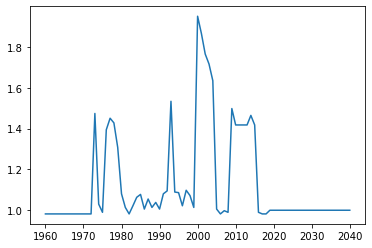

In [18]:
ut_db.plot()
# %store -r

In [19]:
%store ut_db
%store waste_from_new_all_life
%store waste_from_new_all_life_cn
%store waste_from_new_all_life_rw

%store new_scrap_available
%store new_scrap_available_cn
%store new_scrap_available_rw

%store new_scrap_alloys_cn
%store new_scrap_alloys_rw

%store new_scrap_alloys_compositions

%store waste_all_life_cn
%store waste_all_life_rw

%store waste_imports_cn_all
%store scrap_imports_cn_all
%store og_scrap_imports_cn_all

%store historical_ref_imports_cn
%store og_historical_ref_imports_cn

%store all_scrap_available
%store all_scrap_available_cn
%store all_scrap_available_rw

%store total_unalloyed

%store all_scrap_available_no_accumulation
%store all_scrap_available_no_accumulation_cn
%store all_scrap_available_no_accumulation_rw

%store old_scrap_available
%store old_scrap_available_cn
%store old_scrap_available_rw

%store old_scrap_available_no_accumulation
%store old_scrap_available_no_accumulation_cn
%store old_scrap_available_no_accumulation_rw

%store direct_melt_scrap_demand
%store direct_melt_scrap_demand_cn
%store direct_melt_scrap_demand_rw

%store direct_melt_sectorial_demand
%store direct_melt_sectorial_demand_cn
%store direct_melt_sectorial_demand_rw

%store refined_scrap_demand
%store refined_scrap_demand_cn
%store refined_scrap_demand_rw

%store direct_melt_demand
%store direct_melt_demand_cn
%store direct_melt_demand_rw

%store total_secondary_demand_all_life
%store total_secondary_demand_all_life_cn
%store total_secondary_demand_all_life_rw

%store sec_ref_scrap_demand
%store sec_ref_scrap_demand_cn
%store sec_ref_scrap_demand_rw
%store fruity_demand

%store raw_price
%store raw_price_cn
%store raw_price_rw

%store total_scrap_demand_all_life
%store total_scrap_demand_all_life_cn
%store total_scrap_demand_all_life_rw

%store scrap_use_avail_ratio
%store scrap_use_avail_ratio_cn
%store scrap_use_avail_ratio_rw

%store waste_from_new_future
%store waste_from_new_future_cn
%store waste_from_new_future_rw

%store waste_from_old_future
%store waste_from_old_future_cn
%store waste_from_old_future_rw

%store waste_all_life
%store waste_all_life_cn
%store waste_all_life_rw

%store fruity_multiplier
%store annual_recycled_content
%store annual_recycled_volume

%store historical_ref_imports_cn
%store scrap_imports_cn_all
%store og_scrap_imports_cn_all

%store fruity_alloys
%store og_fruity_alloys

# rc_variance = 0
# og_recycled_content = 0
# %store rc_variance
# %store og_recycled_content
print(str(datetime.now()))

Stored 'ut_db' (Series)
Stored 'waste_from_new_all_life' (DataFrame)
Stored 'waste_from_new_all_life_cn' (DataFrame)
Stored 'waste_from_new_all_life_rw' (DataFrame)
Stored 'new_scrap_available' (DataFrame)
Stored 'new_scrap_available_cn' (DataFrame)
Stored 'new_scrap_available_rw' (DataFrame)
Stored 'new_scrap_alloys_cn' (DataFrame)
Stored 'new_scrap_alloys_rw' (DataFrame)
Stored 'new_scrap_alloys_compositions' (DataFrame)
Stored 'waste_all_life_cn' (DataFrame)
Stored 'waste_all_life_rw' (DataFrame)
Stored 'waste_imports_cn_all' (DataFrame)
Stored 'scrap_imports_cn_all' (DataFrame)
Stored 'og_scrap_imports_cn_all' (DataFrame)
Stored 'historical_ref_imports_cn' (Series)
Stored 'og_historical_ref_imports_cn' (Series)
Stored 'all_scrap_available' (DataFrame)
Stored 'all_scrap_available_cn' (DataFrame)
Stored 'all_scrap_available_rw' (DataFrame)
Stored 'total_unalloyed' (Series)
Stored 'all_scrap_available_no_accumulation' (DataFrame)
Stored 'all_scrap_available_no_accumulation_cn' (DataFr

UsageError: Unknown variable 'scrap_use_avail_ratio'


In [9]:
%store -r

## Blending component

In [52]:
fruity_rr
raw_price_cn1 = raw_price_cn.copy()
raw_price_cn1.loc[:,'No.1']*=1.05
raw_price_rw1 = raw_price_cn1.copy()

In [59]:
ut_db


1960    1.259712
1961    1.290000
1962    1.000000
1963    1.000000
1964    1.000000
          ...   
2036    1.000000
2037    1.000000
2038    1.000000
2039    1.000000
2040    1.000000
Length: 81, dtype: float64

Converging on unalloyed tune value

In [11]:
%store -r old_scrap_available
%store -r old_scrap_available_cn
%store -r old_scrap_available_rw
%store -r new_scrap_alloys_compositions
%store -r new_scrap_alloys_cn
%store -r new_scrap_alloys_rw
%store -r direct_melt_sectorial_demand_cn
%store -r direct_melt_sectorial_demand_rw
%store -r direct_melt_sectorial_demand
%store -r refined_scrap_demand_cn
%store -r refined_scrap_demand_rw
%store -r raw_price
%store -r raw_price_cn
%store -r raw_price_rw
%store -r ut_db

In [11]:
year_i = 2017
error = 1e6
p = 0
unalloyed_tune = ut_db.loc[year_i]
fruity_rr = [0.01, 0.01, 0.01, 0.01, 0, 0, 0, 0]

new_scrap_alloys_cn_year_i = new_scrap_alloys_compositions.copy().loc[:,'High_Cu':]
new_scrap_alloys_cn_year_i.loc[:,'Availability'] = new_scrap_alloys_cn.loc[year_i]
new_scrap_alloys_rw_year_i = new_scrap_alloys_compositions.copy().loc[:,'High_Cu':]
new_scrap_alloys_rw_year_i.loc[:,'Availability'] = new_scrap_alloys_rw.loc[year_i]

while abs(error) > 10:
# while p == 0:
    if (year_i == 1960 or slow_change == 0) and fraction_yellows != 0:
        direct_melt_demand_cn.loc[year_i,:], direct_melt_demand_rw.loc[year_i,:], sec_ref_scrap_demand_cn.loc[year_i,:], sec_ref_scrap_demand_rw.loc[year_i,:], fruity_detailed, annual_recycled_content.loc[year_i], annual_recycled_vol = \
            blend_demand(old_scrap_available_cn.loc[year_i], old_scrap_available_rw.loc[year_i],
                            direct_melt_sectorial_demand_cn.loc[year_i], direct_melt_sectorial_demand_rw.loc[year_i],
                            raw_price_cn1.loc[year_i], raw_price_rw1.loc[year_i], s2s, prod_spec.copy(), raw_spec, 
                            refined_scrap_demand_cn.loc[year_i], refined_scrap_demand_rw.loc[year_i],
                            historical_prod_cn.loc[year_i,'Refined usage'], historical_prod_rw.loc[year_i,'Refined usage'],
                            fraction_yellows, unalloyed_tune, fruity_alloys, fruity_rr, pir_pcr, pir_fraction,
                            new_scrap_alloys_cn_year_i, new_scrap_alloys_rw_year_i, pir_price = pir_price, 
                            converge = 0.3, converge_width = 0.04)
        sec_ref_scrap_demand.loc[year_i,:] = sec_ref_scrap_demand_cn.loc[year_i,:] + sec_ref_scrap_demand_rw.loc[year_i,:]
#             fruity_demand.loc[year_i,:] = fruity_detailed_demand.loc[idx[year_i,:],:].sum()
    direct_melt_demand.loc[year_i, :] = direct_melt_demand_cn.loc[year_i, :] + direct_melt_demand_rw.loc[year_i, :] 
    error = direct_melt_demand.loc[year_i,'Ref_Cu'] - historical_prod.loc[year_i,'Refined usage'] # direct_melt_sectorial_demand.loc[year_i,['Unalloyed','Copper brass']].sum()

    ut_db.loc[year_i] = unalloyed_tune
    p += 1
    ut_old = unalloyed_tune
    if error > 0:
        unalloyed_tune /= 1.01#abs(error)/5000
    else:
        unalloyed_tune *= 1.015#abs(error)/5000 # decreasing alloy_tune makes scrap cheaper and decreases Ref_Cu
    print('Pass',p,': Ref_Cu exceeds historical by',round(error,0),'kt.\n\tOld tune:',round(ut_old,3),'\tNew tune:',round(unalloyed_tune,3))


NameError: name 'direct_melt_sectorial_demand_cn' is not defined

In [234]:
annual_recycled_vol.sum()/direct_melt_sectorial_demand.loc[year_i].sum()
direct_melt_demand_rw.loc[year_i,'Ref_Cu'], historical_prod_rw.loc[year_i,'Refined usage']

(4606.798050313868, 4628.0)

### Demand response to price and convergence height

In [421]:
year_i = 2017
error = 1e6
p = 0
unalloyed_tune = ut_db.loc[year_i]
fruity_rr = [0.01, 0.01, 0.01, 0.01, 0, 0, 0, 0]
price_response = pd.DataFrame(0, index = np.linspace(0.7,1.3,8), columns = list(np.linspace(0,0.4,8))+list([0.5,0.8]))
price_response.columns.name = 'converge'
price_response.index.name = 'price'

new_scrap_alloys_cn_year_i = new_scrap_alloys_compositions.copy().loc[:,'High_Cu':]
new_scrap_alloys_cn_year_i.loc[:,'Availability'] = new_scrap_alloys_cn.loc[year_i]
new_scrap_alloys_rw_year_i = new_scrap_alloys_compositions.copy().loc[:,'High_Cu':]
new_scrap_alloys_rw_year_i.loc[:,'Availability'] = new_scrap_alloys_rw.loc[year_i]

# while abs(error) > 100:
# while p == 0:
# for rr in [0,.10,.20,.30,.40,.50,.60]:
for converge in price_response.columns:
    for pri in price_response.index:
        raw_price_cn1 = raw_price_cn.copy()
        raw_price_cn1.loc[:,'No.1']*=pri
        raw_price_rw1 = raw_price_cn1.copy()
    #     fruity_rr = [0.01,0.01,0.01,0.01, rr, rr, rr, rr]
        if (year_i == 1960 or slow_change == 0) and fraction_yellows != 0:
            direct_melt_demand_cn.loc[year_i,:], direct_melt_demand_rw.loc[year_i,:], sec_ref_scrap_demand_cn.loc[year_i,:], sec_ref_scrap_demand_rw.loc[year_i,:], fruity_detailed, annual_recycled_content.loc[year_i], annual_recycled_volume.loc[year_i] = \
                blend_demand(old_scrap_available_cn.loc[year_i], old_scrap_available_rw.loc[year_i],
                                direct_melt_sectorial_demand_cn.loc[year_i], direct_melt_sectorial_demand_rw.loc[year_i],
                                raw_price_cn1.loc[year_i], raw_price_rw1.loc[year_i], s2s, prod_spec.copy(), raw_spec, 
                                refined_scrap_demand_cn.loc[year_i], refined_scrap_demand_rw.loc[year_i],
                                historical_prod_cn.loc[year_i,'Refined usage'], historical_prod_rw.loc[year_i,'Refined usage'],
                                fraction_yellows, unalloyed_tune, fruity_alloys, fruity_rr, pir_pcr, pir_fraction,
                                new_scrap_alloys_cn_year_i, new_scrap_alloys_rw_year_i, pir_price = pir_price, 
                                converge = converge, converge_width = 0.04)
            sec_ref_scrap_demand.loc[year_i,:] = sec_ref_scrap_demand_cn.loc[year_i,:] + sec_ref_scrap_demand_rw.loc[year_i,:]
    #             fruity_demand.loc[year_i,:] = fruity_detailed_demand.loc[idx[year_i,:],:].sum()
        direct_melt_demand.loc[year_i, :] = direct_melt_demand_cn.loc[year_i, :] + direct_melt_demand_rw.loc[year_i, :] 
        error = direct_melt_demand.loc[year_i,'Ref_Cu'] - historical_prod.loc[year_i,'Refined usage'] # direct_melt_sectorial_demand.loc[year_i,['Unalloyed','Copper brass']].sum()
        
        price_response.loc[pri,converge] = error
#     ut_db.loc[year_i] = unalloyed_tune
#     p += 1
#     ut_old = unalloyed_tune
#     if error > 0:
#         unalloyed_tune /= 1.05#abs(error)/5000
#     else:
#         unalloyed_tune *= 1.08#abs(error)/5000 # decreasing alloy_tune makes scrap cheaper and decreases Ref_Cu
        print('Pass',converge,pri,': Ref_Cu exceeds historical by',round(error,0),'kt.\n\tOld tune:',round(ut_old,3),'\tNew tune:',round(unalloyed_tune,3))


Pass 0.0 0.7 : Ref_Cu exceeds historical by -10630.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.0 0.7857142857142857 : Ref_Cu exceeds historical by -10630.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.0 0.8714285714285714 : Ref_Cu exceeds historical by -9908.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.0 0.9571428571428571 : Ref_Cu exceeds historical by -8082.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.0 1.042857142857143 : Ref_Cu exceeds historical by -3286.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.0 1.1285714285714286 : Ref_Cu exceeds historical by -422.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.0 1.2142857142857144 : Ref_Cu exceeds historical by 1143.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.0 1.3 : Ref_Cu exceeds historical by 2147.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.05714285714285715 0.7 : Ref_Cu exceeds historical by -10630.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.05714285714285715 0.7857142857142857 : Ref_Cu exceeds historical by -7242.0 kt

Pass 0.8 0.9571428571428571 : Ref_Cu exceeds historical by -133.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.8 1.042857142857143 : Ref_Cu exceeds historical by -78.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.8 1.1285714285714286 : Ref_Cu exceeds historical by -43.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.8 1.2142857142857144 : Ref_Cu exceeds historical by 5.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.8 1.3 : Ref_Cu exceeds historical by 39.0 kt.
	Old tune: 1.012 	New tune: 1.012


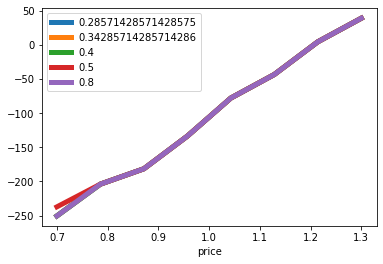

In [423]:
fig,ax = plt.subplots()
price_response.iloc[:,5:].plot(ax=ax,linewidth=5)
plt.legend()

# (price_response.iloc[-1,:]-price_response.iloc[0,:]).plot()

In [426]:
fruity_alloys.Quantity.sum()

26.056125408252687

In [162]:
price_response2

converge_width,0.000000,0.007143,0.014286,0.021429,0.028571,0.035714,0.042857,0.050000
price,,,,,,,,
0.700000,-2348.675866,-1550.865169,-722.904799,-353.007249,-213.737859,-147.496084,-104.608144,-81.138666
0.771429,-2023.841537,-1179.842186,-543.368038,-253.155529,-145.323386,-98.956609,-71.551526,-56.991625
0.842857,-1401.610929,-830.463492,-331.444416,-148.876462,-81.934879,-52.839274,-39.447992,-28.309139
0.914286,-845.531204,-582.633989,-129.047228,-53.346694,-32.019728,-17.447637,-14.033574,-10.142915
0.985714,-27.649304,-18.424603,-8.403175,4.722757,11.434054,14.950131,16.244676,12.067053
1.057143,88.288108,90.837725,78.096050,68.917697,59.450212,46.144651,36.750634,33.513728
1.128571,159.179664,162.372851,137.216855,116.626954,95.877495,79.700090,64.178901,51.130596
1.200000,168.982215,173.035005,165.391166,155.801431,125.742161,109.328043,87.241675,73.447451


### Demand response to price and converge width

In [20]:
year_i = 2017
error = 1e6
p = 0
unalloyed_tune = ut_db.loc[year_i]
fruity_rr = [0.01, 0.01, 0.01, 0.01, 0, 0, 0, 0]
price_response2 = pd.DataFrame(0, index = np.linspace(0.7,1.3,8), columns = list(np.linspace(0.005,0.05,8)))
price_response2.columns.name = 'converge_width'
price_response2.index.name = 'price'

new_scrap_alloys_cn_year_i = new_scrap_alloys_compositions.copy().loc[:,'High_Cu':]
new_scrap_alloys_cn_year_i.loc[:,'Availability'] = new_scrap_alloys_cn.loc[year_i]
new_scrap_alloys_rw_year_i = new_scrap_alloys_compositions.copy().loc[:,'High_Cu':]
new_scrap_alloys_rw_year_i.loc[:,'Availability'] = new_scrap_alloys_rw.loc[year_i]

# while abs(error) > 100:
# while p == 0:
# for rr in [0,.10,.20,.30,.40,.50,.60]:
for converge_width in price_response2.columns:
    for pri in price_response2.index:
        raw_price_cn1 = raw_price_cn.copy()
        raw_price_cn1.loc[:,'No.1']*=pri
        raw_price_rw1 = raw_price_cn1.copy()
    #     fruity_rr = [0.01,0.01,0.01,0.01, rr, rr, rr, rr]
        if (year_i == 1960 or slow_change == 0) and fraction_yellows != 0:
            direct_melt_demand_cn.loc[year_i,:], direct_melt_demand_rw.loc[year_i,:], sec_ref_scrap_demand_cn.loc[year_i,:], sec_ref_scrap_demand_rw.loc[year_i,:], fruity_detailed, annual_recycled_content.loc[year_i], annual_recycled_volume.loc[year_i] = \
                blend_demand(old_scrap_available_cn.loc[year_i], old_scrap_available_rw.loc[year_i],
                                direct_melt_sectorial_demand_cn.loc[year_i], direct_melt_sectorial_demand_rw.loc[year_i],
                                raw_price_cn1.loc[year_i], raw_price_rw1.loc[year_i], s2s, prod_spec.copy(), raw_spec, 
                                refined_scrap_demand_cn.loc[year_i], refined_scrap_demand_rw.loc[year_i],
                                historical_prod_cn.loc[year_i,'Refined usage'], historical_prod_rw.loc[year_i,'Refined usage'],
                                fraction_yellows, unalloyed_tune, fruity_alloys, fruity_rr, pir_pcr, pir_fraction,
                                new_scrap_alloys_cn_year_i, new_scrap_alloys_rw_year_i, pir_price = pir_price, 
                                converge = 0.2, converge_width = converge_width)
            sec_ref_scrap_demand.loc[year_i,:] = sec_ref_scrap_demand_cn.loc[year_i,:] + sec_ref_scrap_demand_rw.loc[year_i,:]
    #             fruity_demand.loc[year_i,:] = fruity_detailed_demand.loc[idx[year_i,:],:].sum()
        direct_melt_demand.loc[year_i, :] = direct_melt_demand_cn.loc[year_i, :] + direct_melt_demand_rw.loc[year_i, :] 
        error = direct_melt_demand.loc[year_i,'Ref_Cu'] - historical_prod.loc[year_i,'Refined usage'] # direct_melt_sectorial_demand.loc[year_i,['Unalloyed','Copper brass']].sum()
        
        price_response2.loc[pri,converge_width] = direct_melt_demand.loc[year_i,'Ref_Cu']/historical_prod.loc[year_i,'Refined usage']
#     ut_db.loc[year_i] = unalloyed_tune
#     p += 1
#     ut_old = unalloyed_tune
#     if error > 0:
#         unalloyed_tune /= 1.05#abs(error)/5000
#     else:
#         unalloyed_tune *= 1.08#abs(error)/5000 # decreasing alloy_tune makes scrap cheaper and decreases Ref_Cu
        print('Pass',converge_width,pri,': Ref_Cu exceeds historical by',round(error,0),'kt.')


Pass 0.005 0.7 : Ref_Cu exceeds historical by -6813.0 kt.
Pass 0.005 0.7857142857142857 : Ref_Cu exceeds historical by -5518.0 kt.
Pass 0.005 0.8714285714285714 : Ref_Cu exceeds historical by -4180.0 kt.
Pass 0.005 0.9571428571428571 : Ref_Cu exceeds historical by -2826.0 kt.
Pass 0.005 1.042857142857143 : Ref_Cu exceeds historical by -1550.0 kt.
Pass 0.005 1.1285714285714286 : Ref_Cu exceeds historical by -600.0 kt.
Pass 0.005 1.2142857142857144 : Ref_Cu exceeds historical by 95.0 kt.
Pass 0.005 1.3 : Ref_Cu exceeds historical by 782.0 kt.
Pass 0.01142857142857143 0.7 : Ref_Cu exceeds historical by -2271.0 kt.
Pass 0.01142857142857143 0.7857142857142857 : Ref_Cu exceeds historical by -1861.0 kt.
Pass 0.01142857142857143 0.8714285714285714 : Ref_Cu exceeds historical by -1474.0 kt.
Pass 0.01142857142857143 0.9571428571428571 : Ref_Cu exceeds historical by -1091.0 kt.
Pass 0.01142857142857143 1.042857142857143 : Ref_Cu exceeds historical by -785.0 kt.
Pass 0.01142857142857143 1.12857142

In [21]:
price_response2

converge_width,0.005000,0.011429,0.017857,0.024286,0.030714,0.037143,0.043571,0.050000
price,,,,,,,,
0.700000,0.713589,0.904521,0.953594,0.972145,0.981088,0.986566,0.989613,0.992604
0.785714,0.768026,0.921750,0.960138,0.975422,0.982873,0.988019,0.991152,0.993165
0.871429,0.824268,0.938055,0.966681,0.979180,0.985778,0.989471,0.992604,0.994617
0.957143,0.881196,0.954153,0.972113,0.982085,0.987791,0.991484,0.994057,0.996070
1.042857,0.934846,0.966993,0.978496,0.985322,0.990696,0.993829,0.995510,0.996070
1.128571,0.974760,0.978822,0.983688,0.989680,0.993601,0.995842,0.996962,0.997522
1.214286,1.003978,0.990990,0.989101,0.994598,0.996506,0.997294,0.998415,0.998975
1.300000,1.032857,1.001416,0.996924,0.998956,0.999411,1.000200,0.999867,0.999535


Text(0.5, 1.0, 'Ref. Cu demand difference from target\nas function of relative price')

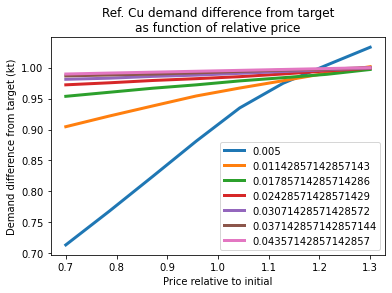

In [23]:
fig,ax = plt.subplots()#(figsize=(20,15))
price_response2.iloc[:,0:7].plot(ax=ax,linewidth=3,legend=False)#,fontsize=20)
plt.legend()
plt.ylabel('Demand difference from target (kt)')
plt.xlabel('Price relative to initial')
plt.title('Ref. Cu demand difference from target\nas function of relative price')
# (price_response2.iloc[-1,:]-price_response2.iloc[0,:]).plot()

In [205]:
(np.log((price_response2.iloc[:5,:]+historical_prod.loc[year_i,'Refined usage'])/historical_prod.loc[year_i,'Refined usage']).apply(lambda x: x/np.log(price_response2.index[:5]),axis=0)).mean()
# (((price_response2.iloc[:,:]+historical_prod.loc[year_i,'Refined usage'])/historical_prod.loc[year_i,'Refined usage']))

converge_width
0.000000    1.189474
0.007143    0.736810
0.014286    0.313463
0.021429    0.163864
0.028571    0.099168
0.035714    0.061909
0.042857    0.039465
0.050000    0.034651
dtype: float64

### Demand response to recycling rate and convergence width

In [18]:
year_i = 2017
error = 1e6
p = 0
unalloyed_tune = ut_db.loc[year_i]
fruity_rr = [0.01, 0.01, 0.01, 0.01, 0, 0, 0, 0]
rr_response = pd.DataFrame(0, index = list(np.linspace(0,0.2,16))+list([0.3,0.4]), columns = list(np.linspace(0,0.05,8)))
rr_response.columns.name = 'converge_width'
rr_response.index.name = 'rr'

new_scrap_alloys_cn_year_i = new_scrap_alloys_compositions.copy().loc[:,'High_Cu':]
new_scrap_alloys_cn_year_i.loc[:,'Availability'] = new_scrap_alloys_cn.loc[year_i]
new_scrap_alloys_rw_year_i = new_scrap_alloys_compositions.copy().loc[:,'High_Cu':]
new_scrap_alloys_rw_year_i.loc[:,'Availability'] = new_scrap_alloys_rw.loc[year_i]

# while abs(error) > 100:
# while p == 0:
# for rr in [0,.10,.20,.30,.40,.50,.60]:
for converge_width in rr_response.columns:
    for rr in rr_response.index:
        raw_price_cn1 = raw_price_cn.copy()
        raw_price_cn1.loc[:,'No.1']*=1.3
        raw_price_rw1 = raw_price_cn1.copy()
        fruity_rr = [0.01,0.01,0.01,0.01, rr, rr, rr, rr]
        if (year_i == 1960 or slow_change == 0) and fraction_yellows != 0:
            direct_melt_demand_cn.loc[year_i,:], direct_melt_demand_rw.loc[year_i,:], sec_ref_scrap_demand_cn.loc[year_i,:], sec_ref_scrap_demand_rw.loc[year_i,:], fruity_detailed, annual_recycled_cont, annual_recycled_vol = \
                blend_demand(old_scrap_available_cn.loc[year_i], old_scrap_available_rw.loc[year_i],
                                direct_melt_sectorial_demand_cn.loc[year_i], direct_melt_sectorial_demand_rw.loc[year_i],
                                raw_price_cn1.loc[year_i], raw_price_rw1.loc[year_i], s2s, prod_spec.copy(), raw_spec, 
                                refined_scrap_demand_cn.loc[year_i], refined_scrap_demand_rw.loc[year_i],
                                historical_prod_cn.loc[year_i,'Refined usage'], historical_prod_rw.loc[year_i,'Refined usage'],
                                fraction_yellows, unalloyed_tune, fruity_alloys, fruity_rr, pir_pcr, pir_fraction,
                                new_scrap_alloys_cn_year_i, new_scrap_alloys_rw_year_i, pir_price = pir_price, 
                                converge = 0.1, converge_width = converge_width)
            sec_ref_scrap_demand.loc[year_i,:] = sec_ref_scrap_demand_cn.loc[year_i,:] + sec_ref_scrap_demand_rw.loc[year_i,:]
    #             fruity_demand.loc[year_i,:] = fruity_detailed_demand.loc[idx[year_i,:],:].sum()
        direct_melt_demand.loc[year_i, :] = direct_melt_demand_cn.loc[year_i, :] + direct_melt_demand_rw.loc[year_i, :] 
        error = direct_melt_demand.loc[year_i,'Ref_Cu'] - historical_prod.loc[year_i,'Refined usage'] # direct_melt_sectorial_demand.loc[year_i,['Unalloyed','Copper brass']].sum()
        
        rr_response.loc[rr,converge_width] = annual_recycled_vol.sum()/direct_melt_sectorial_demand.loc[year_i].sum()
#     ut_db.loc[year_i] = unalloyed_tune
#     p += 1
#     ut_old = unalloyed_tune
#     if error > 0:
#         unalloyed_tune /= 1.05#abs(error)/5000
#     else:
#         unalloyed_tune *= 1.08#abs(error)/5000 # decreasing alloy_tune makes scrap cheaper and decreases Ref_Cu
        print('Pass',converge_width,rr,': Ref_Cu exceeds historical by',round(error,0),'kt.')


Pass 0.0 0.0 : Ref_Cu exceeds historical by 2095.0 kt.
Pass 0.0 0.013333333333333334 : Ref_Cu exceeds historical by 2108.0 kt.
Pass 0.0 0.02666666666666667 : Ref_Cu exceeds historical by 2055.0 kt.
Pass 0.0 0.04 : Ref_Cu exceeds historical by 2068.0 kt.
Pass 0.0 0.05333333333333334 : Ref_Cu exceeds historical by 1962.0 kt.
Pass 0.0 0.06666666666666667 : Ref_Cu exceeds historical by 1854.0 kt.
Pass 0.0 0.08 : Ref_Cu exceeds historical by 1544.0 kt.
Pass 0.0 0.09333333333333334 : Ref_Cu exceeds historical by 1254.0 kt.
Pass 0.0 0.10666666666666667 : Ref_Cu exceeds historical by 905.0 kt.
Pass 0.0 0.12000000000000001 : Ref_Cu exceeds historical by 588.0 kt.
Pass 0.0 0.13333333333333333 : Ref_Cu exceeds historical by 241.0 kt.
Pass 0.0 0.14666666666666667 : Ref_Cu exceeds historical by -117.0 kt.
Pass 0.0 0.16 : Ref_Cu exceeds historical by -368.0 kt.
Pass 0.0 0.17333333333333334 : Ref_Cu exceeds historical by -699.0 kt.
Pass 0.0 0.18666666666666668 : Ref_Cu exceeds historical by -1053.0 k

Pass 0.03571428571428572 0.18666666666666668 : Ref_Cu exceeds historical by -1885.0 kt.
Pass 0.03571428571428572 0.2 : Ref_Cu exceeds historical by -2005.0 kt.
Pass 0.03571428571428572 0.3 : Ref_Cu exceeds historical by -4033.0 kt.
Pass 0.03571428571428572 0.4 : Ref_Cu exceeds historical by -7031.0 kt.
Pass 0.04285714285714286 0.0 : Ref_Cu exceeds historical by 39.0 kt.
Pass 0.04285714285714286 0.013333333333333334 : Ref_Cu exceeds historical by 13.0 kt.
Pass 0.04285714285714286 0.02666666666666667 : Ref_Cu exceeds historical by -7.0 kt.
Pass 0.04285714285714286 0.04 : Ref_Cu exceeds historical by -33.0 kt.
Pass 0.04285714285714286 0.05333333333333334 : Ref_Cu exceeds historical by -93.0 kt.
Pass 0.04285714285714286 0.06666666666666667 : Ref_Cu exceeds historical by -226.0 kt.
Pass 0.04285714285714286 0.08 : Ref_Cu exceeds historical by -376.0 kt.
Pass 0.04285714285714286 0.09333333333333334 : Ref_Cu exceeds historical by -527.0 kt.
Pass 0.04285714285714286 0.10666666666666667 : Ref_Cu

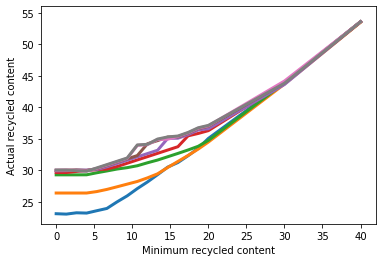

In [20]:
fig,ax = plt.subplots()
rr_ph = rr_response.copy().iloc[:,:]
x = rr_ph.iloc[0,:]-rr_ph.iloc[0,-1]
# (rr_ph.iloc[:,:]-x).plot(ax=ax,linewidth=3)
plt.plot(rr_ph.index*100, (rr_ph.iloc[:,:])*100, linewidth=3)
# plt.legend(rr_ph.columns)
plt.xlabel('Minimum recycled content')
plt.ylabel('Actual recycled content')
plt.ylim(21.5,56)
yy = plt.ylim()
# (rr_ph.iloc[-1,:]-rr_ph.iloc[0,:]).plot()

In [25]:
rr_ph
ut_db.loc[2016:]

'nuff'

### Demand response to CN recycling rate and convergence width, only China rr change

In [9]:
year_i = 2017
error = 1e6
p = 0
unalloyed_tune = ut_db.loc[year_i]
fruity_rr = [0.01, 0.01, 0.01, 0.01, 0, 0, 0, 0]
rr_response_cn = pd.DataFrame(0, index = list(np.linspace(0,0.2,16))+list([0.3,0.4]), columns = list(np.linspace(0,0.05,8)))
rr_response_cn.columns.name = 'converge_width'
rr_response_cn.index.name = 'rr'

new_scrap_alloys_cn_year_i = new_scrap_alloys_compositions.copy().loc[:,'High_Cu':]
new_scrap_alloys_cn_year_i.loc[:,'Availability'] = new_scrap_alloys_cn.loc[year_i]
new_scrap_alloys_rw_year_i = new_scrap_alloys_compositions.copy().loc[:,'High_Cu':]
new_scrap_alloys_rw_year_i.loc[:,'Availability'] = new_scrap_alloys_rw.loc[year_i]

# while abs(error) > 100:
# while p == 0:
# for rr in [0,.10,.20,.30,.40,.50,.60]:
for converge_width in rr_response_cn.columns:
    for rr in rr_response_cn.index:
        raw_price_cn1 = raw_price_cn.copy()
#         raw_price_cn1.loc[:,'No.1']*=pri
        raw_price_rw1 = raw_price_cn1.copy()
        fruity_rr = [0.01,0.01,0.01,0.01, rr, 0, rr, 0]
        if (year_i == 1960 or slow_change == 0) and fraction_yellows != 0:
            direct_melt_demand_cn.loc[year_i,:], direct_melt_demand_rw.loc[year_i,:], sec_ref_scrap_demand_cn.loc[year_i,:], sec_ref_scrap_demand_rw.loc[year_i,:], fruity_detailed, annual_recycled_content.loc[year_i], annual_recycled_vol = \
                blend_demand(old_scrap_available_cn.loc[year_i], old_scrap_available_rw.loc[year_i],
                                direct_melt_sectorial_demand_cn.loc[year_i], direct_melt_sectorial_demand_rw.loc[year_i],
                                raw_price_cn1.loc[year_i], raw_price_rw1.loc[year_i], s2s, prod_spec.copy(), raw_spec, 
                                refined_scrap_demand_cn.loc[year_i], refined_scrap_demand_rw.loc[year_i],
                                historical_prod_cn.loc[year_i,'Refined usage'], historical_prod_rw.loc[year_i,'Refined usage'],
                                fraction_yellows, unalloyed_tune, fruity_alloys, fruity_rr, pir_pcr, pir_fraction,
                                new_scrap_alloys_cn_year_i, new_scrap_alloys_rw_year_i, pir_price = pir_price, 
                                converge = 0.1, converge_width = converge_width)
            sec_ref_scrap_demand.loc[year_i,:] = sec_ref_scrap_demand_cn.loc[year_i,:] + sec_ref_scrap_demand_rw.loc[year_i,:]
    #             fruity_demand.loc[year_i,:] = fruity_detailed_demand.loc[idx[year_i,:],:].sum()
        direct_melt_demand.loc[year_i, :] = direct_melt_demand_cn.loc[year_i, :] + direct_melt_demand_rw.loc[year_i, :] 
        error = direct_melt_demand.loc[year_i,'Ref_Cu'] - historical_prod.loc[year_i,'Refined usage'] # direct_melt_sectorial_demand.loc[year_i,['Unalloyed','Copper brass']].sum()
        
        rr_response_cn.loc[rr,converge_width] = annual_recycled_vol.sum()/direct_melt_sectorial_demand.loc[year_i].sum()
#     ut_db.loc[year_i] = unalloyed_tune
#     p += 1
#     ut_old = unalloyed_tune
#     if error > 0:
#         unalloyed_tune /= 1.05#abs(error)/5000
#     else:
#         unalloyed_tune *= 1.08#abs(error)/5000 # decreasing alloy_tune makes scrap cheaper and decreases Ref_Cu
        print('Pass',converge_width,rr,': Ref_Cu exceeds historical by',round(error,0),'kt.')


Pass 0.0 0.0 : Ref_Cu exceeds historical by -6998.0 kt.
Pass 0.0 0.013333333333333334 : Ref_Cu exceeds historical by -6812.0 kt.
Pass 0.0 0.02666666666666667 : Ref_Cu exceeds historical by -6874.0 kt.
Pass 0.0 0.04 : Ref_Cu exceeds historical by -7158.0 kt.
Pass 0.0 0.05333333333333334 : Ref_Cu exceeds historical by -7185.0 kt.
Pass 0.0 0.06666666666666667 : Ref_Cu exceeds historical by -7292.0 kt.
Pass 0.0 0.08 : Ref_Cu exceeds historical by -6719.0 kt.
Pass 0.0 0.09333333333333334 : Ref_Cu exceeds historical by -6874.0 kt.
Pass 0.0 0.10666666666666667 : Ref_Cu exceeds historical by -6874.0 kt.
Pass 0.0 0.12000000000000001 : Ref_Cu exceeds historical by -6919.0 kt.
Pass 0.0 0.13333333333333333 : Ref_Cu exceeds historical by -6785.0 kt.
Pass 0.0 0.14666666666666667 : Ref_Cu exceeds historical by -7065.0 kt.
Pass 0.0 0.16 : Ref_Cu exceeds historical by -6874.0 kt.
Pass 0.0 0.17333333333333334 : Ref_Cu exceeds historical by -6874.0 kt.
Pass 0.0 0.18666666666666668 : Ref_Cu exceeds histor

KeyboardInterrupt: 

(21.5, 56.0)

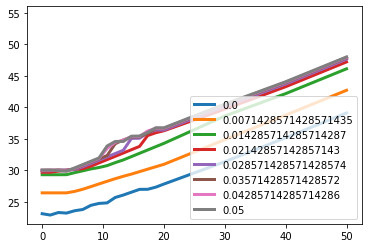

In [480]:
fig,ax = plt.subplots()#figsize=(20,15))
rr_ph_cn = rr_response_cn.copy()
x = rr_ph_cn.loc[0,:]-rr_ph_cn.loc[0,0.05]
# plt.plot(rr_ph_cn.index*100, (rr_ph_cn-x)*100, linewidth = 3)
plt.plot(rr_ph_cn.index*100, (rr_ph_cn)*100, linewidth = 3)
# (rr_ph_cn.iloc[:,:]-x).plot(ax=ax,linewidth=3,legend=False)
plt.legend(rr_ph_cn.columns)
plt.ylim(yy)
# (rr_ph_cn.iloc[-1,:]-rr_response.iloc[0,:]).plot()

In [10]:
%store -r rr_response_cn
%store -r rr_response_rw
%store -r rr_response

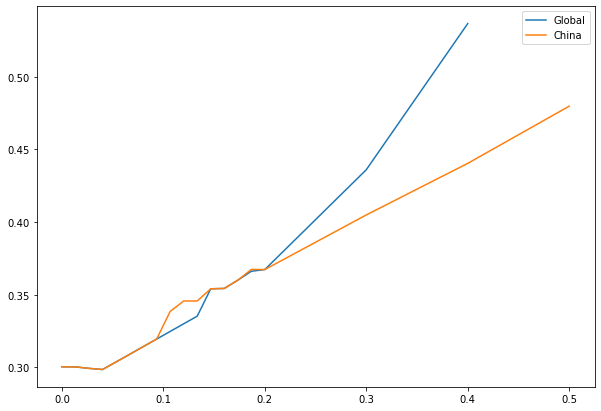

In [334]:
plt.plot(rr_response.iloc[:,-1],label='Global')
plt.plot(rr_response2.iloc[:,-1],label='China')
plt.legend()


### Demand response to RoW recycling rate and convergence width, only RoW change

In [337]:
year_i = 2017
error = 1e6
p = 0
unalloyed_tune = ut_db.loc[year_i]
fruity_rr = [0.01, 0.01, 0.01, 0.01, 0, 0, 0, 0]
rr_response_rw = pd.DataFrame(0, index = list(np.linspace(0,0.3,24))+list([0.3,0.4]), columns = list(np.linspace(0,0.05,8)))
rr_response_rw.columns.name = 'converge_width'
rr_response_rw.index.name = 'rr'

new_scrap_alloys_cn_year_i = new_scrap_alloys_compositions.copy().loc[:,'High_Cu':]
new_scrap_alloys_cn_year_i.loc[:,'Availability'] = new_scrap_alloys_cn.loc[year_i]
new_scrap_alloys_rw_year_i = new_scrap_alloys_compositions.copy().loc[:,'High_Cu':]
new_scrap_alloys_rw_year_i.loc[:,'Availability'] = new_scrap_alloys_rw.loc[year_i]

# while abs(error) > 100:
# while p == 0:
# for rr in [0,.10,.20,.30,.40,.50,.60]:
for converge_width in rr_response_rw.columns:
    for rr in rr_response_rw.index:
        raw_price_cn1 = raw_price_cn.copy()
        raw_price_cn1.loc[:,'No.1']*=pri
        raw_price_rw1 = raw_price_cn1.copy()
        fruity_rr = [0.01,0.01,0.01,0.01, 0, rr, 0, rr]
        if (year_i == 1960 or slow_change == 0) and fraction_yellows != 0:
            direct_melt_demand_cn.loc[year_i,:], direct_melt_demand_rw.loc[year_i,:], sec_ref_scrap_demand_cn.loc[year_i,:], sec_ref_scrap_demand_rw.loc[year_i,:], fruity_detailed, annual_recycled_content.loc[year_i], annual_recycled_vol = \
                blend_demand(old_scrap_available_cn.loc[year_i], old_scrap_available_rw.loc[year_i],
                                direct_melt_sectorial_demand_cn.loc[year_i], direct_melt_sectorial_demand_rw.loc[year_i],
                                raw_price_cn1.loc[year_i], raw_price_rw1.loc[year_i], s2s, prod_spec.copy(), raw_spec, 
                                refined_scrap_demand_cn.loc[year_i], refined_scrap_demand_rw.loc[year_i],
                                historical_prod_cn.loc[year_i,'Refined usage'], historical_prod_rw.loc[year_i,'Refined usage'],
                                fraction_yellows, unalloyed_tune, fruity_alloys, fruity_rr, pir_pcr, pir_fraction,
                                new_scrap_alloys_cn_year_i, new_scrap_alloys_rw_year_i, pir_price = pir_price, 
                                converge = 0.1, converge_width = converge_width)
            sec_ref_scrap_demand.loc[year_i,:] = sec_ref_scrap_demand_cn.loc[year_i,:] + sec_ref_scrap_demand_rw.loc[year_i,:]
    #             fruity_demand.loc[year_i,:] = fruity_detailed_demand.loc[idx[year_i,:],:].sum()
        direct_melt_demand.loc[year_i, :] = direct_melt_demand_cn.loc[year_i, :] + direct_melt_demand_rw.loc[year_i, :] 
        error = direct_melt_demand.loc[year_i,'Ref_Cu'] - historical_prod.loc[year_i,'Refined usage'] # direct_melt_sectorial_demand.loc[year_i,['Unalloyed','Copper brass']].sum()
        
        rr_response_rw.loc[rr,converge_width] = annual_recycled_vol.sum()/direct_melt_sectorial_demand.loc[year_i].sum()
#     ut_db.loc[year_i] = unalloyed_tune
#     p += 1
#     ut_old = unalloyed_tune
#     if error > 0:
#         unalloyed_tune /= 1.05#abs(error)/5000
#     else:
#         unalloyed_tune *= 1.08#abs(error)/5000 # decreasing alloy_tune makes scrap cheaper and decreases Ref_Cu
        print('Pass',converge_width,rr,': Ref_Cu exceeds historical by',round(error,0),'kt.\n\tOld tune:',round(ut_old,3),'\tNew tune:',round(unalloyed_tune,3))


Pass 0.0 0.0 : Ref_Cu exceeds historical by 2095.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.0 0.013043478260869565 : Ref_Cu exceeds historical by 2095.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.0 0.02608695652173913 : Ref_Cu exceeds historical by 2095.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.0 0.03913043478260869 : Ref_Cu exceeds historical by 2095.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.0 0.05217391304347826 : Ref_Cu exceeds historical by 2095.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.0 0.06521739130434782 : Ref_Cu exceeds historical by 2095.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.0 0.07826086956521738 : Ref_Cu exceeds historical by 1956.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.0 0.09130434782608696 : Ref_Cu exceeds historical by 1764.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.0 0.10434782608695652 : Ref_Cu exceeds historical by 1565.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.0 0.11739130434782608 : Ref_Cu exceeds historical by 1362.0 kt.

Pass 0.014285714285714287 0.2608695652173913 : Ref_Cu exceeds historical by -726.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.014285714285714287 0.27391304347826084 : Ref_Cu exceeds historical by -937.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.014285714285714287 0.28695652173913044 : Ref_Cu exceeds historical by -1161.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.014285714285714287 0.3 : Ref_Cu exceeds historical by -1381.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.014285714285714287 0.3 : Ref_Cu exceeds historical by -1381.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.014285714285714287 0.4 : Ref_Cu exceeds historical by -3217.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.02142857142857143 0.0 : Ref_Cu exceeds historical by 138.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.02142857142857143 0.013043478260869565 : Ref_Cu exceeds historical by 138.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.02142857142857143 0.02608695652173913 : Ref_Cu exceeds historical by 138.0 kt.
	O

Pass 0.03571428571428572 0.15652173913043477 : Ref_Cu exceeds historical by 47.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.03571428571428572 0.16956521739130434 : Ref_Cu exceeds historical by 47.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.03571428571428572 0.1826086956521739 : Ref_Cu exceeds historical by 47.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.03571428571428572 0.19565217391304346 : Ref_Cu exceeds historical by 47.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.03571428571428572 0.20869565217391303 : Ref_Cu exceeds historical by 47.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.03571428571428572 0.2217391304347826 : Ref_Cu exceeds historical by 47.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.03571428571428572 0.23478260869565215 : Ref_Cu exceeds historical by -41.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.03571428571428572 0.24782608695652172 : Ref_Cu exceeds historical by -162.0 kt.
	Old tune: 1.012 	New tune: 1.012
Pass 0.03571428571428572 0.2608695652173913 : R

(21.5, 56.0)

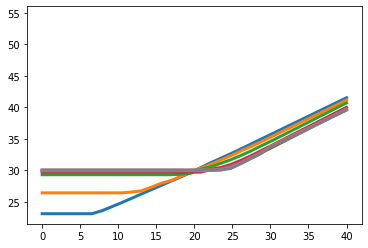

In [481]:
fig,ax = plt.subplots()#figsize=(20,15))
rr_ph3 = rr_response_rw.copy()
x = rr_ph3.loc[0,:]-rr_ph3.loc[0,0.05]
plt.plot(rr_ph3.index*100, (rr_ph3)*100, linewidth = 3)
# (rr_ph3.iloc[:,:]-x).plot(ax=ax,linewidth=3,legend=False)
# plt.legend()
plt.ylim(yy)
# (rr_ph3.iloc[-1,:]-rr_response.iloc[0,:]).plot()

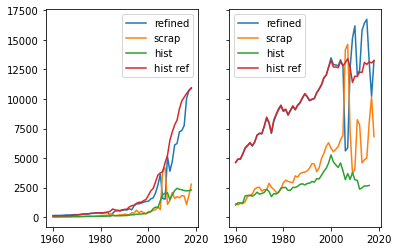

In [419]:
fig,[ax1,ax2] = plt.subplots(1,2, sharey=True)
ax1.plot(direct_melt_demand_cn.loc[:2018,'Ref_Cu'],label='refined')
ax1.plot(direct_melt_demand_cn.loc[:2018,'Yellow_Brass':].sum(axis=1),label='scrap')
ax1.plot(historical_prod_cn.loc[:,'Direct melt'],label='hist')
ax1.plot(historical_prod_cn.loc[:,'Refined usage'],label='hist ref')

ax2.plot(direct_melt_demand_rw.loc[:2018,'Ref_Cu'],label='refined')
ax2.plot(direct_melt_demand_rw.loc[:2018,'Yellow_Brass':].sum(axis=1),label='scrap')
ax2.plot(historical_prod_rw.loc[:,'Direct melt'],label='hist')
ax2.plot(historical_prod_rw.loc[:,'Refined usage'],label='hist ref')

ax1.legend()
ax2.legend()

In [7]:
%store -r old_scrap_available
%store -r old_scrap_available_cn
%store -r old_scrap_available_rw
%store -r new_scrap_alloys_compositions
%store -r new_scrap_alloys_cn
%store -r new_scrap_alloys_rw
%store -r direct_melt_sectorial_demand_cn
%store -r direct_melt_sectorial_demand_rw
%store -r direct_melt_sectorial_demand
%store -r refined_scrap_demand_cn
%store -r refined_scrap_demand_rw
%store -r raw_price
%store -r raw_price_cn
%store -r raw_price_rw

In [ ]:
172.9
old_scrap_available_rw.loc[1960:]
# direct_melt_sectorial_demand_cn.loc[1960,'Unalloyed':].sum(),historical_prod_cn.loc[1960,'Refined usage'],\
# direct_melt_sectorial_demand_rw.loc[1960,'Unalloyed':].sum(),historical_prod_rw.loc[1960,'Refined usage']
direct_melt_demand_rw.loc[2010,'No.1'], old_scrap_available_rw.loc[2010,'No.1']#,old_scrap_available_rw.loc[2010,[i for i in old_scrap_available.columns if 'No.2' not in i]].sum(),historical_prod_rw.loc[2010,'Refined usage']
raw_price_cn.loc[2013]/raw_price_cn.loc[2010]
# raw_price_cn.loc[2000:,'No.1'].plot()
raw_price_cn1 = raw_price_cn.copy()
raw_price_cn1.loc[:,'No.1']*=1.05
raw_price_rw1 = raw_price_cn1.copy()

In [342]:
direct_melt_sectorial_demand_rw.loc[2010].sum(),old_scrap_available_rw.loc[2010,[i for i in old_scrap_available.columns if 'No.2' not in i]].sum(),historical_prod_rw.loc[2010,'Refined usage']

(18810.248550946548, 2985.583238203432, 11937.0)

In [343]:
%store -r

## China simulation

In [127]:
ref_stats_cn
ref_bal_l1_cn
ref_stats_next_cn
all_scrap_available_no_accumulation_cn.sum(axis=1).loc[2017:],ref_hyper_param_cn
ref_bal_l1_cn
simulate_refinery_production_oneyear(year_i, tcrc_series_cn, sp2_series_cn, \
                                                                   ref_demand_series_cn, all_scrap_available_no_accumulation_cn.sum(axis=1),# previously waste_all_life.sum(axis = 1)
                                                                   ref_stats_cn, ref_hyper_param_cn, growth_lag=1,\
                                                                   ref_bal=ref_bal_l1_cn.loc[year_i], \
                                                                   pri_CU_ref_bal_elas = CU_ref_bal_elas,\
                                                                   sec_CU_ref_bal_elas = CU_ref_bal_elas) 
tcrc_series_cn
pd.concat([all_scrap_available_no_accumulation[scrap_subset].sum(axis=1).loc[2015:],total_scrap_demand_all_life.loc[2015:].sum(axis=1)],axis=1)
(direct_melt_demand_cn.loc[year_i,scrap_subset])# - 
sec_ref_scrap_demand_cn.loc[year_i,:].notna().any()
x = pd.Series(blend_demand(old_scrap_available_year_i_cn, old_scrap_available_year_i_rw,
                                            direct_melt_sectorial_demand_cn.loc[year_i], direct_melt_sectorial_demand_rw.loc[year_i],
                                            raw_price_cn.loc[year_i], raw_price_rw.loc[year_i], s2s, prod_spec.copy(), raw_spec, 
                                            refined_scrap_demand_year_i_cn, refined_scrap_demand_year_i_rw,
                                            direct_melt_sectorial_demand_cn.loc[year_i,['Unalloyed','Copper brass']].sum(), direct_melt_sectorial_demand_rw.loc[year_i,['Unalloyed','Copper brass']].sum(),
                                            fraction_yellows, unalloyed_tune, fruity_alloys, fruity_rr, pir_pcr, pir_fraction,
                                            new_scrap_alloys_cn_year_i, new_scrap_alloys_rw_year_i,
                                            converge = 0.3, converge_width = 0.04))

___________________________________________________________________
NEW SCENARIO: test (0)
2022-02-09 09:28:08.522984
PIR Fraction: -1
Fruity RR: [0.01, 0.01, 0.01, 0.01, 0, 0, 0, 0]
Import multiplier: 1
Scrap imports:             No.1        No.2  Al_Bronze  Cartridge Mn_Bronze      Ni_Ag  \
2018  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2019  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2020  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2021  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2022  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2023  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2024  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2025  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2026  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2027  453.789825  579.563063  2

Pass 1 : Ref_Cu exceeds historical by 68.0 kt.
	Old tune: 1.29 	New tune: 1.284
Pass 2 : Ref_Cu exceeds historical by 68.0 kt.
	Old tune: 1.284 	New tune: 1.277
Pass 3 : Ref_Cu exceeds historical by 68.0 kt.
	Old tune: 1.277 	New tune: 1.271
Pass 4 : Ref_Cu exceeds historical by 48.0 kt.
	Old tune: 1.271 	New tune: 1.265
	Total direct melt scrap demand, China:  20671.814058890835
	Total direct melt scrap demand, RoW:  17277.021344619232
   2024 test
	ref prod:  25901.972560278857  ref demand:  26274.86624068729
	Mines closing this year: 8
	New mines opening this year:  34
	Total mining production:  22200.55145625789
	Total scrap supply, China:  3057.9104619794275
	Total scrap supply, RoW:  7797.464501770776
		PIR price: 0.2 times refined copper price
Pass 1 : Ref_Cu exceeds historical by 56.0 kt.
	Old tune: 1.29 	New tune: 1.284
Pass 2 : Ref_Cu exceeds historical by 56.0 kt.
	Old tune: 1.284 	New tune: 1.277
Pass 3 : Ref_Cu exceeds historical by 56.0 kt.
	Old tune: 1.277 	New tune: 1.2

Pass 8 : Ref_Cu exceeds historical by 64.0 kt.
	Old tune: 1.246 	New tune: 1.24
Pass 9 : Ref_Cu exceeds historical by 41.0 kt.
	Old tune: 1.24 	New tune: 1.233
	Total direct melt scrap demand, China:  22738.996240507462
	Total direct melt scrap demand, RoW:  17526.030282116702
   2031 test
	ref prod:  27916.14122459181  ref demand:  28115.671561427986
	Mines closing this year: 1
	New mines opening this year:  45
	Total mining production:  25397.269182759344
	Total scrap supply, China:  4427.420648401864
	Total scrap supply, RoW:  7862.5790097445
		PIR price: 0.2 times refined copper price
Pass 1 : Ref_Cu exceeds historical by 60.0 kt.
	Old tune: 1.29 	New tune: 1.284
Pass 2 : Ref_Cu exceeds historical by 60.0 kt.
	Old tune: 1.284 	New tune: 1.277
Pass 3 : Ref_Cu exceeds historical by 60.0 kt.
	Old tune: 1.277 	New tune: 1.271
Pass 4 : Ref_Cu exceeds historical by 60.0 kt.
	Old tune: 1.271 	New tune: 1.265
Pass 5 : Ref_Cu exceeds historical by 60.0 kt.
	Old tune: 1.265 	New tune: 1.258


<Figure size 432x288 with 0 Axes>

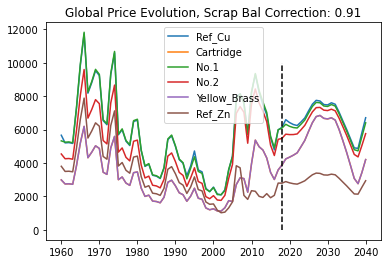

<Figure size 432x288 with 0 Axes>

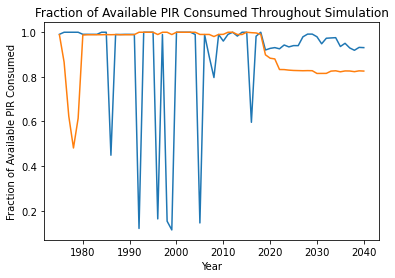

___________________________________________________________________
NEW SCENARIO: test (1)
2022-02-09 09:59:46.195209
PIR Fraction: -1
Fruity RR: [0.01, 0.01, 0.01, 0.01, 0, 0, 0, 0]
Import multiplier: 1
Scrap imports:             No.1        No.2  Al_Bronze  Cartridge Mn_Bronze      Ni_Ag  \
2018  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2019  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2020  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2021  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2022  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2023  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2024  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2025  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2026  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2027  453.789825  579.563063  2

	Mines closing this year: 5
	New mines opening this year:  57
	Total mining production:  21681.252641535088
	Total scrap supply, China:  2918.827535887013
	Total scrap supply, RoW:  7810.072623486394
		PIR price: 0.2 times refined copper price
Pass 1 : Ref_Cu exceeds historical by 66.0 kt.
	Old tune: 1.29 	New tune: 1.284
Pass 2 : Ref_Cu exceeds historical by 66.0 kt.
	Old tune: 1.284 	New tune: 1.277
Pass 3 : Ref_Cu exceeds historical by 66.0 kt.
	Old tune: 1.277 	New tune: 1.271
Pass 4 : Ref_Cu exceeds historical by 66.0 kt.
	Old tune: 1.271 	New tune: 1.265
Pass 5 : Ref_Cu exceeds historical by 66.0 kt.
	Old tune: 1.265 	New tune: 1.258
Pass 6 : Ref_Cu exceeds historical by 66.0 kt.
	Old tune: 1.258 	New tune: 1.252
Pass 7 : Ref_Cu exceeds historical by 45.0 kt.
	Old tune: 1.252 	New tune: 1.246
	Total direct melt scrap demand, China:  20697.229410035965
	Total direct melt scrap demand, RoW:  17284.202365499834
   2024 test
	ref prod:  25925.14412029148  ref demand:  26277.177252522

	Total scrap supply, China:  4160.30635720793
	Total scrap supply, RoW:  7798.827762236709
		PIR price: 0.2 times refined copper price
Pass 1 : Ref_Cu exceeds historical by 78.0 kt.
	Old tune: 1.29 	New tune: 1.284
Pass 2 : Ref_Cu exceeds historical by 78.0 kt.
	Old tune: 1.284 	New tune: 1.277
Pass 3 : Ref_Cu exceeds historical by 60.0 kt.
	Old tune: 1.277 	New tune: 1.271
Pass 4 : Ref_Cu exceeds historical by 60.0 kt.
	Old tune: 1.271 	New tune: 1.265
Pass 5 : Ref_Cu exceeds historical by 60.0 kt.
	Old tune: 1.265 	New tune: 1.258
Pass 6 : Ref_Cu exceeds historical by 60.0 kt.
	Old tune: 1.258 	New tune: 1.252
Pass 7 : Ref_Cu exceeds historical by 60.0 kt.
	Old tune: 1.252 	New tune: 1.246
Pass 8 : Ref_Cu exceeds historical by 60.0 kt.
	Old tune: 1.246 	New tune: 1.24
Pass 9 : Ref_Cu exceeds historical by 38.0 kt.
	Old tune: 1.24 	New tune: 1.233
	Total direct melt scrap demand, China:  22767.359516193763
	Total direct melt scrap demand, RoW:  17559.75191475222
   2031 test
	ref prod

Pass 1 : Ref_Cu exceeds historical by 32.0 kt.
	Old tune: 1.29 	New tune: 1.284
	Total direct melt scrap demand, China:  27289.513900173835
	Total direct melt scrap demand, RoW:  19814.85860581514
2022-02-09 10:32:57.873189
	Data/scenario results/John/05 China/price test.xlsx
2022-02-09 10:33:14.788589


<Figure size 432x288 with 0 Axes>

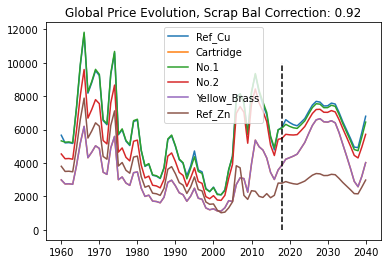

<Figure size 432x288 with 0 Axes>

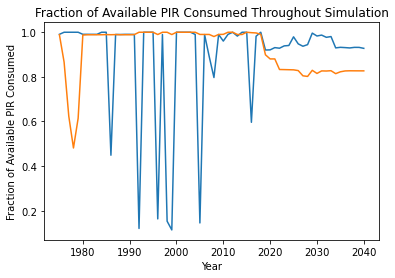

___________________________________________________________________
NEW SCENARIO: test (2)
2022-02-09 10:33:15.374404
PIR Fraction: -1
Fruity RR: [0.01, 0.01, 0.01, 0.01, 0, 0, 0, 0]
Import multiplier: 1
Scrap imports:             No.1        No.2  Al_Bronze  Cartridge Mn_Bronze      Ni_Ag  \
2018  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2019  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2020  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2021  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2022  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2023  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2024  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2025  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2026  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2027  453.789825  579.563063  2

Pass 1 : Ref_Cu exceeds historical by 65.0 kt.
	Old tune: 1.29 	New tune: 1.284
Pass 2 : Ref_Cu exceeds historical by 65.0 kt.
	Old tune: 1.284 	New tune: 1.277
Pass 3 : Ref_Cu exceeds historical by 65.0 kt.
	Old tune: 1.277 	New tune: 1.271
Pass 4 : Ref_Cu exceeds historical by 48.0 kt.
	Old tune: 1.271 	New tune: 1.265
	Total direct melt scrap demand, China:  20715.922614609703
	Total direct melt scrap demand, RoW:  17298.90213148895
   2024 test
	ref prod:  25944.123111011406  ref demand:  26282.993032842354
	Mines closing this year: 8
	New mines opening this year:  34
	Total mining production:  22184.54106447504
	Total scrap supply, China:  3058.656576549116
	Total scrap supply, RoW:  7797.917118731562
		PIR price: 0.2 times refined copper price
Pass 1 : Ref_Cu exceeds historical by 81.0 kt.
	Old tune: 1.29 	New tune: 1.284
Pass 2 : Ref_Cu exceeds historical by 64.0 kt.
	Old tune: 1.284 	New tune: 1.277
Pass 3 : Ref_Cu exceeds historical by 64.0 kt.
	Old tune: 1.277 	New tune: 1.27

Pass 1 : Ref_Cu exceeds historical by 55.0 kt.
	Old tune: 1.29 	New tune: 1.284
Pass 2 : Ref_Cu exceeds historical by 55.0 kt.
	Old tune: 1.284 	New tune: 1.277
Pass 3 : Ref_Cu exceeds historical by 55.0 kt.
	Old tune: 1.277 	New tune: 1.271
Pass 4 : Ref_Cu exceeds historical by 55.0 kt.
	Old tune: 1.271 	New tune: 1.265
Pass 5 : Ref_Cu exceeds historical by 55.0 kt.
	Old tune: 1.265 	New tune: 1.258
Pass 6 : Ref_Cu exceeds historical by 55.0 kt.
	Old tune: 1.258 	New tune: 1.252
Pass 7 : Ref_Cu exceeds historical by 55.0 kt.
	Old tune: 1.252 	New tune: 1.246
Pass 8 : Ref_Cu exceeds historical by 55.0 kt.
	Old tune: 1.246 	New tune: 1.24
Pass 9 : Ref_Cu exceeds historical by 55.0 kt.
	Old tune: 1.24 	New tune: 1.233
Pass 10 : Ref_Cu exceeds historical by 55.0 kt.
	Old tune: 1.233 	New tune: 1.227
Pass 11 : Ref_Cu exceeds historical by 55.0 kt.
	Old tune: 1.227 	New tune: 1.221
Pass 12 : Ref_Cu exceeds historical by 55.0 kt.
	Old tune: 1.221 	New tune: 1.215
Pass 13 : Ref_Cu exceeds his

Pass 1 : Ref_Cu exceeds historical by 30.0 kt.
	Old tune: 1.29 	New tune: 1.284
	Total direct melt scrap demand, China:  27298.203198817173
	Total direct melt scrap demand, RoW:  19862.058868572694
2022-02-09 11:05:17.629317
	Data/scenario results/John/05 China/price test.xlsx
2022-02-09 11:05:36.843049


<Figure size 432x288 with 0 Axes>

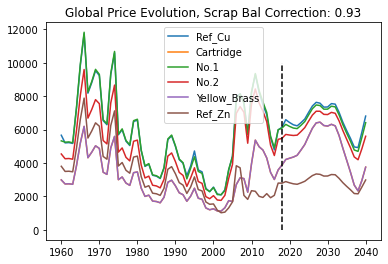

<Figure size 432x288 with 0 Axes>

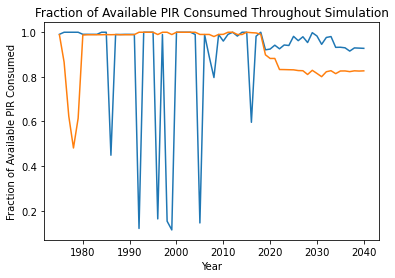

___________________________________________________________________
NEW SCENARIO: test (3)
2022-02-09 11:05:37.513305
PIR Fraction: -1
Fruity RR: [0.01, 0.01, 0.01, 0.01, 0, 0, 0, 0]
Import multiplier: 1
Scrap imports:             No.1        No.2  Al_Bronze  Cartridge Mn_Bronze      Ni_Ag  \
2018  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2019  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2020  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2021  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2022  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2023  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2024  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2025  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2026  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2027  453.789825  579.563063  2

Pass 2 : Ref_Cu exceeds historical by 66.0 kt.
	Old tune: 1.284 	New tune: 1.277
Pass 3 : Ref_Cu exceeds historical by 66.0 kt.
	Old tune: 1.277 	New tune: 1.271
Pass 4 : Ref_Cu exceeds historical by 46.0 kt.
	Old tune: 1.271 	New tune: 1.265
	Total direct melt scrap demand, China:  20737.315326651336
	Total direct melt scrap demand, RoW:  17305.34845549602
   2024 test
	ref prod:  25962.360234763662  ref demand:  26281.856229154568
	Mines closing this year: 8
	New mines opening this year:  34
	Total mining production:  22164.41624817618
	Total scrap supply, China:  3059.0052270333795
	Total scrap supply, RoW:  7798.128551068996
		PIR price: 0.2 times refined copper price
Pass 1 : Ref_Cu exceeds historical by 66.0 kt.
	Old tune: 1.29 	New tune: 1.284
Pass 2 : Ref_Cu exceeds historical by 66.0 kt.
	Old tune: 1.284 	New tune: 1.277
Pass 3 : Ref_Cu exceeds historical by 66.0 kt.
	Old tune: 1.277 	New tune: 1.271
Pass 4 : Ref_Cu exceeds historical by 66.0 kt.
	Old tune: 1.271 	New tune: 1.

Pass 10 : Ref_Cu exceeds historical by 42.0 kt.
	Old tune: 1.233 	New tune: 1.227
	Total direct melt scrap demand, China:  22809.003006923453
	Total direct melt scrap demand, RoW:  17612.273939551575
   2031 test
	ref prod:  27839.206377553484  ref demand:  28187.946395374078
	Mines closing this year: 0
	New mines opening this year:  44
	Total mining production:  25301.64008338287
	Total scrap supply, China:  4431.43651234432
	Total scrap supply, RoW:  7864.708700373389
		PIR price: 0.2 times refined copper price
Pass 1 : Ref_Cu exceeds historical by 68.0 kt.
	Old tune: 1.29 	New tune: 1.284
Pass 2 : Ref_Cu exceeds historical by 68.0 kt.
	Old tune: 1.284 	New tune: 1.277
Pass 3 : Ref_Cu exceeds historical by 50.0 kt.
	Old tune: 1.277 	New tune: 1.271
	Total direct melt scrap demand, China:  23426.66886764327
	Total direct melt scrap demand, RoW:  17769.520016989034
   2032 test
	ref prod:  28537.915165411687  ref demand:  28544.499846448707
	Mines closing this year: 4
	New mines openin

<Figure size 432x288 with 0 Axes>

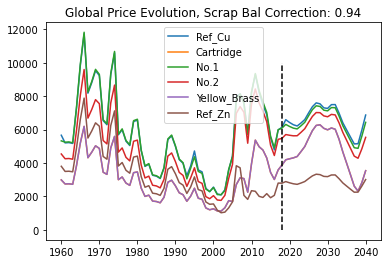

<Figure size 432x288 with 0 Axes>

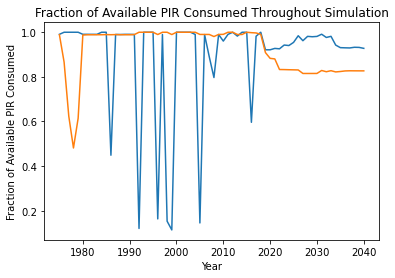

___________________________________________________________________
NEW SCENARIO: test (4)
2022-02-09 11:41:49.499801
PIR Fraction: -1
Fruity RR: [0.01, 0.01, 0.01, 0.01, 0, 0, 0, 0]
Import multiplier: 1
Scrap imports:             No.1        No.2  Al_Bronze  Cartridge Mn_Bronze      Ni_Ag  \
2018  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2019  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2020  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2021  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2022  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2023  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2024  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2025  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2026  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2027  453.789825  579.563063  2

Pass 6 : Ref_Cu exceeds historical by 44.0 kt.
	Old tune: 1.258 	New tune: 1.252
	Total direct melt scrap demand, China:  20184.81814515567
	Total direct melt scrap demand, RoW:  17283.206372365566
   2023 test
	ref prod:  25563.05862878482  ref demand:  25844.721082484823
	Mines closing this year: 5
	New mines opening this year:  57
	Total mining production:  21667.164420529054
	Total scrap supply, China:  2919.26687417231
	Total scrap supply, RoW:  7810.347479466355
		PIR price: 0.2 times refined copper price
Pass 1 : Ref_Cu exceeds historical by 65.0 kt.
	Old tune: 1.29 	New tune: 1.284
Pass 2 : Ref_Cu exceeds historical by 65.0 kt.
	Old tune: 1.284 	New tune: 1.277
Pass 3 : Ref_Cu exceeds historical by 65.0 kt.
	Old tune: 1.277 	New tune: 1.271
Pass 4 : Ref_Cu exceeds historical by 65.0 kt.
	Old tune: 1.271 	New tune: 1.265
Pass 5 : Ref_Cu exceeds historical by 65.0 kt.
	Old tune: 1.265 	New tune: 1.258
Pass 6 : Ref_Cu exceeds historical by 65.0 kt.
	Old tune: 1.258 	New tune: 1.25

	Mines closing this year: 2
	New mines opening this year:  42
	Total mining production:  24307.349344382317
	Total scrap supply, China:  4161.416243325773
	Total scrap supply, RoW:  7799.425381843267
		PIR price: 0.2 times refined copper price
Pass 1 : Ref_Cu exceeds historical by 62.0 kt.
	Old tune: 1.29 	New tune: 1.284
Pass 2 : Ref_Cu exceeds historical by 62.0 kt.
	Old tune: 1.284 	New tune: 1.277
Pass 3 : Ref_Cu exceeds historical by 62.0 kt.
	Old tune: 1.277 	New tune: 1.271
Pass 4 : Ref_Cu exceeds historical by 62.0 kt.
	Old tune: 1.271 	New tune: 1.265
Pass 5 : Ref_Cu exceeds historical by 62.0 kt.
	Old tune: 1.265 	New tune: 1.258
Pass 6 : Ref_Cu exceeds historical by 62.0 kt.
	Old tune: 1.258 	New tune: 1.252
Pass 7 : Ref_Cu exceeds historical by 62.0 kt.
	Old tune: 1.252 	New tune: 1.246
Pass 8 : Ref_Cu exceeds historical by 62.0 kt.
	Old tune: 1.246 	New tune: 1.24
Pass 9 : Ref_Cu exceeds historical by 62.0 kt.
	Old tune: 1.24 	New tune: 1.233
Pass 10 : Ref_Cu exceeds histo

Pass 1 : Ref_Cu exceeds historical by 37.0 kt.
	Old tune: 1.29 	New tune: 1.284
	Total direct melt scrap demand, China:  26221.284222775423
	Total direct melt scrap demand, RoW:  19195.76106689375
   2039 test
	ref prod:  30151.50482494481  ref demand:  31284.849855244123
	Mines closing this year: 68
	New mines opening this year:  120
	Total mining production:  24467.23088300475
	Total scrap supply, China:  6347.548772373555
	Total scrap supply, RoW:  8030.027738657886
		PIR price: 0.2 times refined copper price
Pass 1 : Ref_Cu exceeds historical by 51.0 kt.
	Old tune: 1.29 	New tune: 1.284
Pass 2 : Ref_Cu exceeds historical by 24.0 kt.
	Old tune: 1.284 	New tune: 1.277
	Total direct melt scrap demand, China:  26958.867677835322
	Total direct melt scrap demand, RoW:  19592.42918970317
   2040 test
	ref prod:  30202.125310815438  ref demand:  31615.95720987313
	Mines closing this year: 86
	New mines opening this year:  38
	Total mining production:  23794.679149012103
	Total scrap supply

<Figure size 432x288 with 0 Axes>

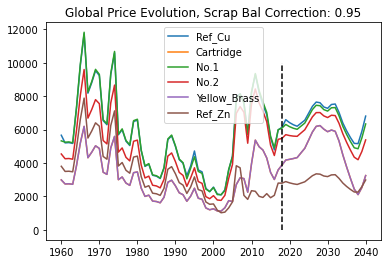

<Figure size 432x288 with 0 Axes>

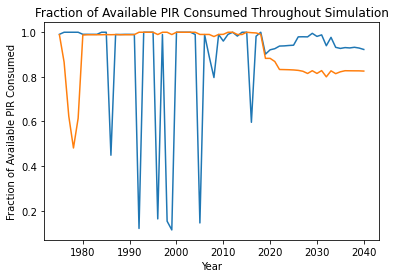

___________________________________________________________________
NEW SCENARIO: test (5)
2022-02-09 12:58:57.907950
PIR Fraction: -1
Fruity RR: [0.01, 0.01, 0.01, 0.01, 0, 0, 0, 0]
Import multiplier: 1
Scrap imports:             No.1        No.2  Al_Bronze  Cartridge Mn_Bronze      Ni_Ag  \
2018  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2019  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2020  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2021  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2022  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2023  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2024  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2025  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2026  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2027  453.789825  579.563063  2

	Mines closing this year: 5
	New mines opening this year:  57
	Total mining production:  21661.75359598099
	Total scrap supply, China:  2919.3195591135095
	Total scrap supply, RoW:  7810.380448220731
		PIR price: 0.2 times refined copper price
Pass 1 : Ref_Cu exceeds historical by 61.0 kt.
	Old tune: 1.29 	New tune: 1.284
Pass 2 : Ref_Cu exceeds historical by 61.0 kt.
	Old tune: 1.284 	New tune: 1.277
Pass 3 : Ref_Cu exceeds historical by 61.0 kt.
	Old tune: 1.277 	New tune: 1.271
Pass 4 : Ref_Cu exceeds historical by 61.0 kt.
	Old tune: 1.271 	New tune: 1.265
Pass 5 : Ref_Cu exceeds historical by 44.0 kt.
	Old tune: 1.265 	New tune: 1.258
	Total direct melt scrap demand, China:  20777.05769373071
	Total direct melt scrap demand, RoW:  17324.234002363617
   2024 test
	ref prod:  26002.088779507707  ref demand:  26284.679727992247
	Mines closing this year: 8
	New mines opening this year:  34
	Total mining production:  22107.193733618475
	Total scrap supply, China:  3059.650685133704
	To

Pass 7 : Ref_Cu exceeds historical by 69.0 kt.
	Old tune: 1.252 	New tune: 1.246
Pass 8 : Ref_Cu exceeds historical by 51.0 kt.
	Old tune: 1.246 	New tune: 1.24
Pass 9 : Ref_Cu exceeds historical by 51.0 kt.
	Old tune: 1.24 	New tune: 1.233
Pass 10 : Ref_Cu exceeds historical by 51.0 kt.
	Old tune: 1.233 	New tune: 1.227
Pass 11 : Ref_Cu exceeds historical by 28.0 kt.
	Old tune: 1.227 	New tune: 1.221
	Total direct melt scrap demand, China:  22807.948500771432
	Total direct melt scrap demand, RoW:  17645.776465232088
   2031 test
	ref prod:  27808.54570211778  ref demand:  28173.541509651222
	Mines closing this year: 0
	New mines opening this year:  44
	Total mining production:  25193.326310443255
	Total scrap supply, China:  4432.508789795668
	Total scrap supply, RoW:  7865.277538609415
		PIR price: 0.2 times refined copper price
Pass 1 : Ref_Cu exceeds historical by 61.0 kt.
	Old tune: 1.29 	New tune: 1.284
Pass 2 : Ref_Cu exceeds historical by 61.0 kt.
	Old tune: 1.284 	New tune: 1.

	Mines closing this year: 73
	New mines opening this year:  38
	Total mining production:  24027.515838596286
	Total scrap supply, China:  6546.232900880655
	Total scrap supply, RoW:  8009.862164612772
		PIR price: 0.2 times refined copper price
Pass 1 : Ref_Cu exceeds historical by 56.0 kt.
	Old tune: 1.29 	New tune: 1.284
Pass 2 : Ref_Cu exceeds historical by 28.0 kt.
	Old tune: 1.284 	New tune: 1.277
	Total direct melt scrap demand, China:  27306.544525800924
	Total direct melt scrap demand, RoW:  19970.068022924854
2022-02-09 13:29:48.515051
	Data/scenario results/John/05 China/price test.xlsx
2022-02-09 13:30:09.767859


<Figure size 432x288 with 0 Axes>

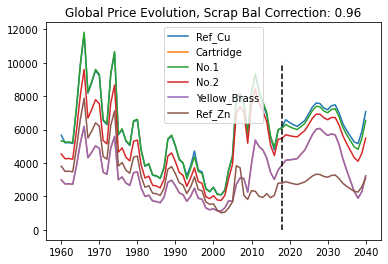

<Figure size 432x288 with 0 Axes>

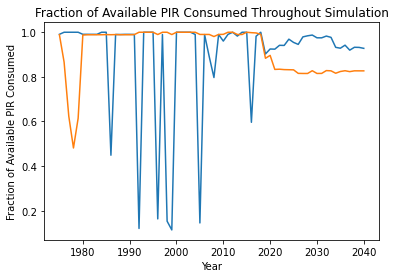

___________________________________________________________________
NEW SCENARIO: test (6)
2022-02-09 13:30:10.575568
PIR Fraction: -1
Fruity RR: [0.01, 0.01, 0.01, 0.01, 0, 0, 0, 0]
Import multiplier: 1
Scrap imports:             No.1        No.2  Al_Bronze  Cartridge Mn_Bronze      Ni_Ag  \
2018  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2019  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2020  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2021  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2022  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2023  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2024  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2025  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2026  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2027  453.789825  579.563063  2

	Total scrap supply, China:  2773.1649542737878
	Total scrap supply, RoW:  7815.844984849959
		PIR price: 0.2 times refined copper price
Pass 1 : Ref_Cu exceeds historical by 52.0 kt.
	Old tune: 1.29 	New tune: 1.284
Pass 2 : Ref_Cu exceeds historical by 52.0 kt.
	Old tune: 1.284 	New tune: 1.277
Pass 3 : Ref_Cu exceeds historical by 52.0 kt.
	Old tune: 1.277 	New tune: 1.271
Pass 4 : Ref_Cu exceeds historical by 52.0 kt.
	Old tune: 1.271 	New tune: 1.265
Pass 5 : Ref_Cu exceeds historical by 52.0 kt.
	Old tune: 1.265 	New tune: 1.258
Pass 6 : Ref_Cu exceeds historical by 52.0 kt.
	Old tune: 1.258 	New tune: 1.252
Pass 7 : Ref_Cu exceeds historical by 52.0 kt.
	Old tune: 1.252 	New tune: 1.246
Pass 8 : Ref_Cu exceeds historical by 52.0 kt.
	Old tune: 1.246 	New tune: 1.24
Pass 9 : Ref_Cu exceeds historical by 52.0 kt.
	Old tune: 1.24 	New tune: 1.233
Pass 10 : Ref_Cu exceeds historical by 52.0 kt.
	Old tune: 1.233 	New tune: 1.227
Pass 11 : Ref_Cu exceeds historical by 32.0 kt.
	Old tu

Pass 12 : Ref_Cu exceeds historical by 59.0 kt.
	Old tune: 1.221 	New tune: 1.215
Pass 13 : Ref_Cu exceeds historical by 36.0 kt.
	Old tune: 1.215 	New tune: 1.209
	Total direct melt scrap demand, China:  22435.9806974401
	Total direct melt scrap demand, RoW:  17499.504005800212
   2029 test
	ref prod:  28016.217303866917  ref demand:  27598.363957348192
	Mines closing this year: 2
	New mines opening this year:  41
	Total mining production:  23999.76260229716
	Total scrap supply, China:  3908.3424501671375
	Total scrap supply, RoW:  7745.407585218712
		PIR price: 0.2 times refined copper price
Pass 1 : Ref_Cu exceeds historical by 68.0 kt.
	Old tune: 1.29 	New tune: 1.284
Pass 2 : Ref_Cu exceeds historical by 68.0 kt.
	Old tune: 1.284 	New tune: 1.277
Pass 3 : Ref_Cu exceeds historical by 68.0 kt.
	Old tune: 1.277 	New tune: 1.271
Pass 4 : Ref_Cu exceeds historical by 68.0 kt.
	Old tune: 1.271 	New tune: 1.265
Pass 5 : Ref_Cu exceeds historical by 68.0 kt.
	Old tune: 1.265 	New tune: 1

Pass 1 : Ref_Cu exceeds historical by 61.0 kt.
	Old tune: 1.29 	New tune: 1.284
Pass 2 : Ref_Cu exceeds historical by 61.0 kt.
	Old tune: 1.284 	New tune: 1.277
Pass 3 : Ref_Cu exceeds historical by 56.0 kt.
	Old tune: 1.277 	New tune: 1.271
Pass 4 : Ref_Cu exceeds historical by 16.0 kt.
	Old tune: 1.271 	New tune: 1.265
	Total direct melt scrap demand, China:  25561.706726357217
	Total direct melt scrap demand, RoW:  18903.97618302092
   2038 test
	ref prod:  30957.500317443504  ref demand:  30781.645366750556
	Mines closing this year: 34
	New mines opening this year:  31
	Total mining production:  24901.46083632351
	Total scrap supply, China:  6140.602366687496
	Total scrap supply, RoW:  8044.337395059374
		PIR price: 0.2 times refined copper price
Pass 1 : Ref_Cu exceeds historical by 34.0 kt.
	Old tune: 1.29 	New tune: 1.284
	Total direct melt scrap demand, China:  26168.968301175817
	Total direct melt scrap demand, RoW:  19237.331119210765
   2039 test
	ref prod:  30058.0095628932

<Figure size 432x288 with 0 Axes>

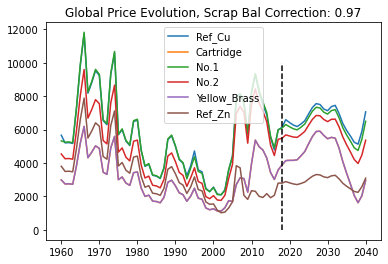

<Figure size 432x288 with 0 Axes>

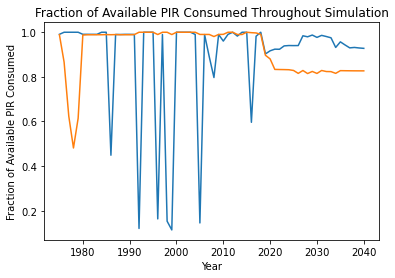

___________________________________________________________________
NEW SCENARIO: test (7)
2022-02-09 14:02:29.663934
PIR Fraction: -1
Fruity RR: [0.01, 0.01, 0.01, 0.01, 0, 0, 0, 0]
Import multiplier: 1
Scrap imports:             No.1        No.2  Al_Bronze  Cartridge Mn_Bronze      Ni_Ag  \
2018  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2019  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2020  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2021  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2022  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2023  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2024  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2025  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2026  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2027  453.789825  579.563063  2

Pass 7 : Ref_Cu exceeds historical by 35.0 kt.
	Old tune: 1.252 	New tune: 1.246
	Total direct melt scrap demand, China:  20232.496894008545
	Total direct melt scrap demand, RoW:  17308.098505704333
   2023 test
	ref prod:  25620.805380456477  ref demand:  25837.4121159091
	Mines closing this year: 6
	New mines opening this year:  57
	Total mining production:  21623.469881157966
	Total scrap supply, China:  2919.6563892719796
	Total scrap supply, RoW:  7810.591177550877
		PIR price: 0.2 times refined copper price
Pass 1 : Ref_Cu exceeds historical by 56.0 kt.
	Old tune: 1.29 	New tune: 1.284
Pass 2 : Ref_Cu exceeds historical by 56.0 kt.
	Old tune: 1.284 	New tune: 1.277
Pass 3 : Ref_Cu exceeds historical by 56.0 kt.
	Old tune: 1.277 	New tune: 1.271
Pass 4 : Ref_Cu exceeds historical by 56.0 kt.
	Old tune: 1.271 	New tune: 1.265
Pass 5 : Ref_Cu exceeds historical by 56.0 kt.
	Old tune: 1.265 	New tune: 1.258
Pass 6 : Ref_Cu exceeds historical by 56.0 kt.
	Old tune: 1.258 	New tune: 1.

	Total scrap supply, China:  4164.738130577491
	Total scrap supply, RoW:  7801.2123024850525
		PIR price: 0.2 times refined copper price
Pass 1 : Ref_Cu exceeds historical by 70.0 kt.
	Old tune: 1.29 	New tune: 1.284
Pass 2 : Ref_Cu exceeds historical by 70.0 kt.
	Old tune: 1.284 	New tune: 1.277
Pass 3 : Ref_Cu exceeds historical by 70.0 kt.
	Old tune: 1.277 	New tune: 1.271
Pass 4 : Ref_Cu exceeds historical by 70.0 kt.
	Old tune: 1.271 	New tune: 1.265
Pass 5 : Ref_Cu exceeds historical by 70.0 kt.
	Old tune: 1.265 	New tune: 1.258
Pass 6 : Ref_Cu exceeds historical by 53.0 kt.
	Old tune: 1.258 	New tune: 1.252
Pass 7 : Ref_Cu exceeds historical by 53.0 kt.
	Old tune: 1.252 	New tune: 1.246
Pass 8 : Ref_Cu exceeds historical by 53.0 kt.
	Old tune: 1.246 	New tune: 1.24
Pass 9 : Ref_Cu exceeds historical by 53.0 kt.
	Old tune: 1.24 	New tune: 1.233
Pass 10 : Ref_Cu exceeds historical by 53.0 kt.
	Old tune: 1.233 	New tune: 1.227
Pass 11 : Ref_Cu exceeds historical by 53.0 kt.
	Old tu

Pass 1 : Ref_Cu exceeds historical by 47.0 kt.
	Old tune: 1.29 	New tune: 1.284
	Total direct melt scrap demand, China:  26946.321605365938
	Total direct melt scrap demand, RoW:  19676.82145912599
   2040 test
	ref prod:  30023.97862540799  ref demand:  31528.604784278952
	Mines closing this year: 56
	New mines opening this year:  37
	Total mining production:  24867.156142416614
	Total scrap supply, China:  6548.799838520278
	Total scrap supply, RoW:  8010.854666930909
		PIR price: 0.2 times refined copper price
Pass 1 : Ref_Cu exceeds historical by 29.0 kt.
	Old tune: 1.29 	New tune: 1.284
	Total direct melt scrap demand, China:  27204.55067853836
	Total direct melt scrap demand, RoW:  19966.750319678944
2022-02-09 14:32:21.601615
	Data/scenario results/John/05 China/price test.xlsx
2022-02-09 14:32:37.957892


<Figure size 432x288 with 0 Axes>

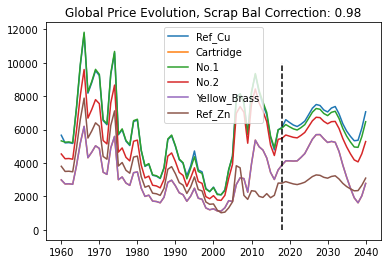

<Figure size 432x288 with 0 Axes>

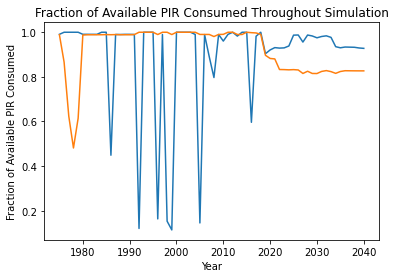

___________________________________________________________________
NEW SCENARIO: test (8)
2022-02-09 14:32:38.748326
PIR Fraction: -1
Fruity RR: [0.01, 0.01, 0.01, 0.01, 0, 0, 0, 0]
Import multiplier: 1
Scrap imports:             No.1        No.2  Al_Bronze  Cartridge Mn_Bronze      Ni_Ag  \
2018  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2019  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2020  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2021  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2022  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2023  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2024  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2025  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2026  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2027  453.789825  579.563063  2

	Mines closing this year: 8
	New mines opening this year:  34
	Total mining production:  22053.340530040503
	Total scrap supply, China:  3060.4544167922986
	Total scrap supply, RoW:  7799.007290515829
		PIR price: 0.2 times refined copper price
Pass 1 : Ref_Cu exceeds historical by 54.0 kt.
	Old tune: 1.29 	New tune: 1.284
Pass 2 : Ref_Cu exceeds historical by 54.0 kt.
	Old tune: 1.284 	New tune: 1.277
Pass 3 : Ref_Cu exceeds historical by 54.0 kt.
	Old tune: 1.277 	New tune: 1.271
Pass 4 : Ref_Cu exceeds historical by 54.0 kt.
	Old tune: 1.271 	New tune: 1.265
Pass 5 : Ref_Cu exceeds historical by 54.0 kt.
	Old tune: 1.265 	New tune: 1.258
Pass 6 : Ref_Cu exceeds historical by 54.0 kt.
	Old tune: 1.258 	New tune: 1.252
Pass 7 : Ref_Cu exceeds historical by 54.0 kt.
	Old tune: 1.252 	New tune: 1.246
Pass 8 : Ref_Cu exceeds historical by 54.0 kt.
	Old tune: 1.246 	New tune: 1.24
Pass 9 : Ref_Cu exceeds historical by 51.0 kt.
	Old tune: 1.24 	New tune: 1.233
Pass 10 : Ref_Cu exceeds hist

	Mines closing this year: 3
	New mines opening this year:  41
	Total mining production:  25081.918126349017
	Total scrap supply, China:  4435.199113870206
	Total scrap supply, RoW:  7866.702626141632
		PIR price: 0.2 times refined copper price
Pass 1 : Ref_Cu exceeds historical by 74.0 kt.
	Old tune: 1.29 	New tune: 1.284
Pass 2 : Ref_Cu exceeds historical by 74.0 kt.
	Old tune: 1.284 	New tune: 1.277
Pass 3 : Ref_Cu exceeds historical by 74.0 kt.
	Old tune: 1.277 	New tune: 1.271
Pass 4 : Ref_Cu exceeds historical by 74.0 kt.
	Old tune: 1.271 	New tune: 1.265
Pass 5 : Ref_Cu exceeds historical by 50.0 kt.
	Old tune: 1.265 	New tune: 1.258
Pass 6 : Ref_Cu exceeds historical by 50.0 kt.
	Old tune: 1.258 	New tune: 1.252
Pass 7 : Ref_Cu exceeds historical by 50.0 kt.
	Old tune: 1.252 	New tune: 1.246
Pass 8 : Ref_Cu exceeds historical by 50.0 kt.
	Old tune: 1.246 	New tune: 1.24
Pass 9 : Ref_Cu exceeds historical by 50.0 kt.
	Old tune: 1.24 	New tune: 1.233
Pass 10 : Ref_Cu exceeds histo

	Data/scenario results/John/05 China/price test.xlsx
2022-02-09 15:02:16.459991


<Figure size 432x288 with 0 Axes>

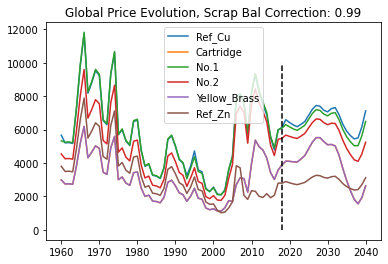

<Figure size 432x288 with 0 Axes>

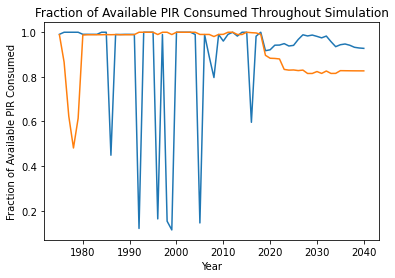

___________________________________________________________________
NEW SCENARIO: test (9)
2022-02-09 15:02:17.092710
PIR Fraction: -1
Fruity RR: [0.01, 0.01, 0.01, 0.01, 0, 0, 0, 0]
Import multiplier: 1
Scrap imports:             No.1        No.2  Al_Bronze  Cartridge Mn_Bronze      Ni_Ag  \
2018  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2019  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2020  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2021  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2022  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2023  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2024  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2025  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2026  453.789825  579.563063  26.488302  30.453831  2.221087  24.665728   
2027  453.789825  579.563063  2

Pass 6 : Ref_Cu exceeds historical by 60.0 kt.
	Old tune: 1.258 	New tune: 1.252
Pass 7 : Ref_Cu exceeds historical by 40.0 kt.
	Old tune: 1.252 	New tune: 1.246
	Total direct melt scrap demand, China:  20254.128656466208
	Total direct melt scrap demand, RoW:  17325.021685139596
   2023 test
	ref prod:  25643.97442867154  ref demand:  25843.71848373825
	Mines closing this year: 6
	New mines opening this year:  57
	Total mining production:  21615.078816893947
	Total scrap supply, China:  2919.8528598325793
	Total scrap supply, RoW:  7810.714054409559
		PIR price: 0.2 times refined copper price
Pass 1 : Ref_Cu exceeds historical by 50.0 kt.
	Old tune: 1.29 	New tune: 1.284
	Total direct melt scrap demand, China:  20843.988489106774
	Total direct melt scrap demand, RoW:  17365.233474608456
   2024 test
	ref prod:  26039.920892423223  ref demand:  26300.501442007404
	Mines closing this year: 8
	New mines opening this year:  34
	Total mining production:  22047.488366918034
	Total scrap supp

Pass 3 : Ref_Cu exceeds historical by 60.0 kt.
	Old tune: 1.277 	New tune: 1.271
Pass 4 : Ref_Cu exceeds historical by 60.0 kt.
	Old tune: 1.271 	New tune: 1.265
Pass 5 : Ref_Cu exceeds historical by 60.0 kt.
	Old tune: 1.265 	New tune: 1.258
Pass 6 : Ref_Cu exceeds historical by 60.0 kt.
	Old tune: 1.258 	New tune: 1.252
Pass 7 : Ref_Cu exceeds historical by 60.0 kt.
	Old tune: 1.252 	New tune: 1.246
Pass 8 : Ref_Cu exceeds historical by 60.0 kt.
	Old tune: 1.246 	New tune: 1.24
Pass 9 : Ref_Cu exceeds historical by 60.0 kt.
	Old tune: 1.24 	New tune: 1.233
Pass 10 : Ref_Cu exceeds historical by 60.0 kt.
	Old tune: 1.233 	New tune: 1.227
Pass 11 : Ref_Cu exceeds historical by 60.0 kt.
	Old tune: 1.227 	New tune: 1.221
Pass 12 : Ref_Cu exceeds historical by 37.0 kt.
	Old tune: 1.221 	New tune: 1.215
	Total direct melt scrap demand, China:  22980.44969238318
	Total direct melt scrap demand, RoW:  17742.428294869555
   2031 test
	ref prod:  27966.928125177874  ref demand:  28258.32889732

	Mines closing this year: 15
	New mines opening this year:  37
	Total mining production:  25680.09285332226
	Total scrap supply, China:  6551.1168937751845
	Total scrap supply, RoW:  8011.774222333835
		PIR price: 0.2 times refined copper price
Pass 1 : Ref_Cu exceeds historical by 47.0 kt.
	Old tune: 1.29 	New tune: 1.284
	Total direct melt scrap demand, China:  27151.673803374397
	Total direct melt scrap demand, RoW:  19968.510332498136
2022-02-09 15:32:33.562467
	Data/scenario results/John/05 China/price test.xlsx
2022-02-09 15:32:48.819246


<Figure size 432x288 with 0 Axes>

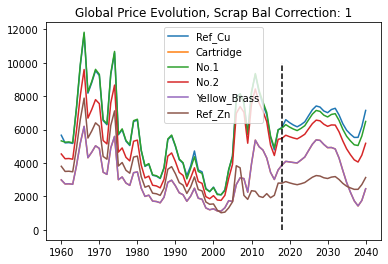

<Figure size 432x288 with 0 Axes>

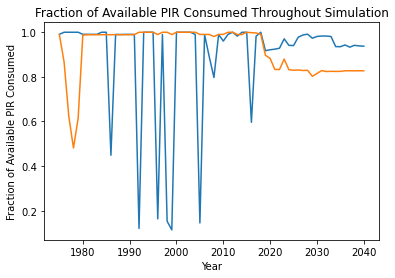

In [140]:
# %matplotlib notebook
# plt.style.use('ggplot')
og_recycled_content = 0
rc_variance = 0
tcrc_multiplier_cn = 0
covid = 0
gdp_multiplier = 1
tune_error_allowance = 50

# -1 is for 0.08, -2 is for 0.09 on with pir_fraction = 0.08 for year_i onward if blending fails:
# scenarios = ['fruity times 10rr0 20200626',
#              'fruity times 10rr3 pir_fraction=0 pir_price=0.75',
#              'fruity times 10rr6 pir_fraction=0 pir_price=0.75',
#              'fruity times 10rr9 pir_fraction=0 pir_price=0.75',
#              'fruity times 10rr12 pir_fraction=0 pir_price=0.75',
#              'fruity times 10rr15 pir_fraction=0 pir_price=0.75',
#              'fruity times 10rr18 pir_fraction=0 pir_price=0.75',
#              'fruity times 10rr1 pir_fraction=0.03 pir_price=0.75',
#              'fruity times 10rr1 pir_fraction=0.06 pir_price=0.75',
#              'fruity times 10rr1 pir_fraction=0.09 pir_price=0.75',
#              'fruity times 10rr1 pir_fraction=0.12 pir_price=0.75',
#              'fruity times 10rr1 pir_fraction=0.15 pir_price=0.75',
#              'fruity times 10rr1 pir_fraction=0.18 pir_price=0.75']
scenarios = ['test','test','test','test','test','test','test','test','test','test']
linear_scenario_data = pd.read_excel('Data\scrap supply\Zeng nat comm 2020 CN import estimates.xlsx',index_col=0).shift(2).dropna()
linear_lower_bound = linear_scenario_data.loc[:,'Lower bound (kt)']
linear_mean = linear_scenario_data.loc[:,'Mean (kt)']
linear_upper_bound = linear_scenario_data.loc[:,'Upper bound (kt)']

scrappy = 0

# starting at 6 before
for scenario in np.arange(0,len(scenarios)):
    print('___________________________________________________________________\nNEW SCENARIO:', scenarios[scenario], '('+str(scenario)+')')
    system_initialization()
    %store -r
    
    
     # Defining scenarios
#     for i in np.arange(2019,2041):
#         historical_ref_imports_cn.loc[i] = historical_ref_imports_cn.loc[2018]
#     print('Refined imports:',historical_ref_imports_cn.loc[2018:])
    
    pir_price = 0.2
    scrap_bal_loss = 1#[0.50,0.55,0.6,0.65,0.70,0.75,0.80][scenario]
    scrap_bal_correction = [0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1][scenario]
#     if scenario == 0:
#         fruity_rr = [0,0,0,0]
#     else:
#         fruity_rr = np.repeat(float(scenarios[scenario].split()[2].split('rr')[-1])/100,4)
#         if fruity_rr[0] > 0.5:
#             fruity_rr = [fruity_rr[0], 0.5, 0.5, 0.5]
#         pir_fraction = float(scenarios[scenario].split()[3].split('=')[-1])
    print('PIR Fraction:',pir_fraction)
    print('Fruity RR:', fruity_rr)
    # Easiest scrap import control
    import_multiplier = 1
    if ' 50yoy ' in scenarios[scenario]:
        import_multiplier = 0.5
    elif ' 75yoy ' in scenarios[scenario]:
        import_multiplier = 0.75
    elif ' 25yoy ' in scenarios[scenario]:
        import_multiplier = 0.25
    print('Import multiplier:',import_multiplier)
    
    if ' baseline ' in scenarios[scenario]:
        scrap_imports_cn_all = og_scrap_imports_cn_all.copy()
           
    elif ' No.2 ' in scenarios[scenario]:
        scrap_imports_cn_all = og_scrap_imports_cn_all.copy()
        for i in np.arange(2019,2041):
            scrap_imports_cn_all.loc[i,'No.2'] = scrap_imports_cn_all.loc[i-1,'No.2'] * import_multiplier
                
    elif ' alloyed ' in scenarios[scenario]:
        scrap_imports_cn_all = og_scrap_imports_cn_all.copy()
        for i in np.arange(2019,2041):
            scrap_imports_cn_all.loc[i,'Al_Bronze':] = scrap_imports_cn_all.loc[i-1,'Al_Bronze':] * import_multiplier
                
    elif ' both ' in scenarios[scenario]:
        scrap_imports_cn_all = og_scrap_imports_cn_all.copy()
        for i in np.arange(2019,2041):
            scrap_imports_cn_all.loc[i,'No.2':] = scrap_imports_cn_all.loc[i-1,'No.2':] * import_multiplier
    print('Scrap imports:',scrap_imports_cn_all.loc[2018:])

    
    # Defining scenarios for refined import sensitivities
    for i in np.arange(2019,2041):
        historical_ref_imports_cn.loc[i] = historical_ref_imports_cn.loc[2018]
        if ' inc' in scenarios[scenario]:
            if  ' 200' in scenarios[scenario]:
                historical_ref_imports_cn.loc[i] = historical_ref_imports_cn.loc[2018] + (i-2018)*200
            else:
                historical_ref_imports_cn.loc[i] = historical_ref_imports_cn.loc[2018] + (i-2018)*100
        elif ' dec' in scenarios[scenario]:
            if ' 200' in scenarios[scenario]:
                historical_ref_imports_cn.loc[i] = historical_ref_imports_cn.loc[2018] - (i-2018)*200
            else:
                historical_ref_imports_cn.loc[i] = historical_ref_imports_cn.loc[2018] - (i-2018)*100
    historical_ref_imports_cn.loc[historical_ref_imports_cn<0] = 0
    print(historical_ref_imports_cn.loc[2018:])
    
    print(str(datetime.now()))
    mine_life_stats_panel_operating=mine_life_stats_panel_init(simulation_time, operating_mine_pool)
    mine_pool_new_last=pd.DataFrame()
    mine_life_stats_panel_new_last=pd.DataFrame()
    volume_prediction_base=pd.read_excel('Data/semis demand/Demand prediction data.xlsx', sheet_name='All sectors', index_col=0, header=[0,1])

    for year_i in np.arange(2018, 2041):

        print('  ', year_i, scenarios[scenario])
        t=pd.datetime(year_i, 1, 1)
        t_lag_1=pd.datetime(year_i-1, 1, 1)
        t_lag_2=pd.datetime(year_i-2, 1, 1)

        #### Scenario parameters ####
        sort_eff=sort_eff_series.loc[year_i]
        collect_rate=collect_rate_series.loc[year_i]

        #### Price formation ####
        if year_i > 2018:        
            ### Cathode price ###
            if True:
                cathode_bal_l1.loc[year_i]=ref_prod_series.loc[t_lag_1]-ref_demand_series.loc[t_lag_1]
                print('\tref prod: ', ref_prod_series.loc[t_lag_1], ' ref demand: ', ref_demand_series.loc[t_lag_1])
                cathode_price_series.loc[t]=cathode_price_predict(cathode_price_series.loc[t_lag_1], 
                                                                  cathode_balance=cathode_bal_l1.loc[year_i], cathode_sd_elas=cathode_sd_elas)

            ### TCRC ###
            if True:
                conc_bal_l1.loc[year_i]=conc_prod_series.loc[t_lag_1]-ref_stats.loc[t_lag_1, 'Primary production']/conc_to_cathode_eff
                tcrc_series.loc[t]=tcrc_predict(tcrc_series.loc[t_lag_1], \
                                                conc_balance=conc_bal_l1.loc[year_i], conc_sd_elas=conc_sd_elas)
                tcrc_series_cn.loc[t] = tcrc_series.copy().loc[t]
                tcrc_series_rw.loc[t] = tcrc_series.copy().loc[t]
                if tcrc_multiplier_cn != 0 and year_i <= tcrc_years+2018:
                    if 'cn' in scenarios[scenario].split()[1]:
                        tcrc_series_cn.loc[t] *= tcrc_multiplier_cn
                    if 'rw' in scenarios[scenario].split()[1]:
                        tcrc_series_rw.loc[t] *= tcrc_multiplier_rw
                    print('\t\tCN TCRC:', tcrc_series_cn.loc[t], 'Global TCRC:', tcrc_series.loc[t])
            
            ### Scrap Spreads and other refined metal prices ### default is inventory=1 and scrappy=2
            if True:
                if inventory == 1:
                    scrap_bal_l1.loc[year_i] = old_scrap_available_no_accumulation.sum(axis=1).loc[year_i-1] - total_scrap_demand_all_life.loc[year_i-1].sum() / scrap_bal_correction
                    scrap_bal_l1_cn.loc[year_i] = old_scrap_available_no_accumulation_cn.sum(axis=1).loc[year_i-1] - total_scrap_demand_all_life_cn.loc[year_i-1].sum() / scrap_bal_correction
                    scrap_bal_l1_rw.loc[year_i] = old_scrap_available_no_accumulation_rw.sum(axis=1).loc[year_i-1] - total_scrap_demand_all_life_rw.loc[year_i-1].sum() / scrap_bal_correction
                    if scrappy == 2:
                        scrap_bal_l1.loc[year_i] = old_scrap_available_no_accumulation.loc[year_i-1, scrap_subset].sum() - total_scrap_demand_all_life.loc[year_i-1].sum() / scrap_bal_correction
                        scrap_bal_l1_cn.loc[year_i] = old_scrap_available_no_accumulation_cn.loc[year_i-1, scrap_subset].sum() - total_scrap_demand_all_life_cn.loc[year_i-1].sum() / scrap_bal_correction
                        scrap_bal_l1_rw.loc[year_i] = old_scrap_available_no_accumulation_rw.loc[year_i-1, scrap_subset].sum() - total_scrap_demand_all_life_rw.loc[year_i-1].sum() / scrap_bal_correction
                else:
                    scrap_bal_l1.loc[year_i] = old_scrap_available.sum(axis=1).loc[year_i-1]-total_scrap_demand_all_life.sum(axis=1).loc[year_i-1]
                    scrap_bal_l1_cn.loc[year_i] = old_scrap_available_cn.sum(axis=1).loc[year_i-1]-total_scrap_demand_all_life_cn.sum(axis=1).loc[year_i-1]
                    scrap_bal_l1_rw.loc[year_i] = old_scrap_available_rw.sum(axis=1).loc[year_i-1]-total_scrap_demand_all_life_rw.sum(axis=1).loc[year_i-1]

                cathode_price_diff=cathode_price_series.loc[t]-cathode_price_series.loc[t_lag_1]
                sp2_series.loc[t]=sp2_predict(sp2_series.loc[t_lag_1], \
                                              scrap_balance=scrap_bal_l1.loc[year_i], scrap_sd_elas=sp2_sd_elas, \
                                              cathode_diff=cathode_price_diff, cathode_sp2_elas=cathode_sp2_elas)
                sp2_series_cn.loc[t]=sp2_predict(sp2_series_cn.loc[t_lag_1], \
                                              scrap_balance=scrap_bal_l1_cn.loc[year_i], scrap_sd_elas=sp2_sd_elas_cn, \
                                              cathode_diff=cathode_price_diff, cathode_sp2_elas=cathode_sp2_elas)
                sp2_series_rw.loc[t]=sp2_predict(sp2_series_rw.loc[t_lag_1], \
                                              scrap_balance=scrap_bal_l1_rw.loc[year_i], scrap_sd_elas=sp2_sd_elas_rw,\
                                              cathode_diff=cathode_price_diff, cathode_sp2_elas=cathode_sp2_elas)
                sp1_series.loc[t]=sp1_predict(sp1_series.loc[t_lag_1],\
                                             scrap_balance=scrap_bal_l1.loc[year_i], scrap_sd_elas=sp1_sd_elas,\
                                             cathode_diff=cathode_price_diff, cathode_sp1_elas=cathode_sp1_elas)
                sp1_series_cn.loc[t]=sp1_predict(sp1_series_cn.loc[t_lag_1],\
                                             scrap_balance=scrap_bal_l1_cn.loc[year_i], scrap_sd_elas=sp1_sd_elas_cn,\
                                             cathode_diff=cathode_price_diff, cathode_sp1_elas=cathode_sp1_elas)
                sp1_series_rw.loc[t]=sp1_predict(sp1_series_rw.loc[t_lag_1],\
                                             scrap_balance=scrap_bal_l1_rw.loc[year_i], scrap_sd_elas=sp1_sd_elas_rw,\
                                             cathode_diff=cathode_price_diff, cathode_sp1_elas=cathode_sp1_elas)
                spa_series.loc[t]=alloy_predict(spa_series.loc[t_lag_1],\
                                             scrap_balance=scrap_bal_l1.loc[year_i], scrap_sd_elas=alloyed_sd_elas,\
                                             cathode_diff=cathode_price_diff, cathode_alloy_elas=cathode_alloyed_elas)
                spa_series_cn.loc[t]=alloy_predict(spa_series_cn.loc[t_lag_1],\
                                             scrap_balance=scrap_bal_l1_cn.loc[year_i], scrap_sd_elas=alloyed_sd_elas_cn,\
                                             cathode_diff=cathode_price_diff, cathode_alloy_elas=cathode_alloyed_elas)
                spa_series_rw.loc[t]=alloy_predict(spa_series_rw.loc[t_lag_1],\
                                             scrap_balance=scrap_bal_l1_rw.loc[year_i], scrap_sd_elas=alloyed_sd_elas_cn,\
                                             cathode_diff=cathode_price_diff, cathode_alloy_elas=cathode_alloyed_elas)
                raw_price.loc[year_i, 'Ref_Cu'] = cathode_price_series.loc[t]
                raw_price_cn.loc[year_i, 'Ref_Cu'] = cathode_price_series.loc[t]
                raw_price_rw.loc[year_i, 'Ref_Cu'] = cathode_price_series.loc[t]
                raw_price.loc[year_i, 'No.1'] = cathode_price_series.loc[t] - sp1_series.loc[t]
                raw_price_cn.loc[year_i, 'No.1'] = cathode_price_series.loc[t] - sp1_series_cn.loc[t]
                raw_price_rw.loc[year_i, 'No.1'] = cathode_price_series.loc[t] - sp1_series_rw.loc[t]
                raw_price.loc[year_i, 'No.2'] = cathode_price_series.loc[t] - sp2_series.loc[t]
                raw_price_cn.loc[year_i, 'No.2'] = cathode_price_series.loc[t] - sp2_series_cn.loc[t]
                raw_price_rw.loc[year_i, 'No.2'] = cathode_price_series.loc[t] - sp2_series_rw.loc[t]
                raw_price.loc[year_i, list(spa_series.columns)] = spa_series.loc[t].apply(lambda x: cathode_price_series.loc[t] - x)
                raw_price_cn.loc[year_i, list(spa_series.columns)] = spa_series_cn.loc[t].apply(lambda x: cathode_price_series.loc[t] - x)
                raw_price_rw.loc[year_i, list(spa_series.columns)] = spa_series_rw.loc[t].apply(lambda x: cathode_price_series.loc[t] - x)

                ### Refined (non-Cu) Metal Prices ### assumes they change proportionally to copper price
                raw_price.loc[year_i,ref_metals] = raw_price.loc[year_i-1,ref_metals].apply(lambda x: x * cathode_price_series[t] / cathode_price_series[t_lag_1])
                raw_price_cn.loc[year_i,ref_metals] = raw_price_cn.loc[year_i-1,ref_metals].apply(lambda x: x * cathode_price_series[t] / cathode_price_series[t_lag_1])
                raw_price_rw.loc[year_i,ref_metals] = raw_price_rw.loc[year_i-1,ref_metals].apply(lambda x: x * cathode_price_series[t] / cathode_price_series[t_lag_1])
                for metal in ref_metals:
                    if raw_price.loc[year_i,metal] < 100:
                        raw_price.loc[year_i,metal] = 100
                    if raw_price_cn.loc[year_i,metal] < 100:
                        raw_price_cn.loc[year_i,metal] = 100
                    if raw_price_rw.loc[year_i,metal] < 100:
                        raw_price_rw.loc[year_i,metal] = 100

        # TCRC to cents per pound
        tcrc_cpp_series = tcrc_series.copy().div(22.0462)


        #### Production of operating mine ####
        if True:
            for mine_id in operating_mine_pool.index:
                mine_data = operating_mine_pool.loc[mine_id]
                mine_life_stats = simulate_mine_life_stats_panel(simulation_time, year_i, 2018, \
                                                                 mine_life_stats_panel_operating, mine_data, \
                                                                 cathode_price_series, tcrc_cpp_series, pri_hyper_param)
                mine_life_stats_panel_operating.loc[:, idx[mine_id, :]]=mine_life_stats.loc[simulation_time, :].values

            # Total production statistics
            prod_operating=mine_life_stats_panel_operating.loc[:, idx[:, 'Recovered metal production (kt)']].sum(axis=1)
            sxew_operating=mine_life_stats_panel_operating.loc[:, idx[sxew_id_operating, 'Recovered metal production (kt)']].sum(axis=1)
            conc_operating=prod_operating-sxew_operating
            print('\tMines closing this year:', (mine_life_stats_panel_operating.loc[t,idx[:,'Ramp flag']] == 'Reclaim').sum())


            #### Production of new mines ####
            if year_i > 2018:
                # Read subsample size parameter and generate new incentive pool for year_i
                subsample_size=open_parameter.loc[year_i, 'Subsample size']
                mine_pool_new_year_i=new_mine_data(year_i, simulation_end_time, incentive_pool, cathode_price_series, tcrc_cpp_series,\
                                                   pri_hyper_param, subsample_size, irr_cutoff=0.15)
                print('\tNew mines opening this year: ', mine_pool_new_year_i.shape[0])

                # Initialize mine life panel data for incentive pool year_i
                mine_life_stats_panel_new_year_i=mine_life_stats_panel_init(simulation_time, mine_pool_new_year_i)

                # Append new incentive pool at year_i
                mine_pool_new=pd.concat([mine_pool_new_last, mine_pool_new_year_i])
                mine_life_stats_panel_new=pd.concat([mine_life_stats_panel_new_last, mine_life_stats_panel_new_year_i], axis=1)

                for mine_id in mine_pool_new.index:
                    mine_data = mine_pool_new.loc[mine_id]
                    mine_life_stats = simulate_mine_life_stats_panel(simulation_time, year_i, mine_data.loc['Initial year'], 
                                                                     mine_life_stats_panel_new, mine_data, 
                                                                     cathode_price_series, tcrc_cpp_series, pri_hyper_param)
                    mine_life_stats_panel_new.loc[:, idx[mine_id, :]]=mine_life_stats.loc[simulation_time, :].values


                # Total production statistics
                prod_new=mine_life_stats_panel_new.loc[:, idx[:, 'Recovered metal production (kt)']].sum(axis=1)
                sxew_new=mine_life_stats_panel_new.loc[:, idx[sxew_id_new, 'Recovered metal production (kt)']].sum(axis=1)
                conc_new=prod_new-sxew_new

                # Update incentive pool info
                mine_pool_new_last=mine_pool_new.copy()
                mine_life_stats_panel_new_last=mine_life_stats_panel_new.copy()


            #### Update total mining production ####
            if year_i == 2018:
                conc_new=pd.Series(0, index=simulation_time)
                prod_new=pd.Series(0, index=simulation_time)

            conc_prod_series.loc[t]=conc_operating.loc[t]+conc_new.loc[t]
            sxew_all.loc[t]=sxew_operating.loc[t]+sxew_new.loc[t]
            print('\tTotal mining production: ', prod_operating.loc[t]+prod_new.loc[t])


        #### Demand for refined copper ####
        if year_i == 2018:
            pass
        else:
            if year_i == 2020 and covid:
                gdp_growth_prediction_base.loc[2020] = gdp_growth_prediction_base.loc[2020].copy() * gdp_multiplier
    
            intensity_next=intensity_prediction_one_year(year_i, cathode_price_series, gdp_growth_prediction_base, \
                                                         intensity_prediction.loc[year_i-1, :], volume_prediction_base, \
                                                         elas_sec_reg, method='sec and reg')
            intensity_prediction.loc[year_i, :]=intensity_next.values
            demand_prediction.loc[year_i, :]=intensity_prediction.loc[year_i, :].mul(volume_prediction_base.loc[year_i, :]).values

            # COVID-19
            if covid == 1 and year_i == 2020:
                demand_prediction.loc[year_i, :] *= demand_multiplier
            elif covid == 1 and year_i == 2021:
                demand_prediction.loc[year_i, :] = demand_ph.copy()


        # Demand by shape and refined copper demand - beginning of China separation
        demand_by_sector_cn = demand_prediction.loc[:,idx[:,'China']].groupby(level=0,axis=1).sum()
        demand_by_sector_rw = demand_prediction.groupby(level=0,axis=1).sum() - demand_prediction.loc[:,idx[:,'China']].groupby(level=0,axis=1).sum()
#         demand_by_sector = demand_prediction.groupby(level=0,axis=1).sum()
#         demand_by_shape_cn=pd.DataFrame(np.matmul(demand_by_sector_cn, sector_shape_matrix.transpose()),\
#                                      index=demand_by_sector_cn.index, columns=sector_shape_matrix.index)    
#         demand_by_shape_rw=pd.DataFrame(np.matmul(demand_by_sector_rw, sector_shape_matrix.transpose()),\
#                                      index=demand_by_sector_rw.index, columns=sector_shape_matrix.index)
        demand_by_shape_cn = demand_by_sector_cn.apply(lambda x: (x*sector_shape_matrix).sum(axis=1),axis=1)
        demand_by_shape_rw = demand_by_sector_rw.apply(lambda x: (x*sector_shape_matrix).sum(axis=1),axis=1)
        demand_by_shape= demand_by_shape_cn + demand_by_shape_rw # pd.DataFrame(np.matmul(demand_by_sector, sector_shape_matrix.transpose()), 
    #                                  index=demand_by_sector.index, columns=sector_shape_matrix.index)


        if use_Ref_Cu == 1 and year_i > 2018:
            ref_demand_series.loc[t_lag_1]=direct_melt_demand.loc[year_i-1, 'Ref_Cu']
            ref_demand_series_cn.loc[t_lag_1]=direct_melt_demand_cn.loc[year_i-1, 'Ref_Cu'] 
            ref_demand_series_rw.loc[t_lag_1]=direct_melt_demand_rw.loc[year_i-1, 'Ref_Cu']
            ref_demand_series.loc[t_lag_1] = ref_demand_series_cn.loc[t_lag_1] + ref_demand_series_rw.loc[t_lag_1]
        elif year_i > 2018:
    #         ref_demand_series.loc[t]=demand_by_shape.loc[year_i, 'Copper']
            ref_demand_series_cn.loc[t]=demand_by_shape_cn.loc[year_i, 'Copper Wire':'Copper Tube'].sum()
            ref_demand_series_rw.loc[t]=demand_by_shape_rw.loc[year_i, 'Copper Wire':'Copper Tube'].sum()
    #         ref_demand_series.loc[t_lag_1] = ref_demand_series_cn.loc[t_lag_1] + ref_demand_series_rw.loc[t_lag_1]
            ref_demand_series.loc[t] = ref_demand_series_cn.loc[t] + ref_demand_series_rw.loc[t]

        #### Production of refineries ####
        if year_i == 2018:
            pass
        else:
            ref_bal_l1.loc[year_i] = ref_prod_series.loc[t_lag_1]/ref_demand_series.loc[t_lag_1]
            ref_bal_l1_cn.loc[year_i] = ref_prod_series_cn.loc[t_lag_1]/ref_demand_series_cn.loc[t_lag_1]
            ref_bal_l1_rw.loc[year_i] = ref_prod_series_rw.loc[t_lag_1]/ref_demand_series_rw.loc[t_lag_1]
            ref_stats_next_cn=simulate_refinery_production_oneyear(year_i, tcrc_series_cn, sp2_series_cn, \
                                                                   ref_demand_series_cn, all_scrap_available_no_accumulation_cn.sum(axis=1),# previously waste_all_life.sum(axis = 1)
                                                                   ref_stats_cn, ref_hyper_param_cn, growth_lag=1,\
                                                                   ref_bal=ref_bal_l1_cn.loc[year_i], \
                                                                   pri_CU_ref_bal_elas = CU_ref_bal_elas,\
                                                                   sec_CU_ref_bal_elas = CU_ref_bal_elas)        
            ref_stats_next_rw=simulate_refinery_production_oneyear(year_i, tcrc_series_rw, sp2_series_rw, 
                                                                   ref_demand_series_rw, all_scrap_available_no_accumulation_rw.sum(axis=1), # previously waste_all_life.sum(axis = 1)
                                                                   ref_stats_rw, ref_hyper_param_rw, growth_lag=1,
                                                                   ref_bal=ref_bal_l1_rw.loc[year_i], 
                                                                   pri_CU_ref_bal_elas = CU_ref_bal_elas,
                                                                   sec_CU_ref_bal_elas = CU_ref_bal_elas)
            ref_stats_cn.loc[t, :]=ref_stats_next_cn
            ref_stats_rw.loc[t, :]=ref_stats_next_rw
            ref_stats.loc[t,['Primary capacity', 'Secondary capacity', 'Primary production', 'Secondary production']] = \
               ref_stats_next_cn.loc[['Primary capacity', 'Secondary capacity', 'Primary production', 'Secondary production']] \
               + ref_stats_next_rw.loc[['Primary capacity', 'Secondary capacity', 'Primary production', 'Secondary production']]

    #     total_ref_prod = ref_stats.loc[t, 'Primary production'] + ref_stats.loc[t, 'Secondary production'] + sxew_all.loc[t]
        total_ref_prod_cn=ref_stats_cn.loc[t, 'Primary production']+ref_stats_cn.loc[t, 'Secondary production']
        total_ref_prod_rw=ref_stats_rw.loc[t, 'Primary production']+ref_stats_rw.loc[t, 'Secondary production']+sxew_all.loc[t]
        total_ref_prod = total_ref_prod_cn + total_ref_prod_rw
        ref_prod_series_cn.loc[t]=total_ref_prod_cn
        ref_prod_series_rw.loc[t]=total_ref_prod_rw
        ref_prod_series.loc[t] = total_ref_prod_cn + total_ref_prod_rw


        #### Generation of old scrap ####
        if year_i > 2018:
            # Calculate end use by sector and by product
            use_sector_year_i_cn=demand_by_sector_cn.loc[year_i]
            use_sector_year_i_rw=demand_by_sector_rw.loc[year_i]
    #         use_sector_year_i = demand_by_sector.loc[year_i]
            use_product_year_i_cn=pd.Series(np.matmul(use_sector_year_i_cn, sector_to_product.transpose()), \
                                             index=sector_to_product.index)
            use_product_year_i_rw=pd.Series(np.matmul(use_sector_year_i_rw, sector_to_product.transpose()), \
                                            index=sector_to_product.index)
    #         use_product_year_i=pd.Series(np.matmul(use_sector_year_i, sector_to_product.transpose()), 
    #                                      index=sector_to_product.index)
            use_product_all_life_cn.loc[year_i]=use_product_year_i_cn.values
            use_product_all_life_rw.loc[year_i]=use_product_year_i_rw.values
            use_product_all_life.loc[year_i]=use_product_year_i_cn.values + use_product_year_i_rw.values


            # Product reaching end of life and waste collected
            product_eol_year_i_cn = product_reach_eol_oneyear(year_i, use_product_all_life_cn, product_lifetime_freq_df)
            product_eol_year_i_rw = product_reach_eol_oneyear(year_i, use_product_all_life_rw, product_lifetime_freq_df)
            product_eol_year_i = product_eol_year_i_cn + product_eol_year_i_rw
            waste_collected_year_i_cn=waste_collected_oneyear(product_eol_year_i_cn, product_to_waste_collectable, sort_eff, collect_rate)
    #         product_eol_year_i = product_reach_eol_oneyear(year_i, use_product_all_life, product_lifetime_freq_df)
    #         waste_collected_year_i=waste_collected_oneyear(product_eol_year_i, product_to_waste_collectable, sort_eff, collect_rate)
            waste_collected_year_i_rw=waste_collected_oneyear(product_eol_year_i_rw, product_to_waste_collectable, sort_eff, collect_rate)
            waste_collected_year_i = waste_collected_year_i_cn + waste_collected_year_i_rw
            waste_from_old_future.loc[year_i]=waste_collected_year_i
            waste_from_old_future_cn.loc[year_i]=waste_collected_year_i_cn
            waste_from_old_future_rw.loc[year_i]=waste_collected_year_i_rw

            # Old scrap available by scrap type
            old_scrap_available_year_i_cn = old_scrap_gen_oneyear(product_eol_year_i_cn, product_to_waste_collectable, \
                                                                  product_to_cathode_alloy, collect_rate_cn, sort_eff_cn, \
                                                                  prod_spec, s2s)
            old_scrap_available_year_i_rw = old_scrap_gen_oneyear(product_eol_year_i_rw, product_to_waste_collectable, \
                                                                  product_to_cathode_alloy, collect_rate, sort_eff, \
                                                                  prod_spec, s2s)
            old_scrap_available_cn.loc[year_i] = old_scrap_available_year_i_cn
            old_scrap_available_rw.loc[year_i] = old_scrap_available_year_i_rw
            old_scrap_available.loc[year_i] = old_scrap_available_year_i_cn + old_scrap_available_year_i_rw

        # Defining this segment earlier than before
        direct_melt_sectorial_demand_cn.loc[year_i, :'Diverse']=(use_product_all_life_cn*product_to_cathode_alloy.loc[:, 'Alloyed']).loc[year_i]
        direct_melt_sectorial_demand_rw.loc[year_i, :'Diverse']=(use_product_all_life_rw*product_to_cathode_alloy.loc[:, 'Alloyed']).loc[year_i]
        direct_melt_sectorial_demand.loc[year_i, :'Diverse']=direct_melt_sectorial_demand_cn.loc[year_i,:'Diverse'] + direct_melt_sectorial_demand_rw.loc[year_i,:'Diverse']

#         if year_i > 2018:
#             historical_ref_imports_cn.loc[year_i] = historical_ref_imports_cn.loc[year_i-1] * refined_import_rate # (ref_prod_series_cn.loc[t_lag_1] - ref_demand_series_cn.loc[t_lag_1]) * -1.0972

        if include_unalloyed == 1:
            direct_melt_sectorial_demand_cn.loc[year_i,'Unalloyed'] = (use_product_all_life_cn.loc[year_i]*\
                                                                       product_to_cathode_alloy.loc[:, 'Copper']).sum()\
                                                                       - historical_ref_imports_cn.loc[year_i]
            direct_melt_sectorial_demand_rw.loc[year_i,'Unalloyed'] = (use_product_all_life_rw.loc[year_i]*\
                                                                       product_to_cathode_alloy.loc[:, 'Copper']).sum() \
                                                                       + historical_ref_imports_cn.loc[year_i]
            # * copper_brass_mill_fraction
            direct_melt_sectorial_demand.loc[year_i, 'Unalloyed'] = direct_melt_sectorial_demand_cn.loc[year_i,'Unalloyed'] + direct_melt_sectorial_demand_rw.loc[year_i,'Unalloyed']

        elif include_unalloyed == 2:
            direct_melt_sectorial_demand_cn.loc[:,'Unalloyed'] = (use_product_all_life_cn*product_to_copper_alloy.loc[:, 'Copper']).sum(axis = 1)
            direct_melt_sectorial_demand_rw.loc[:,'Unalloyed'] = (use_product_all_life_rw*product_to_copper_alloy.loc[:, 'Copper']).sum(axis = 1)
            direct_melt_sectorial_demand.loc[:, 'Unalloyed'] = direct_melt_sectorial_demand_cn.loc[:, 'Unalloyed'] + direct_melt_sectorial_demand_rw.loc[:, 'Unalloyed']
            direct_melt_sectorial_demand_cn.loc[:,'Copper brass'] = (use_product_all_life_cn*product_to_copper_alloy.loc[:, 'Copper brass']).sum(axis = 1)
            direct_melt_sectorial_demand_rw.loc[:,'Copper brass'] = (use_product_all_life_rw*product_to_copper_alloy.loc[:, 'Copper brass']).sum(axis = 1)
            direct_melt_sectorial_demand.loc[:, 'Copper brass'] = direct_melt_sectorial_demand_cn.loc[:, 'Copper brass'] + direct_melt_sectorial_demand_rw.loc[:, 'Copper brass']
            # Including imports
            direct_melt_sectorial_demand_cn.loc[1960:2018, 'Unalloyed'] -= historical_ref_imports_cn.loc[1960:2018]*(1-fraction_unalloyed_brass)
            direct_melt_sectorial_demand_rw.loc[1960:2018, 'Unalloyed'] += historical_ref_imports_cn.loc[1960:2018]*(1-fraction_unalloyed_brass)
            direct_melt_sectorial_demand_cn.loc[1960:2018, 'Copper brass'] -= historical_ref_imports_cn.loc[1960:2018]*fraction_unalloyed_brass
            direct_melt_sectorial_demand_rw.loc[1960:2018, 'Copper brass'] += historical_ref_imports_cn.loc[1960:2018]*fraction_unalloyed_brass
            direct_melt_sectorial_demand.loc[year_i, 'Unalloyed'] = direct_melt_sectorial_demand_cn.loc[year_i,'Unalloyed'] + direct_melt_sectorial_demand_rw.loc[year_i,'Unalloyed']
            direct_melt_sectorial_demand.loc[year_i, 'Copper brass'] = direct_melt_sectorial_demand_cn.loc[year_i,'Copper brass'] + direct_melt_sectorial_demand_rw.loc[year_i,'Copper brass']

        #### Generation of new scrap ####
        if year_i > 2018:
            home_scrap_ratio=home_scrap_ratio_series.loc[year_i]
            exchange_scrap_ratio=exchange_scrap_ratio_series.loc[year_i]
            waste_from_new_year_i_cn=\
            simulate_new_scrap_one_year(year_i, use_product_all_life_cn, new_scrap_gen, product_to_waste_no_loss, sort_eff,\
                                        home_scrap_ratio, exchange_scrap_ratio)
            waste_from_new_year_i_rw=\
            simulate_new_scrap_one_year(year_i, use_product_all_life_rw, new_scrap_gen, product_to_waste_no_loss, sort_eff,\
                                        home_scrap_ratio, exchange_scrap_ratio)
            waste_from_new_future_cn.loc[year_i]=waste_from_new_year_i_cn
            waste_from_new_future_rw.loc[year_i]=waste_from_new_year_i_rw
            waste_from_new_future.loc[year_i] = waste_from_new_year_i_cn + waste_from_new_year_i_rw

            # New scrap available by scrap type
            if pir_pcr == 0:
                new_scrap_available_year_i_cn = \
                new_scrap_gen_oneyear(use_product_all_life_cn.loc[year_i], product_to_waste_no_loss, product_to_cathode_alloy, \
                                      collect_rate_cn, sort_eff_cn, prod_spec.copy(), s2s, new_scrap_gen_cn, exchange_scrap_ratio, \
                                      home_scrap_ratio, fraction_no1_new)
                new_scrap_available_year_i_rw = \
                new_scrap_gen_oneyear(use_product_all_life_rw.loc[year_i], product_to_waste_no_loss, product_to_cathode_alloy, \
                                      collect_rate, sort_eff, prod_spec.copy(), s2s, new_scrap_gen, exchange_scrap_ratio, \
                                      home_scrap_ratio, fraction_no1_new)
            else:
                if fruity_multiplier != 0:
                    fruity_alloyed.loc[:,'Quantity'] = fruity_multiplier*og_fruity_alloyed.loc[:,'Quantity']/direct_melt_sectorial_demand.loc[2018].sum()*direct_melt_sectorial_demand.loc[year_i].sum()
                new_scrap_available_year_i_cn, new_scrap_alloys_cn_year_i = \
                new_scrap_gen_oneyear(use_product_all_life_cn.loc[year_i], product_to_waste_no_loss, product_to_cathode_alloy, \
                                      collect_rate_cn, sort_eff_cn, prod_spec.copy(), s2s, new_scrap_gen_cn, exchange_scrap_ratio, \
                                      home_scrap_ratio, fraction_no1_new, pir_pcr, fruity_alloyed)
                new_scrap_available_year_i_rw, new_scrap_alloys_rw_year_i = \
                new_scrap_gen_oneyear(use_product_all_life_rw.loc[year_i], product_to_waste_no_loss, product_to_cathode_alloy, \
                                      collect_rate, sort_eff, prod_spec.copy(), s2s, new_scrap_gen, exchange_scrap_ratio, \
                                      home_scrap_ratio, fraction_no1_new, 2, fruity_alloyed)
                new_scrap_alloys_cn_year_i.loc[new_scrap_alloys_cn_year_i.loc[:,'Availability'] < 0, 'Availability'] = 0
                new_scrap_alloys_rw_year_i.loc[new_scrap_alloys_rw_year_i.loc[:,'Availability'] < 0, 'Availability'] = 0
            new_scrap_available_cn.loc[year_i] = new_scrap_available_year_i_cn
            new_scrap_available_rw.loc[year_i] = new_scrap_available_year_i_rw
            new_scrap_available.loc[year_i] = new_scrap_available_year_i_cn + new_scrap_available_year_i_rw
            if pir_pcr != 0:
                new_scrap_alloys_cn.loc[year_i] = new_scrap_alloys_cn_year_i.loc[:,'Availability']
                new_scrap_alloys_rw.loc[year_i] = new_scrap_alloys_rw_year_i.loc[:,'Availability']
                new_scrap_alloys_compositions = new_scrap_alloys_cn_year_i.loc[:,:'Low_Fe']
            else:
                new_scrap_alloys_cn = 0
                new_scrap_alloys_rw = 0
                new_scrap_alloys_compositions = 0

            # All scrap
            waste_all_life_cn.loc[year_i]=waste_from_new_year_i_cn+waste_collected_year_i_cn
            waste_all_life_rw.loc[year_i]=waste_from_new_year_i_rw+waste_collected_year_i_rw
            waste_all_life.loc[year_i] = waste_all_life_cn.loc[year_i] + waste_all_life_rw.loc[year_i]
            waste_all_life_cn.loc[year_i] += waste_imports_cn_all.loc[year_i]
            waste_all_life_rw.loc[year_i] -= waste_imports_cn_all.loc[year_i]
            old_scrap_available_cn.loc[year_i] += scrap_imports_cn_all.loc[year_i]
            old_scrap_available_rw.loc[year_i] -= scrap_imports_cn_all.loc[year_i]
            all_scrap_available_cn.loc[year_i] = old_scrap_available_year_i_cn + new_scrap_available_year_i_cn
            all_scrap_available_rw.loc[year_i] = old_scrap_available_year_i_rw + new_scrap_available_year_i_rw
            all_scrap_available.loc[year_i] = all_scrap_available_cn.loc[year_i] + all_scrap_available_rw.loc[year_i]
                
        total_unalloyed_year_i_cn = old_scrap_available_cn.loc[year_i,'No.1':'No.2'].sum()
        total_unalloyed_year_i_rw = old_scrap_available_rw.loc[year_i,'No.1':'No.2'].sum()
        total_unalloyed_year_i = old_scrap_available.loc[year_i,'No.1':'No.2'].sum()

        print('\tTotal scrap supply, China: ', all_scrap_available_cn.sum(axis=1).loc[year_i])
        print('\tTotal scrap supply, RoW: ', all_scrap_available_rw.sum(axis=1).loc[year_i])

        # Calculating No.2 demand
        if year_i > 2018: 
            if use_new_recovery == 0:
                refined_scrap_demand_year_i_cn=ref_stats_cn.loc[t, 'Secondary production']/scrap_to_cathode_eff
                if refined_scrap_demand_year_i_cn < total_unalloyed_year_i_cn:
                    old_scrap_available_cn.loc[year_i, 'No.1'] = total_unalloyed_year_i_cn - refined_scrap_demand_year_i_cn * 0.85
                    old_scrap_available_cn.loc[year_i, 'No.2'] = refined_scrap_demand_year_i_cn * 0.85
                else:
                    no1_fraction = 0.5
                    print('\tToo much refined scrap demand, China:', year_i)
                    old_scrap_available_cn.loc[year_i, 'No.1'] = total_unalloyed_year_i_cn * no1_fraction
                    old_scrap_available_cn.loc[year_i, 'No.2'] = total_unalloyed_year_i_cn * (1 - no1_fraction)

                refined_scrap_demand_year_i_rw=ref_stats_rw.loc[t, 'Secondary production']/scrap_to_cathode_eff
                if refined_scrap_demand_year_i_rw < total_unalloyed_year_i_rw:
                    old_scrap_available_rw.loc[year_i, 'No.1'] = total_unalloyed_year_i_rw - refined_scrap_demand_year_i_rw * 0.85
                    old_scrap_available_rw.loc[year_i, 'No.2'] = refined_scrap_demand_year_i_rw * 0.85
                else:
                    no1_fraction = 0.5
                    print('\tToo much refined scrap demand, RoW:', year_i)
                    old_scrap_available_rw.loc[year_i, 'No.1'] = total_unalloyed_year_i_rw * no1_fraction
                    old_scrap_available_rw.loc[year_i, 'No.2'] = total_unalloyed_year_i_rw * (1 - no1_fraction)

                refined_scrap_demand_year_i = refined_scrap_demand_year_i_cn + refined_scrap_demand_year_i_rw # ref_stats.loc[t, 'Secondary production']/scrap_to_cathode_eff
                if refined_scrap_demand_year_i < total_unalloyed_year_i:
                    old_scrap_available.loc[year_i, 'No.1'] = total_unalloyed_year_i - refined_scrap_demand_year_i * 0.85
                    old_scrap_available.loc[year_i, 'No.2'] = refined_scrap_demand_year_i * 0.85
                else:
                    no1_fraction = 0.5
                    print('\tToo much refined scrap demand, Global:', year_i)
                    old_scrap_available.loc[year_i, 'No.1'] = total_unalloyed_year_i * no1_fraction
                    old_scrap_available.loc[year_i, 'No.2'] = total_unalloyed_year_i * (1 - no1_fraction)

            if fruity_multiplier != 0:
                fruity_alloys.loc[:,'Quantity'] = fruity_multiplier*og_fruity_alloys.loc[:,'Quantity']/direct_melt_sectorial_demand.loc[2018].sum()*direct_melt_sectorial_demand.loc[year_i].sum()

            
            cols = old_scrap_available.columns
            old_scrap_available_no_accumulation_cn.loc[year_i] = old_scrap_available_cn.loc[year_i].copy()
            old_scrap_available_cn.loc[year_i,:] += (old_scrap_available_cn.loc[year_i-1,:] - direct_melt_demand_cn.loc[year_i-1,cols])*scrap_bal_loss
            old_scrap_available_no_accumulation_rw.loc[year_i] = old_scrap_available_rw.loc[year_i].copy()
            old_scrap_available_rw.loc[year_i,:] += (old_scrap_available_rw.loc[year_i-1,:] - direct_melt_demand_rw.loc[year_i-1,cols])*scrap_bal_loss
            old_scrap_available_no_accumulation.loc[year_i,:] = old_scrap_available_no_accumulation_cn.loc[year_i,:] + old_scrap_available_no_accumulation_rw.loc[year_i,:]
            old_scrap_available.loc[year_i,:] = old_scrap_available_cn.loc[year_i,:] + old_scrap_available_rw.loc[year_i,:]
            
            old_scrap_available_cn.loc[year_i,'No.2'] += new_scrap_available_cn.loc[year_i,'No.2']
            old_scrap_available_rw.loc[year_i,'No.2'] += new_scrap_available_rw.loc[year_i,'No.2']
            
            if pir_pcr != 0: # removing the new scrap that was generated from the full scrap pool and adding the unused new scrap from last year as old scrap, previously used columns 'Al_Bronze':
                cols_no_no2 = [i for i in all_scrap_available_cn.columns if i != 'No.2']
#                 all_scrap_available_cn.loc[year_i,cols_no_no2] -= alloy_to_scrap_1yr(new_scrap_alloys_cn.loc[year_i], new_scrap_alloys_compositions)
#                 all_scrap_available_rw.loc[year_i,cols_no_no2] -= alloy_to_scrap_1yr(new_scrap_alloys_rw.loc[year_i], new_scrap_alloys_compositions)
                old_scrap_available_cn.loc[year_i,cols_no_no2] += alloy_to_scrap_1yr(new_scrap_alloys_cn.loc[year_i-1] - direct_melt_demand_cn.loc[year_i-1, new_scrap_alloys_cn.columns], new_scrap_alloys_compositions).rename({0:'No.1'})
                old_scrap_available_rw.loc[year_i,cols_no_no2] += alloy_to_scrap_1yr(new_scrap_alloys_rw.loc[year_i-1] - direct_melt_demand_rw.loc[year_i-1, new_scrap_alloys_rw.columns], new_scrap_alloys_compositions).rename({0:'No.1'})
                old_scrap_available.loc[year_i] = old_scrap_available_cn.loc[year_i] + old_scrap_available_rw.loc[year_i]
#                 all_scrap_available_no_accumulation_cn.loc[year_i,'Al_Bronze':] -= alloy_to_scrap_1yr(new_scrap_alloys_cn.loc[year_i], new_scrap_alloys_compositions)
#                 all_scrap_available_no_accumulation_rw.loc[year_i,'Al_Bronze':] -= alloy_to_scrap_1yr(new_scrap_alloys_rw.loc[year_i], new_scrap_alloys_compositions)
#                 old_scrap_available_no_accumulation_cn.loc[year_i,'Al_Bronze':] += alloy_to_scrap_1yr(new_scrap_alloys_cn.loc[year_i-1] - direct_melt_demand_cn.loc[year_i-1, new_scrap_alloys_cn.columns], new_scrap_alloys_compositions)
#                 old_scrap_available_no_accumulation_rw.loc[year_i,'Al_Bronze':] += alloy_to_scrap_1yr(new_scrap_alloys_rw.loc[year_i-1] - direct_melt_demand_rw.loc[year_i-1, new_scrap_alloys_rw.columns], new_scrap_alloys_compositions)
#                 old_scrap_available_no_accumulation.loc[year_i] = old_scrap_available_no_accumulation_cn.loc[year_i] + old_scrap_available_no_accumulation_rw.loc[year_i]
                
                new_scrap_alloys_cn_year_i = new_scrap_alloys_compositions.copy().loc[:,'High_Cu':]
                new_scrap_alloys_cn_year_i.loc[:,'Availability'] = new_scrap_alloys_cn.loc[year_i]
                new_scrap_alloys_rw_year_i = new_scrap_alloys_compositions.copy().loc[:,'High_Cu':]
                new_scrap_alloys_rw_year_i.loc[:,'Availability'] = new_scrap_alloys_rw.loc[year_i]

            if rollover == 1:
                old_scrap_available_year_i_cn = old_scrap_available_cn.loc[year_i]
                old_scrap_available_year_i_rw = old_scrap_available_rw.loc[year_i]
                all_scrap_available_year_i_cn = all_scrap_available_cn.loc[year_i]
                all_scrap_available_year_i_rw = all_scrap_available_rw.loc[year_i]
            else:
                old_scrap_available_year_i_cn = old_scrap_available_no_accumulation_cn.loc[year_i]
                old_scrap_available_year_i_rw = old_scrap_available_no_accumulation_rw.loc[year_i]

        # Scrap price collation

        if year_i > 2018:
            if fruity_multiplier != 0:
                fruity_alloys.loc[:,'Quantity'] = fruity_multiplier*og_fruity_alloys.loc[:,'Quantity']/direct_melt_sectorial_demand.loc[2018].sum()*direct_melt_sectorial_demand.loc[year_i].sum()
            #### Demand of scrap
            refined_scrap_demand_year_i_cn=ref_stats_cn.loc[t, 'Secondary production']/scrap_to_cathode_eff
            refined_scrap_demand_year_i_rw=ref_stats_rw.loc[t, 'Secondary production']/scrap_to_cathode_eff
            refined_scrap_demand_year_i = refined_scrap_demand_year_i_cn + refined_scrap_demand_year_i_rw
            direct_melt_scrap_demand_year_i_cn=use_product_all_life_cn.mul(product_to_cathode_alloy.loc[:, 'Alloyed']).loc[year_i]
            direct_melt_scrap_demand_year_i_rw=use_product_all_life_rw.mul(product_to_cathode_alloy.loc[:, 'Alloyed']).loc[year_i]
            direct_melt_scrap_demand_year_i = direct_melt_scrap_demand_year_i_cn + direct_melt_scrap_demand_year_i_rw
            if type(og_recycled_content) != type(0) and rc_variance != 0:
                og_recycled_content_year_i = og_recycled_content.loc[year_i]
            else:
                og_recycled_content_year_i = 0
            
            print('\t\tPIR price:', pir_price, 'times refined copper price')
            if slow_change == 0 and fraction_yellows != 0:
                try: 
                    if include_unalloyed == 1:
                        direct_melt_demand_cn.loc[year_i,:], direct_melt_demand_rw.loc[year_i,:], \
                        sec_ref_scrap_demand_cn.loc[year_i,:], sec_ref_scrap_demand_rw.loc[year_i,:], \
                        fruity_detailed_demand.loc[idx[year_i,:],:], annual_recycled_content.loc[year_i,:], \
                        annual_recycled_volume.loc[year_i,:] = \
                        blend_ff(old_scrap_available_year_i_cn, old_scrap_available_year_i_rw,\
                                    direct_melt_sectorial_demand_cn.loc[year_i], direct_melt_sectorial_demand_rw.loc[year_i],\
                                    raw_price_cn.loc[year_i], raw_price_rw.loc[year_i], s2s, prod_spec.copy(), raw_spec.copy(), \
                                    refined_scrap_demand_year_i_cn, refined_scrap_demand_year_i_rw,\
                                    direct_melt_sectorial_demand_cn.loc[year_i,'Unalloyed'], direct_melt_sectorial_demand_rw.loc[year_i,'Unalloyed'],\
                                    fraction_yellows, unalloyed_tune, fruity_alloys, fruity_rr, pir_pcr, pir_fraction,\
                                    new_scrap_alloys_cn_year_i, new_scrap_alloys_rw_year_i, 
                                    rc_variance = rc_variance, og_rc = og_recycled_content_year_i, pir_price = pir_price)
                    elif include_unalloyed == 2:
                        error = 1e6
                        p = 0
                        unalloyed_tune = 1.29
                        while abs(error) > tune_error_allowance:
#                         while p == 0:
                            direct_melt_demand_cn.loc[year_i,:], direct_melt_demand_rw.loc[year_i,:], sec_ref_scrap_demand_cn.loc[year_i,:], sec_ref_scrap_demand_rw.loc[year_i,:], fruity_d, rc, rcv = \
                            blend_demand(old_scrap_available_year_i_cn, old_scrap_available_year_i_rw,
                                            direct_melt_sectorial_demand_cn.loc[year_i], direct_melt_sectorial_demand_rw.loc[year_i],
                                            raw_price_cn.loc[year_i], raw_price_rw.loc[year_i], s2s, prod_spec.copy(), raw_spec, 
                                            refined_scrap_demand_year_i_cn, refined_scrap_demand_year_i_rw,
                                            direct_melt_sectorial_demand_cn.loc[year_i,['Unalloyed','Copper brass']].sum(), direct_melt_sectorial_demand_rw.loc[year_i,['Unalloyed','Copper brass']].sum(),
                                            fraction_yellows, unalloyed_tune, fruity_alloys, fruity_rr, pir_pcr, pir_fraction,
                                            new_scrap_alloys_cn_year_i, new_scrap_alloys_rw_year_i,
                                            converge = 0.3, converge_width = 0.04)
                #             
                            sec_ref_scrap_demand.loc[year_i,:] = sec_ref_scrap_demand_cn.loc[year_i,:] + sec_ref_scrap_demand_rw.loc[year_i,:]
                            direct_melt_demand.loc[year_i,:] = direct_melt_demand_cn.loc[year_i,:] + direct_melt_demand_rw.loc[year_i,:]

                            ut_db.loc[year_i] = unalloyed_tune
                            p += 1
                            error = direct_melt_demand.loc[year_i,'Ref_Cu'] - direct_melt_sectorial_demand.loc[year_i,['Unalloyed','Copper brass']].sum()
                            ut_old = unalloyed_tune
                            if error > 1000:
                                unalloyed_tune /= 1.05#abs(error)/5000
                            elif error < -1000:
                                unalloyed_tune *= 1.08#abs(error)/5000 # decreasing alloy_tune makes scrap cheaper and decreases Ref_Cu
                            elif error > 0:
                                unalloyed_tune /= 1.005#abs(error)/5000
                            elif error < 0:
                                unalloyed_tune *= 1.008#abs(error)/5000
                            print('Pass',p,': Ref_Cu exceeds historical by',round(error,0),'kt.\n\tOld tune:',round(ut_old,3),'\tNew tune:',round(unalloyed_tune,3))

                        
                except:
                    print('old_scrap_available_year_i_cn, old_scrap_available_year_i_rw,\
                                direct_melt_sectorial_demand_cn.loc[year_i], direct_melt_sectorial_demand_rw.loc[year_i],\
                                raw_price_cn.loc[year_i], raw_price_rw.loc[year_i], s2s, prod_spec.copy(), raw_spec.copy(), \
                                refined_scrap_demand_year_i_cn, refined_scrap_demand_year_i_rw,\
                                direct_melt_sectorial_demand_cn.loc[year_i,\'Unalloyed\'], direct_melt_sectorial_demand_rw.loc[year_i,\'Unalloyed\'],\
                                fraction_yellows, unalloyed_tune, fruity_alloys, fruity_rr, pir_pcr, pir_fraction,\
                                new_scrap_alloys_cn_year_i, new_scrap_alloys_rw_year_i, \
                                rc_variance = rc_variance, og_rc = og_recycled_content_year_i, pir_price = pir_price')
                    break
#                     if pir_fraction > 0:
#                         pir_fraction -= 0.03
#                     elif pir_fraction == 0:
#                         pir_fraction = -1
#                     print('######### PIR Fraction reset to',pir_fraction,'############')
#                     direct_melt_demand_cn.loc[year_i,:], direct_melt_demand_rw.loc[year_i,:], \
#                     sec_ref_scrap_demand_cn.loc[year_i,:], sec_ref_scrap_demand_rw.loc[year_i,:], \
#                     fruity_detailed_demand.loc[idx[year_i,:],:], annual_recycled_content.loc[year_i,:], \
#                     annual_recycled_volume.loc[year_i,:] = \
#                     blend_ff(old_scrap_available_year_i_cn, old_scrap_available_year_i_rw,\
#                                 direct_melt_sectorial_demand_cn.loc[year_i], direct_melt_sectorial_demand_rw.loc[year_i],\
#                                 raw_price_cn.loc[year_i], raw_price_rw.loc[year_i], s2s, prod_spec.copy(), raw_spec.copy(), \
#                                 refined_scrap_demand_year_i_cn, refined_scrap_demand_year_i_rw,\
#                                 direct_melt_sectorial_demand_cn.loc[year_i,'Unalloyed'], direct_melt_sectorial_demand_rw.loc[year_i,'Unalloyed'],\
#                                 fraction_yellows, unalloyed_tune, fruity_alloys, fruity_rr, pir_pcr, pir_fraction,\
#                                 new_scrap_alloys_cn_year_i, new_scrap_alloys_rw_year_i, 
#                                 rc_variance = rc_variance, og_rc = og_recycled_content_year_i, pir_price = pir_price)
#                     if pir_fraction == -1:
#                         pir_fraction = 0
                sec_ref_scrap_demand.loc[year_i,:] = sec_ref_scrap_demand_cn.loc[year_i,:] + sec_ref_scrap_demand_rw.loc[year_i,:]
#                 fruity_demand.loc[year_i,:] = fruity_detailed_demand.loc[idx[year_i,:],:].sum()
        
            elif slow_change == 0:
                direct_melt_demand_cn.loc[year_i,:], direct_melt_demand_rw.loc[year_i,:] = pd.Series(blend_ff(
                    all_scrap_available_year_i_cn, all_scrap_available_year_i_rw,
                    direct_melt_sectorial_demand_cn.loc[year_i], direct_melt_sectorial_demand_rw.loc[year_i],
                    raw_price_cn.loc[year_i,:], raw_price_rw.loc[year_i,:], s2s, prod_spec.copy(), raw_spec,
    #                                                             ref_demand = demand_by_shape_cn.loc[year_i, 'Copper']))
                    ref_demand_cn = direct_melt_sectorial_demand_cn.loc[year_i,'Unalloyed'],
                    ref_demand_rw = direct_melt_sectorial_demand_rw.loc[year_i,'Unalloyed'],
                    fruity_alloys = fruity_alloys))
            else:
                direct_melt_demand_cn.loc[year_i,:] = pd.Series(blend(all_scrap_available_year_i_cn, 
                                                               direct_melt_sectorial_demand_cn.loc[year_i], 
                                                               raw_price_cn.loc[year_i,:], s2s, prod_spec.copy(), raw_spec,
                                                               refined_scrap_demand_cn.loc[year_i], ref_prod_history_cn.loc[year_i,'Refined usage'],
                                                               fraction_yellows, unalloyed_tune, direct_melt_demand_cn.loc[year_i-1]))
                direct_melt_demand_rw.loc[year_i,:] = pd.Series(blend(all_scrap_available_year_i_rw, 
                                                               direct_melt_sectorial_demand_rw.loc[year_i], 
                                                               raw_price_rw.loc[year_i,:], s2s, prod_spec.copy(), raw_spec,
                                                               refined_scrap_demand_rw.loc[year_i], ref_prod_history_rw.loc[year_i,'Refined usage'],
                                                               fraction_yellows, unalloyed_tune, direct_melt_demand_rw.loc[year_i-1]))

            if direct_melt_demand_cn.loc[year_i,'Ref_Cu'] < (use_product_all_life_cn.loc[year_i]*product_to_cathode_alloy.loc[:, 'Copper']).sum()*wire_mill_fraction - historical_ref_imports_cn.loc[year_i]:
                print('\tCN too little Ref_Cu demand', year_i)
            if direct_melt_demand_rw.loc[year_i,'Ref_Cu'] < (use_product_all_life_rw.loc[year_i]*product_to_cathode_alloy.loc[:, 'Copper']).sum()*wire_mill_fraction + historical_ref_imports_cn.loc[year_i]:
                print('\tRoW too little Ref_Cu demand', year_i)

            all_scrap_available_cn.loc[year_i] = old_scrap_available_year_i_cn + new_scrap_available_year_i_cn
            all_scrap_available_rw.loc[year_i] = old_scrap_available_year_i_rw + new_scrap_available_year_i_rw
            all_scrap_available.loc[year_i] = all_scrap_available_cn.loc[year_i] + all_scrap_available_rw.loc[year_i]
            all_scrap_available_no_accumulation_cn.loc[year_i] = old_scrap_available_no_accumulation_cn.loc[year_i] + new_scrap_available_year_i_cn
            all_scrap_available_no_accumulation_rw.loc[year_i] = old_scrap_available_no_accumulation_rw.loc[year_i] + new_scrap_available_year_i_rw
            all_scrap_available_no_accumulation.loc[year_i] = all_scrap_available_no_accumulation_cn.loc[year_i] + all_scrap_available_no_accumulation_rw.loc[year_i]
            
            direct_melt_demand.loc[year_i,:] = direct_melt_demand_cn.loc[year_i,:] + direct_melt_demand_rw.loc[year_i,:]
            print('\tTotal direct melt scrap demand, China: ', direct_melt_demand_cn.sum(axis=1).loc[year_i])
            print('\tTotal direct melt scrap demand, RoW: ', direct_melt_demand_rw.sum(axis=1).loc[year_i])
            if scrappy == 1:# or scrappy == 2:
                total_scrap_demand_all_life_cn.loc[year_i, 'Direct melt scrap'] = direct_melt_demand_cn.loc[year_i,cols_no_no2].sum() #direct_melt_scrap_demand_year_i.sum()
                total_scrap_demand_all_life_rw.loc[year_i, 'Direct melt scrap'] = direct_melt_demand_rw.loc[year_i,cols_no_no2].sum() #direct_melt_scrap_demand_year_i.sum()
                total_scrap_demand_all_life.loc[year_i, 'Direct melt scrap'] = total_scrap_demand_all_life_cn.loc[year_i, 'Direct melt scrap'] + total_scrap_demand_all_life_rw.loc[year_i, 'Direct melt scrap']
            elif scrappy == 2:
                total_scrap_demand_all_life_cn.loc[year_i, 'Direct melt scrap'] = direct_melt_demand_cn.loc[year_i, scrap_subset].sum() #direct_melt_scrap_demand_year_i.sum()
                total_scrap_demand_all_life_rw.loc[year_i, 'Direct melt scrap'] = direct_melt_demand_rw.loc[year_i, scrap_subset].sum() #direct_melt_scrap_demand_year_i.sum()
                total_scrap_demand_all_life.loc[year_i, 'Direct melt scrap'] = total_scrap_demand_all_life_cn.loc[year_i, 'Direct melt scrap'] + total_scrap_demand_all_life_rw.loc[year_i, 'Direct melt scrap']
            else:
                total_scrap_demand_all_life_cn.loc[year_i, 'Direct melt scrap'] = direct_melt_scrap_demand_year_i_cn.sum()
                total_scrap_demand_all_life_rw.loc[year_i, 'Direct melt scrap'] = direct_melt_scrap_demand_year_i_rw.sum()
                total_scrap_demand_all_life.loc[year_i, 'Direct melt scrap'] = total_scrap_demand_all_life_cn.loc[year_i, 'Direct melt scrap'] + total_scrap_demand_all_life_rw.loc[year_i, 'Direct melt scrap']

            total_scrap_demand_all_life_cn.loc[year_i, 'Refined scrap']=refined_scrap_demand_year_i_cn
            total_scrap_demand_all_life_rw.loc[year_i, 'Refined scrap']=refined_scrap_demand_year_i_rw
            total_scrap_demand_all_life.loc[year_i, 'Refined scrap'] = refined_scrap_demand_year_i_cn + refined_scrap_demand_year_i_rw

            # Correcting for non-No.2 scraps consumed by secondary refineries
            if fraction_yellows != 0 and scrappy == 1:
                total_scrap_demand_all_life_cn.loc[year_i,'Direct melt scrap'] = direct_melt_demand_cn.loc[year_i, 'Yellow_Brass':].sum() - sec_ref_scrap_demand_cn.loc[year_i, 'Yellow_Brass':].sum()
                total_scrap_demand_all_life_rw.loc[year_i,'Direct melt scrap'] = direct_melt_demand_rw.loc[year_i, 'Yellow_Brass':].sum() - sec_ref_scrap_demand_rw.loc[year_i, 'Yellow_Brass':].sum()
                total_scrap_demand_all_life.loc[year_i,'Direct melt scrap'] = total_scrap_demand_all_life_cn.loc[year_i,'Direct melt scrap'] + total_scrap_demand_all_life_rw.loc[year_i,'Direct melt scrap']
            elif fraction_yellows != 0 and scrappy == 2:
                total_scrap_demand_all_life_cn.loc[year_i,'Direct melt scrap'] = (direct_melt_demand_cn.loc[year_i,:] - sec_ref_scrap_demand_cn.loc[year_i, :]).loc[scrap_subset].sum()
                total_scrap_demand_all_life_cn.loc[year_i,'Refined scrap'] = sec_ref_scrap_demand_cn.loc[year_i,scrap_subset].sum()
                total_scrap_demand_all_life_rw.loc[year_i,'Direct melt scrap'] = (direct_melt_demand_rw.loc[year_i,:] - sec_ref_scrap_demand_rw.loc[year_i, :]).loc[scrap_subset].sum()
                total_scrap_demand_all_life_rw.loc[year_i,'Refined scrap'] = sec_ref_scrap_demand_rw.loc[year_i,scrap_subset].sum()
                total_scrap_demand_all_life.loc[year_i,'Direct melt scrap'] = total_scrap_demand_all_life_cn.loc[year_i,'Direct melt scrap'] + total_scrap_demand_all_life_rw.loc[year_i,'Direct melt scrap']
                total_scrap_demand_all_life.loc[year_i,'Refined scrap'] = total_scrap_demand_all_life_cn.loc[year_i,'Refined scrap'] + total_scrap_demand_all_life_rw.loc[year_i,'Refined scrap']
            elif fraction_yellows != 0:
                total_scrap_demand_all_life_cn.loc[year_i,'Direct melt scrap'] = direct_melt_demand_cn.loc[year_i, :].sum() - sec_ref_scrap_demand_cn.loc[year_i,:].sum()
                total_scrap_demand_all_life_rw.loc[year_i,'Direct melt scrap'] = direct_melt_demand_rw.loc[year_i, :].sum() - sec_ref_scrap_demand_rw.loc[year_i,:].sum()
                total_scrap_demand_all_life.loc[year_i,'Direct melt scrap'] = total_scrap_demand_all_life_cn.loc[year_i,'Direct melt scrap'] + total_scrap_demand_all_life_rw.loc[year_i,'Direct melt scrap']

            total_secondary_demand_all_life_cn.loc[year_i, 'Direct melt scrap'] = direct_melt_demand_cn.loc[year_i,:].sum()
            total_secondary_demand_all_life_rw.loc[year_i, 'Direct melt scrap'] = direct_melt_demand_rw.loc[year_i,:].sum()
            total_secondary_demand_all_life.loc[year_i, 'Direct melt scrap'] = direct_melt_demand_cn.loc[year_i,:].sum() + direct_melt_demand_rw.loc[year_i,:].sum()

            total_secondary_demand_all_life_cn.loc[year_i, 'Refined scrap'] = refined_scrap_demand_year_i_cn
            total_secondary_demand_all_life_rw.loc[year_i, 'Refined scrap'] = refined_scrap_demand_year_i_rw
            total_secondary_demand_all_life.loc[year_i, 'Refined scrap'] = refined_scrap_demand_year_i_cn + refined_scrap_demand_year_i_rw

            if fraction_yellows == 0:
                direct_melt_demand_cn.loc[year_i,'No.2'] = refined_scrap_demand_year_i_cn
                direct_melt_demand_rw.loc[year_i,'No.2'] = refined_scrap_demand_year_i_rw
                direct_melt_demand.loc[year_i,'No.2'] = refined_scrap_demand_year_i_cn + refined_scrap_demand_year_i_rw
            
#             if pir_pcr != 0:
#                 all_scrap_available_cn.loc[year_i,'Al_Bronze':] += alloy_to_scrap_1yr(new_scrap_alloys_cn.loc[year_i], new_scrap_alloys_compositions)
#                 all_scrap_available_rw.loc[year_i,'Al_Bronze':] += alloy_to_scrap_1yr(new_scrap_alloys_rw.loc[year_i], new_scrap_alloys_compositions)
#                 all_scrap_available = all_scrap_available_cn + all_scrap_available_rw

        if use_Ref_Cu == 1:
            ref_demand_series_cn.loc[t]=direct_melt_demand_cn.loc[year_i, 'Ref_Cu']
            ref_demand_series_rw.loc[t]=direct_melt_demand_rw.loc[year_i, 'Ref_Cu']
            ref_demand_series.loc[t] = ref_demand_series_cn.loc[t] + ref_demand_series_rw.loc[t]

            
    if 'Low_Brass' in all_scrap_available.columns:
        all_scrap_available.drop('Low_Brass', axis=1, inplace = True)
    if 'Low_Brass' in all_scrap_available_cn.columns:
        all_scrap_available_cn.drop('Low_Brass', axis=1, inplace = True)
    if 'Low_Brass' in all_scrap_available_rw.columns:
        all_scrap_available_rw.drop('Low_Brass', axis=1, inplace = True)
    print(str(datetime.now()))

    ######################################### Formatting for saving ###############################################
    prices_simulated=pd.DataFrame({'Cathode': cathode_price_series, 'No.2 spread': sp2_series, 'No.2 spread CN': sp2_series_cn, 
                                   'No.2 spread RoW': sp2_series_rw, 'Yellow brass spread': spa_series.loc[:,'Yellow_Brass'], 
                                   'Yellow brass spread CN': spa_series_cn.loc[:,'Yellow_Brass'], 
                                   'Yellow brass spread RoW': spa_series_rw.loc[:,'Yellow_Brass'], 'TCRC': tcrc_series})

    mining_prod_df_future=pd.concat([conc_operating+conc_new, sxew_operating+sxew_new], axis=1)
    mining_prod_df_future.columns=['Concentrate production', 'SX-EW production']
    mining_prod_df_history=historical_prod.loc[:, ['Concentrate production', 'SX-EW production']].iloc[:-1, :]
    mining_prod_df_history.index=pd.date_range('19500101', '20170101', freq='AS')
    mining_prod_df_all=pd.concat([mining_prod_df_history, mining_prod_df_future])

    conc_demand_history=pd.Series(historical_prod.loc[1950:, 'Primary refining production'].values, \
                                  index=pd.date_range('19500101', '20180101', freq='AS')).div(0.99)
    conc_demand_all=pd.concat([conc_demand_history.loc[:'20170101'], ref_stats.loc[:, 'Primary production'].div(0.99)])
    conc_demand_all.name='Concentrate demand'


    ref_prod_df_history=\
    historical_prod.loc[:, ['Primary refining production', 'Secondary refining production', 'SX-EW production']].iloc[10:-1, :]
    ref_prod_df_history_cn=\
    historical_prod_cn.loc[:, ['Primary refining production', 'Secondary refining production', 'SX-EW production']].iloc[10:-1, :]
    ref_prod_df_history_rw=\
    historical_prod_rw.loc[:, ['Primary refining production', 'Secondary refining production', 'SX-EW production']].iloc[10:-1, :]
    ref_prod_df_history.index=pd.date_range('19600101', '20170101', freq='AS')
    ref_prod_df_history_cn.index=pd.date_range('19600101', '20170101', freq='AS')
    ref_prod_df_history_rw.index=pd.date_range('19600101', '20170101', freq='AS')
    ref_prod_df_future=pd.concat([ref_stats.loc[:, ['Primary production', 'Secondary production']], sxew_all.iloc[1:]], axis=1)
    sxew_cn = pd.Series(0, index = sxew_all.index)
    ref_prod_df_future_cn=pd.concat([ref_stats_cn.loc[:, ['Primary production', 'Secondary production']], sxew_cn.iloc[1:]], axis=1)
    ref_prod_df_future_rw=pd.concat([ref_stats_rw.loc[:, ['Primary production', 'Secondary production']], sxew_all.iloc[1:]], axis=1)
    ref_prod_df_future.columns=ref_prod_df_history.columns
    ref_prod_df_future_cn.columns=ref_prod_df_history_cn.columns
    ref_prod_df_future_rw.columns=ref_prod_df_history_rw.columns
    ref_prod_df_all=pd.concat([ref_prod_df_history, ref_prod_df_future])
    ref_prod_df_all_cn=pd.concat([ref_prod_df_history_cn, ref_prod_df_future_cn])
    ref_prod_df_all_rw=pd.concat([ref_prod_df_history_rw, ref_prod_df_future_rw])

    ref_demand_history=pd.Series(historical_prod.loc[1950:, 'Refined usage'].values, \
                                  index=pd.date_range('19500101', '20180101', freq='AS'))
    ref_demand_history_cn=pd.Series(historical_prod_cn.loc[1950:, 'Refined usage'].values, \
                                  index=pd.date_range('19500101', '20180101', freq='AS'))
    ref_demand_history_rw=pd.Series(historical_prod_rw.loc[1950:, 'Refined usage'].values, \
                                  index=pd.date_range('19500101', '20180101', freq='AS'))
    ref_demand_all=pd.concat([ref_demand_history, ref_demand_series.loc['20190101':]])
    ref_demand_all_cn=pd.concat([ref_demand_history_cn, ref_demand_series_cn.loc['20190101':]])
    ref_demand_all_rw=pd.concat([ref_demand_history_rw, ref_demand_series_rw.loc['20190101':]])
    ref_demand_all.name='Refined demand'
    ref_demand_all_cn.name='CN Refined demand'
    ref_demand_all_rw.name='RoW Refined demand'

    ref_props_cn = pd.concat([ref_stats_cn.loc[:,'Primary CU'], ref_stats_cn.loc[:,'Secondary CU'], \
                           ref_stats_cn.loc[:, 'Secondary ratio']],axis=1)
    ref_props_rw = pd.concat([ref_stats_rw.loc[:,'Primary CU'], ref_stats_rw.loc[:,'Secondary CU'], \
                              ref_stats_rw.loc[:, 'Secondary ratio']], axis = 1)
    ref_props = pd.concat([ref_stats.loc[:,'Primary CU'], ref_stats.loc[:,'Secondary CU'], \
                              ref_stats.loc[:, 'Secondary ratio']], axis = 1)

    scrap_supply=all_scrap_available.loc[1950:,:].sum(axis=1)
    scrap_supply.index=pd.date_range('19500101', '20400101', freq='AS')
    scrap_supply.name='Scrap production'
    scrap_supply_cn=all_scrap_available_rw.loc[1950:,:].sum(axis=1)
    scrap_supply_cn.index=pd.date_range('19500101', '20400101', freq='AS')
    scrap_supply_cn.name='Scrap production'
    scrap_supply_rw=all_scrap_available_rw.loc[1950:,:].sum(axis=1)
    scrap_supply_rw.index=pd.date_range('19500101', '20400101', freq='AS')
    scrap_supply_rw.name='Scrap production'

    scrap_demand=total_scrap_demand_all_life.loc[1950:, :]
    scrap_demand.index=pd.date_range('19500101', '20400101', freq='AS')
    scrap_demand_cn=total_scrap_demand_all_life_cn.loc[1950:, :]
    scrap_demand_cn.index=pd.date_range('19500101', '20400101', freq='AS')
    scrap_demand_rw=total_scrap_demand_all_life_rw.loc[1950:, :]
    scrap_demand_rw.index=pd.date_range('19500101', '20400101', freq='AS')
    
    scrap_avail_incl_new_gl = pd.concat([all_scrap_available.loc[1960:],new_scrap_alloys_cn+new_scrap_alloys_rw], axis=1)
    scrap_avail_incl_new_cn = pd.concat([all_scrap_available_cn.loc[1960:],new_scrap_alloys_cn], axis=1)
    scrap_avail_incl_new_rw = pd.concat([all_scrap_available_rw.loc[1960:],new_scrap_alloys_rw], axis=1)
               
    scrap_avail_incl_new_no_accumulation_gl = pd.concat([all_scrap_available_no_accumulation.loc[1960:],new_scrap_alloys_cn+new_scrap_alloys_rw], axis=1)
    scrap_avail_incl_new_no_accumulation_cn = pd.concat([all_scrap_available_no_accumulation_cn.loc[1960:],new_scrap_alloys_cn], axis=1)
    scrap_avail_incl_new_no_accumulation_rw = pd.concat([all_scrap_available_no_accumulation_rw.loc[1960:],new_scrap_alloys_rw], axis=1)
    
    scrap_use_avail_ratio = direct_melt_demand.loc[:,'Yellow_Brass':]/scrap_avail_incl_new_gl.loc[1960:,:]
    scrap_use_avail_ratio_cn = direct_melt_demand_cn.loc[:,'Yellow_Brass':]/scrap_avail_incl_new_cn.loc[1960:,:]
    scrap_use_avail_ratio_rw = direct_melt_demand_rw.loc[:,'Yellow_Brass':]/scrap_avail_incl_new_rw.loc[1960:,:]
    all_scrap = pd.concat([direct_melt_demand.loc[1960:],scrap_avail_incl_new_gl.loc[1960:], scrap_avail_incl_new_no_accumulation_gl.loc[1960:],scrap_use_avail_ratio.loc[1960:]], axis=1, keys = ['Direct melt demand','All scrap available','All scrap available no accumulation','Use availability ratio'])
    all_scrap.index=pd.date_range('19600101', '20400101', freq='AS')
    all_scrap_cn = pd.concat([direct_melt_demand_cn.loc[1960:], scrap_avail_incl_new_cn.loc[1960:], scrap_avail_incl_new_no_accumulation_cn.loc[1960:],scrap_use_avail_ratio_cn.loc[1960:]], axis=1, keys = ['Direct melt demand','All scrap available','All scrap available no accumulation', 'Use availability ratio'])
    all_scrap_cn.index=pd.date_range('19600101', '20400101', freq='AS')
    all_scrap_rw = pd.concat([direct_melt_demand_rw.loc[1960:], scrap_avail_incl_new_rw.loc[1960:], scrap_avail_incl_new_no_accumulation_rw.loc[1960:],scrap_use_avail_ratio_rw.loc[1960:]], axis=1, keys = ['Direct melt demand','All scrap available','All scrap available no accumulation','Use availability ratio'])
    all_scrap_rw.index=pd.date_range('19600101', '20400101', freq='AS')
    # scrap_use_avail_ratio.loc[:,'No.2'] = total_scrap_demand_all_life.loc[2018:, 'Refined scrap']/all_scrap_available.loc[2018:,'No.2']
    if 'Low_Brass' in scrap_use_avail_ratio.columns:
        scrap_use_avail_ratio.drop('Low_Brass',axis=1,inplace=True)
    
    cathode_bal_l1.name = 'Cathode balance'
    scrap_bal_l1.name = 'Global scrap balance'
    scrap_bal_l1_cn.name = 'China scrap balance'
    scrap_bal_l1_rw.name = 'RoW scrap balance'
    conc_bal_l1.name = 'Concentrate balance'
    balances = pd.concat([cathode_bal_l1, conc_bal_l1, scrap_bal_l1, scrap_bal_l1_cn, scrap_bal_l1_rw],axis=1)
    balances.index=pd.date_range('20180101','20400101', freq='AS')

    demand_by_alloy = pd.DataFrame(0, index = use_product_all_life.index, columns = prod_spec.loc[:,'UNS'])
    for i in demand_by_alloy.index:
        demand_by_alloy.loc[i,:] = to_alloy(use_product_all_life.loc[i].mul(product_to_cathode_alloy.loc[:, 'Alloyed']), s2s, prod_spec).values

    sd_simulated=pd.concat([mining_prod_df_all, conc_demand_all, ref_prod_df_all, ref_demand_all, scrap_supply, scrap_demand, balances],axis=1)
    sd_simulated_cn=pd.concat([mining_prod_df_all, conc_demand_all, ref_prod_df_all_cn, ref_demand_all_cn, scrap_supply_cn, scrap_demand_cn],axis=1)
    sd_simulated_rw=pd.concat([mining_prod_df_all, conc_demand_all, ref_prod_df_all_rw, ref_demand_all_rw, scrap_supply_rw, scrap_demand_rw],axis=1)
    sd_simulated_scraps = pd.concat([mining_prod_df_all, conc_demand_all, ref_prod_df_all, ref_demand_all, ref_props, all_scrap],axis=1)
    sd_simulated_scraps_cn = pd.concat([ref_prod_df_all_cn, ref_demand_all_cn, ref_props_cn, all_scrap_cn], axis=1)
    sd_simulated_scraps_rw = pd.concat([ref_prod_df_all_rw, ref_demand_all_rw, ref_props_rw, all_scrap_rw], axis=1)

    mine_life_stats_all_tp=pd.concat([mine_life_stats_panel_operating, mine_life_stats_panel_new], axis=1).transpose()
    # print(str(datetime.now()))
    fruity_demand_save = fruity_demand.copy()
    fruity_demand_save.index = pd.date_range('19600101','20400101', freq='AS')
    
    # Saving scenarios[scenario]
    # scenarios[scenario] = 'blend CN pir baseline'
    print('\tData/scenario results/John/05 China/price ' + scenarios[scenario] + '.xlsx')
    prices_simulated.to_excel('Data/scenario results/John/05 China/price ' + scenarios[scenario] + '.xlsx')
    mine_life_stats_all_tp.to_excel('Data/scenario results/John/05 China/Mine level info/mine ' + scenarios[scenario] + '.xlsx')
    with pd.ExcelWriter('Data/scenario results/John/05 China/S&D ' + scenarios[scenario] + '.xlsx') as writer:
        sd_simulated.to_excel(writer, sheet_name = 'Original')
        sd_simulated_cn.to_excel(writer, sheet_name = 'OG China')
        sd_simulated_rw.to_excel(writer, sheet_name = 'OG RoW')
        sd_simulated_scraps.to_excel(writer, sheet_name='Global')
        sd_simulated_scraps_cn.to_excel(writer, sheet_name='China')
        sd_simulated_scraps_rw.to_excel(writer, sheet_name='RoW')
#         fruity_detailed_demand.to_excel(writer, sheet_name='Fruity')
        
    print(str(datetime.now()))
    
    plt.figure()
    raw_price.loc[:2040,['Ref_Cu','Cartridge','No.1','No.2','Yellow_Brass', 'Ref_Zn']].plot()
    plt.plot([2018,2018], [0, 10000], 'k--')
    plt.title('Global Price Evolution, Scrap Bal Correction: '+str(scrap_bal_correction))
    plt.figure()
    pd.concat([direct_melt_demand_cn.loc[1975:,'C65500':].sum(axis=1)/new_scrap_alloys_cn.loc[1975:].sum(axis=1), direct_melt_demand_rw.loc[1975:,'C65500':].sum(axis=1)/new_scrap_alloys_rw.loc[1975:].sum(axis=1), (direct_melt_demand_cn+direct_melt_demand_rw).loc[1975:,'C65500':].sum(axis=1),(new_scrap_alloys_cn + new_scrap_alloys_rw).loc[1975:].sum(axis=1), direct_melt_demand.loc[1975:,['Yellow_Brass','No.1']]],axis=1).iloc[:,0:2].plot()
    plt.legend().set_visible(False)
    plt.xlabel('Year')
    plt.ylabel('Fraction of Available PIR Consumed')
    plt.title('Fraction of Available PIR Consumed Throughout Simulation')
    plt.show()


Stored 'ut_db' (Series)


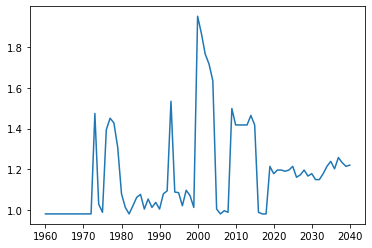

In [138]:
ut_db.plot()
%store ut_db

# Setup for product_to_copper_alloy

In [128]:
s3s = pd.read_excel('Data/semis demand/Sector to shape copper brass breakdown.xlsx',index_col=[0,1],sheet_name='End use')
# s3s.loc[idx[2006,'Copper Wire']].sum()
# ref_prod_history_cn.loc
s3s.loc[idx[:,['Copper Wire','Copper Tube']],:].sum(axis=1).groupby(level=0).sum()

2006    15593.692468
2007    16095.389042
2008    16652.293658
2009    14820.994241
2010    16399.160584
dtype: float64

In [141]:
print(s3s.index.levels[1])
pd.concat([s3s.groupby(level=1).sum().loc[['Copper Wire','Copper Foil','Copper Tube']].sum(),
           s3s.groupby(level=1).sum().loc[['Copper PSS','Copper RBS']].sum(),
           s3s.groupby(level=1).sum().loc[['Castings','Mech.wire','PSS','RBS','Tube']].sum()],axis=1).sum()

Index(['Castings', 'Copper Foil', 'Copper PSS', 'Copper RBS', 'Copper Tube',
       'Copper Wire', 'Mech.wire', 'PSS', 'RBS', 'Tube'],
      dtype='object')


0    81160.642477
1    10937.741502
2    26694.977345
dtype: float64

In [465]:
product_to_cathode_alloy

,Copper,Alloyed
Plumbing,0.482413,0.517587
Building Plant,1.000000,0.000000
Architecture,0.516101,0.483899
Communications,1.000000,0.000000
Electrical Power,0.986363,0.013637
Telecommunications,0.999845,0.000155
Power Utility,0.928128,0.071872
Electrical Industrial,0.915842,0.084158
Non Elec. Industrial,0.088140,0.911860
Electrical Automotive,0.818238,0.181762


# Attempting minimize cost for each semis

In [20]:
old_scrap_available_cn.copy().loc[year_i]

No.1               688.966
No.2                1517.3
Al_Bronze          69.9538
Cartridge          73.0406
Mn_Bronze           5.6799
Ni_Ag              63.7765
Ocean              57.4011
Pb_Sn_Bronze       57.8186
Pb_Yellow_Brass    137.642
Red_Brass          15.5026
Sn_Bronze          43.9743
Yellow_Brass       107.223
Name: 2018, dtype: object

In [6]:
# def blend_demand(availability_cn, availability_rw, alloy_demand_cn, alloy_demand_rw, raw_price_cn, raw_price_rw, s2s, 
#          prod_spec, raw_spec, sec_ref_prod_cn = 0, sec_ref_prod_rw = 0, ref_demand_cn = 0, ref_demand_rw = 0, 
#          fraction_yellows = 0, unalloyed_tune = 1, fruity_alloys=0, fruity_rr = [0,0,0,0], pir_pcr = 0, 
#          pir_fraction = -1, new_scrap_alloys_cn = 0, new_scrap_alloys_rw = 0, pir_price = 0.9, cn_scrap_imports = 0,
#          rc_variance = 0, og_rc = 0, converge = 0.1, converge_width = 0):

availability_cn = old_scrap_available_cn.copy().loc[year_i]
availability_rw = old_scrap_available_rw.copy().loc[year_i]
alloy_demand_cn = direct_melt_sectorial_demand_cn.copy().loc[year_i]
alloy_demand_rw = direct_melt_sectorial_demand_rw.copy().loc[year_i]
sec_ref_prod_cn = refined_scrap_demand_cn.copy().loc[year_i]
sec_ref_prod_rw = refined_scrap_demand_rw.copy().loc[year_i]
ref_demand_cn = historical_prod_cn.loc[year_i,'Refined usage']
ref_demand_rw = historical_prod_rw.loc[year_i,'Refined usage']
new_scrap_alloys_cn = new_scrap_alloys_cn_year_i.copy()
new_scrap_alloys_rw = new_scrap_alloys_rw_year_i.copy()
converge = 0.3
converge_width = 0.04
                            
'''Outputs demand for each scrap grade given demand for unalloyed and alloyed shapes for semis. With sec_ref_prod 
specified, includes secondary refined production in the blending optimization, where secondary refineries can consume all
scrap types except No.1, although yellow brasses are limited in refined use (based on USGS [values] and SMM [checkmarks])
using the fraction_yellows variable. Giving ref_demand causes weighting within the optimization to put Ref_Cu consumption 
closer to that value, where both No.1 and No.2 availabilities were set to the total unalloyed value and unalloyed_tune
multiplies by that value to change unalloyed scrap use. '''

constrain_demand = False
#     converge = 0.1 # higher value = lower minimum on ref Cu curve
#     converge_width = 0.01 # smaller value = wider dip

scraps = list(['Al_Bronze', 'Cartridge', 'Mn_Bronze', 'Ni_Ag', 'No.1', 'No.2', 'Ocean', 'Pb_Sn_Bronze', 'Pb_Yellow_Brass', 'Red_Brass', 'Sn_Bronze', 'Yellow_Brass'])
refs = list(['Ref_Cu', 'Ref_Al', 'Ref_Fe', 'Ref_Mn', 'Ref_Ni', 'Ref_Pb', 'Ref_Sn', 'Ref_Zn'])

# I make copies of many of the dataframes since I overwrite / modify many aspects, so I'd have to reload the dataframe each time instead
prod_spec1 = prod_spec.copy()
prod_spec1.drop(columns = prod_spec1.loc[:,'Mean_Cu':'Mean_Fe'].columns,inplace=True)
alloy_demand_cn1 = alloy_demand_cn.copy()
alloy_demand_rw1 = alloy_demand_rw.copy()
new_scrap_alloys_cn1 = new_scrap_alloys_cn.copy()
new_scrap_alloys_rw1 = new_scrap_alloys_rw.copy()
if type(fruity_alloys) == pd.core.frame.DataFrame:
    fruity_alloys1 = fruity_alloys.copy()
raw_spec_cn1 = raw_spec.copy()
raw_spec_rw1 = raw_spec.copy()
raw_spec_cn1.loc[:,'Price'] = raw_price_cn.copy().loc[year_i]
raw_spec_rw1.loc[:,'Price'] = raw_price_rw.copy().loc[year_i]
raw_spec_cn1.loc[:,'Availability'] = availability_cn
raw_spec_rw1.loc[:,'Availability'] = availability_rw

new_scrap_alloys_cn1.loc[:, 'Price'] = raw_price_cn.loc[year_i,'No.1'] * pir_price
new_scrap_alloys_rw1.loc[:, 'Price'] = raw_price_rw.loc[year_i,'No.1'] * pir_price
raw_spec_cn1 = pd.concat([raw_spec_cn1,new_scrap_alloys_cn1.rename(columns={'Primary code':'Raw_material'})], sort=False)
raw_spec_rw1 = pd.concat([raw_spec_rw1,new_scrap_alloys_rw1.rename(columns={'Primary code':'Raw_material'})], sort=False)

if 'Alloy Type' in raw_spec_cn1.columns:
    raw_spec_cn1.drop(columns='Alloy Type', inplace=True)
if 'Alloy Type' in raw_spec_rw1.columns:
    raw_spec_rw1.drop(columns='Alloy Type', inplace=True)
if 'Primary code' in raw_spec_cn1.columns:
    raw_spec_cn1.drop(columns = 'Primary code', inplace=True)
if 'Primary code' in raw_spec_rw1.columns:
    raw_spec_rw1.drop(columns = 'Primary code', inplace=True)

x = raw_spec_cn1.index
raw_spec_cn1.index = [i+'_cn' for i in x]
x = raw_spec_rw1.index
raw_spec_rw1.index = [i+'_rw' for i in x]

raw_spec_gl = pd.concat([raw_spec_cn1,raw_spec_rw1])

raw_params = raw_spec_gl.T.to_dict()

# this if statement handles the addition of fruity to the preexisting consumption, correcting for its 
# by reducing sector production in the sectors it occupies so we conserve mass overall and the rest of that 
# sector has the proper alloy distribution. The while statements handle cases where fruity production has 
# scaled to be 5-10% of global copper production, so larger than the sectors it would normally occupy
if type(fruity_alloys) == pd.core.frame.DataFrame: 
    if 'Unalloyed' in alloy_demand_cn1.index:
        while 0.8*alloy_demand_cn1.loc['Unalloyed'] < fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1','Quantity'].sum():
            fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1','Quantity'] *= 0.5
            print('Unalloyed reduced')
        alloy_demand_cn1.loc['Unalloyed'] -= fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1','Quantity'].sum()
    if fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum() < alloy_demand_cn1.loc['Electronic']:
        alloy_demand_cn1.loc['Electronic'] -= fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
    else:
        bothsies = alloy_demand_cn1.loc['Diverse']+alloy_demand_cn1.loc['Electronic']+alloy_demand_cn1.loc['Consumer']
        balancey = bothsies - fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
        while balancey + 0.7*alloy_demand_cn1.loc['Electrical Automotive'] < 0:
            balancey = bothsies - fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
            fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'] *= 0.5
            print('Alloyed reduced')
        alloy_demand_cn1.loc['Electronic'] -= alloy_demand_cn1.loc['Electronic']/bothsies*fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
        alloy_demand_cn1.loc['Diverse'] -= alloy_demand_cn1.loc['Diverse']/bothsies*fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
        alloy_demand_cn1.loc['Consumer'] -= alloy_demand_cn1.loc['Consumer']/bothsies*fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
        if balancey < 0:
            alloy_demand_cn1.loc['Electrical Automotive'] += balancey

prod_spec_cn = to_alloy_update(alloy_demand_cn1.copy(),s2s,prod_spec1.copy())
prod_spec_cn.index = [i+'_cn' for i in prod_spec_cn.index]
prod_spec_rw = to_alloy_update(alloy_demand_rw1.copy(),s2s,prod_spec1.copy())
prod_spec_rw.index=[i+'_rw' for i in prod_spec_rw.index]
prod_spec_gl = pd.concat([prod_spec_cn,prod_spec_rw])

if fraction_yellows != 0:
    prod_spec_gl.loc['Secondary refined_cn', 'High_Cu':'Low_Fe'] = pd.Series([100, 50, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0], index = prod_spec1.loc[:,'High_Cu':'Low_Fe'].columns)
    prod_spec_gl.loc['Secondary refined_cn', 'UNS'] = 'Secondary refined CN'
    prod_spec_gl.loc['Secondary refined_cn', 'Alloy Type':'Category'] = prod_spec1.iloc[0,:].loc['Alloy Type':'Category']
    prod_spec_gl.loc['Secondary refined_cn','Quantity'] = sec_ref_prod_cn
    prod_spec_gl.loc['Secondary refined_rw', 'High_Cu':'Low_Fe'] = pd.Series([100, 50, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0], index = prod_spec1.loc[:,'High_Cu':'Low_Fe'].columns)
    prod_spec_gl.loc['Secondary refined_rw', 'UNS'] = 'Secondary refined RoW'
    prod_spec_gl.loc['Secondary refined_rw', 'Alloy Type':'Category'] = prod_spec1.iloc[0,:].loc['Alloy Type':'Category']
    prod_spec_gl.loc['Secondary refined_rw','Quantity'] = sec_ref_prod_rw

# sets up minimum recycled content fractions for everyone. the _idx index is the way I would do the _locs
# variables if I were to go back and redo that segment of the model. 
if type(fruity_alloys) == pd.core.frame.DataFrame:
    prod_spec_gl.loc[:,'Min Recycled Content'] = 0
    fruity_niag = fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'
    fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1', 'Min Recycled Content'] = fruity_rr[0]
    fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass', 'Min Recycled Content'] = fruity_rr[1]
    fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag', 'Min Recycled Content'] = fruity_rr[2]
    fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze', 'Min Recycled Content'] = fruity_rr[3]
    fruity_alloys1.index = [i+'_cn' for i in fruity_alloys1.index]

    for i in fruity_alloys1.index:
        prod_spec_gl.loc[i,:] = fruity_alloys1.loc[i,:]

rw_idx = [i for i in prod_spec_gl.index if '_rw' in i]
cn_idx = [i for i in prod_spec_gl.index if '_cn' in i] # this is the 'pythonic' way of creating arrays, if you haven't seen that phrase before 
new_scraps = list(new_scrap_alloys_cn.index)
new_scraps_cn = [i+'_cn' for i in new_scraps]
new_scraps_rw = [i+'_rw' for i in new_scraps]
new_scraps_gl = list(new_scraps_cn)+list(new_scraps_rw)
old_scraps_cn = [i+'_cn' for i in scraps]
old_scraps_rw = [i+'_rw' for i in scraps]
old_scraps_gl = list(old_scraps_cn)+list(old_scraps_rw)
refs_cn = [i+'_cn' for i in refs]
refs_rw = [i+'_rw' for i in refs]
refs_gl = list(refs_cn)+list(refs_rw)
cn_raws = list(new_scraps_cn) + list(old_scraps_cn) + list(refs_cn)
rw_raws = list(new_scraps_rw) + list(old_scraps_rw) + list(refs_rw)
all_but_Cu = [i for i in cn_raws+rw_raws if 'Ref_Cu' not in i]

raw_gl = raw_spec_gl.index
raw = scraps+refs+new_scraps
prod = prod_spec_gl.index  

if type(fruity_rr) != type(0):
    if len(fruity_rr)>4 and type(fruity_alloys) == pd.core.frame.DataFrame:
        prod_spec_gl.loc[cn_idx,'Min Recycled Content'] = fruity_rr[6]
        prod_spec_gl.loc[rw_idx,'Min Recycled Content'] = fruity_rr[7]
        prod_spec_gl.loc['Unalloyed_cn','Min Recycled Content'] = fruity_rr[4]
        prod_spec_gl.loc['Unalloyed_rw','Min Recycled Content'] = fruity_rr[5]
        if 'Copper brass_cn' in prod_spec_gl.index:
            prod_spec_gl.loc['Copper brass_cn','Min Recycled Content'] = fruity_rr[4]
        if 'Copper brass_rw' in prod_spec_gl.index:
            prod_spec_gl.loc['Copper brass_rw','Min Recycled Content'] = fruity_rr[5]
        prod_spec_gl.loc['Secondary refined_cn','Min Recycled Content'] = 0
        prod_spec_gl.loc['Secondary refined_rw','Min Recycled Content'] = 0

x = list(prod_spec_gl.loc[:,'High_Cu':'Low_Fe'].columns)+list(['Quantity'])
if 'Min Recycled Content' in prod_spec_gl.columns:
    x = x + list(['Min Recycled Content'])
prod_params = prod_spec_gl.loc[:,x].T.to_dict()

# For allowing composition ranges to be treated probabilistically, more details in longer ramble comment below
confidence = 0.95
s = confidence*2 - 1
CC = True # stands for chance-constrained, allows composition ranges to be treated probabilistically using a fuzzy number approach rather than linearly. I know very little about the fuzzy number approach, Xinkai always refers to the paper by Arash I included in the zip file, if you're super duper interested, I might have read it at some point but don't really remeber it

# This is just a required thing of starting a gurobi model, m and 'Blending' can be anything, though you set 
# up all the constraints and everything using the notation m.do_thing
m = Model('Blending')
raw_demand = m.addVars(prod_spec_gl.index, raw_spec_gl.index, name='raw_demand', lb=0)

high_cols = [i for i in prod_spec_gl.columns if 'High' in i]
low_cols = [i for i in prod_spec_gl.columns if 'Low' in i]

if CC == True:
    for p in prod:
        for hi,lo in zip(high_cols,low_cols):
            m.addConstr(quicksum(raw_demand[p,r] * ((raw_params[r][hi]+raw_params[r][lo])/2 + (raw_params[r][hi]-raw_params[r][lo])/2*s)
                                     for r in raw_spec_gl.index) >= prod_params[p]['Quantity']
                                     * prod_params[p][lo],hi)
            m.addConstr(quicksum(raw_demand[p,r] * ((raw_params[r][hi]+raw_params[r][lo])/2 + (raw_params[r][hi]-raw_params[r][lo])/2*s)
                                     for r in raw_spec_gl.index) <= prod_params[p]['Quantity']
                                     * prod_params[p][hi],lo)
else:    
    for p in prod:
        for hi,lo in zip(high_cols,low_cols):
            m.addConstr(quicksum(raw_demand[p,r] * (raw_params[r][hi]+raw_params[r][lo])/2
                                     for r in raw_spec_gl.index) >= prod_params[p]['Quantity']
                                     * prod_params[p][lo],hi)
            m.addConstr(quicksum(raw_demand[p,r] * (raw_params[r][hi]+raw_params[r][lo])/2
                                     for r in raw_spec_gl.index) <= prod_params[p]['Quantity']
                                     * prod_params[p][hi],lo)


[m.addConstr(quicksum(raw_demand[(p,r)] for r in raw_gl) == prod_params[p]['Quantity'],'mass') for p in prod]
[m.addConstr(raw_demand[(p,r)] >= 0,'don\'t be negative') for r in raw_gl for p in prod];

# m.setObjective(quicksum(quicksum(np.dot(raw_demand.select(i,'*'),raw_params[i]['Price']))
#                 for i in raw_spec_gl.index),GRB.MINIMIZE)

## The more interesting constraints
#     print(prod_spec_gl)
for a in prod:
    # Setting minimum recycled content constraints
    if type(fruity_alloys) != type(0):
#             print(a, 'quant:', prod_params[a]['Quantity'], 'min rc:', prod_params[a]['Min Recycled Content'])
        if fruity_rr[0] != 0 and a in fruity_alloys1.index:
            m.addConstr(quicksum(raw_demand[(a,i)] for i in refs_gl) <= prod_params[a]['Quantity']*(1-prod_params[a]['Min Recycled Content']), 'recycled content')
        elif fruity_rr[0] != 0 and a not in fruity_alloys1.index:
            m.addConstr(quicksum(raw_demand[(a,i)] for i in refs_gl) <= prod_params[a]['Quantity']*(1-prod_params[a]['Min Recycled Content']), 'recycled content')
        else:
            m.addConstr(quicksum(raw_demand[(a,i)] for i in refs_gl) == prod_params[a]['Quantity'], 'no recycled content allowed')
#             print(a, 'no recycled content')

     # No No.2 in non-refinery alloys, since No.2 requires refining before use
    if 'Secondary refined' in a:
        for rs in refs_gl + list(['No.1_cn','No.1_rw']):
            m.addConstr(raw_demand[(a,rs)] == 0, "no #1 or refined")
        for rs in list(['Yellow_Brass_cn','Yellow_Brass_rw', 'Pb_Yellow_Brass_cn','Pb_Yellow_Brass_rw', 'Cartridge_cn','Cartridge_rw']): # allowing refineries to use some other alloys aside from No.2
            m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*raw_params[rs]['Availability'], "Low yellows")
        m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*2*raw_params['Sn_Bronze_cn']['Availability'], 'Low Sn Bronze')
        m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*2*raw_params['Sn_Bronze_rw']['Availability'], 'Low Sn Bronze')

        # allowing refineries to use some new scrap
        for rs in new_scraps_gl:
            m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*raw_params[rs]['Availability'], "limit new scrap")

    # Don't let Unalloyed production use anything but refined Cu, don't let Copper brass production use refined metals that aren't copper
#         elif 'Unalloyed' in a:
#             for rs in all_but_Cu:
#                 m.addConstr(raw_demand[(a,rs)] == 0, "Refined Cu only")
    elif 'Copper brass' in a or 'Unalloyed' in a:
        for rs in [i for i in refs_gl if 'Cu' not in i] + list(['No.2_cn','No.2_rw']):
            m.addConstr(raw_demand[(a,rs)] == 0, "no refined aside from Cu")
    else:
        m.addConstr(raw_demand[(a,'No.2_cn')] == 0, "no #2")
        m.addConstr(raw_demand[(a,'No.2_rw')] == 0, "no #2")

    # Setting the pir fraction constraints, not letting it use any old scrap
    if pir_fraction != -1 and a in fruity_alloys.index and not fruity_niag[a]:
        if pir_fraction == 0:
            m.addConstr(quicksum(raw_demand[a,i] for i in new_scraps_gl) == 0)
        elif pir_fraction == 1:
            m.addConstr(quicksum(raw_demand[a,i] for i in new_scraps_gl) == 1)
        else:
#             m.addConstr(quicksum(raw_demand[a,i] for i in new_scrap_alloys_cn1.index) <= production[a_i]*(pir_fraction+0.01))
            m.addConstr(quicksum(raw_demand[a,i] for i in new_scraps_gl) >= prod_params[a]['Quantity']*(pir_fraction-0.01))
            m.addConstr(quicksum(raw_demand[a,i] for i in old_scraps_gl) == 0)

    # keeping CN and RoW from pulling from each others' pools
    if a in cn_idx:
        m.addConstr(quicksum(raw_demand[a,i] for i in rw_raws) == 0)
    elif a in rw_idx:
        m.addConstr(quicksum(raw_demand[a,i] for i in cn_raws) == 0)


# This might be the most complicated part. We define scrap costs as changing according to the avg_cost_curve
# function, so they change as a function of scrap consumed that year because we assume the market for scrap 
# isn't liquid - the market isn't sufficiently globalized and scrap isn't on major metal exchanges, so its
# price differs for different suppliers. The avg cost curve shows that there are a small number of suppliers 
# selling at a low price, and most are at a higher price. The curve changes with the cost determined by 
# larger-scale changes year-over-year from the raw_price data, and the amount of scrao available that year.
# This requires using a piecewise-linear objective function, which is not as easy to understand / implement
# as their normal objectives.
new_quant_cn = {}
new_quant_rw = {}
new_cost_cn = {}
new_cost_rw = {}
new_quant = {}
new_cost = {}
n = 25 # for approximating the integral with Riemann sum-type method
slope = -1
width_cn = sum(prod_spec_gl.loc[cn_idx].Quantity)/n
width_rw = sum(prod_spec_gl.loc[rw_idx].Quantity)/n

# simpler variables: amount of raw materials consumed globally, in China, and RoW
raw_demand_tot = m.addVars(raw, name='raw_demand_tot')
raw_demand_tot_cn = m.addVars(raw, name = 'raw_demand_tot_cn')
raw_demand_tot_rw = m.addVars(raw, name = 'raw_demand_tot_rw')
# global refined production was determined outside the blending model and is used to constrain China's
# and RoW's consumption
if constrain_demand:
    m.addConstr(raw_demand_tot['Ref_Cu'] == ref_demand_cn+ref_demand_rw, 'Ref_Cu == demand')

### This is the portion for objectives for each raw material for each fabricator
for p in prod:
    for scrap in raw_gl:
        new_quant.update({scrap: np.linspace(0,prod_params[p]['Quantity'],n)})
        pricey = raw_params[scrap]['Price']
        if p == target_name and scrap == target_scrap:
            x = pricey*(converge_width1*(aq-target))**2-converge1*target*pricey
            x[x>0] = 0
        else:
            x=0
        
        new_cost.update({scrap: new_quant[scrap]*pricey + x})
        m.setPWLObj(raw_demand[p,scrap],new_quant[scrap],new_cost[scrap])
    
# This is what I used before, with average cost curves. Currently just have it for refined copper so it'll still do that convergence to the China and RoW refined demand values
for scrap in ['Ref_Cu']:#raw:
    m.addConstr(quicksum(raw_demand[(a,scrap+'_cn')] for a in cn_idx) + 
                quicksum(raw_demand[(a,scrap+'_rw')] for a in cn_idx) == raw_demand_tot_cn[scrap])
    m.addConstr(quicksum(raw_demand[(a,scrap+'_cn')] for a in rw_idx) + 
                quicksum(raw_demand[(a,scrap+'_rw')] for a in rw_idx) == raw_demand_tot_rw[scrap])

    new_quant_cn.update({scrap: np.linspace(0,sum([prod_params[i]['Quantity'] for i in cn_idx]),n)})
    new_quant_rw.update({scrap: np.linspace(0,sum([prod_params[i]['Quantity'] for i in rw_idx]),n)})
    if scrap in scraps:
        # Here is the integral part for determining total cost of any quantity being consumed
        if 'No.1' not in scrap:
            new_cost_cn.update({scrap: np.cumsum(width_cn*avg_cost_curve(new_quant_cn[scrap],raw_params[scrap+'_cn']['Price'],raw_params[scrap+'_cn']['Availability'],slope))}) # effectively integrating under the curve
            new_cost_rw.update({scrap: np.cumsum(width_rw*avg_cost_curve(new_quant_rw[scrap],raw_params[scrap+'_rw']['Price'],raw_params[scrap+'_rw']['Availability'],slope))}) # effectively integrating under the curve
        else:
            new_cost_cn.update({scrap: np.cumsum(width_cn*avg_cost_curve(new_quant_cn[scrap],unalloyed_tune*raw_params[scrap+'_cn']['Price'],raw_params[scrap+'_cn']['Availability'],slope))}) # effectively integrating under the curve
            new_cost_rw.update({scrap: np.cumsum(width_rw*avg_cost_curve(new_quant_rw[scrap],unalloyed_tune*raw_params[scrap+'_rw']['Price'],raw_params[scrap+'_rw']['Availability'],slope))}) # effectively integrating under the curve
        m.addConstr(raw_demand_tot_cn[scrap] <= raw_params[scrap+'_cn']['Availability'])
        m.addConstr(raw_demand_tot_rw[scrap] <= raw_params[scrap+'_rw']['Availability'])
    elif not np.isnan(raw_params[scrap+'_cn']['Availability']): # for pir, since they have availability limit and refined materials don't
        m.addConstr(raw_demand_tot_cn[scrap] <= raw_params[scrap+'_cn']['Availability'])
        m.addConstr(raw_demand_tot_rw[scrap] <= raw_params[scrap+'_rw']['Availability'])
        new_cost_cn.update({scrap: raw_params[scrap+'_cn']['Price']*new_quant_cn[scrap]})
        new_cost_rw.update({scrap: raw_params[scrap+'_rw']['Price']*new_quant_rw[scrap]})
    elif 'Ref_Cu' in scrap:
        x = raw_params[scrap+'_cn']['Price']*(converge_width*(new_quant_cn['Ref_Cu']-ref_demand_cn))**2-\
                converge*ref_demand_cn*raw_params[scrap+'_cn']['Price']
        x[x > 0] = 0
        new_cost_cn.update({scrap: raw_params[scrap+'_cn']['Price']*new_quant_cn[scrap]+x})
        x = raw_params[scrap+'_rw']['Price']*(converge_width*(new_quant_rw['Ref_Cu']-ref_demand_rw))**2-\
                converge*ref_demand_rw*raw_params[scrap+'_rw']['Price']
        x[x > 0] = 0
        new_cost_rw.update({scrap: raw_params[scrap+'_rw']['Price']*new_quant_rw[scrap]+x})
    else:
        new_cost_cn.update({scrap: raw_params[scrap+'_cn']['Price']*new_quant_cn[scrap]})
        new_cost_rw.update({scrap: raw_params[scrap+'_rw']['Price']*new_quant_rw[scrap]})
    m.addConstr(raw_demand_tot[scrap] == raw_demand_tot_cn[scrap] + raw_demand_tot_rw[scrap])
    m.setPWLObj(raw_demand_tot_cn[scrap],new_quant_cn[scrap],new_cost_cn[scrap])
    m.setPWLObj(raw_demand_tot_rw[scrap],new_quant_rw[scrap],new_cost_rw[scrap])

    # These piecewise-linear objective functions operate by treating raw_demand_tot_cn or _rw as the variable
    # receiving a penalty function, where possible values (it can interpolate) for raw_demand_tot_cn
    # are given by new_quant_cn and the penalty associated with each of those values is given by new_cost_cn.
    # It then works to minimize the overall penalties, since these objectives now exist for each raw material
    # we looped over    

# m.setParam('TimeLimit', 100); #seconds
m.update()
m.setParam('OutputFlag',False) # can use this to suppress the big 'ole output stream
m.optimize()
tot_rw_new = pd.Series(m.getAttr('x', raw_demand_tot_rw))
demand_new = pd.Series(m.getAttr('x',raw_demand))

d_cn = demand_new.groupby(level=1).sum().loc[cn_raws]
d_cn.index = [i.split('_cn')[0] for i in d_cn.index]

d_rw = demand_new.groupby(level=1).sum().loc[rw_raws]
d_rw.index = [i.split('_rw')[0] for i in d_rw.index]



if fraction_yellows != 0:
    idx = pd.IndexSlice
    sec_ref_cn = demand_new.loc[idx['Secondary refined_cn',:]]
    sec_ref_rw = demand_new.loc[idx['Secondary refined_rw',:]]
    actual_rc = (demand_new.groupby(level=0).sum() - demand_new.loc[idx[:,refs_gl]].groupby(level=0).sum())/demand_new.groupby(level=0).sum()
    actual_rcv = demand_new.groupby(level=0).sum() - demand_new.loc[idx[:,refs_gl]].groupby(level=0).sum()

    if type(fruity_alloys) != type(0):
        fruity_demand = pd.DataFrame(0, index = fruity_alloys1.index, columns = raw)
        for i in fruity_demand.index:
            fruity_demand.loc[i, :] = demand_new.loc[idx[i,:]]
# #             print('No.1: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'No.1'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'No.1'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'No.1'].sum())
# #             print('YeBr: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass'].sum())
# #             print('NiAg: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'].sum())
# #             print('SnBr: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze'].sum())
# o = demand_new.loc[idx[target_name+'n',target_scrap]]
o = 3.846
print('Original:',round(o,3),'\nTarget:',target,'\nconverge:',converge1,'\nconverge_width:',converge_width1,'\n'+target_name,
      target_scrap,'consumption:',round(demand_new.loc[idx[target_name,target_scrap]],3))
demand_new.loc[idx[target_name,:]][demand_new.loc[idx[target_name,:]]>0]

Academic license - for non-commercial use only - expires 2021-04-25
Using license file C:\Users\ryter\gurobi.lic


NameError: name 'converge_width1' is not defined

In [52]:
# raw_demand.select(a,'*')
# raw_demand.select('C63200 RBS_cn','*')
target = 1.5
demand_new.loc[idx[target_name,:]][demand_new.loc[idx[target_name,:]]>0]

Ref_Al_cn      0.274361
Ref_Fe_cn      0.180994
CW300G_cn      3.503897
New No.1_cn    0.565607
dtype: float64

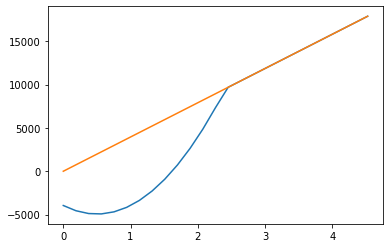

In [14]:
target_name = 'C63200 RBS_cn'
target_scrap = 'New No.1_cn'
n=25
aq = np.linspace(0,prod_params[target_name]['Quantity'],n)
p = raw_params[target_scrap]['Price']
target = 1
converge_width1 = 1
converge1 = 2
x = p/converge_width1*(aq-target)**2-converge1*target*p
x[x>0] = 0
# raw_params[scrap+'_rw']['Price']*(converge_width*(new_quant_rw['Ref_Cu']-ref_demand_rw))**2-\
#                 converge*ref_demand_rw*raw_params[scrap+'_rw']['Price']

bq = aq*p + x
br = aq*p
plt.plot(aq,bq)
plt.plot(aq,br)


3.846130542790261

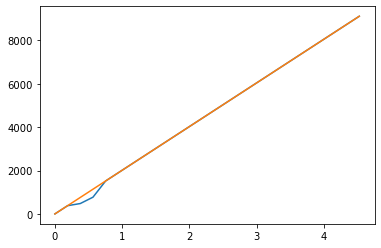

In [49]:
aq = np.linspace(0,prod_params['C63200 RBS_cn']['Quantity'],n)
p = raw_params['Ref_Al_cn']['Price']
target = 0.5
x = p*(converge_width1*(aq-target))**2-converge1*target*p
x[x>0] = 0
# raw_params[scrap+'_rw']['Price']*(converge_width*(new_quant_rw['Ref_Cu']-ref_demand_rw))**2-\
#                 converge*ref_demand_rw*raw_params[scrap+'_rw']['Price']

bq = aq*p + x
br = aq*p
plt.plot(aq,bq)
plt.plot(aq,br)


In [30]:
converge_width

0.04

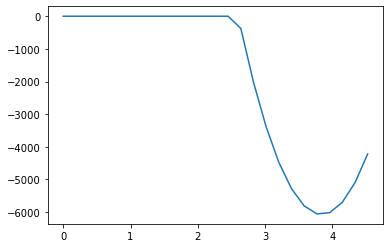

In [46]:
plt.plot(aq,x)

## Now trying in function form with "prior year" and price changes

In [7]:
def blend_converge(availability_cn, availability_rw, alloy_demand_cn, alloy_demand_rw, raw_price_cn, raw_price_rw, s2s, 
             prod_spec, raw_spec, sec_ref_prod_cn = 0, sec_ref_prod_rw = 0, ref_demand_cn = 0, ref_demand_rw = 0, 
             fraction_yellows = 0, unalloyed_tune = 1, fruity_alloys=0, fruity_rr = [0,0,0,0], pir_pcr = 0, 
             pir_fraction = -1, new_scrap_alloys_cn = 0, new_scrap_alloys_rw = 0, pir_price = 0.9, cn_scrap_imports = 0,
             rc_variance = 0, og_rc = 0, converge = 0.1, converge_width = 0, prior_blend = 0, target = 0.5):
    '''Outputs demand for each scrap grade given demand for unalloyed and alloyed shapes for semis. With sec_ref_prod 
    specified, includes secondary refined production in the blending optimization, where secondary refineries can consume all
    scrap types except No.1, although yellow brasses are limited in refined use (based on USGS [values] and SMM [checkmarks])
    using the fraction_yellows variable. Giving ref_demand causes weighting within the optimization to put Ref_Cu consumption 
    closer to that value, where both No.1 and No.2 availabilities were set to the total unalloyed value and unalloyed_tune
    multiplies by that value to change unalloyed scrap use. '''

    constrain_demand = False
#     converge = 0.1 # higher value = lower minimum on ref Cu curve
#     converge_width = 0.01 # smaller value = wider dip
    
    scraps = list(['Al_Bronze', 'Cartridge', 'Mn_Bronze', 'Ni_Ag', 'No.1', 'No.2', 'Ocean', 'Pb_Sn_Bronze', 'Pb_Yellow_Brass', 'Red_Brass', 'Sn_Bronze', 'Yellow_Brass'])
    refs = list(['Ref_Cu', 'Ref_Al', 'Ref_Fe', 'Ref_Mn', 'Ref_Ni', 'Ref_Pb', 'Ref_Sn', 'Ref_Zn'])

    # I make copies of many of the dataframes since I overwrite / modify many aspects, so I'd have to reload the dataframe each time instead
    prod_spec1 = prod_spec.copy()
    prod_spec1.drop(columns = prod_spec1.loc[:,'Mean_Cu':'Mean_Fe'].columns,inplace=True)
    alloy_demand_cn1 = alloy_demand_cn.copy()
    alloy_demand_rw1 = alloy_demand_rw.copy()
    new_scrap_alloys_cn1 = new_scrap_alloys_cn.copy()
    new_scrap_alloys_rw1 = new_scrap_alloys_rw.copy()
    if type(fruity_alloys) == pd.core.frame.DataFrame:
        fruity_alloys1 = fruity_alloys.copy()
    raw_spec_cn1 = raw_spec.copy()
    raw_spec_rw1 = raw_spec.copy()
    raw_spec_cn1['Price'] = raw_price_cn
    raw_spec_rw1['Price'] = raw_price_rw
    raw_spec_cn1['Availability'] = availability_cn
    raw_spec_rw1['Availability'] = availability_rw

    new_scrap_alloys_cn1.loc[:, 'Price'] = raw_price_cn.loc['No.1'] * pir_price
    new_scrap_alloys_rw1.loc[:, 'Price'] = raw_price_rw.loc['No.1'] * pir_price
    raw_spec_cn1 = pd.concat([raw_spec_cn1,new_scrap_alloys_cn1.rename(columns={'Primary code':'Raw_material'})], sort=False)
    raw_spec_rw1 = pd.concat([raw_spec_rw1,new_scrap_alloys_rw1.rename(columns={'Primary code':'Raw_material'})], sort=False)

    if 'Alloy Type' in raw_spec_cn1.columns:
        raw_spec_cn1.drop(columns='Alloy Type', inplace=True)
    if 'Alloy Type' in raw_spec_rw1.columns:
        raw_spec_rw1.drop(columns='Alloy Type', inplace=True)
    if 'Primary code' in raw_spec_cn1.columns:
        raw_spec_cn1.drop(columns = 'Primary code', inplace=True)
    if 'Primary code' in raw_spec_rw1.columns:
        raw_spec_rw1.drop(columns = 'Primary code', inplace=True)

    x = raw_spec_cn1.index
    raw_spec_cn1.index = [i+'_cn' for i in x]
    x = raw_spec_rw1.index
    raw_spec_rw1.index = [i+'_rw' for i in x]

    raw_spec_gl = pd.concat([raw_spec_cn1,raw_spec_rw1])

    raw_params = raw_spec_gl.T.to_dict()

    # this if statement handles the addition of fruity to the preexisting consumption, correcting for its 
    # by reducing sector production in the sectors it occupies so we conserve mass overall and the rest of that 
    # sector has the proper alloy distribution. The while statements handle cases where fruity production has 
    # scaled to be 5-10% of global copper production, so larger than the sectors it would normally occupy
    if type(fruity_alloys) == pd.core.frame.DataFrame: 
        if 'Unalloyed' in alloy_demand_cn1.index:
            while 0.8*alloy_demand_cn1.loc['Unalloyed'] < fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1','Quantity'].sum():
                fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1','Quantity'] *= 0.5
                print('Unalloyed reduced')
            alloy_demand_cn1.loc['Unalloyed'] -= fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1','Quantity'].sum()
        if fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum() < alloy_demand_cn1.loc['Electronic']:
            alloy_demand_cn1.loc['Electronic'] -= fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
        else:
            bothsies = alloy_demand_cn1.loc['Diverse']+alloy_demand_cn1.loc['Electronic']+alloy_demand_cn1.loc['Consumer']
            balancey = bothsies - fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
            while balancey + 0.7*alloy_demand_cn1.loc['Electrical Automotive'] < 0:
                balancey = bothsies - fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
                fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'] *= 0.5
                print('Alloyed reduced')
            alloy_demand_cn1.loc['Electronic'] -= alloy_demand_cn1.loc['Electronic']/bothsies*fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
            alloy_demand_cn1.loc['Diverse'] -= alloy_demand_cn1.loc['Diverse']/bothsies*fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
            alloy_demand_cn1.loc['Consumer'] -= alloy_demand_cn1.loc['Consumer']/bothsies*fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] != 'No.1','Quantity'].sum()
            if balancey < 0:
                alloy_demand_cn1.loc['Electrical Automotive'] += balancey

    prod_spec_cn = to_alloy_update(alloy_demand_cn1.copy(),s2s,prod_spec1.copy())
    prod_spec_cn.index = [i+'_cn' for i in prod_spec_cn.index]
    prod_spec_rw = to_alloy_update(alloy_demand_rw1.copy(),s2s,prod_spec1.copy())
    prod_spec_rw.index=[i+'_rw' for i in prod_spec_rw.index]
    prod_spec_gl = pd.concat([prod_spec_cn,prod_spec_rw])

    if fraction_yellows != 0:
        prod_spec_gl.loc['Secondary refined_cn', 'High_Cu':'Low_Fe'] = pd.Series([100, 50, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0], index = prod_spec1.loc[:,'High_Cu':'Low_Fe'].columns)
        prod_spec_gl.loc['Secondary refined_cn', 'UNS'] = 'Secondary refined CN'
        prod_spec_gl.loc['Secondary refined_cn', 'Alloy Type':'Category'] = prod_spec1.iloc[0,:].loc['Alloy Type':'Category']
        prod_spec_gl.loc['Secondary refined_cn','Quantity'] = sec_ref_prod_cn
        prod_spec_gl.loc['Secondary refined_rw', 'High_Cu':'Low_Fe'] = pd.Series([100, 50, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0, 100, 0], index = prod_spec1.loc[:,'High_Cu':'Low_Fe'].columns)
        prod_spec_gl.loc['Secondary refined_rw', 'UNS'] = 'Secondary refined RoW'
        prod_spec_gl.loc['Secondary refined_rw', 'Alloy Type':'Category'] = prod_spec1.iloc[0,:].loc['Alloy Type':'Category']
        prod_spec_gl.loc['Secondary refined_rw','Quantity'] = sec_ref_prod_rw

    # sets up minimum recycled content fractions for everyone. the _idx index is the way I would do the _locs
    # variables if I were to go back and redo that segment of the model. 
    if type(fruity_alloys) == pd.core.frame.DataFrame:
        prod_spec_gl.loc[:,'Min Recycled Content'] = 0
        fruity_niag = fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'
        fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'No.1', 'Min Recycled Content'] = fruity_rr[0]
        fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass', 'Min Recycled Content'] = fruity_rr[1]
        fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag', 'Min Recycled Content'] = fruity_rr[2]
        fruity_alloys1.loc[fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze', 'Min Recycled Content'] = fruity_rr[3]
        fruity_alloys1.index = [i+'_cn' for i in fruity_alloys1.index]

        for i in fruity_alloys1.index:
            prod_spec_gl.loc[i,:] = fruity_alloys1.loc[i,:]

    rw_idx = [i for i in prod_spec_gl.index if '_rw' in i]
    cn_idx = [i for i in prod_spec_gl.index if '_cn' in i] # this is the 'pythonic' way of creating arrays, if you haven't seen that phrase before 
    new_scraps = list(new_scrap_alloys_cn.index)
    new_scraps_cn = [i+'_cn' for i in new_scraps]
    new_scraps_rw = [i+'_rw' for i in new_scraps]
    new_scraps_gl = list(new_scraps_cn)+list(new_scraps_rw)
    old_scraps_cn = [i+'_cn' for i in scraps]
    old_scraps_rw = [i+'_rw' for i in scraps]
    old_scraps_gl = list(old_scraps_cn)+list(old_scraps_rw)
    refs_cn = [i+'_cn' for i in refs]
    refs_rw = [i+'_rw' for i in refs]
    refs_gl = list(refs_cn)+list(refs_rw)
    cn_raws = list(new_scraps_cn) + list(old_scraps_cn) + list(refs_cn)
    rw_raws = list(new_scraps_rw) + list(old_scraps_rw) + list(refs_rw)
    all_but_Cu = [i for i in cn_raws+rw_raws if 'Ref_Cu' not in i]

    raw_gl = raw_spec_gl.index
    raw = scraps+refs+new_scraps
    prod = prod_spec_gl.index  

    if type(fruity_rr) != type(0):
        if len(fruity_rr)>4 and type(fruity_alloys) == pd.core.frame.DataFrame:
            prod_spec_gl.loc[cn_idx,'Min Recycled Content'] = fruity_rr[6]
            prod_spec_gl.loc[rw_idx,'Min Recycled Content'] = fruity_rr[7]
            prod_spec_gl.loc['Unalloyed_cn','Min Recycled Content'] = fruity_rr[4]
            prod_spec_gl.loc['Unalloyed_rw','Min Recycled Content'] = fruity_rr[5]
            if 'Copper brass_cn' in prod_spec_gl.index:
                prod_spec_gl.loc['Copper brass_cn','Min Recycled Content'] = fruity_rr[4]
            if 'Copper brass_rw' in prod_spec_gl.index:
                prod_spec_gl.loc['Copper brass_rw','Min Recycled Content'] = fruity_rr[5]
            prod_spec_gl.loc['Secondary refined_cn','Min Recycled Content'] = 0
            prod_spec_gl.loc['Secondary refined_rw','Min Recycled Content'] = 0

    x = list(prod_spec_gl.loc[:,'High_Cu':'Low_Fe'].columns)+list(['Quantity'])
    if 'Min Recycled Content' in prod_spec_gl.columns:
        x = x + list(['Min Recycled Content'])
    prod_params = prod_spec_gl.loc[:,x].T.to_dict()

    # For allowing composition ranges to be treated probabilistically, more details in longer ramble comment below
    confidence = 0.95
    s = confidence*2 - 1
    CC = True # stands for chance-constrained, allows composition ranges to be treated probabilistically using a fuzzy number approach rather than linearly. I know very little about the fuzzy number approach, Xinkai always refers to the paper by Arash I included in the zip file, if you're super duper interested, I might have read it at some point but don't really remeber it

    # This is just a required thing of starting a gurobi model, m and 'Blending' can be anything, though you set 
    # up all the constraints and everything using the notation m.do_thing
    m = Model('Blending')
    raw_demand = m.addVars(prod_spec_gl.index, raw_spec_gl.index, name='raw_demand', lb=0)

    high_cols = [i for i in prod_spec_gl.columns if 'High' in i]
    low_cols = [i for i in prod_spec_gl.columns if 'Low' in i]

    if CC == True:
        for p in prod:
            for hi,lo in zip(high_cols,low_cols):
                m.addConstr(quicksum(raw_demand[p,r] * ((raw_params[r][hi]+raw_params[r][lo])/2 + (raw_params[r][hi]-raw_params[r][lo])/2*s)
                                         for r in raw_spec_gl.index) >= prod_params[p]['Quantity']
                                         * prod_params[p][lo],hi)
                m.addConstr(quicksum(raw_demand[p,r] * ((raw_params[r][hi]+raw_params[r][lo])/2 + (raw_params[r][hi]-raw_params[r][lo])/2*s)
                                         for r in raw_spec_gl.index) <= prod_params[p]['Quantity']
                                         * prod_params[p][hi],lo)
    else:    
        for p in prod:
            for hi,lo in zip(high_cols,low_cols):
                m.addConstr(quicksum(raw_demand[p,r] * (raw_params[r][hi]+raw_params[r][lo])/2
                                         for r in raw_spec_gl.index) >= prod_params[p]['Quantity']
                                         * prod_params[p][lo],hi)
                m.addConstr(quicksum(raw_demand[p,r] * (raw_params[r][hi]+raw_params[r][lo])/2
                                         for r in raw_spec_gl.index) <= prod_params[p]['Quantity']
                                         * prod_params[p][hi],lo)


    [m.addConstr(quicksum(raw_demand[(p,r)] for r in raw_gl) == prod_params[p]['Quantity'],'mass') for p in prod]
    [m.addConstr(raw_demand[(p,r)] >= 0,'don\'t be negative') for r in raw_gl for p in prod];

    # m.setObjective(quicksum(quicksum(np.dot(raw_demand.select(i,'*'),raw_params[i]['Price']))
    #                 for i in raw_spec_gl.index),GRB.MINIMIZE)

    ## The more interesting constraints
#     print(prod_spec_gl)
    for a in prod_spec_gl.index:
        # Setting minimum recycled content constraints
        if type(fruity_alloys) != type(0):
#             print(a, 'quant:', prod_params[a]['Quantity'], 'min rc:', prod_params[a]['Min Recycled Content'])
            if fruity_rr[0] != 0 and a in fruity_alloys1.index:
                m.addConstr(quicksum(raw_demand[(a,i)] for i in refs_gl) <= prod_params[a]['Quantity']*(1-prod_params[a]['Min Recycled Content']), 'recycled content')
            elif fruity_rr[0] != 0 and a not in fruity_alloys1.index:
                m.addConstr(quicksum(raw_demand[(a,i)] for i in refs_gl) <= prod_params[a]['Quantity']*(1-prod_params[a]['Min Recycled Content']), 'recycled content')
            else:
                m.addConstr(quicksum(raw_demand[(a,i)] for i in refs_gl) == prod_params[a]['Quantity'], 'no recycled content allowed')
    #             print(a, 'no recycled content')

         # No No.2 in non-refinery alloys, since No.2 requires refining before use
        if 'Secondary refined' in a:
            for rs in refs_gl + list(['No.1_cn','No.1_rw']):
                m.addConstr(raw_demand[(a,rs)] == 0, "no #1 or refined")
            for rs in list(['Yellow_Brass_cn','Yellow_Brass_rw', 'Pb_Yellow_Brass_cn','Pb_Yellow_Brass_rw', 'Cartridge_cn','Cartridge_rw']): # allowing refineries to use some other alloys aside from No.2
                m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*raw_params[rs]['Availability'], "Low yellows")
            m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*2*raw_params['Sn_Bronze_cn']['Availability'], 'Low Sn Bronze')
            m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*2*raw_params['Sn_Bronze_rw']['Availability'], 'Low Sn Bronze')

            # allowing refineries to use some new scrap
            for rs in new_scraps_gl:
                m.addConstr(raw_demand[(a,rs)] <= fraction_yellows*raw_params[rs]['Availability'], "limit new scrap")

        # Don't let Unalloyed production use anything but refined Cu, don't let Copper brass production use refined metals that aren't copper
#         elif 'Unalloyed' in a:
#             for rs in all_but_Cu:
#                 m.addConstr(raw_demand[(a,rs)] == 0, "Refined Cu only")
        elif 'Copper brass' in a or 'Unalloyed' in a:
            for rs in [i for i in refs_gl if 'Cu' not in i] + list(['No.2_cn','No.2_rw']):
                m.addConstr(raw_demand[(a,rs)] == 0, "no refined aside from Cu")
        else:
            m.addConstr(raw_demand[(a,'No.2_cn')] == 0, "no #2")
            m.addConstr(raw_demand[(a,'No.2_rw')] == 0, "no #2")

        # Setting the pir fraction constraints, not letting it use any old scrap
        if pir_fraction != -1 and a in fruity_alloys.index and not fruity_niag[a]:
            if pir_fraction == 0:
                m.addConstr(quicksum(raw_demand[a,i] for i in new_scraps_gl) == 0)
            elif pir_fraction == 1:
                m.addConstr(quicksum(raw_demand[a,i] for i in new_scraps_gl) == 1)
            else:
    #             m.addConstr(quicksum(raw_demand[a,i] for i in new_scrap_alloys_cn1.index) <= production[a_i]*(pir_fraction+0.01))
                m.addConstr(quicksum(raw_demand[a,i] for i in new_scraps_gl) >= prod_params[a]['Quantity']*(pir_fraction-0.01))
                m.addConstr(quicksum(raw_demand[a,i] for i in old_scraps_gl) == 0)

        # keeping CN and RoW from pulling from each others' pools
        if a in cn_idx:
            m.addConstr(quicksum(raw_demand[a,i] for i in rw_raws) == 0)
        elif a in rw_idx:
            m.addConstr(quicksum(raw_demand[a,i] for i in cn_raws) == 0)


    # This might be the most complicated part. We define scrap costs as changing according to the avg_cost_curve
    # function, so they change as a function of scrap consumed that year because we assume the market for scrap 
    # isn't liquid - the market isn't sufficiently globalized and scrap isn't on major metal exchanges, so its
    # price differs for different suppliers. The avg cost curve shows that there are a small number of suppliers 
    # selling at a low price, and most are at a higher price. The curve changes with the cost determined by 
    # larger-scale changes year-over-year from the raw_price data, and the amount of scrao available that year.
    # This requires using a piecewise-linear objective function, which is not as easy to understand / implement
    # as their normal objectives.
    new_quant_cn = {}
    new_quant_rw = {}
    new_cost_cn = {}
    new_cost_rw = {}
    new_quant = {}
    new_cost = {}
    n = 20 # for approximating the integral with Riemann sum-type method
    slope = -1
    width_cn = sum(prod_spec_gl.loc[cn_idx].Quantity)/n
    width_rw = sum(prod_spec_gl.loc[rw_idx].Quantity)/n

    
    ### This is the portion for objectives for each raw material for each fabricator
    target, target_name, target_scrap = 0.5,'C63200 RBS_cn','New No.1_cn'
    for scrap in raw_gl:
        pricey = raw_params[scrap]['Price']
        for p in prod:
            new_quant.update({scrap: np.linspace(0,prod_params[p]['Quantity'],n)})
            if p == target_name and scrap == target_scrap:
                x = pricey*(converge_width*(new_quant[scrap]-target))**2-converge*target*pricey
                x[x>0] = 0
                print(target)
            else:
                x=0

            new_cost.update({scrap: new_quant[scrap]*pricey + x})
            m.setPWLObj(raw_demand[p,scrap],new_quant[scrap],new_cost[scrap])

    # simpler variables: amount of raw materials consumed globally, in China, and RoW
    raw_demand_tot = m.addVars(raw, name='raw_demand_tot')
    raw_demand_tot_cn = m.addVars(raw, name = 'raw_demand_tot_cn')
    raw_demand_tot_rw = m.addVars(raw, name = 'raw_demand_tot_rw')
    # global refined production was determined outside the blending model and is used to constrain China's
    # and RoW's consumption
    if constrain_demand:
        m.addConstr(raw_demand_tot['Ref_Cu'] == ref_demand_cn+ref_demand_rw, 'Ref_Cu == demand')
    
    for scrap in ['Ref_Cu']:#raw:
        m.addConstr(quicksum(raw_demand[(a,scrap+'_cn')] for a in cn_idx) + 
                    quicksum(raw_demand[(a,scrap+'_rw')] for a in cn_idx) == raw_demand_tot_cn[scrap])
        m.addConstr(quicksum(raw_demand[(a,scrap+'_cn')] for a in rw_idx) + 
                    quicksum(raw_demand[(a,scrap+'_rw')] for a in rw_idx) == raw_demand_tot_rw[scrap])

        new_quant_cn.update({scrap: np.linspace(0,sum([prod_params[i]['Quantity'] for i in cn_idx]),n)})
        new_quant_rw.update({scrap: np.linspace(0,sum([prod_params[i]['Quantity'] for i in rw_idx]),n)})
        if scrap in scraps:
            # Here is the integral part for determining total cost of any quantity being consumed
            if 'No.1' not in scrap:
                new_cost_cn.update({scrap: np.cumsum(width_cn*avg_cost_curve(new_quant_cn[scrap],raw_params[scrap+'_cn']['Price'],raw_params[scrap+'_cn']['Availability'],slope))}) # effectively integrating under the curve
                new_cost_rw.update({scrap: np.cumsum(width_rw*avg_cost_curve(new_quant_rw[scrap],raw_params[scrap+'_rw']['Price'],raw_params[scrap+'_rw']['Availability'],slope))}) # effectively integrating under the curve
            else:
                new_cost_cn.update({scrap: np.cumsum(width_cn*avg_cost_curve(new_quant_cn[scrap],unalloyed_tune*raw_params[scrap+'_cn']['Price'],raw_params[scrap+'_cn']['Availability'],slope))}) # effectively integrating under the curve
                new_cost_rw.update({scrap: np.cumsum(width_rw*avg_cost_curve(new_quant_rw[scrap],unalloyed_tune*raw_params[scrap+'_rw']['Price'],raw_params[scrap+'_rw']['Availability'],slope))}) # effectively integrating under the curve
            m.addConstr(raw_demand_tot_cn[scrap] <= raw_params[scrap+'_cn']['Availability'])
            m.addConstr(raw_demand_tot_rw[scrap] <= raw_params[scrap+'_rw']['Availability'])
        elif not np.isnan(raw_params[scrap+'_cn']['Availability']): # for pir, since they have availability limit and refined materials don't
            m.addConstr(raw_demand_tot_cn[scrap] <= raw_params[scrap+'_cn']['Availability'])
            m.addConstr(raw_demand_tot_rw[scrap] <= raw_params[scrap+'_rw']['Availability'])
            new_cost_cn.update({scrap: raw_params[scrap+'_cn']['Price']*new_quant_cn[scrap]})
            new_cost_rw.update({scrap: raw_params[scrap+'_rw']['Price']*new_quant_rw[scrap]})
        elif 'Ref_Cu' in scrap:
            x = raw_params[scrap+'_cn']['Price']*(converge_width*(new_quant_cn['Ref_Cu']-ref_demand_cn))**2-\
                    converge*ref_demand_cn*raw_params[scrap+'_cn']['Price']
            x[x > 0] = 0
            new_cost_cn.update({scrap: raw_params[scrap+'_cn']['Price']*new_quant_cn[scrap]+x})
            x = raw_params[scrap+'_rw']['Price']*(converge_width*(new_quant_rw['Ref_Cu']-ref_demand_rw))**2-\
                    converge*ref_demand_rw*raw_params[scrap+'_rw']['Price']
            x[x > 0] = 0
            new_cost_rw.update({scrap: raw_params[scrap+'_rw']['Price']*new_quant_rw[scrap]+x})
        else:
            new_cost_cn.update({scrap: raw_params[scrap+'_cn']['Price']*new_quant_cn[scrap]})
            new_cost_rw.update({scrap: raw_params[scrap+'_rw']['Price']*new_quant_rw[scrap]})
        m.addConstr(raw_demand_tot[scrap] == raw_demand_tot_cn[scrap] + raw_demand_tot_rw[scrap])
#         m.addConstr(raw_demand_tot_cn['No.1']+raw_demand_tot_cn['No.2'] <= raw_params['No.1_cn']['Availability']+
#                    raw_params['No.2_cn']['Availability'])
#         m.addConstr(raw_demand_tot_rw['No.1']+raw_demand_tot_rw['No.2'] <= raw_params['No.1_rw']['Availability']+
#                    raw_params['No.2_rw']['Availability'])
        m.setPWLObj(raw_demand_tot_cn[scrap],new_quant_cn[scrap],new_cost_cn[scrap])
        m.setPWLObj(raw_demand_tot_rw[scrap],new_quant_rw[scrap],new_cost_rw[scrap])

        # These piecewise-linear objective functions operate by treating raw_demand_tot_cn or _rw as the variable
        # receiving a penalty function, where possible values (it can interpolate) for raw_demand_tot_cn
        # are given by new_quant_cn and the penalty associated with each of those values is given by new_cost_cn.
        # It then works to minimize the overall penalties, since these objectives now exist for each raw material
        # we looped over    

    # Attempt at not using pwlobj
    # raw_price = m.addVars(prod_spec_gl.index, raw_spec_gl.index, name='raw_price', lb=0)
    # for a in prod:
    #     for r in old_scraps_gl:
    #         raw_price[a,r] = raw_demand[a,r]*avg_cost_curve(raw_demand[a,r],raw_params[r]['Price'],raw_params[r]['Availability'],-2)
    #     for r in refs_gl+new_scraps_gl:
    #         raw_price[a,r] = raw_demand[a,r]*raw_params[r]['Price']
    # m.setObjective(quicksum(raw_price),GRB.MINIMIZE)

    m.update()
    m.setParam('OutputFlag',False) # can use this to suppress the big 'ole output stream
    m.optimize()
    tot_rw_new = pd.Series(m.getAttr('x', raw_demand_tot_rw))
    demand_new = pd.Series(m.getAttr('x',raw_demand))
    
    d_cn = demand_new.groupby(level=1).sum().loc[cn_raws]
    d_cn.index = [i.split('_cn')[0] for i in d_cn.index]
    
    d_rw = demand_new.groupby(level=1).sum().loc[rw_raws]
    d_rw.index = [i.split('_rw')[0] for i in d_rw.index]
    
    
    
    if fraction_yellows != 0:
        idx = pd.IndexSlice
        sec_ref_cn = demand_new.loc[idx['Secondary refined_cn',:]]
        sec_ref_rw = demand_new.loc[idx['Secondary refined_rw',:]]
        actual_rc = (demand_new.groupby(level=0).sum() - demand_new.loc[idx[:,refs_gl]].groupby(level=0).sum())/demand_new.groupby(level=0).sum()
        actual_rcv = demand_new.groupby(level=0).sum() - demand_new.loc[idx[:,refs_gl]].groupby(level=0).sum()
        
        if type(fruity_alloys) != type(0):
            fruity_demand = pd.DataFrame(0, index = fruity_alloys1.index, columns = raw)
            for i in fruity_demand.index:
                fruity_demand.loc[i, :] = demand_new.loc[idx[i,:]]
# #             print('No.1: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'No.1'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'No.1'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'No.1'].sum())
# #             print('YeBr: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'Yellow_Brass'].sum())
# #             print('NiAg: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'Ni_Ag'].sum())
# #             print('SnBr: PIR Quant:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze'].sum(), 'PIR Fraction:\t', fruity_demand.loc[new_scrap_alloys_cn1.index,fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze'].sum()/fruity_demand.loc[:,fruity_alloys1.loc[:,'Alloy Type'] == 'Sn_Bronze'].sum())
            return demand_new
#             return d_cn, d_rw, sec_ref_cn, sec_ref_rw, demand_new, actual_rc, actual_rcv, demand_new
                            # previously, demand_new was fruity_demand
#         else:
#             return demand_cn, demand_rw, refined_secondary_demand_cn, refined_secondary_demand_rw
#     else:
#         return demand_cn, demand_rw
    
#     return d_cn, d_rw
    


In [72]:
ph.loc[target_name][ph.loc[target_name]>0]

Ref_Al_cn      0.497735
Ref_Fe_cn      0.180994
New No.1_cn    3.846131
dtype: float64

In [72]:
ph.loc[target_name][ph.loc[target_name]>0]

Ref_Al_cn      0.497735
Ref_Fe_cn      0.180994
New No.1_cn    3.846131
dtype: float64

In [ ]:
ph = blend_converge(all_scrap_available_cn.loc[year_i], all_scrap_available_rw.loc[year_i],
               direct_melt_sectorial_demand_cn.loc[year_i], direct_melt_sectorial_demand_rw.loc[year_i],
               raw_price_cn.loc[year_i], raw_price_rw.loc[year_i], s2s, prod_spec.copy(), raw_spec, 
               refined_scrap_demand_cn.loc[year_i], refined_scrap_demand_rw.loc[year_i],
               historical_prod_cn.loc[year_i,'Refined usage'], historical_prod_rw.loc[year_i,'Refined usage'],
               fraction_yellows, unalloyed_tune, fruity_alloys, fruity_rr, pir_pcr, pir_fraction,
               new_scrap_alloys_cn_year_i, new_scrap_alloys_rw_year_i, pir_price = pir_price, 
               converge=converge1, converge_width = converge_width1)

0.5


0.5


In [ ]:
blend_converge(all_scrap_available_cn.loc[year_i], all_scrap_available_rw.loc[year_i],
               direct_melt_sectorial_demand_cn.loc[year_i], direct_melt_sectorial_demand_rw.loc[year_i],
               raw_price_cn.loc[year_i], raw_price_rw.loc[year_i], s2s, prod_spec.copy(), raw_spec, 
               refined_scrap_demand_cn.loc[year_i], refined_scrap_demand_rw.loc[year_i],
               historical_prod_cn.loc[year_i,'Refined usage'], historical_prod_rw.loc[year_i,'Refined usage'],
               fraction_yellows, unalloyed_tune, fruity_alloys, fruity_rr, pir_pcr, pir_fraction,
               new_scrap_alloys_cn_year_i, new_scrap_alloys_rw_year_i, pir_price = pir_price, 
               converge=converge1, converge_width = converge_width1)

0.5
